In [1]:
!pip install river optuna optuna-integration[tfkeras]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 37.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 6.9 MB/s eta 0:00:00


In [2]:
path_drift = '/kaggle/input/t6-retrofit/_simulation.csv'
path_No_drift = '/kaggle/input/t6-no-drift/_simulation.csv'

In [3]:
import os, math, json, warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
from tensorflow.keras import layers, models, callbacks, optimizers, losses
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Nadam
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
import random
import seaborn as sns
from __future__ import annotations
import argparse, json, os
from river import drift
import optuna
import calendar
from optuna.integration import TFKerasPruningCallback
from numpy.random import default_rng
import calendar
print("TF:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


# Enable GPU memory growth (good practice on Kaggle)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for g in gpus:
        try:
            tf.config.experimental.set_memory_growth(g, True)
        except Exception as e:
            print("Memory growth set error:", e)

# Mixed precision (gives speedup on modern GPUs). You can disable by setting to "float32".
USE_MIXED_PRECISION = True
if USE_MIXED_PRECISION:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy("mixed_float16")
    print("Mixed precision:", mixed_precision.global_policy())

2026-02-20 10:23:53.305795: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771583033.525928      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771583033.597926      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TF: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Mixed precision: <DTypePolicy "mixed_float16">


In [4]:
SEED_VALUE = 42

os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)
print(f"Random seeds set to {SEED_VALUE} for reproducibility.")

Random seeds set to 42 for reproducibility.


In [5]:
def preprocess_data(
    df: pd.DataFrame,
    decimals: int = 1,
    retrofit_index: Optional[int] = None,
    prefer_global: bool = True,  # if both exist, keep radiation_global_hor
) -> pd.DataFrame:
    dfp = df.copy()

    # 1) Rename
    rename = {
        'thermalZone.TAir': 'room_temp',
        'totalHeatingPower.y': 'heating_power',
        'roomTempUpperSetpoint': 'room_temp_setpoint_upper',
        'weaBus.TDryBul': 'outdoor_temp',
        'weaBus.HDifHor': 'radiation_diffuse_hor',
        'weaBus.HDirNor': 'radiation_direct_norm',
        'weaDat.weaBus.HGloHor': 'radiation_global_hor',
        'timestamp': 'timestamp_sec',
    }
    dfp = dfp.rename(columns=rename)

    # 2) Kelvin → Celsius
    K = 273.15
    if 'room_temp' in dfp.columns:
        dfp['room_temp'] = dfp['room_temp'] - K
    if 'outdoor_temp' in dfp.columns:
        dfp['outdoor_temp'] = dfp['outdoor_temp'] - K

    # 3) Round numerics
    float_cols = dfp.select_dtypes(include=np.floating).columns
    if len(float_cols):
        dfp[float_cols] = dfp[float_cols].round(decimals)

    # 4) Guards
    need_cols = ['day_of_year', 'seconds_of_day']
    miss = [c for c in need_cols if c not in dfp.columns]
    if miss:
        raise ValueError(f"Expected columns {need_cols}; missing: {miss}")

    # 5) Year from day_of_year resets
    year_change = dfp['day_of_year'].diff() < 0
    dfp['year'] = year_change.cumsum() + 1

    # 6) Month (leap-aware per year)
    def _day_to_month_vectorized(doy: np.ndarray, is_leap: bool) -> np.ndarray:
        # cumulative month day starts (non-leap vs leap)
        cum_nl = np.array([0,31,59,90,120,151,181,212,243,273,304,334,365])
        cum_lp = np.array([0,31,60,91,121,152,182,213,244,274,305,335,366])
        edges = cum_lp if is_leap else cum_nl
        # bins are right-closed months 1..12
        return np.searchsorted(edges, np.clip(doy.astype(int) - 1, 0, None), side="right")

    dfp['month'] = 0
    for _, idx in dfp.groupby('year').groups.items():
        is_leap = int(dfp.loc[idx, 'day_of_year'].max()) == 366
        dfp.loc[idx, 'month'] = _day_to_month_vectorized(
            dfp.loc[idx, 'day_of_year'].to_numpy(), is_leap
        ).astype(int)

    # 7) Cyclic time features
    # 7a) Daily cycle (not leap-related)
    x_day = dfp['seconds_of_day'].astype(float) / 86400.0
    dfp['tod_sin'] = np.sin(2 * np.pi * x_day)
    dfp['tod_cos'] = np.cos(2 * np.pi * x_day)

    # 7b) Annual cycle (leap-aware per year)
    dfp['doy_sin'] = 0.0
    dfp['doy_cos'] = 0.0
    for _, idx in dfp.groupby('year').groups.items():
        max_doy = float(dfp.loc[idx, 'day_of_year'].max())
        denom = 366.0 if max_doy == 366.0 else 365.0
        theta = 2 * np.pi * (dfp.loc[idx, 'day_of_year'].astype(float) / denom)
        dfp.loc[idx, 'doy_sin'] = np.sin(theta)
        dfp.loc[idx, 'doy_cos'] = np.cos(theta)

    # 8) Retrofit flag (optional)
    if retrofit_index is not None:
        dfp['is_retrofit'] = 0
        dfp.loc[retrofit_index:, 'is_retrofit'] = 1

    # 9) Radiation choice
    has_diff = 'radiation_diffuse_hor' in dfp.columns
    has_glob = 'radiation_global_hor' in dfp.columns
    if has_diff and has_glob:
        dfp = dfp.drop(columns=['radiation_diffuse_hor'] if prefer_global else ['radiation_global_hor'])

    # 10) Drop unwanted + helpers (keep day_of_year for plotting/splits)
    drop_unwanted = [
        'u',
        'Day',
        'hour', 'time_of_day_slot',
        'radiation_direct_norm',
        'room_temp_setpoint_upper',
        'index',
    ]
    dfp = dfp.drop(columns=[c for c in drop_unwanted if c in dfp.columns], errors='ignore')

    # 11) Final column order
    preferred_order = [
        'room_temp',
        'heating_power',
        'outdoor_temp',
        'radiation_global_hor',   # or 'radiation_diffuse_hor' if prefer_global=False
        'tod_sin','tod_cos',
        'doy_sin','doy_cos',
        'day_of_year', 
        'seconds_of_day'
        'year',
        'month',
        'timestamp_sec'
    ]
    exist = [c for c in preferred_order if c in dfp.columns]
    others = [c for c in dfp.columns if c not in exist]
    dfp = dfp[exist + others]

    return dfp
# Load your raw data
df_drift = pd.read_csv(path_drift)
df_nodrift = pd.read_csv(path_No_drift)
# Run the complete pipeline
df_drift = preprocess_data(df_drift, decimals=1)  
df_nodrift = preprocess_data(df_nodrift, decimals=1)  

In [6]:
df_nodrift.head()

room_temp  heating_power  outdoor_temp  radiation_global_hor   tod_sin  \
0       20.0            0.0          -2.3                   0.0  0.000000   
1       19.5            0.0          -2.3                   0.0  0.065403   
2       19.5          163.1          -2.4                   0.0  0.130526   
3       19.5          330.5          -2.4                   0.0  0.195090   
4       19.5          532.6          -2.5                   0.0  0.258819   

    tod_cos   doy_sin   doy_cos  day_of_year  month  timestamp_sec  \
0  1.000000  0.017213  0.999852            1      1              0   
1  0.997859  0.017213  0.999852            1      1            900   
2  0.991445  0.017213  0.999852            1      1           1800   
3  0.980785  0.017213  0.999852            1      1           2700   
4  0.965926  0.017213  0.999852            1      1           3600   

   seconds_of_day  year  
0               0     1  
1             900     1  
2            1800     1  
3            2700     1  
4            3600     1

In [7]:
df_drift.head()

room_temp  heating_power  outdoor_temp  radiation_global_hor   tod_sin  \
0       20.0            0.0          -2.3                   0.0  0.000000   
1       19.5            0.0          -2.3                   0.0  0.065403   
2       19.5          163.1          -2.4                   0.0  0.130526   
3       19.5          330.5          -2.4                   0.0  0.195090   
4       19.5          532.6          -2.5                   0.0  0.258819   

    tod_cos   doy_sin   doy_cos  day_of_year  month  timestamp_sec  \
0  1.000000  0.017213  0.999852            1      1              0   
1  0.997859  0.017213  0.999852            1      1            900   
2  0.991445  0.017213  0.999852            1      1           1800   
3  0.980785  0.017213  0.999852            1      1           2700   
4  0.965926  0.017213  0.999852            1      1           3600   

   seconds_of_day  year  
0               0     1  
1             900     1  
2            1800     1  
3            2700     1  
4            3600     1

In [8]:
df_drift.corr()

room_temp  heating_power  outdoor_temp  \
room_temp              1.000000      -0.403885      0.781087   
heating_power         -0.403885       1.000000     -0.481098   
outdoor_temp           0.781087      -0.481098      1.000000   
radiation_global_hor   0.440678      -0.172059      0.477636   
tod_sin               -0.014556      -0.027831     -0.150007   
tod_cos               -0.166514      -0.048917     -0.274132   
doy_sin               -0.187231       0.121645     -0.255609   
doy_cos               -0.767688       0.452526     -0.785907   
day_of_year            0.099487      -0.144465      0.196234   
month                  0.101433      -0.147080      0.199445   
timestamp_sec          0.309201      -0.418568      0.055231   
seconds_of_day         0.032646       0.035089      0.116797   
year                   0.299896      -0.404924      0.033595   

                      radiation_global_hor       tod_sin       tod_cos  \
room_temp                         0.440678 -1.455586e-02 -1.665143e-01   
heating_power                    -0.172059 -2.783078e-02 -4.891691e-02   
outdoor_temp                      0.477636 -1.500071e-01 -2.741324e-01   
radiation_global_hor              1.000000  2.500698e-01 -6.276732e-01   
tod_sin                           0.250070  1.000000e+00  1.855776e-17   
tod_cos                          -0.627673  1.855776e-17  1.000000e+00   
doy_sin                           0.052707 -1.129900e-18 -1.107299e-19   
doy_cos                          -0.351219 -1.507583e-18  1.460746e-18   
day_of_year                      -0.042239 -4.529524e-18  2.374498e-18   
month                            -0.041574  3.571403e-18  4.356197e-19   
timestamp_sec                     0.003784 -2.372659e-04 -7.767281e-06   
seconds_of_day                   -0.116561 -7.794607e-01 -2.551690e-02   
year                              0.008566  2.828726e-18  3.202513e-19   

                           doy_sin       doy_cos   day_of_year         month  \
room_temp            -1.872313e-01 -7.676884e-01  9.948697e-02  1.014325e-01   
heating_power         1.216454e-01  4.525256e-01 -1.444646e-01 -1.470795e-01   
outdoor_temp         -2.556086e-01 -7.859067e-01  1.962338e-01  1.994447e-01   
radiation_global_hor  5.270692e-02 -3.512186e-01 -4.223889e-02 -4.157380e-02   
tod_sin              -1.129900e-18 -1.507583e-18 -4.529524e-18  3.571403e-18   
tod_cos              -1.107299e-19  1.460746e-18  2.374498e-18  4.356197e-19   
doy_sin               1.000000e+00  1.048481e-05 -7.803693e-01 -7.811948e-01   
doy_cos               1.048481e-05  1.000000e+00  5.233523e-03  2.113853e-03   
day_of_year          -7.803693e-01  5.233523e-03  1.000000e+00  9.965002e-01   
month                -7.811948e-01  2.113853e-03  9.965002e-01  1.000000e+00   
timestamp_sec        -8.669725e-02 -7.462299e-04  1.090891e-01  1.095402e-01   
seconds_of_day        1.372321e-15  1.421952e-16 -1.662122e-15 -1.670075e-15   
year                  1.149126e-05 -1.335871e-03 -2.035229e-03 -1.190894e-03   

                      timestamp_sec  seconds_of_day          year  
room_temp                  0.309201    3.264633e-02  2.998957e-01  
heating_power             -0.418568    3.508892e-02 -4.049242e-01  
outdoor_temp               0.055231    1.167973e-01  3.359533e-02  
radiation_global_hor       0.003784   -1.165614e-01  8.565629e-03  
tod_sin                   -0.000237   -7.794607e-01  2.828726e-18  
tod_cos                   -0.000008   -2.551690e-02  3.202513e-19  
doy_sin                   -0.086697    1.372321e-15  1.149126e-05  
doy_cos                   -0.000746    1.421952e-16 -1.335871e-03  
day_of_year                0.109089   -1.662122e-15 -2.035229e-03  
month                      0.109540   -1.670075e-15 -1.190894e-03  
timestamp_sec              1.000000    3.043975e-04  9.938078e-01  
seconds_of_day             0.000304    1.000000e+00  1.416539e-15  
year                       0.993808    1.416539e-15  1.000000e+00

In [9]:
df_nodrift.corr()

room_temp  heating_power  outdoor_temp  \
room_temp              1.000000      -0.448711      0.770098   
heating_power         -0.448711       1.000000     -0.781305   
outdoor_temp           0.770098      -0.781305      1.000000   
radiation_global_hor   0.513124      -0.306368      0.477636   
tod_sin               -0.194159       0.021436     -0.150007   
tod_cos               -0.383492      -0.044783     -0.274132   
doy_sin               -0.165547       0.170843     -0.255609   
doy_cos               -0.584292       0.761433     -0.785907   
day_of_year            0.076653      -0.139184      0.196234   
month                  0.077563      -0.142316      0.199445   
timestamp_sec          0.069212      -0.031095      0.055231   
seconds_of_day         0.197638       0.003711      0.116797   
year                   0.060997      -0.015730      0.033595   

                      radiation_global_hor       tod_sin       tod_cos  \
room_temp                         0.513124 -1.941587e-01 -3.834920e-01   
heating_power                    -0.306368  2.143582e-02 -4.478334e-02   
outdoor_temp                      0.477636 -1.500071e-01 -2.741324e-01   
radiation_global_hor              1.000000  2.500698e-01 -6.276732e-01   
tod_sin                           0.250070  1.000000e+00  1.855776e-17   
tod_cos                          -0.627673  1.855776e-17  1.000000e+00   
doy_sin                           0.052707 -1.129900e-18 -1.107299e-19   
doy_cos                          -0.351219 -1.507583e-18  1.460746e-18   
day_of_year                      -0.042239 -4.529524e-18  2.374498e-18   
month                            -0.041574  3.571403e-18  4.356197e-19   
timestamp_sec                     0.003784 -2.372659e-04 -7.767281e-06   
seconds_of_day                   -0.116561 -7.794607e-01 -2.551690e-02   
year                              0.008566  2.828726e-18  3.202513e-19   

                           doy_sin       doy_cos   day_of_year         month  \
room_temp            -1.655472e-01 -5.842923e-01  7.665266e-02  7.756282e-02   
heating_power         1.708433e-01  7.614335e-01 -1.391836e-01 -1.423164e-01   
outdoor_temp         -2.556086e-01 -7.859067e-01  1.962338e-01  1.994447e-01   
radiation_global_hor  5.270692e-02 -3.512186e-01 -4.223889e-02 -4.157380e-02   
tod_sin              -1.129900e-18 -1.507583e-18 -4.529524e-18  3.571403e-18   
tod_cos              -1.107299e-19  1.460746e-18  2.374498e-18  4.356197e-19   
doy_sin               1.000000e+00  1.048481e-05 -7.803693e-01 -7.811948e-01   
doy_cos               1.048481e-05  1.000000e+00  5.233523e-03  2.113853e-03   
day_of_year          -7.803693e-01  5.233523e-03  1.000000e+00  9.965002e-01   
month                -7.811948e-01  2.113853e-03  9.965002e-01  1.000000e+00   
timestamp_sec        -8.669725e-02 -7.462299e-04  1.090891e-01  1.095402e-01   
seconds_of_day        1.372321e-15  1.421952e-16 -1.662122e-15 -1.670075e-15   
year                  1.149126e-05 -1.335871e-03 -2.035229e-03 -1.190894e-03   

                      timestamp_sec  seconds_of_day          year  
room_temp                  0.069212    1.976383e-01  6.099711e-02  
heating_power             -0.031095    3.710506e-03 -1.573008e-02  
outdoor_temp               0.055231    1.167973e-01  3.359533e-02  
radiation_global_hor       0.003784   -1.165614e-01  8.565629e-03  
tod_sin                   -0.000237   -7.794607e-01  2.828726e-18  
tod_cos                   -0.000008   -2.551690e-02  3.202513e-19  
doy_sin                   -0.086697    1.372321e-15  1.149126e-05  
doy_cos                   -0.000746    1.421952e-16 -1.335871e-03  
day_of_year                0.109089   -1.662122e-15 -2.035229e-03  
month                      0.109540   -1.670075e-15 -1.190894e-03  
timestamp_sec              1.000000    3.043975e-04  9.938078e-01  
seconds_of_day             0.000304    1.000000e+00  1.416539e-15  
year                       0.993808    1.416539e-15  1.000000e+00

In [10]:
df_nodrift.isnull().sum()

room_temp               0
heating_power           0
outdoor_temp            0
radiation_global_hor    0
tod_sin                 0
tod_cos                 0
doy_sin                 0
doy_cos                 0
day_of_year             0
month                   0
timestamp_sec           0
seconds_of_day          0
year                    0
dtype: int64

In [11]:
df_nodrift.describe()

room_temp  heating_power   outdoor_temp  radiation_global_hor  \
count  315360.000000  315360.000000  315360.000000         315360.000000   
mean       22.235999    2420.908766       9.213380            110.782241   
std         2.584371    2622.372188       8.229433            180.672766   
min        18.900000       0.000000     -22.200000              0.000000   
25%        21.200000       0.000000       2.600000              0.000000   
50%        21.800000    1866.400000       9.100000              2.200000   
75%        22.700000    4281.300000      15.300000            149.600000   
max        34.900000   16574.900000      34.100000            894.000000   

            tod_sin       tod_cos       doy_sin        doy_cos    day_of_year  \
count  3.153600e+05  3.153600e+05  3.153600e+05  315360.000000  315360.000000   
mean   4.832934e-18 -3.770590e-17  5.239987e-06      -0.000609     183.000913   
std    7.071079e-01  7.071079e-01  7.073231e-01       0.706892     105.367775   
min   -1.000000e+00 -1.000000e+00 -9.999907e-01      -1.000000       1.000000   
25%   -7.071068e-01 -7.071068e-01 -7.055836e-01      -0.708627      92.000000   
50%    6.123234e-17 -6.123234e-17 -2.449294e-16       0.004304     183.000000   
75%    7.071068e-01  7.071068e-01  7.055836e-01       0.702527     274.000000   
max    1.000000e+00  1.000000e+00  9.999907e-01       1.000000     366.000000   

               month  timestamp_sec  seconds_of_day           year  
count  315360.000000   3.153600e+05    315360.00000  315360.000000  
mean        6.519939   1.419116e+08     42750.00000       4.996956  
std         3.447014   8.193306e+07     24940.21797       2.580694  
min         1.000000   0.000000e+00         0.00000       1.000000  
25%         4.000000   7.095578e+07     21375.00000       3.000000  
50%         7.000000   1.419116e+08     42750.00000       5.000000  
75%        10.000000   2.128673e+08     64125.00000       7.000000  
max        12.000000   2.838231e+08     85500.00000       9.000000

In [12]:
df_drift.describe()

room_temp  heating_power   outdoor_temp  radiation_global_hor  \
count  315360.000000  315360.000000  315360.000000         315360.000000   
mean       25.669241     876.835517       9.213380            110.782241   
std         5.418010    1836.846655       8.229433            180.672766   
min        18.900000       0.000000     -22.200000              0.000000   
25%        21.700000       0.000000       2.600000              0.000000   
50%        23.200000       0.000000       9.100000              2.200000   
75%        29.700000     940.200000      15.300000            149.600000   
max        41.700000   16574.900000      34.100000            894.000000   

            tod_sin       tod_cos       doy_sin        doy_cos    day_of_year  \
count  3.153600e+05  3.153600e+05  3.153600e+05  315360.000000  315360.000000   
mean   4.832934e-18 -3.770590e-17  5.239987e-06      -0.000609     183.000913   
std    7.071079e-01  7.071079e-01  7.073231e-01       0.706892     105.367775   
min   -1.000000e+00 -1.000000e+00 -9.999907e-01      -1.000000       1.000000   
25%   -7.071068e-01 -7.071068e-01 -7.055836e-01      -0.708627      92.000000   
50%    6.123234e-17 -6.123234e-17 -2.449294e-16       0.004304     183.000000   
75%    7.071068e-01  7.071068e-01  7.055836e-01       0.702527     274.000000   
max    1.000000e+00  1.000000e+00  9.999907e-01       1.000000     366.000000   

               month  timestamp_sec  seconds_of_day           year  
count  315360.000000   3.153600e+05    315360.00000  315360.000000  
mean        6.519939   1.419116e+08     42750.00000       4.996956  
std         3.447014   8.193306e+07     24940.21797       2.580694  
min         1.000000   0.000000e+00         0.00000       1.000000  
25%         4.000000   7.095578e+07     21375.00000       3.000000  
50%         7.000000   1.419116e+08     42750.00000       5.000000  
75%        10.000000   2.128673e+08     64125.00000       7.000000  
max        12.000000   2.838231e+08     85500.00000       9.000000

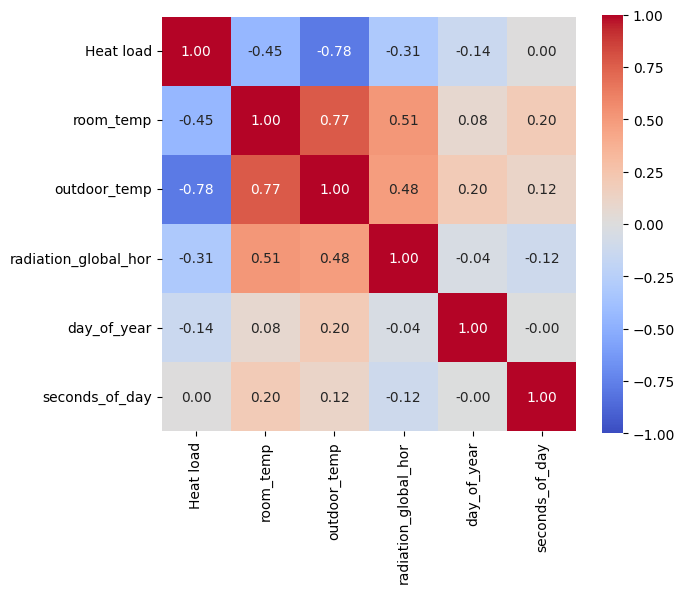

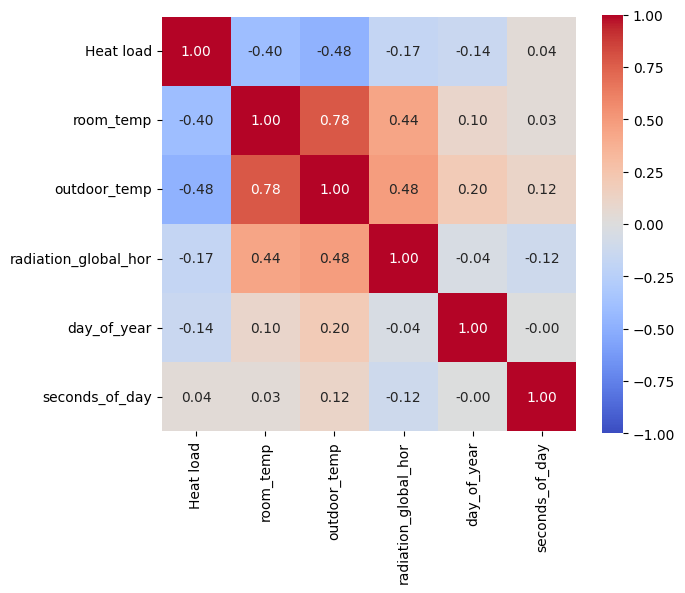

In [13]:
cols = [
    "heating_power",
    "room_temp",
    "outdoor_temp",
    "radiation_global_hor",
    "day_of_year",
    "seconds_of_day",
]

# ---- No Drift (separate figure) ----
nodrift_sub = df_nodrift[cols].copy()
nodrift_sub = nodrift_sub.rename(columns={"heating_power": "Heat load"})  # plot-only rename

corr_nodrift = nodrift_sub.corr(numeric_only=True)


fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(
    corr_nodrift,
    annot=True, fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    square=True, cbar=True,
    ax=ax
)
ax.set_title("")
fig.tight_layout()

fig.savefig("/kaggle/working/CorrelationHeatmapNodrift.pdf", format="pdf", bbox_inches="tight")  



plt.title("")
plt.tight_layout()


plt.show()



# ---- Drift (separate figure) ----
drift_sub = df_drift[cols].copy()
drift_sub = drift_sub.rename(columns={"heating_power": "Heat load"})      # plot-only rename

corr_drift = drift_sub.corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(
    corr_drift,
    annot=True, fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    square=True, cbar=True,
    ax=ax
)
ax.set_title("")
fig.tight_layout()

fig.savefig("/kaggle/working/CorrelationHeatmapdrift.pdf", format="pdf", bbox_inches="tight")

fig.tight_layout()


plt.show()

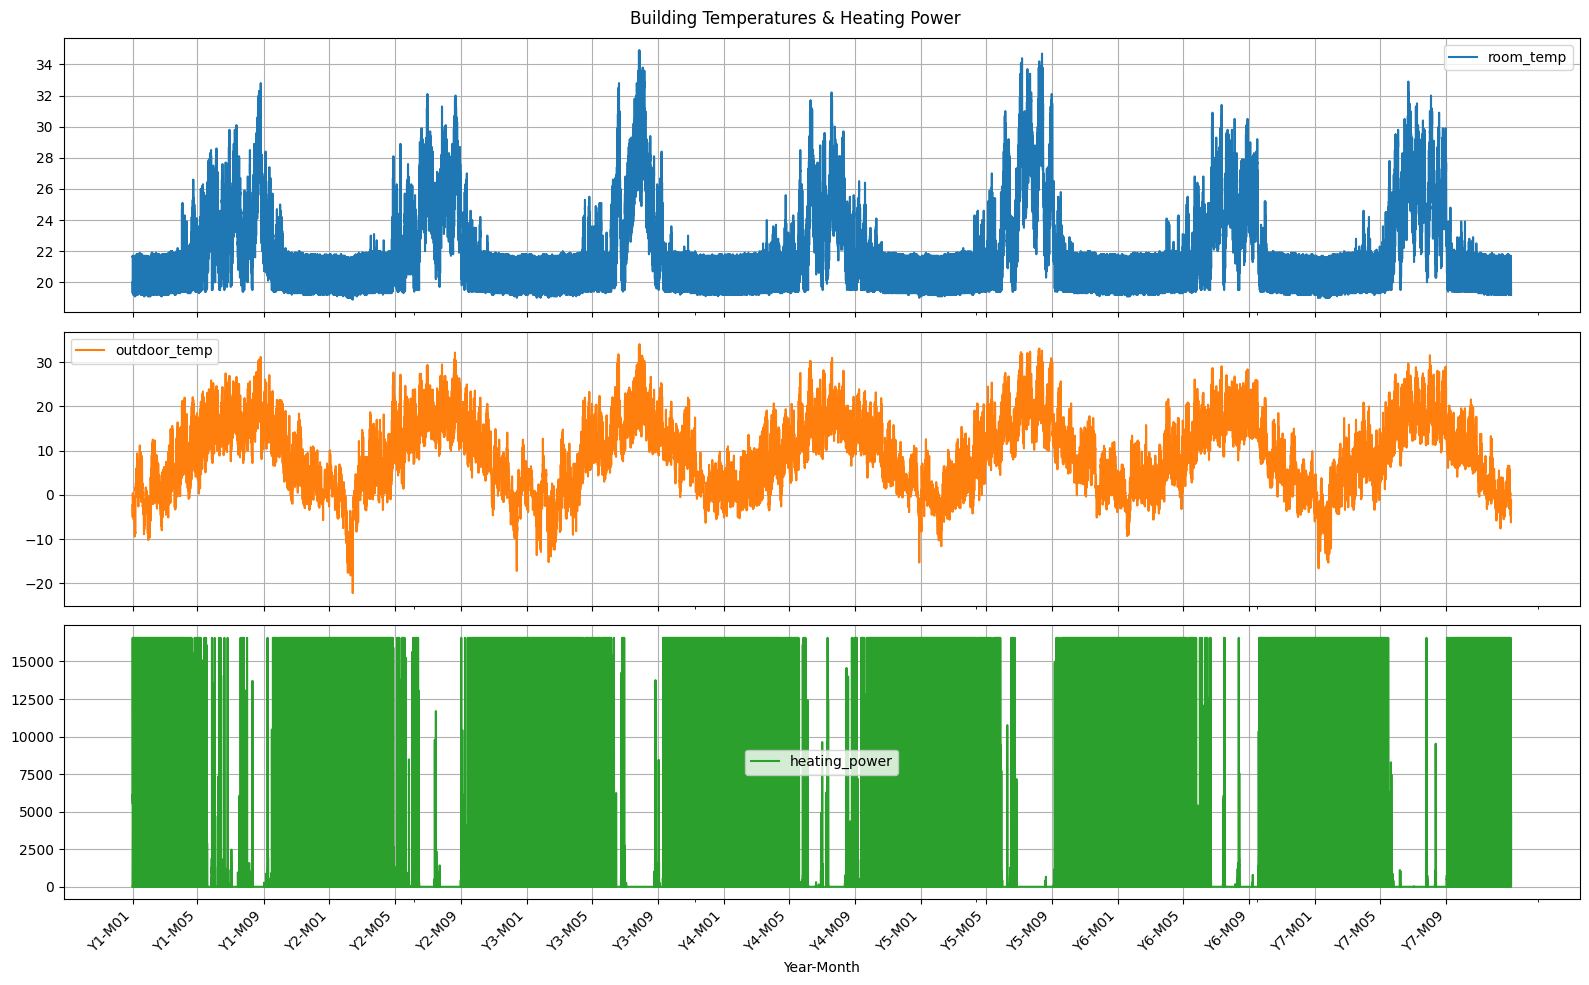

In [14]:
columns_to_plot = ['room_temp', 'outdoor_temp', 'heating_power']
df_plot = df_nodrift[columns_to_plot]
plot_slice = df_plot.head(4 * 24 * 365 * 7)  # 7 years @ 15-min

meta = df_nodrift.loc[plot_slice.index, ['year', 'month']].astype(int).reset_index(drop=True)

change = (meta[['year','month']].shift(1) != meta[['year','month']]).any(axis=1)
block_first_idx = np.where(change)[0]
if block_first_idx.size == 0 or block_first_idx[0] != 0:
    block_first_idx = np.r_[0, block_first_idx]  # ensure first tick at start
labels = [f"Y{y}-M{m:02d}" for y, m in meta.loc[block_first_idx, ['year','month']].to_numpy()]

target_ticks = 24
step = max(1, int(np.ceil(len(block_first_idx) / target_ticks)))
tick_pos = block_first_idx[::step]
tick_lbl = labels[::step]


axes = plot_slice.plot(
    subplots=True,
    layout=(3, 1),
    figsize=(16, 10),
    title="Building Temperatures & Heating Power",
    grid=True,
    legend=True
).ravel()

for ax in axes:
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_lbl, rotation=45, ha='right')

axes[-1].set_xlabel('Year-Month')
plt.tight_layout()
plt.show()

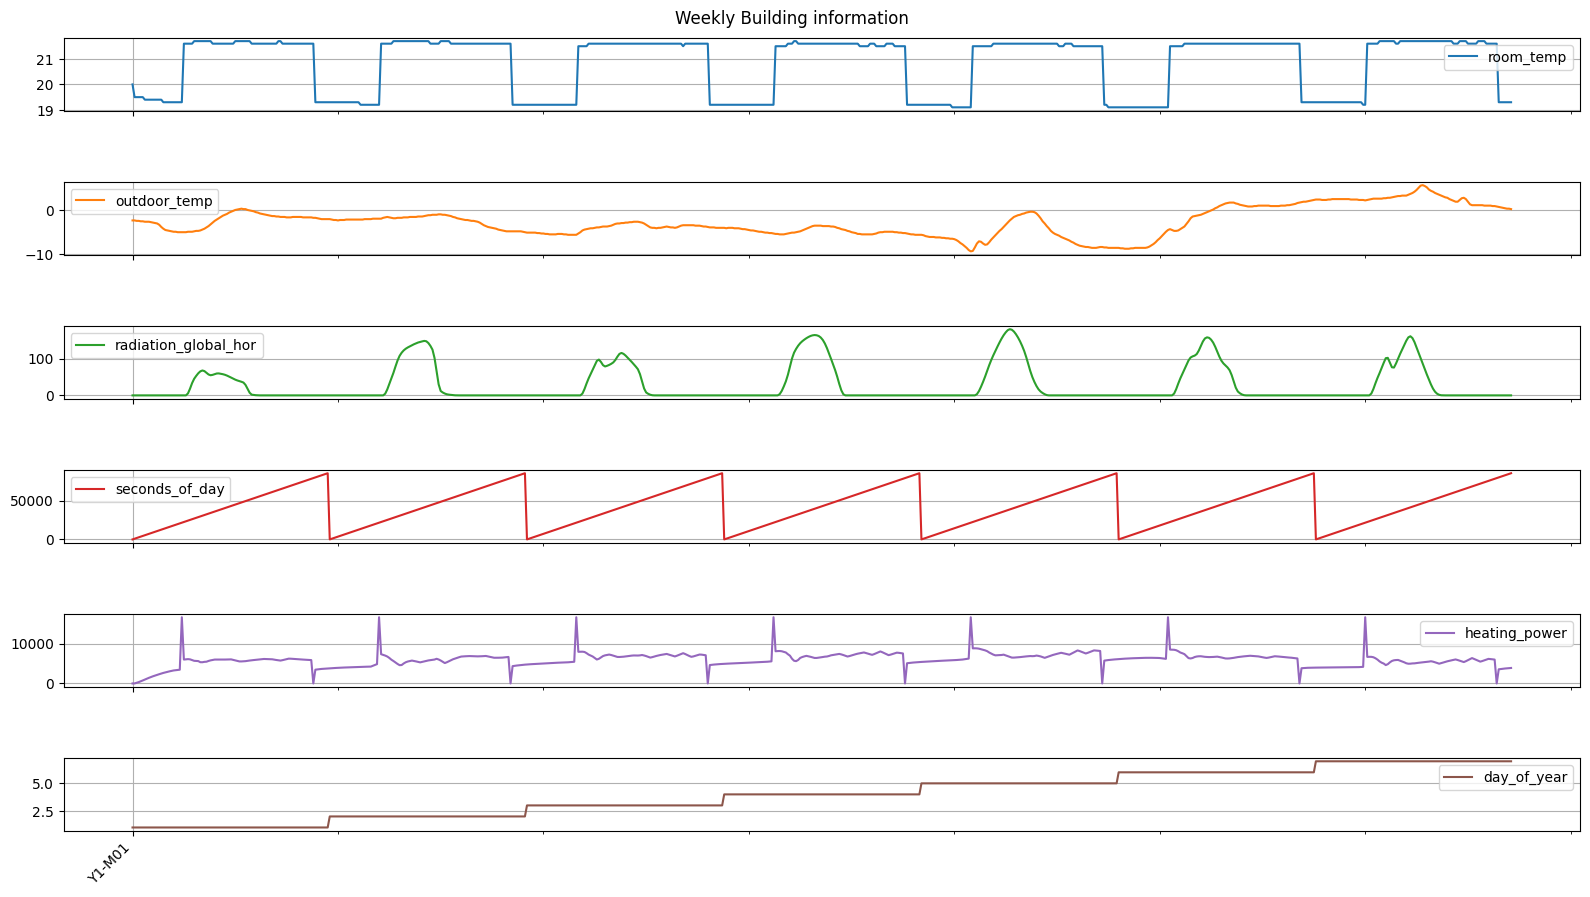

In [15]:
columns_to_plot = ['room_temp', 'outdoor_temp', 'radiation_global_hor','seconds_of_day','heating_power','day_of_year']
df_plot = df_nodrift[columns_to_plot]
plot_slice = df_plot.head(4 * 24 * 7)  # 7 years @ 15-min

meta = df_nodrift.loc[plot_slice.index, ['year', 'month']].astype(int).reset_index(drop=True)

change = (meta[['year','month']].shift(1) != meta[['year','month']]).any(axis=1)
block_first_idx = np.where(change)[0]
if block_first_idx.size == 0 or block_first_idx[0] != 0:
    block_first_idx = np.r_[0, block_first_idx]  # ensure first tick at start
labels = [f"Y{y}-M{m:02d}" for y, m in meta.loc[block_first_idx, ['year','month']].to_numpy()]

target_ticks = 24
step = max(1, int(np.ceil(len(block_first_idx) / target_ticks)))
tick_pos = block_first_idx[::step]
tick_lbl = labels[::step]


axes = plot_slice.plot(
    subplots=True,
    layout=(7, 1),
    figsize=(16, 10),
    title="Weekly Building information ",
    grid=True,
    legend=True
).ravel()

for ax in axes:
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_lbl, rotation=45, ha='right')

axes[-1].set_xlabel('Year-Month')
plt.tight_layout()
plt.show()

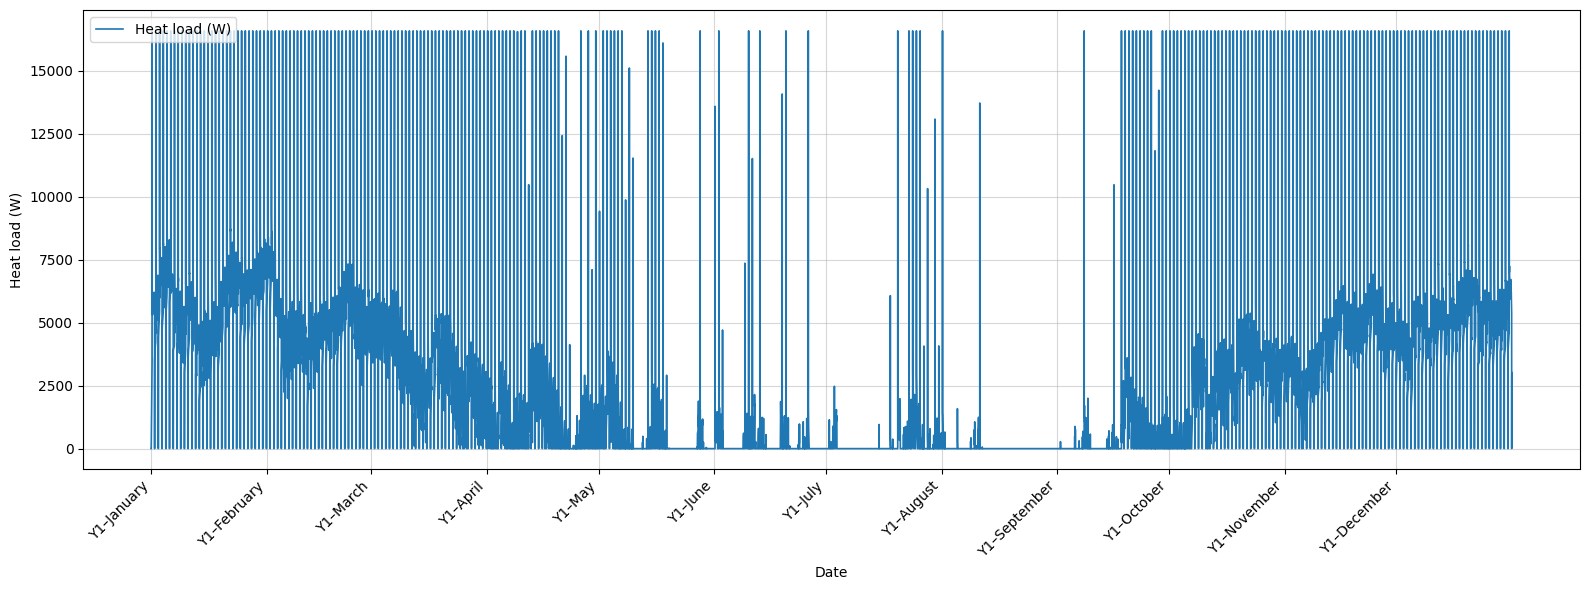

<Figure size 640x480 with 0 Axes>

In [16]:
# 1) Define the slice for exactly one year (assuming 15-min data)
rows_for_one_year = 4 * 24 * 365

import numpy as np
import matplotlib.pyplot as plt
import calendar

# 2) Select Heating Power, plus Year/Month for the labels
columns_to_use = ['heating_power', 'year', 'month']
df_plot = df_nodrift[columns_to_use].head(rows_for_one_year).copy().reset_index(drop=True)

# 3) Generate labels at (year, month) boundaries
meta = df_plot[['year', 'month']].astype(int)
change = (meta.shift(1) != meta).any(axis=1)
block_first_idx = np.where(change.to_numpy())[0]

# Ensure the first tick is included
if block_first_idx.size == 0 or block_first_idx[0] != 0:
    block_first_idx = np.r_[0, block_first_idx]

labels = [
    f"Y{y}–{calendar.month_name[m]}"
    for y, m in meta.loc[block_first_idx, ['year', 'month']].to_numpy()
]

# 4) Plotting
fig, ax = plt.subplots(figsize=(16, 6))

# Plot heating power and keep the line handle for the legend
line, = ax.plot(
    df_plot.index, df_plot['heating_power'],
    linewidth=1.2, label='Heat load (W)'
)

# Apply the custom ticks with month names
ax.set_xticks(block_first_idx)
ax.set_xticklabels(labels, rotation=45, ha='right')

# Formatting
ax.set_title("")
ax.set_ylabel("Heat load (W)")
ax.set_xlabel("Date")
ax.grid(True, alpha=0.5)

# Legend
ax.legend(handles=[line], loc='upper left', frameon=True)

plt.tight_layout()
plt.show()


plt.tight_layout()

# Save as vector PDF
out_path = "/kaggle/working/HeatingTrend1Year.pdf"
fig.savefig(out_path, format="pdf", bbox_inches="tight")

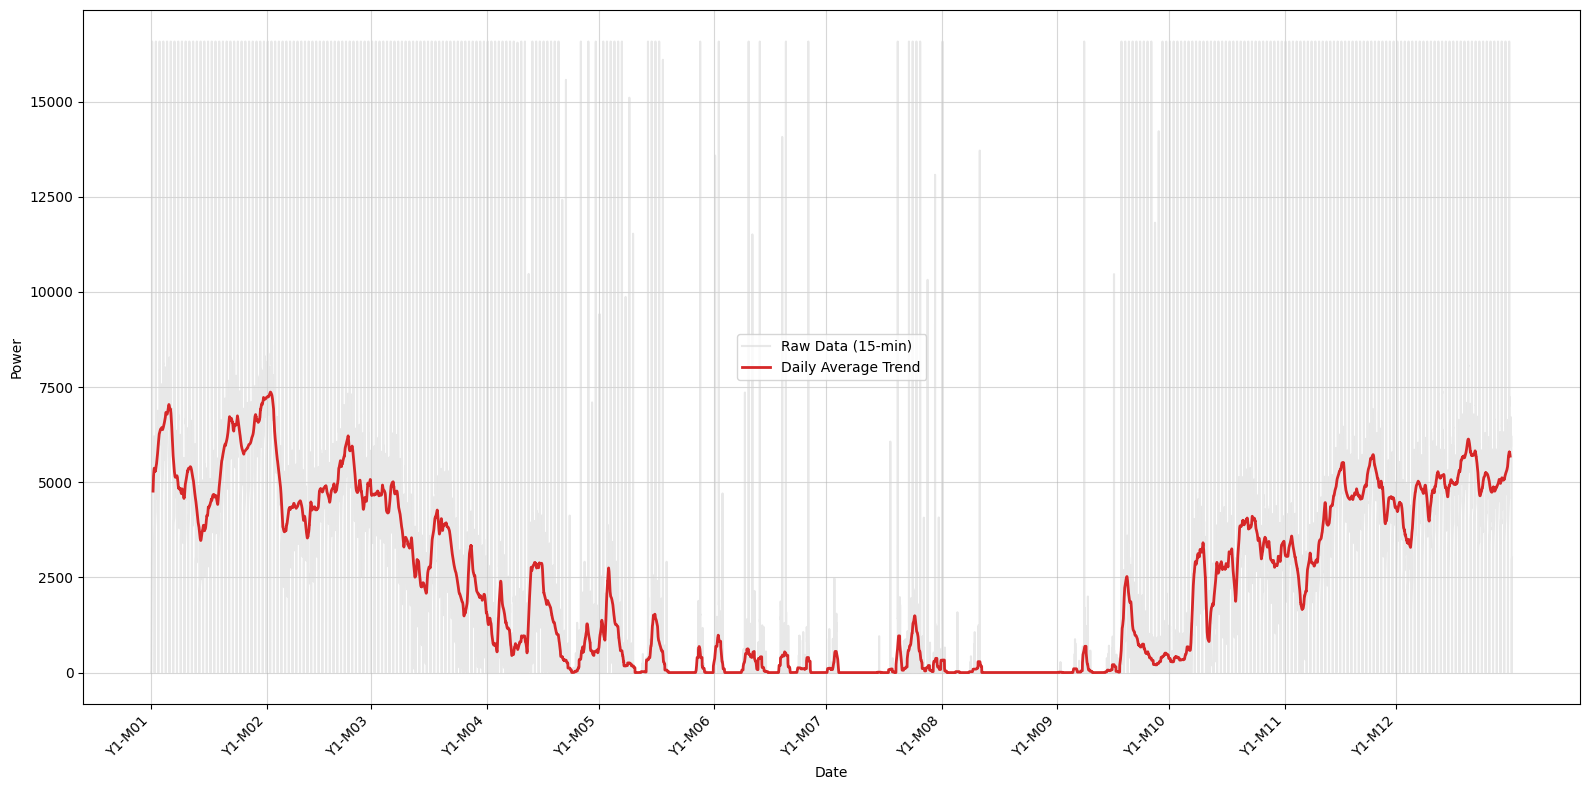

In [17]:
# 1. Setup the data (Assuming 15-min intervals)
rows_for_one_year = 4 * 24 * 365 
columns_to_use = ['heating_power', 'year', 'month']
df_plot = df_nodrift[columns_to_use].head(rows_for_one_year).copy()

# 2. Calculate a Moving Average
# Window = 96 (4 quarters * 24 hours = 1 day)
# This averages out the daily spikes to show the general daily trend
df_plot['heating_trend'] = df_plot['heating_power'].rolling(window=96, center=True).mean()

# 3. Generate Labels for plotting
meta = df_plot[['year', 'month']].astype(int).reset_index(drop=True)
change = (meta[['year','month']].shift(1) != meta[['year','month']]).any(axis=1)
block_first_idx = np.where(change)[0]
if block_first_idx.size == 0 or block_first_idx[0] != 0:
    block_first_idx = np.r_[0, block_first_idx]
labels = [f"Y{y}-M{m:02d}" for y, m in meta.loc[block_first_idx, ['year','month']].to_numpy()]

# 4. Plotting
fig, ax = plt.subplots(figsize=(16, 8))

# Option A: Plot the raw data faintly in the background
ax.plot(df_plot.index, df_plot['heating_power'], color='lightgray', alpha=0.5, label='Raw Data (15-min)')

# Option B: Plot the smooth trend line on top
ax.plot(df_plot.index, df_plot['heating_trend'], color='#d62728', linewidth=2, label='Daily Average Trend')

# Formatting
ax.set_xticks(block_first_idx)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_title("")
ax.set_ylabel("Power")
ax.set_xlabel("Date")
ax.grid(True, alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()

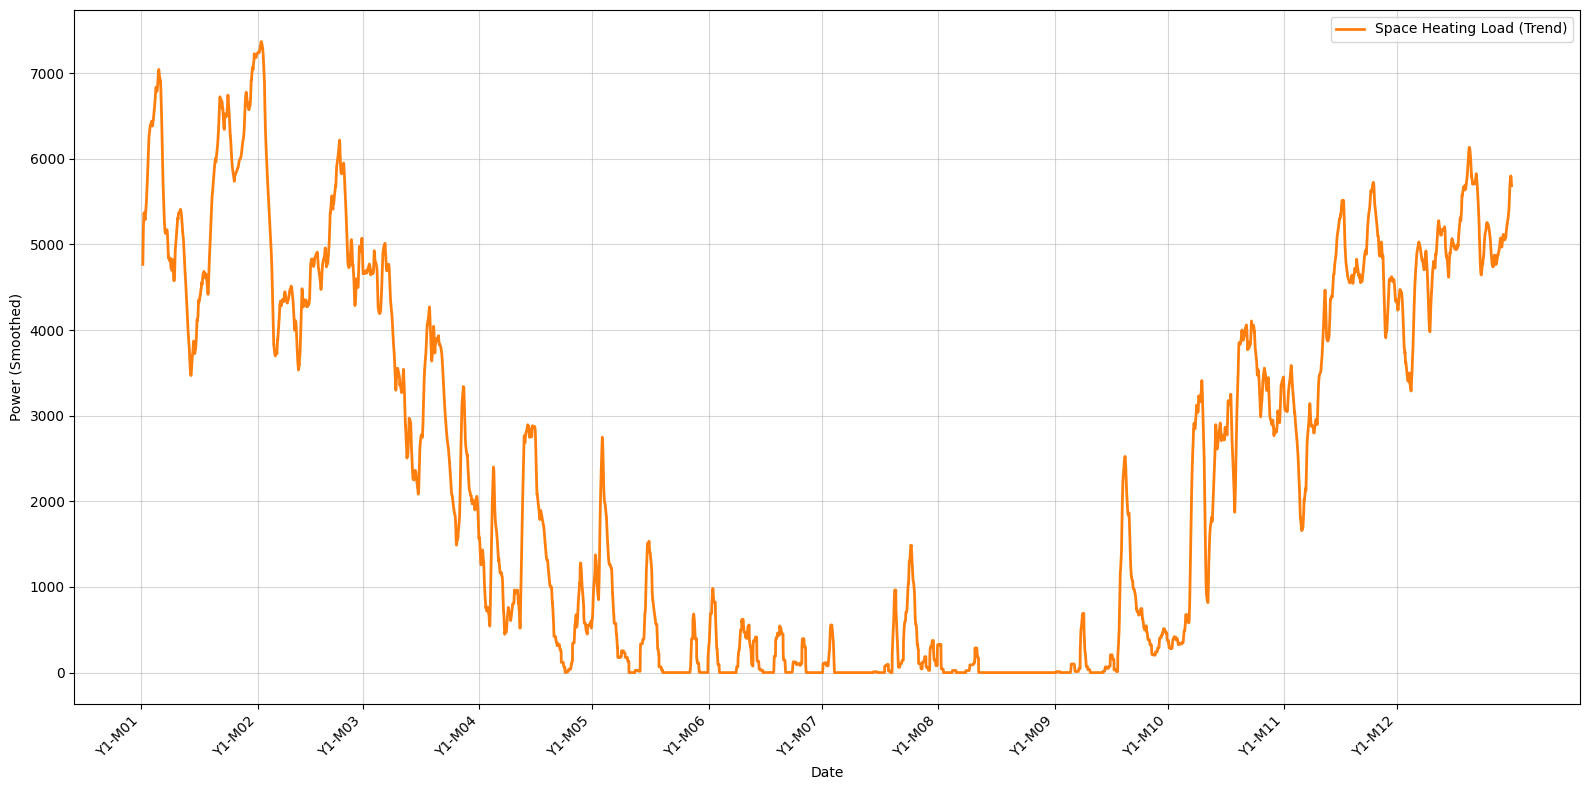

In [18]:
# 1. Setup the data (1 year)
rows_for_one_year = 4 * 24 * 365 
df_plot = df_nodrift[['heating_power', 'year', 'month']].head(rows_for_one_year).copy()

# 2. Extract the Heat Load (The Trend)
# We use a rolling window of 24 hours (4 * 24 = 96 steps)
# .mean() will smooth out the sharp spikes from the hot water.
df_plot['heat_load_trend'] = df_plot['heating_power'].rolling(window=96, center=True).mean()

# 3. Create Labels (same as before)
meta = df_plot[['year', 'month']].astype(int).reset_index(drop=True)
change = (meta[['year','month']].shift(1) != meta[['year','month']]).any(axis=1)
block_first_idx = np.where(change)[0]
if block_first_idx.size == 0 or block_first_idx[0] != 0:
    block_first_idx = np.r_[0, block_first_idx]
labels = [f"Y{y}-M{m:02d}" for y, m in meta.loc[block_first_idx, ['year','month']].to_numpy()]

# 4. Plot ONLY the Heat Load Trend
fig, ax = plt.subplots(figsize=(16, 8))

# We plot the calculated trend in a solid color (e.g., Orange or Red)
ax.plot(df_plot.index, df_plot['heat_load_trend'], color='#ff7f0e', linewidth=2, label='Space Heating Load (Trend)')

# Formatting
ax.set_xticks(block_first_idx)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_title("")
ax.set_ylabel("Power (Smoothed)")
ax.set_xlabel("Date")
ax.grid(True, alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()

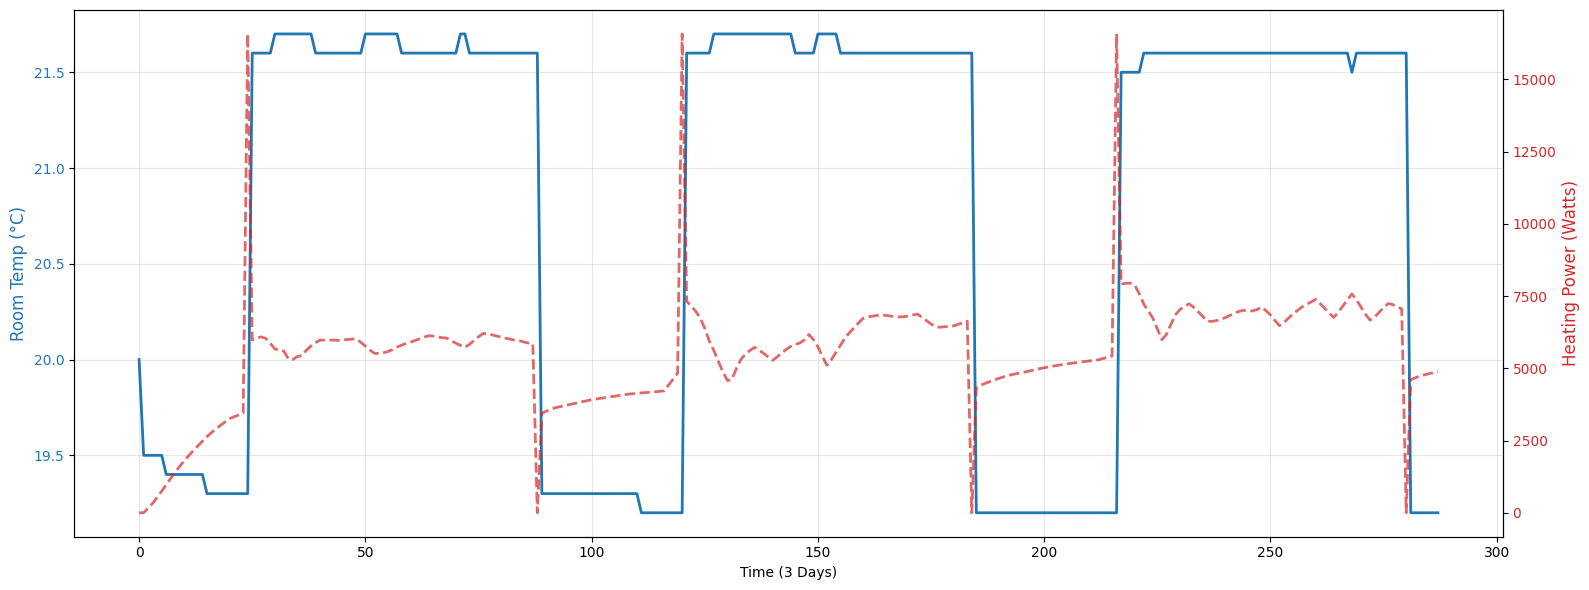

In [19]:
# 1. Select a small slice (3 Days) to see the daily startup clearly
# 3 days * 24 hours * 4 quarters = 288 data points
steps_3_days = 3 * 24 * 4
df_zoom = df_nodrift.head(steps_3_days).copy()

# 2. Setup the figure with dual axes
fig, ax1 = plt.subplots(figsize=(16, 6))

# 3. Plot Room Temperature on the Left Axis (Blue)
color_temp = 'tab:blue'
ax1.set_xlabel('Time (3 Days)')
ax1.set_ylabel('Room Temp (°C)', color=color_temp, fontsize=12)
ax1.plot(df_zoom.index, df_zoom['room_temp'], color=color_temp, linewidth=2, label='Room Temp')
ax1.tick_params(axis='y', labelcolor=color_temp)
ax1.grid(True, alpha=0.3)

# 4. Create a second y-axis for Power (Right Axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# 5. Plot Heating Power on the Right Axis (Red)
color_pwr = 'tab:red'
ax2.set_ylabel('Heating Power (Watts)', color=color_pwr, fontsize=12)
ax2.plot(df_zoom.index, df_zoom['heating_power'], color=color_pwr, linewidth=2, linestyle='--', alpha=0.7, label='Heating Power')
ax2.tick_params(axis='y', labelcolor=color_pwr)

# 6. Add a title
plt.title("")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

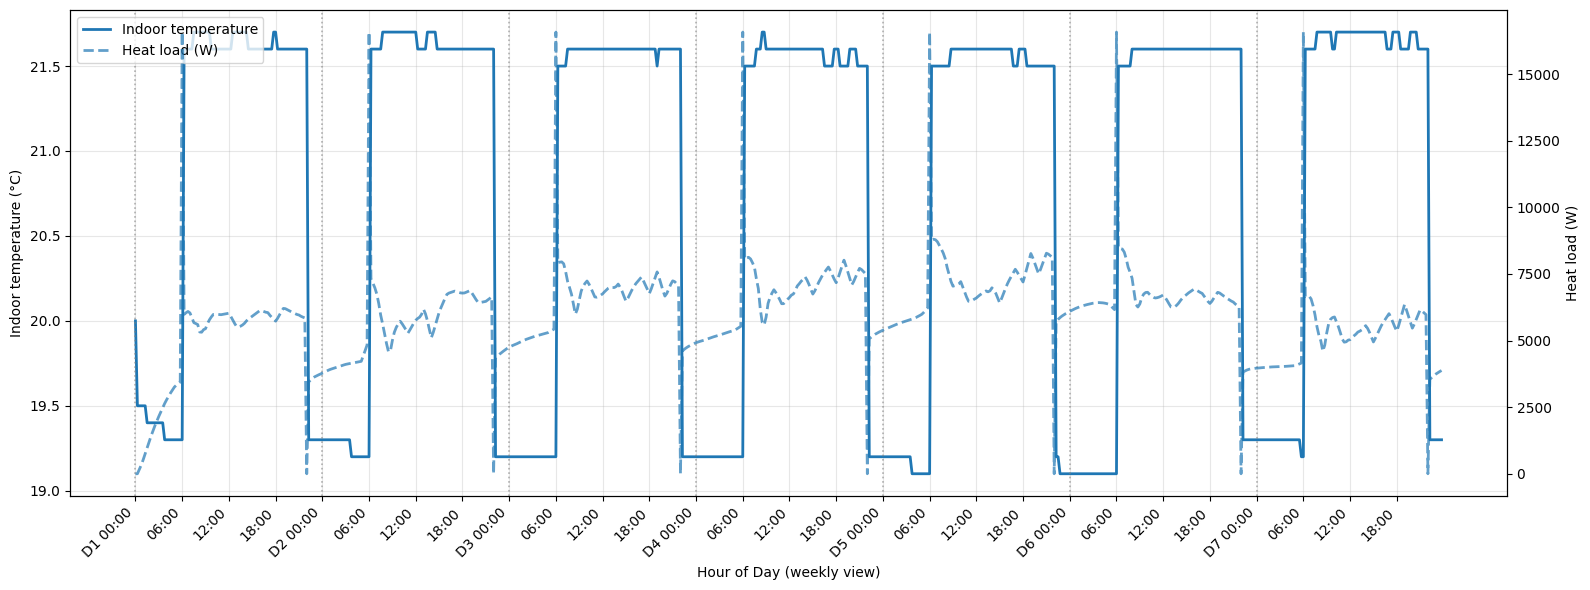

In [20]:
# === Week view with hour-of-day x-axis from 15-min "seconds_of_day" (or similar) ===
# Expects df_nodrift with columns: room_temp, heating_power, and seconds_of_day (or time_of_day)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- pick the time-of-day seconds column ----
df_src = df_nodrift.copy()
sec_col = None
for cand in ['seconds_of_day', 'time_of_day', 'tod_seconds', 'sec_of_day']:
    if cand in df_src.columns:
        sec_col = cand
        break
assert sec_col is not None, "Could not find a time-of-day column (e.g., 'seconds_of_day')."
assert 'room_temp' in df_src.columns and 'heating_power' in df_src.columns, "Missing needed columns."

# ---- slice exactly 1 week (15-min cadence -> 4 steps per hour) ----
steps_per_hour = 4
steps_week = 7 * 24 * steps_per_hour
df_week = df_src.head(steps_week).reset_index(drop=True)

# ---- hour-of-day (0..24) for labels only ----
hours_of_day = (df_week[sec_col].to_numpy(dtype=float) / 3600.0) % 24.0

# ---- day boundaries = where seconds_of_day == its daily minimum (usually 0) ----
min_sec = float(df_week[sec_col].min())
day_starts = np.where(df_week[sec_col].to_numpy() == min_sec)[0]
if day_starts.size == 0 or day_starts[0] != 0:
    day_starts = np.r_[0, day_starts]

# ---- build tick positions: every 6 hours within each day ----
ticks, tick_labels = [], []
for d, start in enumerate(day_starts):
    for h in [0, 6, 12, 18]:
        pos = start + h * steps_per_hour
        if pos < len(df_week):
            ticks.append(pos)
            prefix = f"D{d+1} " if h == 0 else ""
            tick_labels.append(f"{prefix}{h:02d}:00")

# ---- plot (dual y-axis) ----
fig, ax1 = plt.subplots(figsize=(16, 6))

ax1.set_xlabel('Hour of Day (weekly view)')
ax1.set_ylabel('Indoor temperature (°C)')
l1, = ax1.plot(
    df_week.index, df_week['room_temp'],
    linewidth=2, label='Indoor temperature'
)
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.set_ylabel('Heat load (W)')
l2, = ax2.plot(
    df_week.index, df_week['heating_power'],
    linewidth=2, linestyle='--', alpha=0.7, label='Heat load (W)'
)

# vertical lines at day boundaries
for s in day_starts:
    ax1.axvline(s, linestyle=':', linewidth=1.2, alpha=0.6, color='gray')

# apply hour-of-day ticks
ax1.set_xticks(ticks)
ax1.set_xticklabels(tick_labels, rotation=45, ha='right')

# ---- combined legend (from both axes) ----
handles = [l1, l2]
labels = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc='upper left', frameon=True)

plt.title("")
fig.tight_layout()
plt.show()


fig.tight_layout()

# Save as vector PDF (Kaggle: put it under /kaggle/working)
out_path = "/kaggle/working/MorningBoost.pdf"
fig.savefig(out_path, format="pdf", bbox_inches="tight")

In [21]:
# ==== CONFIG ====
POWER_COL = "heating_power"      # your heat load column
SEC_COL   = "seconds_of_day"     # 0..86400
DOY_COL   = "day_of_year"
YEAR_COL  = "year"

# Choose which dataframe/year to analyze:
df_src = df_nodrift  # or df_drift / df_drift_gradual / blended_df
YEAR_TO_ANALYZE = int(df_src[YEAR_COL].mode().iloc[0])  # most common year, or set explicitly

# ==== SAFETY CHECKS ====
need = {POWER_COL, SEC_COL, DOY_COL, YEAR_COL}
missing = need - set(df_src.columns)
assert not missing, f"Missing columns: {missing}"

# Keep only the chosen year, sorted by (day_of_year, seconds_of_day) to be safe
df = (df_src[df_src[YEAR_COL] == YEAR_TO_ANALYZE]
      .sort_values([DOY_COL, SEC_COL], kind="mergesort")
      .reset_index(drop=True))

assert len(df), f"No rows for year={YEAR_TO_ANALYZE}"

# Infer cadence (seconds per step) from median diff within the first day (used as tolerance)
first_day = int(df[DOY_COL].iloc[0])
d0 = df[df[DOY_COL] == first_day]
step_sec = float(np.median(np.diff(d0[SEC_COL].to_numpy()))) if len(d0) > 1 else 900.0
tol_sec  = step_sec + 1e-6  # “equal time” within one step

# Helper to format HH:MM (no timezone)
def _hhmm(sec):
    sec = float(sec)
    h = int(sec // 3600)
    m = int(round((sec % 3600) / 60.0))
    if m == 60:
        h = (h + 1) % 24
        m = 0
    return f"{h:02d}:{m:02d}"

records = []

# We’ll need quick day slicing
day_groups = {d: g.index.to_numpy() for d, g in df.groupby(DOY_COL, sort=True)}

days_sorted = sorted(day_groups.keys())
for k, doy in enumerate(days_sorted):
    idxs = day_groups[doy]
    day_frame = df.loc[idxs]

    # Daily max (peak) time
    iargmax_local = int(day_frame[POWER_COL].to_numpy().argmax())
    global_idx_peak = int(idxs[iargmax_local])
    t_peak_sec = float(df.loc[global_idx_peak, SEC_COL])
    p_peak     = float(df.loc[global_idx_peak, POWER_COL])

    # Search for the first minimum **after** the peak:
    #   1) look from peak to end of the same day
    after_idxs = idxs[iargmax_local:]  # includes peak position
    p_after = df.loc[after_idxs, POWER_COL].to_numpy(float)
    i_min_after_local = int(np.argmin(p_after))
    global_idx_min_after = int(after_idxs[i_min_after_local])

    # If the minimum after peak is just the peak itself (flat/monotone decreasing might still be ok),
    # we still consider it; but if you want strictly after, you can enforce i_min_after_local > 0.
    t_min_after_sec = float(df.loc[global_idx_min_after, SEC_COL])
    p_min_after     = float(df.loc[global_idx_min_after, POWER_COL])

    # If the minimum after peak within the same day happens to be earlier than peak (shouldn’t),
    # or if you prefer a minimum *strictly* after the peak and none exists later in the same day,
    # roll into the next day’s beginning:
    if i_min_after_local == 0 and k + 1 < len(days_sorted):
        next_doy = days_sorted[k + 1]
        next_idxs = day_groups[next_doy]
        # Take a window in the next day up to, say, midday (optional); here we scan the whole next day
        p_next = df.loc[next_idxs, POWER_COL].to_numpy(float)
        i_min_next = int(np.argmin(p_next))
        global_idx_min_after = int(next_idxs[i_min_next])
        t_min_after_sec = float(df.loc[global_idx_min_after, SEC_COL])
        p_min_after     = float(df.loc[global_idx_min_after, POWER_COL])

    records.append({
        "year": YEAR_TO_ANALYZE,
        "day_of_year": int(doy),
        "peak_seconds_of_day": t_peak_sec,
        "peak_time_hhmm": _hhmm(t_peak_sec),
        "peak_power": p_peak,
        "min_after_seconds_of_day": t_min_after_sec,
        "min_after_time_hhmm": _hhmm(t_min_after_sec),
        "min_after_power": p_min_after
    })

daily_times = pd.DataFrame.from_records(records)

# ---- Consistency across the year (mode time ± one step) ----
def _mode_time_and_share(col_seconds):
    vals = np.array(col_seconds, float)
    # round to the nearest step to avoid small floating noise
    rounded = np.round(vals / step_sec) * step_sec
    # find the most frequent rounded value
    uniq, counts = np.unique(rounded, return_counts=True)
    i = int(np.argmax(counts))
    mode_sec = float(uniq[i])
    share = float(counts[i]) / float(len(vals))
    return mode_sec, share

peak_mode_sec,  peak_share = _mode_time_and_share(daily_times["peak_seconds_of_day"])
min_mode_sec,   min_share  = _mode_time_and_share(daily_times["min_after_seconds_of_day"])

print(f"\n=== Heat-load maxima/minima times for year={YEAR_TO_ANALYZE} (feature-only) ===")
print(f"- Typical PEAK time: { _hhmm(peak_mode_sec) } "
      f"(observed on {peak_share*100:.1f}% of days; tolerance ≈ one step = {int(step_sec)}s)")
print(f"- Typical return-to-MIN time (post-peak): { _hhmm(min_mode_sec) } "
      f"(observed on {min_share*100:.1f}% of days)")

# If you want to see whether they are “the same time every day”:
same_peak_every_day = (peak_share > 0.98)   # >98% of days at the same time bin
same_min_every_day  = (min_share  > 0.98)
print(f"\nIs the PEAK time essentially the same every day?  {'Yes' if same_peak_every_day else 'No'}")
print(f"Is the MIN-after-peak time essentially the same every day?  {'Yes' if same_min_every_day else 'No'}")

# Show a small sample (first 7 days) of the per-day table
print("\nSample of per-day times (first 7 days):")
display(daily_times.head(7)[[
    "day_of_year","peak_time_hhmm","peak_power","min_after_time_hhmm","min_after_power"
]])

# If you want the full table:
# display(daily_times)



=== Heat-load maxima/minima times for year=2 (feature-only) ===
- Typical PEAK time: 06:00 (observed on 74.0% of days; tolerance ≈ one step = 900s)
- Typical return-to-MIN time (post-peak): 22:00 (observed on 56.8% of days)

Is the PEAK time essentially the same every day?  No
Is the MIN-after-peak time essentially the same every day?  No

Sample of per-day times (first 7 days):


day_of_year peak_time_hhmm  peak_power min_after_time_hhmm  min_after_power
0            1          06:00     16574.9               22:00              0.0
1            2          06:00     16574.9               22:00              0.0
2            3          06:00     16574.9               22:00              0.0
3            4          06:00     16574.9               22:00              0.0
4            5          06:00     16574.9               22:00              0.0
5            6          06:00     16574.9               22:00              0.0
6            7          06:00     16574.9               22:00              0.0

year    energy_kWh
0     1  20173.616075
1     2  22391.400225
2     3  24411.277950
3     4  19206.051950
4     5  20785.630025
5     6  21524.053225
6     7  22296.517650
7     8  19497.234000
8     9  20578.666000

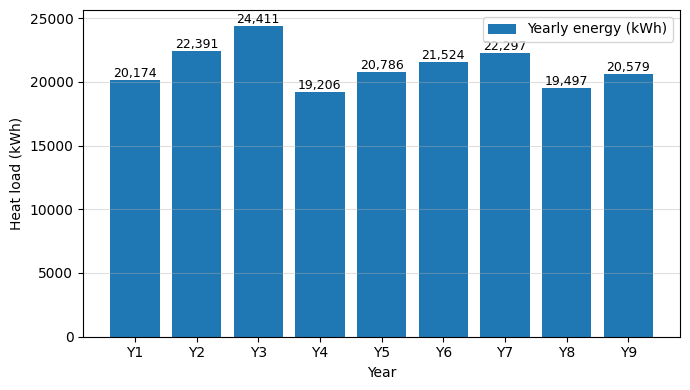

In [22]:
import numpy as np
import matplotlib.pyplot as plt

POWER_IN_WATTS = True  # True if heating_power is in W, False if already in kW

# --- guards
req = {"heating_power", "timestamp_sec", "year"}
miss = [c for c in req if c not in df_nodrift.columns]
if miss:
    raise ValueError(f"df_nodrift missing columns: {miss}")

# --- infer Δt (hours)
ts = np.sort(df_nodrift["timestamp_sec"].to_numpy())
if len(ts) < 2:
    raise ValueError("Need >= 2 timestamps to infer sampling interval.")
dt_h = float(np.median(np.diff(ts)) / 3600.0)

# --- per-row energy (kWh)
power = df_nodrift["heating_power"].to_numpy(dtype=float)
if POWER_IN_WATTS:
    power = power / 1000.0  # W -> kW
energy_row_kWh = power * dt_h  # kW * h = kWh

dfe = df_nodrift.copy()
dfe["energy_row_kWh"] = energy_row_kWh

# --- aggregate by year
yearly = (
    dfe.groupby("year", as_index=False)["energy_row_kWh"]
    .sum()
    .rename(columns={"energy_row_kWh": "energy_kWh"})
    .sort_values("year")
)
display(yearly)

# --- plot
fig, ax = plt.subplots(figsize=(7, 4))

x = np.arange(len(yearly))
vals = yearly["energy_kWh"].to_numpy()

bars = ax.bar(x, vals, label="Yearly energy (kWh)")
ax.set_xticks(x)
ax.set_xticklabels([f"Y{int(y)}" for y in yearly["year"]])

ax.set_xlabel("Year")                # <-- x-axis label added
ax.set_ylabel("Heat load (kWh)")
ax.set_title("")
ax.grid(True, axis="y", alpha=0.4)

# value labels on bars
for rect, v in zip(bars, vals):
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        rect.get_height(),
        f"{v:,.0f}",
        ha="center",
        va="bottom",
        fontsize=9
    )

ax.legend(loc="upper right", frameon=True)

fig.tight_layout()
plt.show()


fig.tight_layout()

# Save as vector PDF (Kaggle: put it under /kaggle/working)
out_path = "/kaggle/working/Yearly nodrift.pdf"
fig.savefig(out_path, format="pdf", bbox_inches="tight")

year    energy_kWh
0     1  20173.616075
1     2  22391.400225
2     3  12823.254975
3     4   1989.775675
4     5   2083.707025
5     6   2343.298900
6     7   2626.386725
7     8   2425.810450
8     9   2272.462075

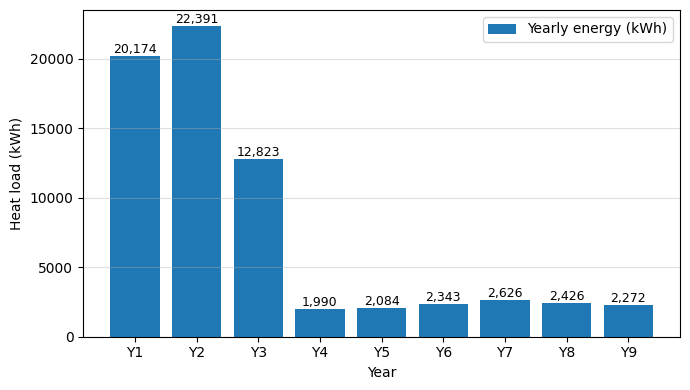

In [23]:
import numpy as np
import matplotlib.pyplot as plt

POWER_IN_WATTS = True  # True if heating_power is in W, False if already in kW

# --- guards
req = {"heating_power", "timestamp_sec", "year"}
miss = [c for c in req if c not in df_drift.columns]
if miss:
    raise ValueError(f"df_drift missing columns: {miss}")

# --- infer Δt (hours)
ts = np.sort(df_drift["timestamp_sec"].to_numpy())
if len(ts) < 2:
    raise ValueError("Need >= 2 timestamps to infer sampling interval.")
dt_h = float(np.median(np.diff(ts)) / 3600.0)

# --- per-row energy (kWh)
power = df_drift["heating_power"].to_numpy(dtype=float)
if POWER_IN_WATTS:
    power = power / 1000.0  # W -> kW
energy_row_kWh = power * dt_h  # kW * h = kWh

dfe = df_drift.copy()
dfe["energy_row_kWh"] = energy_row_kWh

# --- aggregate by year
yearly = (
    dfe.groupby("year", as_index=False)["energy_row_kWh"]
    .sum()
    .rename(columns={"energy_row_kWh": "energy_kWh"})
    .sort_values("year")
)
display(yearly)

# --- plot
fig, ax = plt.subplots(figsize=(7, 4))

x = np.arange(len(yearly))
vals = yearly["energy_kWh"].to_numpy()

bars = ax.bar(x, vals, label="Yearly energy (kWh)")
ax.set_xticks(x)
ax.set_xticklabels([f"Y{int(y)}" for y in yearly["year"]])

ax.set_xlabel("Year")
ax.set_ylabel("Heat load (kWh)")
ax.set_title("")
ax.grid(True, axis="y", alpha=0.4)

# value labels on bars
for rect, v in zip(bars, vals):
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        rect.get_height(),
        f"{v:,.0f}",
        ha="center",
        va="bottom",
        fontsize=9
    )

ax.legend(loc="upper right", frameon=True)

fig.tight_layout()


out_path = "/kaggle/working/Yearly drift.pdf"
fig.savefig(out_path, format="pdf", bbox_inches="tight")  
plt.show()


In [24]:
LOOKBACK = 106        
HORIZON  = 4 
STRIDE   = 1


FEATS = [
    "room_temp","outdoor_temp","radiation_global_hor",
    'tod_sin','tod_cos',
    'doy_sin','doy_cos',
    "heating_power"
]
idx_t = FEATS.index("heating_power")  

In [25]:
def make_windows_multi(F: np.ndarray, y: np.ndarray, lookback: int, horizon: int, stride: int = 1):
    Xs, Ys = [], []
    N, _ = F.shape
    for t in range(lookback, N - horizon + 1, stride):
        Xs.append(F[t - lookback:t, :])      # past L rows
        Ys.append(y[t : t + horizon])        # next H targets (scaled)
    return np.stack(Xs), np.stack(Ys)

In [26]:
# ===================== 1) FIT SCALER + TRAIN ON NO-DRIFT Y1–Y3 =====================
# Build Y1–Y3 nodrift block and chrono split 70/30
nodrift_y123 = df_nodrift[df_nodrift['year'].isin([1,2,3])].reset_index(drop=True)
split_idx = int(0.7 * len(nodrift_y123))

train_df = nodrift_y123.iloc[:split_idx].reset_index(drop=True)
val_df   = nodrift_y123.iloc[split_idx:].reset_index(drop=True)

# Fit single MinMax on TRAIN features (including target column)
X_tr = train_df[FEATS].to_numpy(float)
X_va = val_df[FEATS].to_numpy(float)

X_scaler = MinMaxScaler()
X_scaler.fit(X_tr)

# Transform and build windows
X_tr_s = X_scaler.transform(X_tr); y_tr_s = X_tr_s[:, idx_t].copy()
X_va_s = X_scaler.transform(X_va); y_va_s = X_va_s[:, idx_t].copy()
Xtr_win, Ytr_win = make_windows_multi(X_tr_s, y_tr_s, LOOKBACK, HORIZON, STRIDE)
Xva_win, Yva_win = make_windows_multi(X_va_s, y_va_s, LOOKBACK, HORIZON, STRIDE)


In [27]:
# def build_model_per_layer(input_steps: int,
#                           n_feats: int,
#                           horizon: int,
#                           n_layers: int,
#                           units_list: list[int],
#                           dropout_list: list[float],
#                           activations_list: list[str],
#                           optimizer_name: str,
#                           lr: float) -> tf.keras.Model:
#     model = tf.keras.Sequential([tf.keras.layers.Input(shape=(input_steps, n_feats))])
#     for li in range(n_layers):
#         return_seq = (li < n_layers - 1)
#         model.add(tf.keras.layers.LSTM(
#             units_list[li],
#             return_sequences=return_seq,
#             activation=activations_list[li]
#         ))
#         if dropout_list[li] > 0:
#             model.add(tf.keras.layers.Dropout(dropout_list[li]))
#     model.add(tf.keras.layers.Dense(horizon))  # linear head

#     if optimizer_name == "adam":
#         opt = tf.keras.optimizers.Adam(learning_rate=lr)
#     elif optimizer_name == "nadam":
#         opt = tf.keras.optimizers.Nadam(learning_rate=lr)
#     else:
#         opt = tf.keras.optimizers.RMSprop(learning_rate=lr)

#     model.compile(optimizer=opt, loss="mse", metrics=["mae"])
#     return model

# def objective(trial: optuna.trial.Trial) -> float:
#     # Shared / global hparams
#     lookback   = trial.suggest_int("lookback", 40, 108)
#     n_layers   = trial.suggest_int("n_layers", 1, 3)
#     batch_sz   = trial.suggest_int("batch_size", 32, 512, log=True)
#     lr         = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
#     optimizer  = trial.suggest_categorical("optimizer", ["adam", "nadam", "rmsprop"])

#     # Per-layer params
#     units_list, dropout_list, acts_list = [], [], []
#     for li in range(n_layers):
#         u  = trial.suggest_int(f"units_l{li+1}", 32, 512, log=True)
#         d  = trial.suggest_float(f"dropout_l{li+1}", 0.0, 0.5)
#         ac = trial.suggest_categorical(f"act_l{li+1}", ["tanh", "relu"])
#         units_list.append(u)
#         dropout_list.append(d)
#         acts_list.append(ac)

#     # Windows for this lookback (arrays already prepared outside: X_tr_s, y_tr_s, X_va_s, y_va_s)
#     Xtr_win, Ytr_win = make_windows_multi(X_tr_s, y_tr_s, lookback, HORIZON, STRIDE)
#     Xva_win, Yva_win = make_windows_multi(X_va_s, y_va_s, lookback, HORIZON, STRIDE)
#     if len(Xtr_win) < 100 or len(Xva_win) < 100:
#         raise optuna.TrialPruned()

#     # Build & train
#     model = build_model_per_layer(
#         input_steps=lookback, n_feats=Xtr_win.shape[-1], horizon=HORIZON,
#         n_layers=n_layers, units_list=units_list, dropout_list=dropout_list,
#         activations_list=acts_list, optimizer_name=optimizer, lr=lr
#     )
#     es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
#     pruning_cb = TFKerasPruningCallback(trial, monitor="val_loss")

#     hist = model.fit(
#         Xtr_win, Ytr_win,
#         validation_data=(Xva_win, Yva_win),
#         epochs=1000,
#         batch_size=batch_sz,
#         verbose=0,
#         shuffle=True,
#         callbacks=[es, pruning_cb]
#     )
#     val_loss = float(np.min(hist.history["val_loss"]))
#     trial.report(val_loss, step=0)
#     return val_loss

# # ---- Run study ----
# N_TRIALS = 100
# study = optuna.create_study(direction="minimize", study_name="lstm_optuna_per_layer_act_no_cast")
# study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

# print("\nBest trial:")
# print(f"  min val_loss (MSE scaled): {study.best_value:.6f}")
# for k, v in study.best_trial.params.items():
#     print(f"  {k}: {v}")

# # ---- Rebuild best model (no casts) ----
# best = study.best_trial.params
# BEST_LOOKBACK = int(best["lookback"])
# BEST_LAYERS   = int(best["n_layers"])
# BEST_BATCH    = int(best["batch_size"])
# BEST_LR       = float(best["lr"])
# BEST_OPT      = best["optimizer"]

# best_units   = [int(best[f"units_l{i+1}"]) for i in range(BEST_LAYERS)]
# best_dropout = [float(best[f"dropout_l{i+1}"]) for i in range(BEST_LAYERS)]
# best_acts    = [best[f"act_l{i+1}"] for i in range(BEST_LAYERS)]

# Xtr_win_b, Ytr_win_b = make_windows_multi(X_tr_s, y_tr_s, BEST_LOOKBACK, HORIZON, STRIDE)
# Xva_win_b, Yva_win_b = make_windows_multi(X_va_s, y_va_s, BEST_LOOKBACK, HORIZON, STRIDE)

# optuna_best_model = build_model_per_layer(
#     input_steps=BEST_LOOKBACK,
#     n_feats=Xtr_win_b.shape[-1],
#     horizon=HORIZON,
#     n_layers=BEST_LAYERS,
#     units_list=best_units,
#     dropout_list=best_dropout,
#     activations_list=best_acts,
#     optimizer_name=BEST_OPT,
#     lr=BEST_LR
# )
# print("\nRefit config:", {
#     "lookback": BEST_LOOKBACK, "n_layers": BEST_LAYERS,
#     "units": best_units, "dropout": best_dropout, "acts": best_acts,
#     "batch_size": BEST_BATCH, "lr": BEST_LR, "optimizer": BEST_OPT
# })

# es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
# optuna_best_model.fit(
#     Xtr_win_b, Ytr_win_b,
#     validation_data=(Xva_win_b, Yva_win_b),
#     epochs=1000,
#     batch_size=BEST_BATCH,
#     verbose=0,
#     shuffle=True,
#     callbacks=[es]
# )


In [28]:
def inv_steps_from_X_scaler(Ys_scaled_2d: np.ndarray, X_scaler: MinMaxScaler, idx_t: int, horizon: int):
    flat = Ys_scaled_2d.reshape(-1)
    flat_inv = (flat - X_scaler.min_[idx_t]) / X_scaler.scale_[idx_t]  # MinMax inverse
    return flat_inv.reshape(-1, horizon)

def build_model(input_steps: int, n_feats: int, horizon: int) -> tf.keras.Model:
    # Simple, strong baseline LSTM (you can swap in your tuned sizes if you prefer)
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_steps, n_feats)),
        tf.keras.layers.LSTM(85, return_sequences=True),
        tf.keras.layers.Dropout(0.08836895774435721),
        tf.keras.layers.LSTM(188, return_sequences=False),
        tf.keras.layers.Dropout(0.1596828160072332),
        tf.keras.layers.Dense(horizon)
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=0.0007509794596043137)
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model

def mean_absolute_percentage_error_eps(y_true, y_pred, eps=1.0):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.maximum(np.abs(y_true), eps)  # avoid divide-by-zero / near-zero blow-ups [web:811]
    return float(100.0 * np.mean(np.abs((y_true - y_pred) / denom)))  # [web:811]

def metrics_per_horizon(Y_true: np.ndarray, Y_pred: np.ndarray, mape_eps: float = 1.0):
    H = Y_true.shape[1]

    maes  = [mean_absolute_error(Y_true[:, h], Y_pred[:, h]) for h in range(H)]
    rmses = [mean_squared_error(Y_true[:, h], Y_pred[:, h], squared=False) for h in range(H)]

    mapes = [
        mean_absolute_percentage_error_eps(Y_true[:, h], Y_pred[:, h], eps=mape_eps)
        for h in range(H)
    ]

    return (
        maes,
        rmses,
        mapes,
        float(np.mean(maes)),
        float(np.mean(rmses)),
        float(np.mean(mapes)),
    )

def eval_year(
    df_src: pd.DataFrame,
    X_scaler: MinMaxScaler,
    model: tf.keras.Model,
    year: int,
    mape_eps: float = 1.0,   # in target units (e.g., W)
):
    # Slice a single year, scale with TRAIN scaler, window, predict, inverse
    d = df_src[df_src["year"] == year].reset_index(drop=True)
    if len(d) < LOOKBACK + HORIZON + 1:
        return None  # not enough data

    X = d[FEATS].to_numpy(float)
    Xs = X_scaler.transform(X)

    ys = Xs[:, idx_t].copy()
    Xw, Yw = make_windows_multi(Xs, ys, LOOKBACK, HORIZON, STRIDE)
    Xw = Xw.astype("float32")
    Yw = Yw.astype("float32")

    Y_hat_s = model.predict(Xw, verbose=0)

    Y_true = inv_steps_from_X_scaler(Yw,       X_scaler, idx_t, HORIZON)
    Y_hat  = inv_steps_from_X_scaler(Y_hat_s,  X_scaler, idx_t, HORIZON)

    maes, rmses, mapes, mae_avg, rmse_avg, mape_avg = metrics_per_horizon(
        Y_true, Y_hat, mape_eps=mape_eps
    )

    out = {
        "n_windows": len(Y_true),

        "H1_MAE": maes[0], "H2_MAE": maes[1], "H3_MAE": maes[2], "H4_MAE": maes[3],
        "MAE_avg": mae_avg,

        "H1_RMSE": rmses[0], "H2_RMSE": rmses[1], "H3_RMSE": rmses[2], "H4_RMSE": rmses[3],
        "RMSE_avg": rmse_avg,

        "H1_MAPE": mapes[0], "H2_MAPE": mapes[1], "H3_MAPE": mapes[2], "H4_MAPE": mapes[3],
        "MAPE_avg": mape_avg,
    }
    return out

In [29]:
# Build & train model
model = build_model(LOOKBACK, len(FEATS), HORIZON)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
hist = model.fit(
    Xtr_win, Ytr_win,
    validation_data=(Xva_win, Yva_win),
    epochs=1000,
    batch_size=41,
    verbose=1,
    callbacks=[es],
    shuffle=True
)

baseline_model = tf.keras.models.clone_model(model)
baseline_model.build(model.input_shape)
baseline_model.set_weights(model.get_weights())
baseline_model.compile(optimizer=tf.keras.optimizers.deserialize(tf.keras.optimizers.serialize(model.optimizer)),
                       loss=model.loss, metrics=[m for m in model.metrics if m.name != "loss"])

I0000 00:00:1771583059.984771      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1771583059.987450      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/1000


I0000 00:00:1771583065.381564     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


1794/1794 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - loss: 0.0072 - mae: 0.0433 - val_loss: 0.0053 - val_mae: 0.0302
Epoch 2/1000
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 0.0047 - mae: 0.0314 - val_loss: 0.0040 - val_mae: 0.0264
Epoch 3/1000
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 0.0034 - mae: 0.0270 - val_loss: 0.0020 - val_mae: 0.0206
Epoch 4/1000
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 0.0023 - mae: 0.0234 - val_loss: 0.0015 - val_mae: 0.0188
Epoch 5/1000
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 0.0021 - mae: 0.0221 - val_loss: 0.0015 - val_mae: 0.0181
Epoch 6/1000
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 0.0023 - mae: 0.0223 - val_loss: 9.9200e-04 - val_mae: 0.0157
Epoch 7/1000
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 0.0016 - mae: 0.0196 - val_loss: 0.0024 - val_mae: 0.0188
Epoch 8/1000
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 0.0017 - mae: 0.0194 - val_loss: 0.0012 - val_mae: 0.0155
Epoch 9/1000
1794


=== Baseline trained on No-Drift Y1–Y3 — Evaluation on Y1–Y3 (No-Drift vs Drifted) ===


Dataset  Year  n_windows  H1_MAE  H2_MAE  H3_MAE  H4_MAE  MAE_avg  \
0   Drifted     1      34931    87.4   111.3   139.6   160.7    124.8   
1   Drifted     2      35027    86.9   110.1   140.3   163.0    125.1   
2   Drifted     3      34931   223.0   232.2   270.8   294.4    255.1   
3  No-Drift     1      34931    87.4   111.3   139.6   160.7    124.8   
4  No-Drift     2      35027    86.9   110.1   140.3   163.0    125.1   
5  No-Drift     3      34931    96.8   122.3   154.5   179.5    138.3   

   H1_RMSE  H2_RMSE  H3_RMSE  H4_RMSE  RMSE_avg  H1_MAPE  H2_MAPE  H3_MAPE  \
0    193.6    240.5    326.8    346.5     276.9  1,763.3  2,021.7  2,564.4   
1    177.5    211.3    283.3    310.9     245.7  1,471.7  1,692.9  2,175.7   
2    783.5    653.9    746.1    721.6     726.3  6,594.3  7,323.1  8,559.9   
3    193.6    240.5    326.8    346.5     276.9  1,763.3  2,021.7  2,564.4   
4    177.5    211.3    283.3    310.9     245.7  1,471.7  1,692.9  2,175.7   
5    199.0    230.2    308.7    338.8     269.2  1,304.6  1,549.4  2,008.3   

   H4_MAPE  MAPE_avg  
0  2,905.1   2,313.6  
1  2,546.5   1,971.7  
2  8,914.0   7,847.8  
3  2,905.1   2,313.6  
4  2,546.5   1,971.7  
5  2,291.1   1,788.4

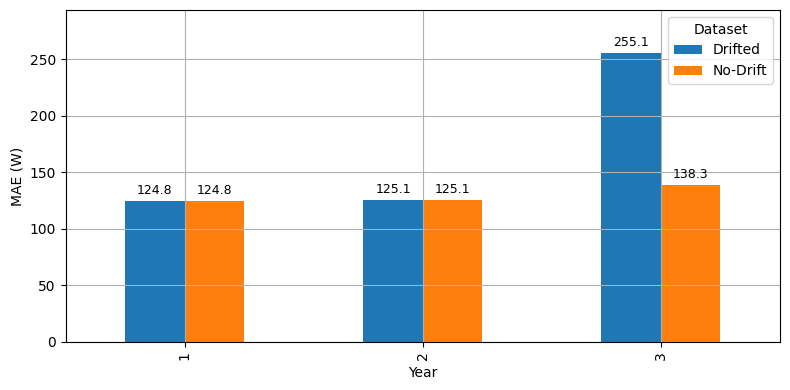

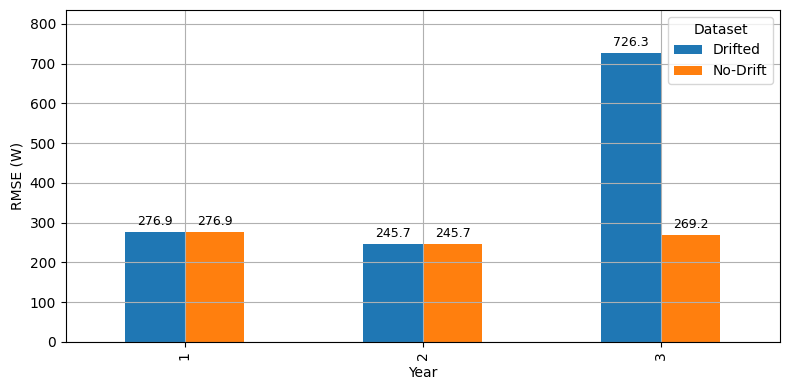

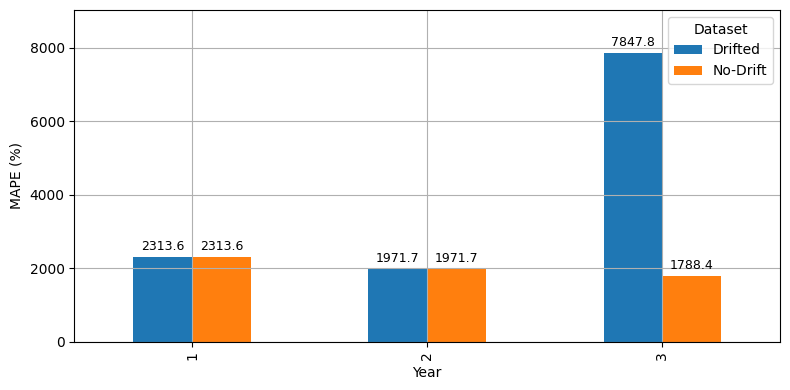

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# ===================== Build summary =====================
rows = []
for ds_name, df_src in [("No-Drift", df_nodrift), ("Drifted", df_drift)]:
    for y in [1, 2, 3]:
        res = eval_year(df_src, X_scaler, baseline_model, y)  # must return MAE_avg, RMSE_avg, MAPE_avg
        if res is None:
            continue
        row = {"Dataset": ds_name, "Year": y}
        row.update(res)
        rows.append(row)

summary = (
    pd.DataFrame(rows)
    .sort_values(by=["Dataset", "Year"])
    .reset_index(drop=True)
)

# Show tables with ONE decimal
pd.set_option("display.float_format", lambda v: f"{v:,.1f}")
print("\n=== Baseline trained on No-Drift Y1–Y3 — Evaluation on Y1–Y3 (No-Drift vs Drifted) ===")
display(summary)

# ===================== helper: write values on bars =====================
def add_bar_values(ax, fmt="{:.1f}", padding=3, fontsize=9):
    """
    Adds numeric labels to ALL bar containers in a pandas/matplotlib bar plot.
    Uses ax.bar_label (Matplotlib 3.4+) when available, otherwise falls back to annotate.
    fmt controls decimals, e.g. '{:.1f}' for one decimal.
    """
    for container in ax.containers:
        try:
            labels = [fmt.format(bar.get_height()) for bar in container]
            ax.bar_label(container, labels=labels, padding=padding, fontsize=fontsize)  # [web:910]
        except Exception:
            for bar in container:
                h = bar.get_height()
                ax.annotate(
                    fmt.format(h),
                    (bar.get_x() + bar.get_width() / 2, h),
                    ha="center",
                    va="bottom",
                    xytext=(0, padding),
                    textcoords="offset points",
                    fontsize=fontsize,
                )

# ===================== MAE plot =====================
try:
    pivot_mae = summary.pivot(index="Year", columns="Dataset", values="MAE_avg")

    fig, ax = plt.subplots(figsize=(8, 4))
    pivot_mae.plot(kind="bar", ax=ax, grid=True)

    ax.set_ylabel("MAE (W)")
    ax.set_title("")
    add_bar_values(ax, fmt="{:.1f}", padding=3, fontsize=9)
    ax.margins(y=0.15)

    fig.tight_layout()
    fig.savefig("/kaggle/working/BaselineEvalY1toY3.pdf", format="pdf", bbox_inches="tight")
    plt.show()
except Exception as e:
    print("MAE plot failed:", e)

# ===================== RMSE plot =====================
try:
    pivot_rmse = summary.pivot(index="Year", columns="Dataset", values="RMSE_avg")

    fig, ax = plt.subplots(figsize=(8, 4))
    pivot_rmse.plot(kind="bar", ax=ax, grid=True)

    ax.set_ylabel("RMSE (W)")
    ax.set_title("")
    add_bar_values(ax, fmt="{:.1f}", padding=3, fontsize=9)
    ax.margins(y=0.15)

    fig.tight_layout()
    fig.savefig("/kaggle/working/BaselineEvalY1toY3RMSE.pdf", format="pdf", bbox_inches="tight")
    plt.show()
except Exception as e:
    print("RMSE plot failed:", e)

# ===================== MAPE plot =====================
try:
    pivot_mape = summary.pivot(index="Year", columns="Dataset", values="MAPE_avg")

    fig, ax = plt.subplots(figsize=(8, 4))
    pivot_mape.plot(kind="bar", ax=ax, grid=True)

    ax.set_ylabel("MAPE (%)")
    ax.set_title("")
    add_bar_values(ax, fmt="{:.1f}", padding=3, fontsize=9)
    ax.margins(y=0.15)

    fig.tight_layout()
    fig.savefig("/kaggle/working/BaselineEvalY1toY3MAPE.pdf", format="pdf", bbox_inches="tight")
    plt.show()
except Exception as e:
    print("MAPE plot failed:", e)


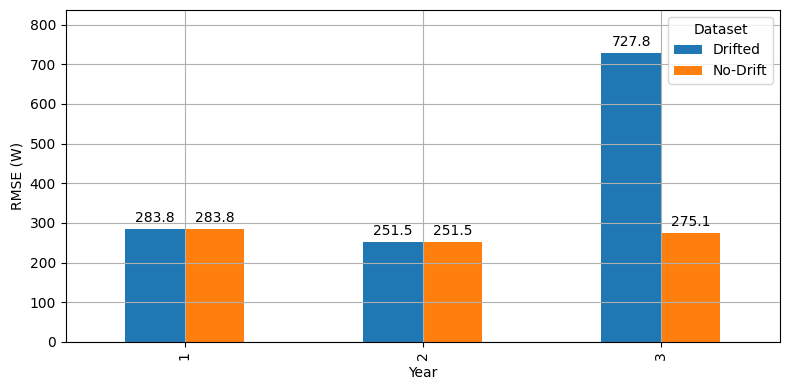

In [42]:
# ---- Config ----
YEARS = [1, 2, 3]


# ---- Safety checks: you should already have these in scope ----
assert "df_drift" in globals() and isinstance(df_drift, pd.DataFrame) and len(df_drift), "df_drift missing/empty."
assert "df_nodrift" in globals() and isinstance(df_nodrift, pd.DataFrame) and len(df_nodrift), "df_nodrift missing/empty."
assert "X_scaler" in globals(), "X_scaler missing."
assert "baseline_model" in globals(), "baseline_model missing."
assert "FEATS" in globals() and "idx_t" in globals(), "FEATS/idx_t missing."
assert "LOOKBACK" in globals() and "HORIZON" in globals(), "LOOKBACK/HORIZON missing."
assert "make_windows_multi" in globals(), "make_windows_multi missing."
assert "inv_steps_from_X_scaler" in globals(), "inv_steps_from_X_scaler missing."

def rmse_flattened(Y_true: np.ndarray, Y_pred: np.ndarray) -> float:
    """RMSE flattened over all windows x horizons."""
    y_t = np.asarray(Y_true, dtype=float).reshape(-1)
    y_p = np.asarray(Y_pred, dtype=float).reshape(-1)
    return float(mean_squared_error(y_t, y_p, squared=False))

def eval_year_rmse_flat(df_src: pd.DataFrame, year: int, model) -> dict | None:
    d = df_src[df_src["year"] == year].reset_index(drop=True)
    if len(d) < LOOKBACK + HORIZON + 1:
        return None

    X  = d[FEATS].to_numpy(float)
    Xs = X_scaler.transform(X)
    ys = Xs[:, idx_t].copy()

    stride = globals().get("STRIDE", 1)
    Xw, Yw = make_windows_multi(Xs, ys, LOOKBACK, HORIZON, stride)
    Xw = Xw.astype("float32")
    Yw = Yw.astype("float32")

    Y_hat_s = model.predict(Xw, verbose=0)

    Y_true = inv_steps_from_X_scaler(Yw,      X_scaler, idx_t, HORIZON)
    Y_hat  = inv_steps_from_X_scaler(Y_hat_s, X_scaler, idx_t, HORIZON)

    return {"Year": year, "RMSE": rmse_flattened(Y_true, Y_hat), "n_windows": len(Y_true)}

def add_bar_values(ax, fmt="{:.1f}", padding=3, fontsize=10):
    for container in ax.containers:
        ax.bar_label(container, fmt=fmt, padding=padding, fontsize=fontsize)

# ---- Compute RMSE for drifted vs no-drift ----
rows = []
for year in YEARS:
    r1 = eval_year_rmse_flat(df_drift, year=year, model=baseline_model)
    if r1 is not None:
        r1["Dataset"] = "Drifted"
        rows.append(r1)

    r2 = eval_year_rmse_flat(df_nodrift, year=year, model=baseline_model)
    if r2 is not None:
        r2["Dataset"] = "No-Drift"
        rows.append(r2)

summary = pd.DataFrame(rows)
assert len(summary), "No rows produced (check year labels / windowing constraints)."

# ---- Plot (match the photo style) ----
pivot_rmse = summary.pivot(index="Year", columns="Dataset", values="RMSE")

fig, ax = plt.subplots(figsize=(8, 4))
pivot_rmse.plot(kind="bar", ax=ax, grid=True)

ax.set_xlabel("Year")
ax.set_ylabel("RMSE (W)")
ax.set_title("")
ax.legend(title="Dataset", loc="upper right")

add_bar_values(ax, fmt="{:.1f}", padding=3, fontsize=10)
ax.margins(y=0.15)
OUT_PATH = "/kaggle/working/BaselineEvalY1toY3RMSE.pdf"
fig.tight_layout()
fig.savefig(OUT_PATH, format="pdf", bbox_inches="tight")
plt.show()

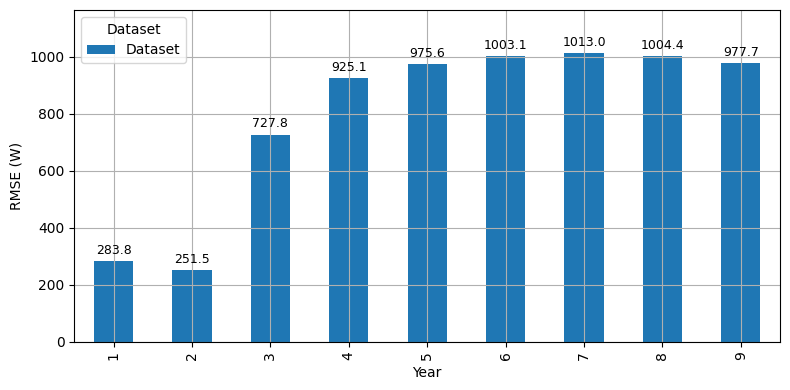

In [39]:
# ===================== Global RMSE (flattened) + RMSE plot (saved) =====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import calendar

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -------------------- Optional helper: bar value labels --------------------
def add_bar_values(ax, fmt="{:.1f}", padding=3, fontsize=9):
    for container in ax.containers:
        labels = []
        for v in container.datavalues:
            labels.append("" if (v is None or (isinstance(v, float) and not np.isfinite(v))) else fmt.format(v))
        ax.bar_label(container, labels=labels, padding=padding, fontsize=fontsize)





# -------------------- RMSE_global: flattened over windows x horizons --------------------
def rmse_global(Y_true: np.ndarray, Y_pred: np.ndarray) -> float:
    y_t = np.asarray(Y_true, dtype=float).reshape(-1)
    y_p = np.asarray(Y_pred, dtype=float).reshape(-1)
    return float(mean_squared_error(y_t, y_p, squared=False))

# -------------------- Per-horizon metrics (+ global RMSE) --------------------
def metrics_per_horizon(Y_true: np.ndarray, Y_pred: np.ndarray, mape_eps: float = 1.0):
    H = Y_true.shape[1]

    maes  = [mean_absolute_error(Y_true[:, h], Y_pred[:, h]) for h in range(H)]
    rmses = [mean_squared_error(Y_true[:, h], Y_pred[:, h], squared=False) for h in range(H)]
    mapes = [mean_absolute_percentage_error_eps(Y_true[:, h], Y_pred[:, h], eps=mape_eps) for h in range(H)]

    rmse_g = rmse_global(Y_true, Y_pred)

    return (
        maes,
        rmses,
        mapes,
        float(np.mean(maes)),
        float(rmse_g),          # RMSE_avg := flattened RMSE over all windows x horizons
        float(np.mean(mapes)),
        float(rmse_g),          # RMSE_global explicitly (same value)
    )

# -------------------- Year evaluation --------------------
def eval_year(
    df_src: pd.DataFrame,
    X_scaler: MinMaxScaler,
    model: tf.keras.Model,
    year: int,
    mape_eps: float = 1.0,
):
    d = df_src[df_src["year"] == year].reset_index(drop=True)
    if len(d) < LOOKBACK + HORIZON + 1:
        return None

    X = d[FEATS].to_numpy(float)
    Xs = X_scaler.transform(X)

    ys = Xs[:, idx_t].copy()

    # ---- FIX: avoid UnboundLocalError by not assigning to STRIDE in this scope ----
    stride = globals().get("STRIDE", 1)
    # ------------------------------------------------------------------------------

    Xw, Yw = make_windows_multi(Xs, ys, LOOKBACK, HORIZON, stride)
    Xw = Xw.astype("float32")
    Yw = Yw.astype("float32")

    Y_hat_s = model.predict(Xw, verbose=0)

    Y_true = inv_steps_from_X_scaler(Yw,      X_scaler, idx_t, HORIZON)
    Y_hat  = inv_steps_from_X_scaler(Y_hat_s, X_scaler, idx_t, HORIZON)

    maes, rmses, mapes, mae_avg, rmse_avg, mape_avg, rmse_g = metrics_per_horizon(
        Y_true, Y_hat, mape_eps=mape_eps
    )

    out = {
        "Year": year,
        "n_windows": len(Y_true),

        "H1_MAE": maes[0], "H2_MAE": maes[1], "H3_MAE": maes[2], "H4_MAE": maes[3],
        "MAE_avg": mae_avg,

        "H1_RMSE": rmses[0], "H2_RMSE": rmses[1], "H3_RMSE": rmses[2], "H4_RMSE": rmses[3],
        "RMSE_avg": rmse_avg,          # flattened global RMSE

        "H1_MAPE": mapes[0], "H2_MAPE": mapes[1], "H3_MAPE": mapes[2], "H4_MAPE": mapes[3],
        "MAPE_avg": mape_avg,

        "RMSE_global": rmse_g,         # same as RMSE_avg (kept for clarity)
    }
    return out

# -------------------- Build YEARS + summary (fix YEARS NameError) --------------------
if "YEARS" not in globals():
    YEARS = sorted(pd.unique(df_src["year"].dropna()))
if "DATASET_NAME" not in globals():
    DATASET_NAME = "Dataset"

rows = []
for year in YEARS:
    r = eval_year(df_src=df_src, X_scaler=X_scaler, model=model, year=year, mape_eps=1.0)
    if r is not None:
        r["Dataset"] = DATASET_NAME
        rows.append(r)

summary = pd.DataFrame(rows)

# ===================== RMSE plot (RMSE_avg is flattened RMSE) =====================
try:
    pivot_rmse = summary.pivot(index="Year", columns="Dataset", values="RMSE_avg")

    fig, ax = plt.subplots(figsize=(8, 4))
    pivot_rmse.plot(kind="bar", ax=ax, grid=True)

    ax.set_ylabel("RMSE (W)")
    ax.set_title("")
    add_bar_values(ax, fmt="{:.1f}", padding=3, fontsize=9)
    ax.margins(y=0.15)

    fig.tight_layout()
    # fig.savefig("/kaggle/working/BaselineEvalY1toY3RMSE.pdf", format="pdf", bbox_inches="tight")
    plt.show()
except Exception as e:
    print("RMSE plot failed:", e)


       No-Drift  Retrofit (drift)
month                            
1       5,731.8           5,731.8
2       5,955.9           5,955.9
3       4,565.9           4,423.8
4       2,382.4             129.2
5       1,410.0               0.0
6         622.6               0.5
7           1.8               0.0
8          45.2               0.0
9       1,064.2               0.0
10      2,226.5              25.4
11      4,429.2             672.1
12      5,225.9             899.2


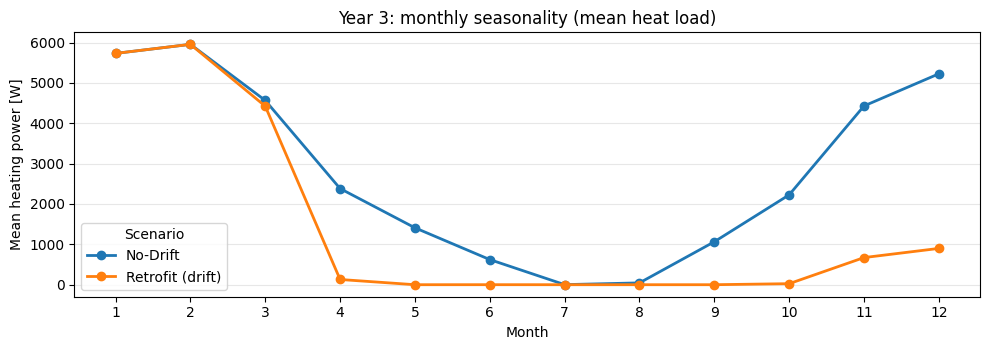

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# ----------------- CONFIG (match your real columns) ----------------- 
YEAR_TO_PLOT = 3
YEAR_COL   = "year" 
MONTH_COL  = "month"
TARGET_COL = "heating_power"   # your heat-load column (W)

SCENARIOS = [
    ("No-Drift", df_nodrift),
    ("Retrofit (drift)", df_drift),
]

# ----------------- build monthly seasonality -----------------
monthly_load = {}

for name, df in SCENARIOS:
    if YEAR_COL not in df.columns or MONTH_COL not in df.columns:
        raise ValueError(f"Missing '{YEAR_COL}' or '{MONTH_COL}' in {name}. Columns: {list(df.columns)}")

    d = df.loc[df[YEAR_COL] == YEAR_TO_PLOT].copy()

    # Mean load per month (ensure Jan..Dec order)
    s = (
        d.groupby(MONTH_COL)[TARGET_COL]
         .mean()
         .reindex(range(1, 13))
    )
    monthly_load[name] = s

monthly_df = pd.DataFrame(monthly_load)
print(monthly_df)

# ----------------- plot -----------------
fig, ax = plt.subplots(figsize=(10, 3.6))
monthly_df.plot(ax=ax, marker="o", linewidth=2)
ax.set_title(f"Year {YEAR_TO_PLOT}: monthly seasonality (mean heat load)")
ax.set_xlabel("Month")
ax.set_ylabel("Mean heating power [W]")
ax.set_xticks(range(1, 13))
ax.grid(True, axis="y", alpha=0.3)
ax.legend(title="Scenario")
fig.tight_layout()
plt.show()



=== Year 4 (No-drift) — Unseen test on baseline ===
t+1: MAE=91.026  RMSE=207.138  sMAPE=71.16%
t+2: MAE=117.684  RMSE=246.670  sMAPE=72.45%
t+3: MAE=150.105  RMSE=338.466  sMAPE=74.05%
t+4: MAE=174.050  RMSE=359.080  sMAPE=75.21%
Avg : MAE=133.216  RMSE=287.839  sMAPE=73.22%   windows=34931
Glob: MAE=133.216  RMSE=294.640  sMAPE=73.22%   points=139724


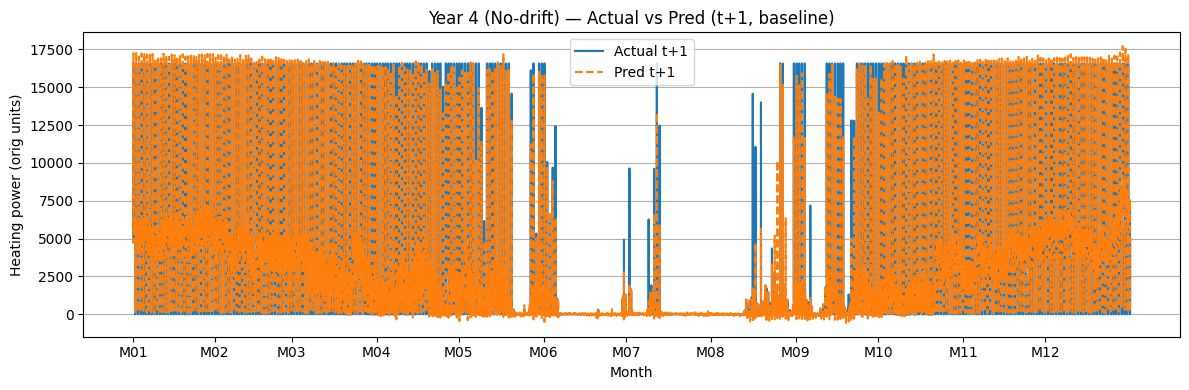

In [37]:
# Guards: require trained baseline, scaler, helpers
assert 'baseline_model' in globals(), "Train/copy the baseline model first."
assert 'X_scaler' in globals(), "Fit X_scaler on Y1–Y3 train first."
assert 'df_nodrift' in globals(), "Provide df_nodrift."
assert set(FEATS).issubset(df_nodrift.columns), "Missing features in df_nodrift."

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- sMAPE helpers ---
def smape_pct(y_true, y_pred, eps=1e-8):
    """
    Symmetric MAPE in percent:
      100 * mean( 2*|y_pred - y_true| / (|y_true| + |y_pred|) )
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.abs(y_true) + np.abs(y_pred) + eps
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / denom)

def global_mae(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.mean(np.abs(y_true - y_pred)))

def global_rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

# 1) Slice Year 4 (unseen wrt training on Y1–Y3)
y4_df = df_nodrift[df_nodrift['year'] == 4].reset_index(drop=True)
if len(y4_df) < LOOKBACK + HORIZON + 1:
    raise ValueError("Year 4 has insufficient rows for the given LOOKBACK/HORIZON.")

# 2) Scale with TRAIN-fitted scaler (features include 'heating_power')
X_y4   = y4_df[FEATS].to_numpy(float)
X_y4_s = X_scaler.transform(X_y4)
y_y4_s = X_y4_s[:, idx_t].copy()  # target column taken from scaled features

# 3) Windows
Xy4_win, Yy4_win = make_windows_multi(X_y4_s, y_y4_s, LOOKBACK, HORIZON, STRIDE)
Xy4_win = Xy4_win.astype('float32')
Yy4_win = Yy4_win.astype('float32')

# 4) Predict (scaled) -> inverse to original units
Y4_hat_s = baseline_model.predict(Xy4_win, verbose=0)
Y4_true  = inv_steps_from_X_scaler(Yy4_win,  X_scaler, idx_t, HORIZON)
Y4_hat   = inv_steps_from_X_scaler(Y4_hat_s, X_scaler, idx_t, HORIZON)

# 5) Metrics (per-horizon + global)
H = HORIZON

maes   = [mean_absolute_error(Y4_true[:, h], Y4_hat[:, h]) for h in range(H)]
rmses  = [mean_squared_error(Y4_true[:, h], Y4_hat[:, h], squared=False) for h in range(H)]
smapes = [smape_pct(Y4_true[:, h], Y4_hat[:, h]) for h in range(H)]

g_mae   = global_mae(Y4_true, Y4_hat)         # flatten all windows x horizons
g_rmse  = global_rmse(Y4_true, Y4_hat)        # flatten all windows x horizons
g_smape = smape_pct(Y4_true, Y4_hat)          # flatten all windows x horizons

print("\n=== Year 4 (No-drift) — Unseen test on baseline ===")
for h in range(H):
    print(f"t+{h+1}: MAE={maes[h]:.3f}  RMSE={rmses[h]:.3f}  sMAPE={smapes[h]:.2f}%")

print(
    f"Avg : MAE={np.mean(maes):.3f}  RMSE={np.mean(rmses):.3f}  "
    f"sMAPE={np.mean(smapes):.2f}%   windows={len(Y4_true)}"
)

print(
    f"Glob: MAE={g_mae:.3f}  RMSE={g_rmse:.3f}  sMAPE={g_smape:.2f}%   "
    f"points={Y4_true.size}"
)

# 6) Optional: Actual vs Pred (t+1) with month ticks
def _month_ticks(months_arr):
    starts, labels, seen = [], [], set()
    for i, m in enumerate(months_arr):
        if m not in seen:
            starts.append(i)
            labels.append(f"M{int(m):02d}")
            seen.add(m)
    return np.array(starts), labels

# labels at t+(H-1)
n_full = len(y4_df)
label_rows = (np.arange(LOOKBACK, n_full - H + 1) + (H - 1))
months_local = y4_df.iloc[label_rows]['month'].to_numpy()

x = np.arange(len(Y4_true))
xticks_pos, xticks_lbl = _month_ticks(months_local)

plt.figure(figsize=(12, 4))
plt.plot(x, Y4_true[:, 0], label='Actual t+1')
plt.plot(x, Y4_hat[:, 0],  '--', label='Pred t+1')
plt.xticks(xticks_pos, xticks_lbl)
plt.xlabel("Month")
plt.ylabel("Heating power (orig units)")
plt.title("Year 4 (No-drift) — Actual vs Pred (t+1, baseline)")
plt.grid(True, axis='y')
plt.legend()
plt.tight_layout()
plt.show()


In [43]:
# Safety: ensure you have a trained 'model'
assert 'model' in globals(), "Train 'model' first."

def _clone_and_compile(src: tf.keras.Model) -> tf.keras.Model:
    m = tf.keras.models.clone_model(src)
    m.build(src.input_shape)
    m.set_weights(src.get_weights())
    m.compile(
        optimizer=tf.keras.optimizers.deserialize(
            tf.keras.optimizers.serialize(src.optimizer)
        ),
        loss=src.loss,
        metrics=[mtr for mtr in src.metrics if getattr(mtr, 'name', '') != 'loss']
    )
    return m

# 1) Baseline (static)
baseline_model = _clone_and_compile(model)

# 2) DDM-adaptive copy
ddm_model = _clone_and_compile(baseline_model)

# 3) PageHinkley-adaptive copy
pagehinkley_model = _clone_and_compile(baseline_model)

# 4) ADWIN-adaptive copy
adwin_model = _clone_and_compile(baseline_model)

# ---- Optional: persist to disk (.keras format) ----
SAVE_TO_DISK = False
if SAVE_TO_DISK:
    baseline_model.save("baseline_model.keras")
    ddm_model.save("ddm_model.keras")
    pagehinkley_model.save("pagehinkley_model.keras")
    adwin_model.save("adwin_model.keras")

print("Models ready:",
      "baseline_model,", "ddm_model,", "pagehinkley_model,", "adwin_model",
      "(saved to disk)" if SAVE_TO_DISK else "(in memory only)")

Models ready: baseline_model, ddm_model, pagehinkley_model, adwin_model (in memory only)


In [44]:
H = HORIZON  # horizon

# -------------------- Helpers --------------------
def month_ticks(months_arr: np.ndarray):
    starts, labels, seen = [], [], set()
    for i, m in enumerate(months_arr):
        if m not in seen:
            starts.append(i); labels.append(f"M{int(m):02d}"); seen.add(m)
    return np.array(starts), labels

def errors_avg_abs(df_src: pd.DataFrame) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Build windows on df_src, predict with baseline_model, return:
      e_bar  : (N_win,) averaged absolute error in original units
      ts_lab : (N_win,) label timestamps at t+(H-1)
      mo_lab : (N_win,) label months at t+(H-1)
    """
    X = df_src[FEATS].to_numpy(float)
    Xs = X_scaler.transform(X)
    ys = Xs[:, idx_t].copy()

    Xw, Yw = make_windows_multi(Xs, ys, LOOKBACK, H, stride=1)
    Xw = Xw.astype('float32'); Yw = Yw.astype('float32')

    Y_hat_s = baseline_model.predict(Xw, verbose=0)
    Y_true  = inv_steps_from_X_scaler(Yw,     X_scaler, idx_t, H)
    Y_hat   = inv_steps_from_X_scaler(Y_hat_s, X_scaler, idx_t, H)

    e_bar = np.abs(Y_true - Y_hat).mean(axis=1)

    # label rows correspond to t+(H-1)
    n_full = len(df_src)
    label_rows = (np.arange(LOOKBACK, n_full - H + 1) + (H - 1))
    ts_labels = df_src.iloc[label_rows]['timestamp_sec'].to_numpy()
    mo_labels = df_src.iloc[label_rows]['month'].to_numpy()
    return e_bar, ts_labels, mo_labels




=== DDM Grid Summary (sorted) ===


k  drift_threshold  Ethr  false_positives  detection_delay_hours  \
0  2.0              3.5 402.0                3                   14.5   
1  0.5              3.5 204.0                4                   24.2   
2  2.0              3.0 402.0                5                   13.0   
3  1.0              3.5 270.0                5                   17.2   
4  1.5              3.5 336.0                5                   19.0   
5  1.0              3.0 270.0                5                   40.5   
6  0.5              3.0 204.0                6                   18.0   
7  1.0              2.5 270.0                7                   12.0   
8  0.5              2.5 204.0                8                    5.2   
9  1.5              3.0 336.0                8                   15.8   
10 2.0              2.5 402.0               10                    0.5   
11 1.5              2.5 336.0               10                4,664.5   
12 2.0              2.0 402.0               11                  136.5   
13 1.5              2.0 336.0               11                  138.0   
14 1.0              2.0 270.0               11                  139.8   
15 0.5              2.0 204.0               12                  165.0   

    total_drifts  
0              8  
1             11  
2             10  
3              9  
4              9  
5             12  
6             15  
7             14  
8             18  
9             14  
10            17  
11            15  
12            22  
13            19  
14            22  
15            23


Best: {'k': 2.0, 'drift_threshold': 3.5, 'Ethr': 402.0484161376953, 'false_positives': 3.0, 'detection_delay_hours': 14.5, 'total_drifts': 8.0}


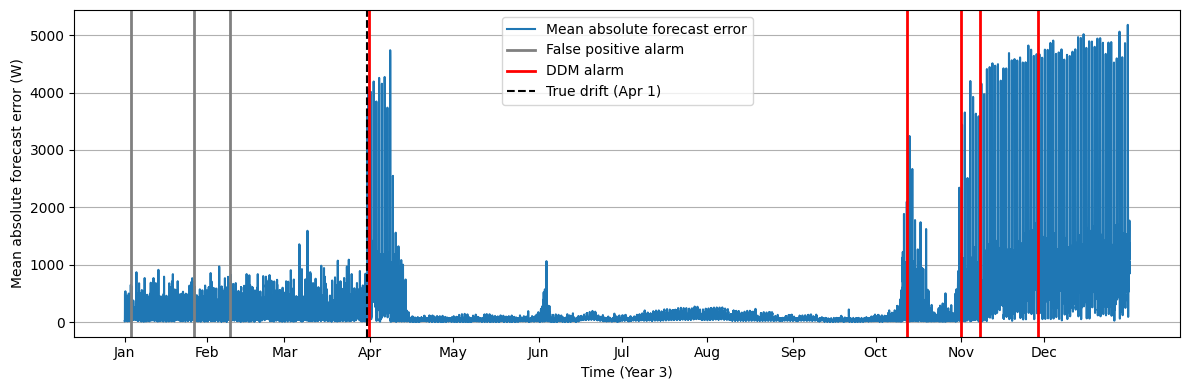

In [49]:
# ---- constants you already have ----
DRIFT_TS = 70_848_000          # Apr-1 in Year 3
H = HORIZON                     # 4
COOLDOWN_DAYS = 7              # fixed per your spec

# ---- use your existing helpers: errors_avg_abs(val_df) & month_ticks(mo_arr) ----
# errors_avg_abs(df_src) -> (e_bar, ts_labels, mo_labels) with baseline_model predictions

def ddm_run_with_cooldown(b_stream: np.ndarray, cooldown_steps: int, drift_threshold: float):
    """Run DDM with given drift_threshold; shared cooldown; ignore warnings."""
    ddm = drift.binary.DDM(drift_threshold=drift_threshold)
    states = np.array(["normal"] * len(b_stream), dtype=object)
    drift_idx, cooldown = [], 0
    for i, x in enumerate(b_stream):
        ddm.update(int(x))
        if cooldown > 0:
            states[i] = "cooldown"
            cooldown -= 1
            continue
        if ddm.drift_detected:
            states[i] = "drift"
            drift_idx.append(i)
            cooldown = cooldown_steps
    return {"states": states, "drift_idx": drift_idx}

def _cooldown_steps_from_ts(ts_labels: np.ndarray, days: int) -> int:
    if ts_labels.size >= 2 and np.all(np.isfinite(ts_labels)):
        dt_sec = float(np.median(np.diff(ts_labels)))
        steps_per_day = max(1, int(round(24 * 3600 / dt_sec)))
    else:
        steps_per_day = 96  # fallback for 15-min cadence
    return days * steps_per_day, (steps_per_day * 24 * 3600) // steps_per_day  # second value not used; kept simple

def ddm_grid_search(val_df_nodrift: pd.DataFrame,
                    y3_df_drifted: pd.DataFrame,
                    k_list = (0.5, 1.0, 1.5, 2.0),
                    ocl_list = (2.0, 2.5, 3.0, 3.5)) -> dict:
    # --- 1) Calibrate Ethr on NO-DRIFT validation ---
    e_val, _, _ = errors_avg_abs(val_df_nodrift)     # averaged abs error per window (orig units)
    MAE_val = float(e_val.mean())
    Q1, Q3  = np.percentile(e_val, [25, 75])
    IQR     = Q3 - Q1

    # --- 2) Build Year-3 error stream & metadata ---
    e_y3, ts_y3, mo_y3 = errors_avg_abs(y3_df_drifted)
    cooldown_steps, _ = _cooldown_steps_from_ts(ts_y3, COOLDOWN_DAYS)

    # index at/after true drift time
    tau_idx = int(np.searchsorted(ts_y3, DRIFT_TS, side="left"))

    # --- 3) Grid search ---
    rows = []
    per_setting_results = {}  # keep detailed runs for later plotting of the best
    for k in k_list:
        Ethr = MAE_val + k * IQR
        b_stream = (e_y3 > Ethr).astype(int)
        for ocl in ocl_list:
            run = ddm_run_with_cooldown(b_stream, cooldown_steps, drift_threshold=ocl)

            # False positives: all drifts with timestamp < Apr-1
            fp = 0
            first_post_drift_delay_h = np.inf
            if len(run["drift_idx"]):
                ts_drift = ts_y3[np.array(run["drift_idx"], dtype=int)]
                fp = int(np.sum(ts_drift < DRIFT_TS))
                # first drift at/after Apr-1:
                post_mask = ts_drift >= DRIFT_TS
                if np.any(post_mask):
                    first_post_ts = float(ts_drift[post_mask][0])
                    # delay in hours
                    first_post_drift_delay_h = (first_post_ts - DRIFT_TS) / 3600.0

            rows.append({
                "k": k,
                "drift_threshold": ocl,
                "Ethr": Ethr,
                "false_positives": fp,
                "detection_delay_hours": first_post_drift_delay_h,
                "total_drifts": len(run["drift_idx"])
            })
            per_setting_results[(k, ocl)] = {
                "run": run,
                "Ethr": Ethr,
                "e_y3": e_y3,
                "ts_y3": ts_y3,
                "mo_y3": mo_y3,
                "tau_idx": tau_idx,
                "cooldown_steps": cooldown_steps
            }

    summary = pd.DataFrame(rows)
    # rank: fewer FPs first, then shorter delay
    summary = summary.sort_values(by=["false_positives", "detection_delay_hours", "total_drifts"]).reset_index(drop=True)

    best_row = summary.iloc[0].to_dict()
    best_key = (best_row["k"], best_row["drift_threshold"])
    best_detail = per_setting_results[best_key]

    return {
        "summary": summary,
        "best": best_row,
        "best_detail": best_detail
    }

def plot_y3_best(best_detail: dict, title_prefix: str = "DDM Year 3 (best)"):
    e_y3 = best_detail["e_y3"]
    ts_y3 = best_detail["ts_y3"]
    mo_y3 = best_detail["mo_y3"]
    tau_idx = best_detail["tau_idx"]
    run = best_detail["run"]

    # map months to xticks
    idxs = np.arange(len(e_y3))
    # month_ticks is your existing helper that returns (positions, labels) from month array
    xt, _ = month_ticks(mo_y3)

    # --- UPDATED PLOTTING ONLY: derive month names from month column ---
    import calendar
    xt = np.asarray(xt, dtype=int)
    mo_at_ticks = np.asarray(mo_y3)[xt]
    xl = [calendar.month_abbr[int(m)] if 1 <= int(m) <= 12 else str(m) for m in mo_at_ticks]
    # ------------------------------------------------------------------

    plt.figure(figsize=(12,4))
    plt.plot(idxs, e_y3, label="Mean absolute forecast error")

    # --- UPDATED PLOTTING ONLY: false positives in gray/black ---
    fp_labeled = False
    drift_labeled = False
    for i in run["drift_idx"]:
        if int(i) < int(tau_idx):
            plt.axvline(i, color="gray", linestyle="-", linewidth=2.0,
                        label="False positive alarm" if not fp_labeled else None)
            fp_labeled = True
        else:
            plt.axvline(i, color="red", linestyle="-", linewidth=2.0,
                        label="Drift alarm" if not drift_labeled else None)
            drift_labeled = True
    # ------------------------------------------------------------------

    plt.axvline(tau_idx, color="black", linestyle="--", linewidth=1.5, label="True drift (Apr 1)")
    plt.xticks(xt, xl)
    plt.xlabel("Time (Year 3)")
    plt.ylabel("Mean absolute forecast error (W)")
    plt.title("")
    plt.grid(True, axis='y')
    plt.legend()
    plt.tight_layout()
    plt.show()

# =================== RUN THE GRID SEARCH ===================
# val_df: your no-drift validation (e.g., last 30% of Y1–Y3 no-drift)
# y3_df: drifted Year 3
if 'val_df' not in globals():
    nodrift_y123 = df_nodrift[df_nodrift['year'].isin([1,2,3])].reset_index(drop=True)
    split_idx = int(0.7 * len(nodrift_y123))
    val_df = nodrift_y123.iloc[split_idx:].reset_index(drop=True)

y3_df = df_drift[df_drift['year'] == 3].reset_index(drop=True)

res = ddm_grid_search(
    val_df_nodrift=val_df,
    y3_df_drifted=y3_df,
    k_list=(0.5, 1.0, 1.5, 2.0),
    ocl_list=(2.0, 2.5, 3.0, 3.5)
)

print("\n=== DDM Grid Summary (sorted) ===")
display(res["summary"])
print("\nBest:", res["best"])

# Optional: plot Year 3 with the best setting’s drifts overlaid
best_detail = res["best_detail"]
# If you want a cleaner title line, print k and ocl:
best_k = res["best"]["k"]; best_ocl = res["best"]["drift_threshold"]
# Re-run best with explicit title
idxs = np.arange(len(best_detail["e_y3"]))
xt, _ = month_ticks(best_detail["mo_y3"])

# --- UPDATED PLOTTING ONLY: derive month names from month column ---
import calendar
xt = np.asarray(xt, dtype=int)
mo_at_ticks = np.asarray(best_detail["mo_y3"])[xt]
xl = [calendar.month_abbr[int(m)] if 1 <= int(m) <= 12 else str(m) for m in mo_at_ticks]
# ------------------------------------------------------------------

plt.figure(figsize=(12,4))
plt.plot(idxs, best_detail["e_y3"], label="Mean absolute forecast error")

fp_labeled = False
drift_labeled = False
for i in best_detail["run"]["drift_idx"]:
    if int(i) < int(best_detail["tau_idx"]):
        plt.axvline(i, color="gray", linestyle="-", linewidth=2.0,
                    label="False positive alarm" if not fp_labeled else None)
        fp_labeled = True
    else:
        plt.axvline(i, color="red", linestyle="-", linewidth=2.0,
                    label="DDM alarm" if not drift_labeled else None)
        drift_labeled = True

plt.axvline(best_detail["tau_idx"], color="black", linestyle="--", linewidth=1.5, label="True drift (Apr 1)")
plt.xticks(xt, xl)
plt.xlabel("Time (Year 3)")
plt.ylabel("Mean absolute forecast error (W)")
plt.title("")
plt.grid(True, axis='y')
plt.legend()
plt.tight_layout()

# SAVE BEFORE SHOW [web:742]
plt.savefig("/kaggle/working/RetrofitYear3DDM.pdf", format="pdf", bbox_inches="tight")  # [web:634]

plt.show()


In [46]:
def compute_recovery_speeds_y3_mae(
    mae3_base_roll: np.ndarray,
    mae_adapt_roll: np.ndarray,
    drift_hits: list,
    steps_per_day: int,
    ts3_lab: np.ndarray,
    K_days: float = 1.0,      # consistency length in days
    eps_abs: float = 0.0,     # absolute tolerance (same units as MAE)
    eps_rel: float = 0.0      # relative tolerance (e.g., 0.05 == 5%)
) -> pd.DataFrame:
    """
    Recovery = earliest t >= drift such that (adapted MAE <= baseline MAE + tolerance)
               holds for K consecutive windows, where K = round(K_days * steps_per_day).

    Returns a DataFrame with one row per drift.
    """
    base = np.asarray(mae3_base_roll, dtype=float)
    adap = np.asarray(mae_adapt_roll, dtype=float)
    assert base.shape == adap.shape, "Rolling series must align."

    N = len(base)
    K = max(1, int(round(K_days * steps_per_day)))
    hours_per_step = 24.0 / float(steps_per_day)

    # Valid (rolling means often start with NaNs)
    valid = np.isfinite(base) & np.isfinite(adap)

    # Per-step tolerance: max(eps_abs, eps_rel * baseline)
    tol = np.maximum(eps_abs, eps_rel * base)

    # “Good” when adapted is at least as good as baseline within tolerance
    good = (adap - base) <= tol
    good &= valid

    # Fast K-consecutive True check via prefix sums
    good_int = good.astype(np.int32)
    csum = np.cumsum(good_int, dtype=np.int64)

    rows = []
    for d in drift_hits:
        # Safety if drift index outside range
        if d >= N:
            rows.append({
                "drift_idx": d, "drift_time": np.nan, "recovered": False,
                "t_rec_idx": np.nan, "t_rec_time": np.nan,
                "recov_steps": np.nan, "recov_hours": np.nan, "recov_days": np.nan,
                "K_windows": K, "eps_abs": eps_abs, "eps_rel": eps_rel
            })
            continue

        # Start at first valid rolling index >= drift
        start = int(d)
        while start < N and not valid[start]:
            start += 1

        if start >= N or (N - start) < K:
            rows.append({
                "drift_idx": d,
                "drift_time": ts3_lab[d] if d < len(ts3_lab) else np.nan,
                "recovered": False,
                "t_rec_idx": np.nan,
                "t_rec_time": np.nan,
                "recov_steps": np.nan,
                "recov_hours": np.nan,
                "recov_days": np.nan,
                "K_windows": K,
                "eps_abs": eps_abs,
                "eps_rel": eps_rel
            })
            continue

        # Earliest t with K consecutive True in `good`
        t_rec = None
        t_last = N - K
        for t in range(start, t_last + 1):
            win_sum = csum[t + K - 1] - (csum[t - 1] if t > 0 else 0)
            if win_sum == K:
                t_rec = t
                break

        if t_rec is None:
            rows.append({
                "drift_idx": d,
                "drift_time": ts3_lab[d] if d < len(ts3_lab) else np.nan,
                "recovered": False,
                "t_rec_idx": np.nan,
                "t_rec_time": np.nan,
                "recov_steps": np.nan,
                "recov_hours": np.nan,
                "recov_days": np.nan,
                "K_windows": K,
                "eps_abs": eps_abs,
                "eps_rel": eps_rel
            })
        else:
            rec_steps = t_rec - d
            rows.append({
                "drift_idx": d,
                "drift_time": ts3_lab[d] if d < len(ts3_lab) else np.nan,
                "recovered": True,
                "t_rec_idx": t_rec,
                "t_rec_time": ts3_lab[t_rec] if t_rec < len(ts3_lab) else np.nan,
                "recov_steps": rec_steps,
                "recov_hours": rec_steps * hours_per_step,
                "recov_days": rec_steps / float(steps_per_day),
                "K_windows": K,
                "eps_abs": eps_abs,
                "eps_rel": eps_rel
            })

    return pd.DataFrame(rows)


In [37]:
# # ================== CONFIG ==================
# PRETRAIN_LR   = 0.0007509794596043137
# FT_LR         = PRETRAIN_LR / 10.0     # exact 1/10
# FT_DAYS       = 7
# FT_EPOCHS     = 5
# FT_BATCH      = 41
# FT_PATIENCE   = 2
# ROLL_DAYS     = 1
# COOLDOWN_DAYS = 7
# ONLY_AFTER_TS = 70_848_000              # Apr-1 Year 3 (seconds)
# H             = HORIZON

# BEST_K            = 2.0                 # from your DDM grid search
# BEST_DDM_DRIFT_TH = 3.5                 # drift_threshold from your DDM grid search

# # ============ Small helpers ============
# import numpy as np, pandas as pd, matplotlib.pyplot as plt
# from river import drift

# def _label_rows(n_full, lookback, horizon):
#     return (np.arange(lookback, n_full - horizon + 1) + (horizon - 1))

# def _build_year_windows(df_year: pd.DataFrame):
#     X = df_year[FEATS].to_numpy(float)
#     Xs = X_scaler.transform(X)
#     ys = Xs[:, idx_t].copy()
#     Xw, Yw = make_windows_multi(Xs, ys, LOOKBACK, H, stride=1)
#     n_full = len(df_year)
#     lbl_idx = _label_rows(n_full, LOOKBACK, H)
#     ts_lab  = df_year.iloc[lbl_idx]['timestamp_sec'].to_numpy()
#     mo_lab  = df_year.iloc[lbl_idx]['month'].to_numpy()
#     return Xw, Yw, ts_lab, mo_lab, lbl_idx

# def _predict_unscaled(model, Xw, Yw):
#     Y_hat_s = model.predict(Xw, verbose=0)
#     Y_true  = inv_steps_from_X_scaler(Yw,     X_scaler, idx_t, H)
#     Y_hat   = inv_steps_from_X_scaler(Y_hat_s, X_scaler, idx_t, H)
#     return Y_true, Y_hat

# def _window_mae(y_true_row, y_hat_row):
#     return float(np.mean(np.abs(y_true_row - y_hat_row)))

# def _window_rmse(y_true_row, y_hat_row):
#     return float(np.sqrt(np.mean((y_true_row - y_hat_row)**2)))

# def _window_smape(y_true_row, y_hat_row, eps=1e-6):
#     num = np.abs(y_true_row - y_hat_row)
#     den = (np.abs(y_true_row) + np.abs(y_hat_row)).clip(min=eps)
#     return float(np.mean(2.0 * num / den) * 100.0)  # sMAPE in %

# def _rolling_mean(values, k):
#     if k <= 1:
#         return values.astype(float)
#     out = np.full(len(values), np.nan, float)
#     if len(values) >= k:
#         csum = np.cumsum(values, dtype=float)
#         out[k-1:] = (csum[k-1:] - np.concatenate(([0.0], csum[:-k])))/k
#     return out

# def _steps_per_day_from_labels(ts_labels):
#     if ts_labels.size >= 2 and np.isfinite(ts_labels).all():
#         dt_sec = float(np.median(np.diff(ts_labels)))
#     else:
#         dt_sec = 15*60
#     return max(1, int(round((24*3600)/dt_sec))), dt_sec

# def _month_ticks(months_arr):
#     starts, labels, seen = [], [], set()
#     for i, m in enumerate(months_arr):
#         if m not in seen:
#             starts.append(i); labels.append(f"M{int(m):02d}"); seen.add(m)
#     return np.array(starts), labels

# def _compute_recovery_indices(base_roll, adapt_roll, consec):
#     """Earliest r>=d for each drift d s.t. adapted<=baseline for 'consec' consecutive windows."""
#     N = len(base_roll)
#     rec = []
#     for d in ddm_all_drifts:  # we’ll pass ddm_all_drifts defined later
#         r = None; cnt = 0
#         i = max(0, d)
#         while i < N:
#             a, b = adapt_roll[i], base_roll[i]
#             if np.isfinite(a) and np.isfinite(b) and (a <= b):
#                 cnt += 1
#                 if cnt >= consec:
#                     r = i - consec + 1
#                     break
#             else:
#                 cnt = 0
#             i += 1
#         rec.append((d, r))
#     return rec

# # ===== 1) Calibrate Ethr on NO-DRIFT VALIDATION (MAE, with k = BEST_K) =====
# X_val = X_scaler.transform(val_df[FEATS].to_numpy(float))
# y_val = X_val[:, idx_t].copy()
# Xv_win, Yv_win = make_windows_multi(X_val, y_val, LOOKBACK, H, 1)
# Yv_true, Yv_hat = _predict_unscaled(baseline_model, Xv_win, Yv_win)
# e_bar_val = np.mean(np.abs(Yv_true - Yv_hat), axis=1)  # MAE per window

# MAE_bar = float(e_bar_val.mean())
# Q1, Q3  = np.percentile(e_bar_val, [25, 75])
# IQR     = (Q3 - Q1)
# Ethr    = MAE_bar + BEST_K * IQR
# print(f"[DDM calibration] Ethr (MAE): mean={MAE_bar:.3f}, Q1={Q1:.3f}, Q3={Q3:.3f}, k={BEST_K} -> Ethr={Ethr:.3f}")

# # ===== 2) Build Year 3 (drifted) stream =====
# y3_df = df_drift[df_drift['year'] == 3].reset_index(drop=True)
# X3_win, Y3_win, ts3_lab, mo3_lab, _ = _build_year_windows(y3_df)
# steps_per_day, dt_sec = _steps_per_day_from_labels(ts3_lab)
# roll_steps    = ROLL_DAYS   * steps_per_day
# ft_steps      = FT_DAYS     * steps_per_day
# cooldown_steps= COOLDOWN_DAYS * steps_per_day
# tau_idx       = int(np.searchsorted(ts3_lab, ONLY_AFTER_TS, side="left"))

# # Baseline truth & preds once (for baseline errors and binary stream)
# Y3_true_base, Y3_hat_base = _predict_unscaled(baseline_model, X3_win, Y3_win)

# # Per-window baseline “normal” errors
# mae3_base_win  = np.array([_window_mae (Y3_true_base[i], Y3_hat_base[i]) for i in range(len(X3_win))])
# rmse3_base_win = np.array([_window_rmse(Y3_true_base[i], Y3_hat_base[i]) for i in range(len(X3_win))])
# smape3_base_win= np.array([_window_smape(Y3_true_base[i], Y3_hat_base[i]) for i in range(len(X3_win))])

# # Rolling MAE for baseline (for the only plot)
# mae3_base_roll = _rolling_mean(mae3_base_win, roll_steps)

# # Binary exceedance stream for DDM (fixed; from baseline MAE windows)
# b_stream = (mae3_base_win > Ethr).astype(int)

# # ===== 3) Online loop: ALWAYS update DDM; 7d cooldown for counting; adapt only post-Apr-1 =====
# ddm = drift.binary.DDM(drift_threshold=BEST_DDM_DRIFT_TH)

# # fine-tuning optimizer (1/10 pretrain LR)
# orig_opt_cfg = tf.keras.optimizers.serialize(ddm_model.optimizer)
# ddm_model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=FT_LR),
#     loss=ddm_model.loss,
#     metrics=[m for m in ddm_model.metrics if getattr(m, 'name','') != 'loss']
# )

# # Streaming collections for ADAPTIVE “normal” errors
# mae_adapt_win_list   = []
# rmse_adapt_win_list  = []
# smape_adapt_win_list = []

# # Drift bookkeeping
# ddm_all_drifts   = []     # counted alarms with 7d cooldown (pre+post Apr)
# adapt_drift_hits = []     # alarms we actually adapt on (post Apr & not in cooldown)
# last_alarm_idx   = -10**12
# adapt_cooldown   = 0

# for i in range(len(X3_win)):
#     # (A) Predict with current adapted model (streaming)
#     yhat_s   = ddm_model.predict(X3_win[i:i+1], verbose=0)[0]
#     y_true_r = inv_steps_from_X_scaler(Y3_win[i:i+1], X_scaler, idx_t, H)
#     y_hat_r  = inv_steps_from_X_scaler(yhat_s.reshape(1,-1), X_scaler, idx_t, H)

#     mae_adapt_win_list.append  (_window_mae  (y_true_r[0], y_hat_r[0]))
#     rmse_adapt_win_list.append (_window_rmse (y_true_r[0], y_hat_r[0]))
#     smape_adapt_win_list.append(_window_smape(y_true_r[0], y_hat_r[0]))

#     # (B) Always update the detector (so pre-Apr FPs are counted)
#     ddm.update(int(b_stream[i]))

#     # (C) Count alarms with 7d cooldown (same semantics as in tuning)
#     if ddm.drift_detected and (i - last_alarm_idx) >= cooldown_steps:
#         ddm_all_drifts.append(i)
#         last_alarm_idx = i

#         # (D) Adaptation gate: only after Apr-1 and not in adaptation cooldown
#         if ts3_lab[i] >= ONLY_AFTER_TS and adapt_cooldown == 0:
#             adapt_drift_hits.append(i)

#             # Fine-tune on last FT_DAYS windows ending at i
#             s   = max(0, i - ft_steps + 1)
#             Xft = X3_win[s:i+1]
#             Yft = Y3_win[s:i+1]
#             if len(Xft) >= 10:
#                 es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=FT_PATIENCE, restore_best_weights=True)
#                 ddm_model.fit(
#                     Xft, Yft,
#                     validation_split=0.1,
#                     epochs=FT_EPOCHS,
#                     batch_size=FT_BATCH,
#                     shuffle=True,
#                     verbose=0,
#                     callbacks=[es]
#                 )
#             adapt_cooldown = cooldown_steps  # start adaptation cooldown

#     # tick down adaptation cooldown
#     if adapt_cooldown > 0:
#         adapt_cooldown -= 1

# # Restore original optimizer if you prefer
# ddm_model.compile(
#     optimizer=tf.keras.optimizers.deserialize(orig_opt_cfg),
#     loss=ddm_model.loss,
#     metrics=[m for m in ddm_model.metrics if getattr(m, 'name','') != 'loss']
# )

# # ===== 4) Recovery speed (MAE-based, rolling) =====
# # rolling MAE of adaptive model from streamed errors only
# mae_adapt_win  = np.array(mae_adapt_win_list, float)
# mae_adapt_roll = _rolling_mean(mae_adapt_win, roll_steps)

# # compute recovery: first index where adapted rolling MAE <= baseline rolling MAE
# # for 'roll_steps' consecutive windows (≈ 1 day)
# recovery_pairs = _compute_recovery_indices(mae3_base_roll, mae_adapt_roll, roll_steps)
# # Make a readable DataFrame
# def _idx_to_hours(idx): 
#     return np.nan if (idx is None) else (idx * dt_sec / 3600.0)
# recovery_df = pd.DataFrame([
#     {
#         "drift_idx": d,
#         "recovery_idx": r if r is not None else -1,
#         "recovery_hours": _idx_to_hours(r - d) if (r is not None) else np.inf,
#         "post_Apr": bool(ts3_lab[d] >= ONLY_AFTER_TS)
#     }
#     for (d, r) in recovery_pairs
# ])

# # ===== 5) Aggregate comparison table (Year 3, streaming) =====
# mae_base_mean   = float(mae3_base_win.mean())
# rmse_base_mean  = float(rmse3_base_win.mean())
# smape_base_mean = float(smape3_base_win.mean())

# mae_adpt_mean   = float(np.mean(mae_adapt_win_list))
# rmse_adpt_mean  = float(np.mean(rmse_adapt_win_list))
# smape_adpt_mean = float(np.mean(smape_adapt_win_list))

# metrics_table = pd.DataFrame(
#     {
#         "MAE_mean":   [mae_base_mean,  mae_adpt_mean],
#         "RMSE_mean":  [rmse_base_mean, rmse_adpt_mean],
#         "sMAPE_mean%":[smape_base_mean, smape_adpt_mean],
#     },
#     index=["Baseline", "Adaptive-DDM"]
# )
# print("\n=== Year 3 aggregate error table (means over streaming windows) ===")
# display(metrics_table)

# # Drift summary too (optional, handy)
# fp_count   = sum(ts3_lab[idx] < ONLY_AFTER_TS for idx in ddm_all_drifts)
# post_hits  = [i for i in ddm_all_drifts if i >= tau_idx]
# first_post = post_hits[0] if len(post_hits) else None
# delay_h    = ((first_post - tau_idx) * (dt_sec / 3600.0)) if first_post is not None else float('inf')

# summary_table = pd.DataFrame([{
#     "count_all_drifts":      len(ddm_all_drifts),
#     "false_positives":       fp_count,
#     "adapt_drift_hits":      len(adapt_drift_hits),
#     "first_post_drift_idx":  (first_post if first_post is not None else -1),
#     "detection_delay_hours": (delay_h if np.isfinite(delay_h) else None)
# }])
# print("\n=== DDM drift summary (Year 3) ===")
# display(summary_table)

# print("\n=== Recovery summary (hours) — consecutive window rule = 1 day ===")
# display(recovery_df)

# # ===== 6) The ONLY plot: rolling MAE (baseline vs adaptive) =====
# xticks, xlabels = _month_ticks(mo3_lab)
# plt.figure(figsize=(12,4))
# plt.plot(mae3_base_roll,  label=f"Baseline rolling MAE ({ROLL_DAYS}d)")
# plt.plot(mae_adapt_roll,  label=f"DDM-adapted rolling MAE ({ROLL_DAYS}d)")
# for k, di in enumerate(ddm_all_drifts):
#     color = "red" if ts3_lab[di] >= ONLY_AFTER_TS else "tab:gray"
#     lab = "DDM drift (counted)" if (k == 0 and color == "red") else None
#     plt.axvline(di, color=color, linestyle="-", linewidth=1.5, alpha=0.85, label=lab)
# plt.axvline(tau_idx, color="black", linestyle="--", linewidth=1.2, label="Apr-1 (ground truth)")
# plt.xticks(xticks, xlabels)
# plt.xlabel("Month (Year 3)"); plt.ylabel("Rolling MAE")
# plt.title("Online adaptation (DDM): rolling MAE during Year 3")
# plt.grid(True, axis='y'); plt.legend(); plt.tight_layout(); plt.show()


[DDM calibration] Ethr (MAE): mean=137.923, Q1=41.125, Q3=173.187, k=2.0 -> Ethr=402.048

=== Year 3 aggregate error table (means over streaming windows) ===


MAE_mean  RMSE_mean      MAPE_mean%  sMAPE_mean%  WAPE_mean%
Baseline         255.1      289.1 7,817,854,984.2        134.5        17.6
Adaptive-DDM     145.2      168.6 5,666,028,387.7        131.1        10.0


=== Year 3 global error table (flattened over all windows x horizons) ===


MAE_global  RMSE_global    MAPE_global%  sMAPE_global%  \
Baseline           255.1        727.8 7,817,854,984.2          134.5   
Adaptive-DDM       145.2        413.1 5,666,028,387.7          131.1   

              WAPE_global%  
Baseline              17.6  
Adaptive-DDM          10.0


=== Year 3 — Per-horizon metrics (MAE, RMSE, sMAPE%) ===


horizon  MAE_base  MAE_adapt  RMSE_base  RMSE_adapt      MAPE%_base  \
0     t+1     223.0      115.0      783.5       379.4 6,569,723,975.9   
1     t+2     232.2      134.9      653.9       381.7 7,295,610,369.1   
2     t+3     270.8      157.0      746.1       448.4 8,528,011,124.3   
3     t+4     294.4      174.0      721.6       438.0 8,878,074,467.5   

      MAPE%_adapt  sMAPE%_base  sMAPE%_adapt  
0 4,614,305,132.8        132.9         129.4  
1 5,667,079,890.0        134.1         130.7  
2 6,136,282,906.5        135.0         131.6  
3 6,246,445,621.7        135.8         132.6


=== DDM drift summary (Year 3) ===


count_all_drifts  adapt_drift_hits  first_post_drift_idx  \
0                 8                 5                  8493   

   detection_delay_hours  
0                   14.5


=== Recovery summary — consecutive window rule = 1 day ===


drift_idx  recovery_idx  post_Apr
0        235          1356     False
1       2423          2716     False
2       3665          4205     False
3       8493          8557      True
4      27188         27188      True
5      29059         29059      True
6      29739         29739      True
7      31754         31754      True

NameError: name 'xticks' is not defined

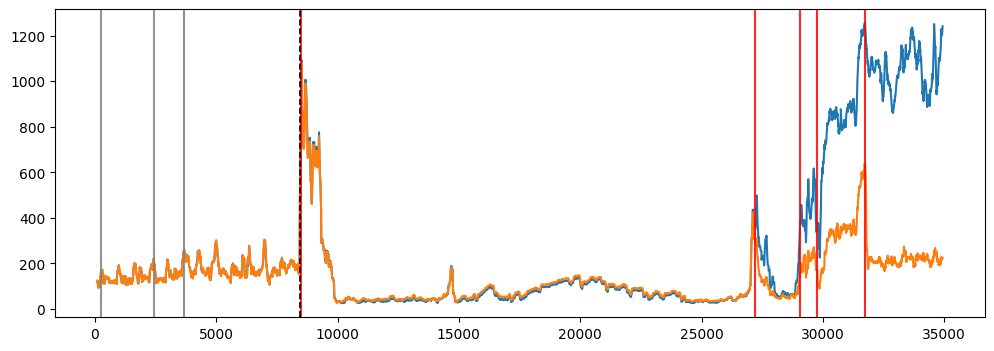

In [47]:
# ================== CONFIG ==================
PRETRAIN_LR   = 0.0007509794596043137
FT_LR         = PRETRAIN_LR / 10.0     # exact 1/10
FT_DAYS       = 7
FT_EPOCHS     = 5
FT_BATCH      = 41
FT_PATIENCE   = 2
ROLL_DAYS     = 1
COOLDOWN_DAYS = 7
ONLY_AFTER_TS = 70_848_000              # Apr-1 Year 3 (seconds)
H             = HORIZON

BEST_K            = 2.0                 # from your DDM grid search
BEST_DDM_DRIFT_TH = 3.5                 # drift_threshold from your DDM grid search

# ============ Small helpers ============

def _label_rows(n_full, lookback, horizon):
    return (np.arange(lookback, n_full - horizon + 1) + (horizon - 1))

def _build_year_windows(df_year: pd.DataFrame):
    X = df_year[FEATS].to_numpy(float)
    Xs = X_scaler.transform(X)
    ys = Xs[:, idx_t].copy()
    Xw, Yw = make_windows_multi(Xs, ys, LOOKBACK, H, stride=1)
    n_full = len(df_year)
    lbl_idx = _label_rows(n_full, LOOKBACK, H)
    ts_lab  = df_year.iloc[lbl_idx]['timestamp_sec'].to_numpy()
    mo_lab  = df_year.iloc[lbl_idx]['month'].to_numpy()
    return Xw, Yw, ts_lab, mo_lab, lbl_idx

def _predict_unscaled(model, Xw, Yw):
    Y_hat_s = model.predict(Xw, verbose=0)
    Y_true  = inv_steps_from_X_scaler(Yw,     X_scaler, idx_t, H)
    Y_hat   = inv_steps_from_X_scaler(Y_hat_s, X_scaler, idx_t, H)
    return Y_true, Y_hat

def _window_mae(y_true_row, y_hat_row):
    return float(np.mean(np.abs(y_true_row - y_hat_row)))

def _window_rmse(y_true_row, y_hat_row):
    return float(np.sqrt(np.mean((y_true_row - y_hat_row)**2)))

def _window_smape(y_true_row, y_hat_row, eps=1e-6):
    num = np.abs(y_true_row - y_hat_row)
    den = (np.abs(y_true_row) + np.abs(y_hat_row)).clip(min=eps)
    return float(np.mean(2.0 * num / den) * 100.0)  # sMAPE in %

# -------------------- ADDED: MAPE helpers --------------------
def _window_mape(y_true_row, y_hat_row, eps=1e-6):
    den = np.maximum(np.abs(y_true_row), eps)
    return float(np.mean(np.abs((y_true_row - y_hat_row) / den)) * 100.0)  # MAPE in %

def _per_horizon_mape(y_true_2d, y_hat_2d, eps=1e-6):
    Hh = y_true_2d.shape[1]
    vals = []
    for h in range(Hh):
        den = np.maximum(np.abs(y_true_2d[:, h]), eps)
        vals.append(float(np.mean(np.abs((y_true_2d[:, h] - y_hat_2d[:, h]) / den)) * 100.0))
    return vals
# ------------------------------------------------------------

def _rolling_mean(values, k):
    if k <= 1:
        return values.astype(float)
    out = np.full(len(values), np.nan, float)
    if len(values) >= k:
        csum = np.cumsum(values, dtype=float)
        out[k-1:] = (csum[k-1:] - np.concatenate(([0.0], csum[:-k])))/k
    return out

def _steps_per_day_from_labels(ts_labels):
    if ts_labels.size >= 2 and np.isfinite(ts_labels).all():
        dt_sec = float(np.median(np.diff(ts_labels)))
    else:
        dt_sec = 15*60
    return max(1, int(round((24*3600)/dt_sec))), dt_sec

def _month_ticks(months_arr):
    import calendar
    starts, labels, seen = [], [], set()
    for i, m in enumerate(months_arr):
        if m not in seen:
            starts.append(i)
            mm = int(m)
            labels.append(calendar.month_abbr[mm] if 1 <= mm <= 12 else str(m))
            seen.add(m)
    return np.array(starts), labels

def _compute_recovery_indices(base_roll, adapt_roll, consec):
    """Earliest r>=d for each drift d s.t. adapted<=baseline for 'consec' consecutive windows."""
    N = len(base_roll)
    rec = []
    for d in ddm_all_drifts:  # we’ll pass ddm_all_drifts defined later
        r = None; cnt = 0
        i = max(0, d)
        while i < N:
            a, b = adapt_roll[i], base_roll[i]
            if np.isfinite(a) and np.isfinite(b) and (a <= b):
                cnt += 1
                if cnt >= consec:
                    r = i - consec + 1
                    break
            else:
                cnt = 0
            i += 1
        rec.append((d, r))
    return rec

def _per_horizon_smape(y_true_2d, y_hat_2d, eps=1e-6):
    Hh = y_true_2d.shape[1]
    vals = []
    for h in range(Hh):
        num = np.abs(y_true_2d[:, h] - y_hat_2d[:, h])
        den = (np.abs(y_true_2d[:, h]) + np.abs(y_hat_2d[:, h])).clip(min=eps)
        vals.append(float(np.mean(2.0 * num / den) * 100.0))
    return vals


# ===== 1) Calibrate Ethr on NO-DRIFT VALIDATION (MAE, with k = BEST_K) =====
X_val = X_scaler.transform(val_df[FEATS].to_numpy(float))
y_val = X_val[:, idx_t].copy()
Xv_win, Yv_win = make_windows_multi(X_val, y_val, LOOKBACK, H, 1)
Yv_true, Yv_hat = _predict_unscaled(baseline_model, Xv_win, Yv_win)
e_bar_val = np.mean(np.abs(Yv_true - Yv_hat), axis=1)  # MAE per window

MAE_bar = float(e_bar_val.mean())
Q1, Q3  = np.percentile(e_bar_val, [25, 75])
IQR     = (Q3 - Q1)
Ethr    = MAE_bar + BEST_K * IQR
print(f"[DDM calibration] Ethr (MAE): mean={MAE_bar:.3f}, Q1={Q1:.3f}, Q3={Q3:.3f}, k={BEST_K} -> Ethr={Ethr:.3f}")

# ===== 2) Build Year 3 (drifted) stream =====
y3_df = df_drift[df_drift['year'] == 3].reset_index(drop=True)
X3_win, Y3_win, ts3_lab, mo3_lab, _ = _build_year_windows(y3_df)
steps_per_day, dt_sec = _steps_per_day_from_labels(ts3_lab)
roll_steps    = ROLL_DAYS   * steps_per_day
ft_steps      = FT_DAYS     * steps_per_day
cooldown_steps= COOLDOWN_DAYS * steps_per_day
tau_idx       = int(np.searchsorted(ts3_lab, ONLY_AFTER_TS, side="left"))

# Baseline truth & preds once (for baseline errors and binary stream)
Y3_true_base, Y3_hat_base = _predict_unscaled(baseline_model, X3_win, Y3_win)

# Per-window baseline “normal” errors
mae3_base_win   = np.array([_window_mae (Y3_true_base[i], Y3_hat_base[i]) for i in range(len(X3_win))])
rmse3_base_win  = np.array([_window_rmse(Y3_true_base[i], Y3_hat_base[i]) for i in range(len(X3_win))])
smape3_base_win = np.array([_window_smape(Y3_true_base[i], Y3_hat_base[i]) for i in range(len(X3_win))])
mape3_base_win  = np.array([_window_mape(Y3_true_base[i], Y3_hat_base[i]) for i in range(len(X3_win))])  # ADDED

# Rolling MAE for baseline (for the only plot)
mae3_base_roll = _rolling_mean(mae3_base_win, roll_steps)

# Binary exceedance stream for DDM (fixed; from baseline MAE windows)
b_stream = (mae3_base_win > Ethr).astype(int)

# ===== 3) Online loop: ALWAYS update DDM; 7d cooldown for counting; adapt only post-Apr-1 =====
ddm = drift.binary.DDM(drift_threshold=BEST_DDM_DRIFT_TH)

# fine-tuning optimizer (1/10 pretrain LR)
orig_opt_cfg = tf.keras.optimizers.serialize(ddm_model.optimizer)
ddm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FT_LR),
    loss=ddm_model.loss,
    metrics=[m for m in ddm_model.metrics if getattr(m, 'name','') != 'loss']
)

# Streaming collections for ADAPTIVE “normal” errors
mae_adapt_win_list    = []
rmse_adapt_win_list   = []
smape_adapt_win_list  = []
mape_adapt_win_list   = []  # ADDED

# --- ADDED (for per-horizon metrics): store step-vectors per window ---
Y3_true_adpt_list = []
Y3_hat_adpt_list  = []
# --------------------------------------------------------------------

# WAPE accumulators (over all streamed windows/steps)
wape_num_base  = float(np.sum(np.abs(Y3_true_base - Y3_hat_base)))
wape_den_base  = float(np.sum(np.abs(Y3_true_base)))
wape_num_adapt = 0.0
wape_den_adapt = 0.0

# Drift bookkeeping
ddm_all_drifts   = []     # counted alarms with 7d cooldown (pre+post Apr)
adapt_drift_hits = []     # alarms we actually adapt on (post Apr & not in cooldown)
last_alarm_idx   = -10**12
adapt_cooldown   = 0

for i in range(len(X3_win)):
    # (A) Predict with current adapted model (streaming)
    yhat_s   = ddm_model.predict(X3_win[i:i+1], verbose=0)[0]
    y_true_r = inv_steps_from_X_scaler(Y3_win[i:i+1], X_scaler, idx_t, H)
    y_hat_r  = inv_steps_from_X_scaler(yhat_s.reshape(1,-1), X_scaler, idx_t, H)

    # --- ADDED (for per-horizon metrics) ---
    Y3_true_adpt_list.append(y_true_r[0].copy())
    Y3_hat_adpt_list.append(y_hat_r[0].copy())
    # --------------------------------------

    mae_adapt_win_list.append   (_window_mae  (y_true_r[0], y_hat_r[0]))
    rmse_adapt_win_list.append  (_window_rmse (y_true_r[0], y_hat_r[0]))
    smape_adapt_win_list.append (_window_smape(y_true_r[0], y_hat_r[0]))
    mape_adapt_win_list.append  (_window_mape (y_true_r[0], y_hat_r[0]))  # ADDED

    # WAPE streaming update
    wape_num_adapt += float(np.sum(np.abs(y_true_r[0] - y_hat_r[0])))
    wape_den_adapt += float(np.sum(np.abs(y_true_r[0])))

    # (B) Always update the detector (so pre-Apr FPs are counted)
    ddm.update(int(b_stream[i]))

    # (C) Count alarms with 7d cooldown (same semantics as in tuning)
    if ddm.drift_detected and (i - last_alarm_idx) >= cooldown_steps:
        ddm_all_drifts.append(i)
        last_alarm_idx = i

        # (D) Adaptation gate: only after Apr-1 and not in adaptation cooldown
        if ts3_lab[i] >= ONLY_AFTER_TS and adapt_cooldown == 0:
            adapt_drift_hits.append(i)

            # Fine-tune on last FT_DAYS windows ending at i
            s   = max(0, i - ft_steps + 1)
            Xft = X3_win[s:i+1]
            Yft = Y3_win[s:i+1]
            if len(Xft) >= 10:
                es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=FT_PATIENCE, restore_best_weights=True)
                ddm_model.fit(
                    Xft, Yft,
                    validation_split=0.1,
                    epochs=FT_EPOCHS,
                    batch_size=FT_BATCH,
                    shuffle=True,
                    verbose=0,
                    callbacks=[es]
                )
            adapt_cooldown = cooldown_steps  # start adaptation cooldown

    # tick down adaptation cooldown
    if adapt_cooldown > 0:
        adapt_cooldown -= 1

# Restore original optimizer if you prefer
ddm_model.compile(
    optimizer=tf.keras.optimizers.deserialize(orig_opt_cfg),
    loss=ddm_model.loss,
    metrics=[m for m in ddm_model.metrics if getattr(m, 'name','') != 'loss']
)

# ===== 4) Recovery speed (MAE-based, rolling) =====
# rolling MAE of adaptive model from streamed errors only
mae_adapt_win  = np.array(mae_adapt_win_list, float)
mae_adapt_roll = _rolling_mean(mae_adapt_win, roll_steps)

# compute recovery: first index where adapted rolling MAE <= baseline rolling MAE
# for 'roll_steps' consecutive windows (≈ 1 day)
recovery_pairs = _compute_recovery_indices(mae3_base_roll, mae_adapt_roll, roll_steps)
# Make a readable DataFrame
def _idx_to_hours(idx):
    return np.nan if (idx is None) else (idx * dt_sec / 3600.0)

recovery_df = pd.DataFrame([
    {
        "drift_idx": d,
        "recovery_idx": r if r is not None else -1,
        "post_Apr": bool(ts3_lab[d] >= ONLY_AFTER_TS)
    }
    for (d, r) in recovery_pairs
])

# ===== 5) Aggregate comparison table (Year 3, streaming) =====
mae_base_mean    = float(mae3_base_win.mean())
rmse_base_mean   = float(rmse3_base_win.mean())
smape_base_mean  = float(smape3_base_win.mean())
mape_base_mean   = float(mape3_base_win.mean())  # ADDED

mae_adpt_mean    = float(np.mean(mae_adapt_win_list))
rmse_adpt_mean   = float(np.mean(rmse_adapt_win_list))
smape_adpt_mean  = float(np.mean(smape_adapt_win_list))
mape_adpt_mean   = float(np.mean(mape_adapt_win_list))  # ADDED

wape_base_pct = float((wape_num_base / max(wape_den_base, 1e-12)) * 100.0)
wape_adpt_pct = float((wape_num_adapt / max(wape_den_adapt, 1e-12)) * 100.0)

metrics_table = pd.DataFrame(
    {
        "MAE_mean":    [mae_base_mean,  mae_adpt_mean],
        "RMSE_mean":   [rmse_base_mean, rmse_adpt_mean],
        "MAPE_mean%":  [mape_base_mean, mape_adpt_mean],       # ADDED
        "sMAPE_mean%": [smape_base_mean, smape_adpt_mean],
        "WAPE_mean%":  [wape_base_pct,  wape_adpt_pct],
    },
    index=["Baseline", "Adaptive-DDM"]
)
print("\n=== Year 3 aggregate error table (means over streaming windows) ===")
display(metrics_table)

# -------------------- ADDED: Per-horizon metrics table --------------------
Y3_true_adpt = np.vstack(Y3_true_adpt_list)  # shape (n_windows, H)
Y3_hat_adpt  = np.vstack(Y3_hat_adpt_list)   # shape (n_windows, H)

# -------------------- ADDED: Global metrics table (flatten all windows x horizons) --------------------
_eps_g = 1e-6

_diff_base = (Y3_true_base - Y3_hat_base)
mae_base_global = float(np.mean(np.abs(_diff_base)))
rmse_base_global = float(np.sqrt(np.mean(_diff_base ** 2)))
_den_base = (np.abs(Y3_true_base) + np.abs(Y3_hat_base)).clip(min=_eps_g)
smape_base_global = float(np.mean(2.0 * np.abs(_diff_base) / _den_base) * 100.0)
# ADDED: global MAPE
mape_base_global = float(np.mean(np.abs(_diff_base) / np.maximum(np.abs(Y3_true_base), _eps_g)) * 100.0)

_diff_adpt = (Y3_true_adpt - Y3_hat_adpt)
mae_adpt_global = float(np.mean(np.abs(_diff_adpt)))
rmse_adpt_global = float(np.sqrt(np.mean(_diff_adpt ** 2)))
_den_adpt = (np.abs(Y3_true_adpt) + np.abs(Y3_hat_adpt)).clip(min=_eps_g)
smape_adpt_global = float(np.mean(2.0 * np.abs(_diff_adpt) / _den_adpt) * 100.0)
# ADDED: global MAPE
mape_adpt_global = float(np.mean(np.abs(_diff_adpt) / np.maximum(np.abs(Y3_true_adpt), _eps_g)) * 100.0)

global_metrics_table = pd.DataFrame(
    {
        "MAE_global":    [mae_base_global,  mae_adpt_global],
        "RMSE_global":   [rmse_base_global, rmse_adpt_global],
        "MAPE_global%":  [mape_base_global, mape_adpt_global],   # ADDED
        "sMAPE_global%": [smape_base_global, smape_adpt_global],
        "WAPE_global%":  [wape_base_pct,    wape_adpt_pct],
    },
    index=["Baseline", "Adaptive-DDM"]
)

print("\n=== Year 3 global error table (flattened over all windows x horizons) ===")
display(global_metrics_table)
# ------------------------------------------------------------------------------------------------------

H_eval = Y3_true_base.shape[1]

mae_base_h   = [mean_absolute_error(Y3_true_base[:, h], Y3_hat_base[:, h]) for h in range(H_eval)]
mae_adpt_h   = [mean_absolute_error(Y3_true_adpt[:, h], Y3_hat_adpt[:, h]) for h in range(H_eval)]

# RMSE per horizon: sqrt(MSE) explicitly (avoid squared=False deprecation) [web:2]
rmse_base_h  = [float(np.sqrt(mean_squared_error(Y3_true_base[:, h], Y3_hat_base[:, h]))) for h in range(H_eval)]
rmse_adpt_h  = [float(np.sqrt(mean_squared_error(Y3_true_adpt[:, h], Y3_hat_adpt[:, h]))) for h in range(H_eval)]

# ADDED: MAPE per horizon
mape_base_h  = _per_horizon_mape(Y3_true_base, Y3_hat_base)
mape_adpt_h  = _per_horizon_mape(Y3_true_adpt, Y3_hat_adpt)

smape_base_h = _per_horizon_smape(Y3_true_base, Y3_hat_base)
smape_adpt_h = _per_horizon_smape(Y3_true_adpt, Y3_hat_adpt)

per_horizon_tbl = pd.DataFrame({
    "horizon":      [f"t+{i+1}" for i in range(H_eval)],
    "MAE_base":     mae_base_h,
    "MAE_adapt":    mae_adpt_h,
    "RMSE_base":    rmse_base_h,
    "RMSE_adapt":   rmse_adpt_h,
    "MAPE%_base":   mape_base_h,     # ADDED
    "MAPE%_adapt":  mape_adpt_h,     # ADDED
    "sMAPE%_base":  smape_base_h,
    "sMAPE%_adapt": smape_adpt_h,
})

print("\n=== Year 3 — Per-horizon metrics (MAE, RMSE, sMAPE%) ===")
display(per_horizon_tbl)
# -------------------------------------------------------------------------


# Drift summary too (optional, handy)
fp_count   = sum(ts3_lab[idx] < ONLY_AFTER_TS for idx in ddm_all_drifts)
post_hits  = [i for i in ddm_all_drifts if i >= tau_idx]
first_post = post_hits[0] if len(post_hits) else None
delay_h    = ((first_post - tau_idx) * (dt_sec / 3600.0)) if first_post is not None else float('inf')

summary_table = pd.DataFrame([{
    "count_all_drifts":      len(ddm_all_drifts),
    "adapt_drift_hits":      len(adapt_drift_hits),
    "first_post_drift_idx":  (first_post if first_post is not None else -1),
    "detection_delay_hours": (delay_h if np.isfinite(delay_h) else None)
}])
print("\n=== DDM drift summary (Year 3) ===")
display(summary_table)

print("\n=== Recovery summary — consecutive window rule = 1 day ===")
display(recovery_df)

# ===== 6) The ONLY plot: rolling MAE (baseline vs adaptive) =====
# Decide which detections are real drifts vs false positives
# Option A (your current logic): anything before ONLY_AFTER_TS is a false positive
is_true = np.array([ts3_lab[di] >= ONLY_AFTER_TS for di in ddm_all_drifts])

true_drifts = [di for di, t in zip(ddm_all_drifts, is_true) if t]
false_pos   = [di for di, t in zip(ddm_all_drifts, is_true) if not t]

xticks, xlabels = _month_ticks(mo3_lab)
plt.figure(figsize=(12,4))

plt.plot(mae3_base_roll, label=f"Baseline (rolling MAE, {ROLL_DAYS} d)")
plt.plot(mae_adapt_roll, label=f"DDM-adapted (rolling MAE, {ROLL_DAYS} d)")

# False positives -> grey
fp_label = "False positive alarm"
for di in false_pos:
    plt.axvline(di, color="tab:gray", linestyle="-", linewidth=1.5, alpha=0.85, label=fp_label)
    fp_label = "_nolegend_"  # prevent repeated legend entries [web:971]

# True drifts -> red
td_label = "DDM alarm"
for di in true_drifts:
    plt.axvline(di, color="red", linestyle="-", linewidth=1.5, alpha=0.85, label=td_label)
    td_label = "_nolegend_"  # prevent repeated legend entries [web:971]

plt.axvline(tau_idx, color="black", linestyle="--", linewidth=1.2, label="True drift (Apr 1)")

plt.xticks(xticks, xlabels)
plt.xlabel("Time (Year 3)")
plt.ylabel("Rolling MAE (W)")
plt.title("")
plt.grid(True, axis="y")
plt.legend()
plt.tight_layout()

# SAVE BEFORE SHOW (to avoid empty output) [web:742][web:942]
plt.savefig("/kaggle/working/RetrofitYear3FinetuningDDM.pdf",
            format="pdf", bbox_inches="tight")

plt.show()
# 



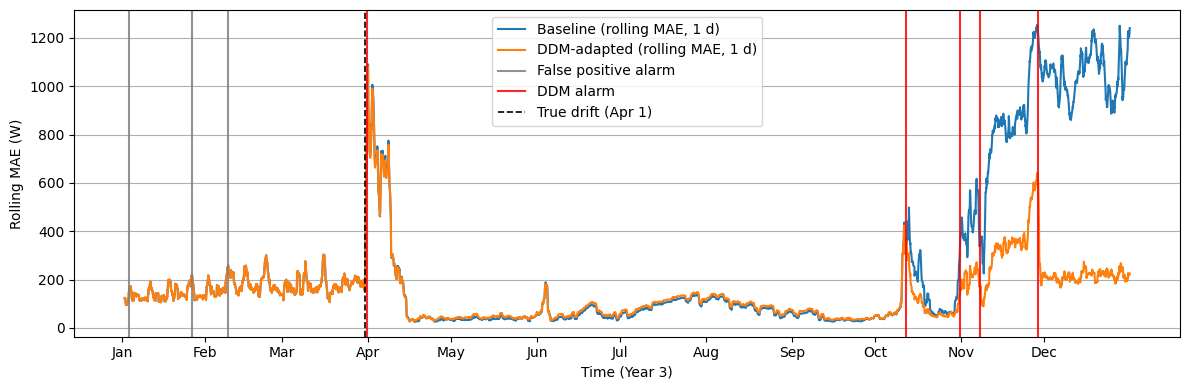

In [49]:
# # Decide which detections are real drifts vs false positives
# # Option A (your current logic): anything before ONLY_AFTER_TS is a false positive
# is_true = np.array([ts3_lab[di] >= ONLY_AFTER_TS for di in ddm_all_drifts])

# true_drifts = [di for di, t in zip(ddm_all_drifts, is_true) if t]
# false_pos   = [di for di, t in zip(ddm_all_drifts, is_true) if not t]

# xticks, xlabels = _month_ticks(mo3_lab)
# plt.figure(figsize=(12,4))

# plt.plot(mae3_base_roll, label=f"Baseline (rolling MAE, {ROLL_DAYS} d)")
# plt.plot(mae_adapt_roll, label=f"DDM-adapted (rolling MAE, {ROLL_DAYS} d)")

# # False positives -> grey
# fp_label = "False positive alarm"
# for di in false_pos:
#     plt.axvline(di, color="tab:gray", linestyle="-", linewidth=1.5, alpha=0.85, label=fp_label)
#     fp_label = "_nolegend_"  # prevent repeated legend entries [web:971]

# # True drifts -> red
# td_label = "DDM alarm"
# for di in true_drifts:
#     plt.axvline(di, color="red", linestyle="-", linewidth=1.5, alpha=0.85, label=td_label)
#     td_label = "_nolegend_"  # prevent repeated legend entries [web:971]

# plt.axvline(tau_idx, color="black", linestyle="--", linewidth=1.2, label="True drift (Apr 1)")

# plt.xticks(xticks, xlabels)
# plt.xlabel("Time (Year 3)")
# plt.ylabel("Rolling MAE (W)")
# plt.title("")
# plt.grid(True, axis="y")
# plt.legend()
# plt.tight_layout()

# # SAVE BEFORE SHOW (to avoid empty output) [web:742][web:942]
# plt.savefig("/kaggle/working/RetrofitYear3FinetuningDDM.pdf",
#             format="pdf", bbox_inches="tight")

# plt.show()


In [53]:
import numpy as np

# MAPE definition (with epsilon in denominator to avoid divide-by-zero):
# MAPE = 100 * mean( |(A - F) / max(|A|, eps)| )  [web:811]

def mape_eps(y_true, y_pred, mape_eps: float = 1.0):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.maximum(np.abs(y_true), float(mape_eps))
    return float(100.0 * np.mean(np.abs((y_true - y_pred) / denom)))  # [web:811]

# WAY A (same as eval_year): per-horizon MAPE, then average over horizons
def per_horizon_mape_and_avg(Y_true_2d, Y_pred_2d, mape_eps: float = 1.0):
    Y_true_2d = np.asarray(Y_true_2d, dtype=float)  # shape (N, H)
    Y_pred_2d = np.asarray(Y_pred_2d, dtype=float)
    H = Y_true_2d.shape[1]
    mape_h = [mape_eps_fn(Y_true_2d[:, h], Y_pred_2d[:, h], mape_eps=mape_eps) for h in range(H)]
    return mape_h, float(np.mean(mape_h))

# WAY B: aggregate horizon first (mean over H), then compute MAPE on that 1-hour mean
def mape_on_1h_mean(Y_true_2d, Y_pred_2d, mape_eps: float = 1.0):
    y_true_1h = np.mean(np.asarray(Y_true_2d, dtype=float), axis=1)  # (N,)
    y_pred_1h = np.mean(np.asarray(Y_pred_2d, dtype=float), axis=1)  # (N,)
    return mape_eps_fn(y_true_1h, y_pred_1h, mape_eps=mape_eps)

# GLOBAL: flatten all windows x horizons, then compute MAPE once
def global_mape_flatten(Y_true_2d, Y_pred_2d, mape_eps: float = 1.0):
    yt = np.asarray(Y_true_2d, dtype=float).ravel()
    yp = np.asarray(Y_pred_2d, dtype=float).ravel()
    return mape_eps_fn(yt, yp, mape_eps=mape_eps)

# ------------------------------------------------------------
# Use exactly the same epsilon convention as eval_year:
# pass mape_eps in *target units* (e.g., W). Default = 1.0.
# ------------------------------------------------------------
MAPE_EPS = 1.0

# small alias so the list comprehension reads cleanly
mape_eps_fn = mape_eps

# Baseline
mape_base_h, mape_base_avgH = per_horizon_mape_and_avg(Y3_true_base, Y3_hat_base, mape_eps=MAPE_EPS)
mape_base_1hmean            = mape_on_1h_mean(Y3_true_base, Y3_hat_base, mape_eps=MAPE_EPS)
mape_base_global            = global_mape_flatten(Y3_true_base, Y3_hat_base, mape_eps=MAPE_EPS)

# Adaptive
mape_adpt_h, mape_adpt_avgH = per_horizon_mape_and_avg(Y3_true_adpt, Y3_hat_adpt, mape_eps=MAPE_EPS)
mape_adpt_1hmean            = mape_on_1h_mean(Y3_true_adpt, Y3_hat_adpt, mape_eps=MAPE_EPS)
mape_adpt_global            = global_mape_flatten(Y3_true_adpt, Y3_hat_adpt, mape_eps=MAPE_EPS)

print("Baseline:  MAPE_avg(H1..H4) =", mape_base_avgH,
      "  MAPE(1h-mean) =", mape_base_1hmean,
      "  MAPE_global =", mape_base_global)
print("Adaptive:  MAPE_avg(H1..H4) =", mape_adpt_avgH,
      "  MAPE(1h-mean) =", mape_adpt_1hmean,
      "  MAPE_global =", mape_adpt_global)
print("Per-horizon baseline:", mape_base_h)
print("Per-horizon adaptive:", mape_adpt_h)


Baseline:  MAPE_avg(H1..H4) = 7847.828375016783   MAPE(1h-mean) = 6843.313361509424   MAPE_global = 7847.828375016782
Adaptive:  MAPE_avg(H1..H4) = 5680.4059782313925   MAPE(1h-mean) = 4923.255280460698   MAPE_global = 5680.4059782313925
Per-horizon baseline: [6594.2923526744735, 7323.102296306519, 8559.904485449768, 8914.01436563637]
Per-horizon adaptive: [4625.896508661907, 5679.926867181387, 6152.048563735524, 6263.751973346752]


=== Year 4 — Per-horizon metrics (MAE, RMSE, MAPE%, sMAPE%) ===


horizon  MAE_base  MAE_adapt  RMSE_base  RMSE_adapt  MAPE%_base  \
0     t+1     304.3      202.6    1,033.7       291.8     8,391.6   
1     t+2     305.9      204.8      843.3       290.8     9,514.6   
2     t+3     355.3      189.5      941.9       295.1    11,361.8   
3     t+4     380.9      172.5      869.9       285.3    12,449.3   

   MAPE%_adapt  sMAPE%_base  sMAPE%_adapt  
0     15,387.0        168.7         164.9  
1     15,428.7        171.3         165.3  
2     13,334.6        172.5         166.0  
3     10,862.1        173.7         167.3


=== Year 4 — Aggregate metrics (means over windows) ===


MAE_mean  RMSE_mean  MAPE_mean%  sMAPE_mean%  WAPE%
Baseline     336.6      384.0    10,429.3        171.6  149.4
Adaptive     192.4      208.2    13,753.1        165.9   85.4


=== Year 4 — Global metrics (flattened over all windows x horizons) ===


MAE_global  RMSE_global  MAPE_global%  sMAPE_global%  WAPE_global%
Baseline       336.6        925.1      10,429.3          171.6         149.4
Adaptive       192.4        290.8      13,753.1          165.9          85.4

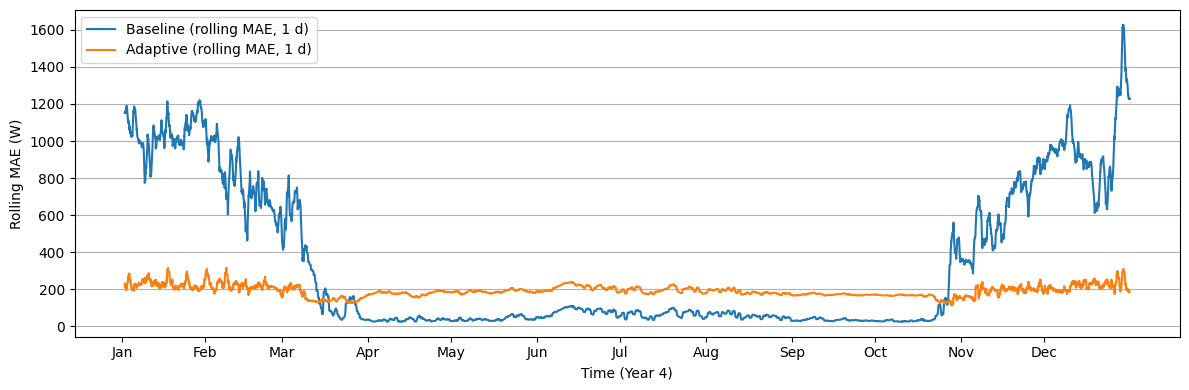

In [55]:

# =========================================================
# Helpers (as you had them) + MAPE fixed "like before"
# =========================================================

def _label_rows(n_full, lookback, horizon):
    return (np.arange(lookback, n_full - horizon + 1) + (horizon - 1))

def _build_year_windows(df_year: pd.DataFrame):
    X = df_year[FEATS].to_numpy(float)
    Xs = X_scaler.transform(X)
    ys = Xs[:, idx_t].copy()
    Xw, Yw = make_windows_multi(Xs, ys, LOOKBACK, H, stride=1)
    n_full = len(df_year)
    lbl_idx = _label_rows(n_full, LOOKBACK, H)
    ts_lab  = df_year.iloc[lbl_idx]["timestamp_sec"].to_numpy()
    mo_lab  = df_year.iloc[lbl_idx]["month"].to_numpy()
    return Xw, Yw, ts_lab, mo_lab, lbl_idx

def _predict_unscaled(model, Xw, Yw):
    Y_hat_s = model.predict(Xw, verbose=0)
    Y_true  = inv_steps_from_X_scaler(Yw,      X_scaler, idx_t, H)
    Y_hat   = inv_steps_from_X_scaler(Y_hat_s, X_scaler, idx_t, H)
    return Y_true, Y_hat

def _window_mae(y_true_row, y_hat_row):
    return float(np.mean(np.abs(y_true_row - y_hat_row)))

def _window_rmse(y_true_row, y_hat_row):
    return float(np.sqrt(np.mean((y_true_row - y_hat_row) ** 2)))

def _window_smape(y_true_row, y_hat_row, eps=1e-6):
    num = np.abs(y_true_row - y_hat_row)
    den = (np.abs(y_true_row) + np.abs(y_hat_row)).clip(min=eps)
    return float(np.mean(2.0 * num / den) * 100.0)  # %

def _rolling_mean(values, k):
    if k <= 1:
        return values.astype(float)
    out = np.full(len(values), np.nan, float)
    if len(values) >= k:
        csum = np.cumsum(values, dtype=float)
        out[k - 1:] = (csum[k - 1:] - np.concatenate(([0.0], csum[:-k]))) / k
    return out

def _month_ticks(months_arr):
    import calendar  # calendar.month_abbr is 1-based with month_abbr[0] == ""
    starts, labels, seen = [], [], set()
    for i, m in enumerate(months_arr):
        if m not in seen:
            starts.append(i)
            mm = int(m)
            labels.append(calendar.month_abbr[mm] if 1 <= mm <= 12 else str(m))
            seen.add(m)
    return np.array(starts), labels

def _per_horizon_smape(y_true_2d, y_hat_2d, eps=1e-6):
    Hh = y_true_2d.shape[1]
    vals = []
    for h in range(Hh):
        num = np.abs(y_true_2d[:, h] - y_hat_2d[:, h])
        den = (np.abs(y_true_2d[:, h]) + np.abs(y_hat_2d[:, h])).clip(min=eps)
        vals.append(float(np.mean(2.0 * num / den) * 100.0))
    return vals

# -------------------- MAPE fixed "like before" --------------------
# MAPE = 100 * mean( |(A - F)| / max(|A|, eps) ) [web:811]
MAPE_EPS = 1.0  # in target units (e.g., W)

def _window_mape(y_true_row, y_hat_row, mape_eps: float = MAPE_EPS):
    den = np.maximum(np.abs(y_true_row), float(mape_eps))
    return float(np.mean(np.abs((y_true_row - y_hat_row) / den)) * 100.0)  # % [web:811]

def _per_horizon_mape(y_true_2d, y_hat_2d, mape_eps: float = MAPE_EPS):
    Hh = y_true_2d.shape[1]
    vals = []
    for h in range(Hh):
        den = np.maximum(np.abs(y_true_2d[:, h]), float(mape_eps))
        vals.append(float(np.mean(np.abs((y_true_2d[:, h] - y_hat_2d[:, h]) / den)) * 100.0))  # [web:811]
    return vals
# -----------------------------------------------------------------

# =========================================================
# 1) Build Year 4 windows
# =========================================================
y4_df = df_drift[df_drift["year"] == 4].reset_index(drop=True)
assert len(y4_df) >= LOOKBACK + H + 1, "Year 4 has insufficient rows."

X4_win, Y4_win, ts4_lab, mo4_lab, _ = _build_year_windows(y4_df)

if len(ts4_lab) > 1 and np.isfinite(ts4_lab).all():
    dt_sec = float(np.median(np.diff(ts4_lab)))
    steps_per_day = max(1, int(round((24 * 3600) / dt_sec)))
else:
    steps_per_day = 96  # fallback for 15-min cadence

ROLL_DAYS  = 1
roll_steps = max(1, ROLL_DAYS * steps_per_day)

# =========================================================
# 2) Predict (baseline vs adaptive)
# =========================================================
adaptive_model = ddm_model  # <-- change if needed
Y4_true, Y4_hat_base = _predict_unscaled(baseline_model, X4_win, Y4_win)
_,       Y4_hat_adpt = _predict_unscaled(adaptive_model, X4_win, Y4_win)

H_eval = Y4_true.shape[1]  # don't overwrite global H

# =========================================================
# 3) Per-horizon metrics (MAE, RMSE, sMAPE, MAPE)
# =========================================================
mae_base  = [mean_absolute_error(Y4_true[:, h], Y4_hat_base[:, h]) for h in range(H_eval)]
mae_adpt  = [mean_absolute_error(Y4_true[:, h], Y4_hat_adpt[:, h]) for h in range(H_eval)]

rmse_base = [float(np.sqrt(mean_squared_error(Y4_true[:, h], Y4_hat_base[:, h]))) for h in range(H_eval)]
rmse_adpt = [float(np.sqrt(mean_squared_error(Y4_true[:, h], Y4_hat_adpt[:, h]))) for h in range(H_eval)]

smape_base = _per_horizon_smape(Y4_true, Y4_hat_base)
smape_adpt = _per_horizon_smape(Y4_true, Y4_hat_adpt)

# MAPE (fixed epsilon convention)
mape_base = _per_horizon_mape(Y4_true, Y4_hat_base, mape_eps=MAPE_EPS)
mape_adpt = _per_horizon_mape(Y4_true, Y4_hat_adpt, mape_eps=MAPE_EPS)

# =========================================================
# 4) Metric tables
# =========================================================
labels = [f"t+{i+1}" for i in range(H_eval)]

per_horizon_tbl = pd.DataFrame({
    "horizon": labels,
    "MAE_base": mae_base, "MAE_adapt": mae_adpt,
    "RMSE_base": rmse_base, "RMSE_adapt": rmse_adpt,
    "MAPE%_base": mape_base, "MAPE%_adapt": mape_adpt,
    "sMAPE%_base": smape_base, "sMAPE%_adapt": smape_adpt,
})

# WAPE over all windows & horizons
wape_base = (np.sum(np.abs(Y4_true - Y4_hat_base)) / max(np.sum(np.abs(Y4_true)), 1e-12)) * 100.0
wape_adpt = (np.sum(np.abs(Y4_true - Y4_hat_adpt)) / max(np.sum(np.abs(Y4_true)), 1e-12)) * 100.0

# =========================================================
# 5) Per-window errors (for aggregate + rolling plots)
# =========================================================
mae4_base_win = np.array([_window_mae(Y4_true[i], Y4_hat_base[i]) for i in range(len(X4_win))], float)
mae4_adpt_win = np.array([_window_mae(Y4_true[i], Y4_hat_adpt[i]) for i in range(len(X4_win))], float)

rmse4_base_win = np.sqrt(np.mean((Y4_true - Y4_hat_base) ** 2, axis=1)).astype(float)
rmse4_adpt_win = np.sqrt(np.mean((Y4_true - Y4_hat_adpt) ** 2, axis=1)).astype(float)

smape4_base_win = np.array([_window_smape(Y4_true[i], Y4_hat_base[i]) for i in range(len(X4_win))], float)
smape4_adpt_win = np.array([_window_smape(Y4_true[i], Y4_hat_adpt[i]) for i in range(len(X4_win))], float)

# MAPE per-window (fixed epsilon convention)
mape4_base_win = np.array([_window_mape(Y4_true[i], Y4_hat_base[i], mape_eps=MAPE_EPS) for i in range(len(X4_win))], float)
mape4_adpt_win = np.array([_window_mape(Y4_true[i], Y4_hat_adpt[i], mape_eps=MAPE_EPS) for i in range(len(X4_win))], float)

aggregate_tbl = pd.DataFrame({
    "MAE_mean":    [float(np.mean(mae4_base_win)),   float(np.mean(mae4_adpt_win))],
    "RMSE_mean":   [float(np.mean(rmse4_base_win)),  float(np.mean(rmse4_adpt_win))],
    "MAPE_mean%":  [float(np.mean(mape4_base_win)),  float(np.mean(mape4_adpt_win))],
    "sMAPE_mean%": [float(np.mean(smape4_base_win)), float(np.mean(smape4_adpt_win))],
    "WAPE%":       [float(wape_base),               float(wape_adpt)],
}, index=["Baseline", "Adaptive"])

print("=== Year 4 — Per-horizon metrics (MAE, RMSE, MAPE%, sMAPE%) ===")
display(per_horizon_tbl)

print("\n=== Year 4 — Aggregate metrics (means over windows) ===")
display(aggregate_tbl)

# =========================================================
# 5b) Global metrics (flatten all windows x horizons)
# =========================================================
_eps_smape = 1e-6

_diff_base = (Y4_true - Y4_hat_base)
mae_base_global = float(np.mean(np.abs(_diff_base)))
rmse_base_global = float(np.sqrt(np.mean(_diff_base ** 2)))
_den_base = (np.abs(Y4_true) + np.abs(Y4_hat_base)).clip(min=_eps_smape)
smape_base_global = float(np.mean(2.0 * np.abs(_diff_base) / _den_base) * 100.0)
mape_base_global = float(np.mean(np.abs(_diff_base) / np.maximum(np.abs(Y4_true), MAPE_EPS)) * 100.0)  # [web:811]
wape_base_global = float(wape_base)

_diff_adpt = (Y4_true - Y4_hat_adpt)
mae_adpt_global = float(np.mean(np.abs(_diff_adpt)))
rmse_adpt_global = float(np.sqrt(np.mean(_diff_adpt ** 2)))
_den_adpt = (np.abs(Y4_true) + np.abs(Y4_hat_adpt)).clip(min=_eps_smape)
smape_adpt_global = float(np.mean(2.0 * np.abs(_diff_adpt) / _den_adpt) * 100.0)
mape_adpt_global = float(np.mean(np.abs(_diff_adpt) / np.maximum(np.abs(Y4_true), MAPE_EPS)) * 100.0)  # [web:811]
wape_adpt_global = float(wape_adpt)

global_tbl = pd.DataFrame({
    "MAE_global":    [mae_base_global,  mae_adpt_global],
    "RMSE_global":   [rmse_base_global, rmse_adpt_global],
    "MAPE_global%":  [mape_base_global, mape_adpt_global],
    "sMAPE_global%": [smape_base_global, smape_adpt_global],
    "WAPE_global%":  [wape_base_global,  wape_adpt_global],
}, index=["Baseline", "Adaptive"])

print("\n=== Year 4 — Global metrics (flattened over all windows x horizons) ===")
display(global_tbl)

# =========================================================
# 6) Rolling MAE plot (fixed naming; no saving)
# =========================================================
mae4_base_roll = _rolling_mean(mae4_base_win, roll_steps)
mae4_adpt_roll = _rolling_mean(mae4_adpt_win, roll_steps)

xt, xl = _month_ticks(mo4_lab)

plt.figure(figsize=(12, 4))
plt.plot(mae4_base_roll, label=f"Baseline (rolling MAE, {ROLL_DAYS} d)")
plt.plot(mae4_adpt_roll, label=f"Adaptive (rolling MAE, {ROLL_DAYS} d)")
plt.xticks(xt, xl)
plt.xlabel("Time (Year 4)")
plt.ylabel("Rolling MAE (W)")
plt.title("")
plt.grid(True, axis="y")
plt.legend()
plt.tight_layout()
plt.show()


=== Year 5 — Per-horizon metrics (MAE, RMSE, MAPE%, sMAPE%) ===


horizon  MAE_base  MAE_adapt  RMSE_base  RMSE_adapt  MAPE%_base  \
0     t+1     342.1      204.9    1,072.5       291.4    10,265.0   
1     t+2     348.3      206.3      885.6       293.9    11,720.5   
2     t+3     403.2      195.6      993.6       310.2    13,880.6   
3     t+4     433.0      180.4      941.0       303.4    14,936.3   

   MAPE%_adapt  sMAPE%_base  sMAPE%_adapt  
0     15,421.8        168.2         162.1  
1     15,332.0        170.3         162.5  
2     13,445.7        171.6         163.4  
3     11,047.5        172.7         164.7


=== Year 5 — Aggregate metrics (means over windows) ===


MAE_mean  RMSE_mean  MAPE_mean%  sMAPE_mean%  WAPE%
Baseline     381.6      433.4    12,700.6        170.7  162.3
Adaptive     196.8      213.5    13,811.8        163.2   83.7


=== Year 5 — Global metrics (flattened over all windows x horizons) ===


MAE_global  RMSE_global  MAPE_global%  sMAPE_global%  WAPE_global%
Baseline       381.6        975.6      12,700.6          170.7         162.3
Adaptive       196.8        299.8      13,811.8          163.2          83.7

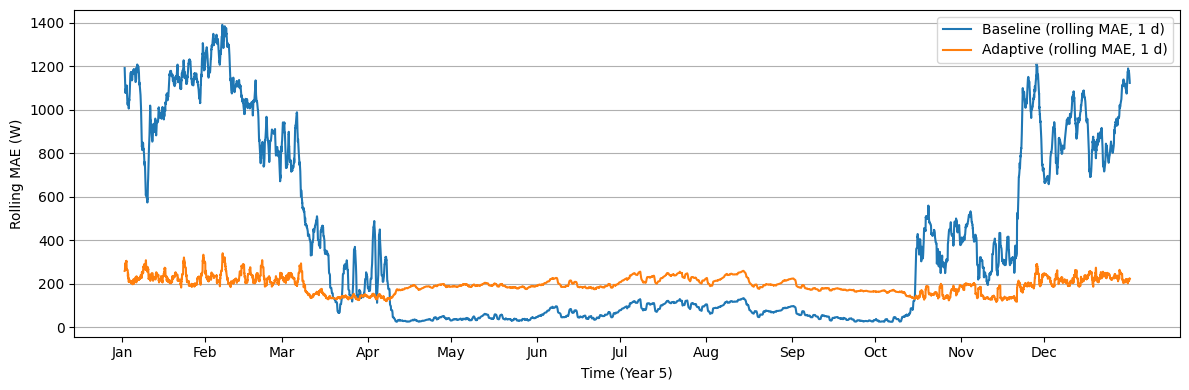

In [56]:
# =========================================================
# Same code as yours, with:
# 1) MAPE fixed "like before" (target-unit epsilon, e.g. 1.0 W) [web:811]
# 2) Rolling MAE plot naming fixed (no saving)
# =========================================================

# ---------- helpers ----------
def _label_rows(n_full, lookback, horizon):
    return (np.arange(lookback, n_full - horizon + 1) + (horizon - 1))

def _build_year_windows(df_year: pd.DataFrame):
    X = df_year[FEATS].to_numpy(float)
    Xs = X_scaler.transform(X)
    ys = Xs[:, idx_t].copy()
    Xw, Yw = make_windows_multi(Xs, ys, LOOKBACK, H, stride=1)
    n_full = len(df_year)
    lbl_idx = _label_rows(n_full, LOOKBACK, H)
    ts_lab  = df_year.iloc[lbl_idx]["timestamp_sec"].to_numpy()
    mo_lab  = df_year.iloc[lbl_idx]["month"].to_numpy()
    return Xw, Yw, ts_lab, mo_lab, lbl_idx

def _predict_unscaled(model, Xw, Yw):
    Y_hat_s = model.predict(Xw, verbose=0)
    Y_true  = inv_steps_from_X_scaler(Yw,      X_scaler, idx_t, H)
    Y_hat   = inv_steps_from_X_scaler(Y_hat_s, X_scaler, idx_t, H)
    return Y_true, Y_hat

def _window_mae(y_true_row, y_hat_row):
    return float(np.mean(np.abs(y_true_row - y_hat_row)))

def _window_rmse(y_true_row, y_hat_row):
    return float(np.sqrt(np.mean((y_true_row - y_hat_row) ** 2)))

def _window_smape(y_true_row, y_hat_row, eps=1e-6):
    num = np.abs(y_true_row - y_hat_row)
    den = (np.abs(y_true_row) + np.abs(y_hat_row)).clip(min=eps)
    return float(np.mean(2.0 * num / den) * 100.0)  # %

# ---------- MAPE helpers (FIXED like eval_year: max(|y_true|, mape_eps)) ----------
MAPE_EPS = 1.0  # in target units (e.g., W)

def _window_mape(y_true_row, y_hat_row, mape_eps: float = MAPE_EPS):
    den = np.maximum(np.abs(y_true_row), float(mape_eps))
    return float(np.mean(np.abs((y_true_row - y_hat_row) / den)) * 100.0)  # % [web:811]

def _per_horizon_mape(y_true_2d, y_hat_2d, mape_eps: float = MAPE_EPS):
    Hh = y_true_2d.shape[1]
    vals = []
    for h in range(Hh):
        den = np.maximum(np.abs(y_true_2d[:, h]), float(mape_eps))
        vals.append(float(np.mean(np.abs((y_true_2d[:, h] - y_hat_2d[:, h]) / den)) * 100.0))  # [web:811]
    return vals
# -------------------------------------------------------------------------------

def _rolling_mean(values, k):
    if k <= 1:
        return values.astype(float)
    out = np.full(len(values), np.nan, float)
    if len(values) >= k:
        csum = np.cumsum(values, dtype=float)
        out[k-1:] = (csum[k-1:] - np.concatenate(([0.0], csum[:-k]))) / k
    return out

def _month_ticks(months_arr):
    import calendar  # calendar.month_abbr is 1-based with month_abbr[0] == ""
    starts, labels, seen = [], [], set()
    for i, m in enumerate(months_arr):
        if m not in seen:
            starts.append(i)
            mm = int(m)
            labels.append(calendar.month_abbr[mm] if 1 <= mm <= 12 else str(m))
            seen.add(m)
    return np.array(starts), labels

def _per_horizon_smape(y_true_2d, y_hat_2d, eps=1e-6):
    Hh = y_true_2d.shape[1]
    vals = []
    for h in range(Hh):
        num = np.abs(y_true_2d[:, h] - y_hat_2d[:, h])
        den = (np.abs(y_true_2d[:, h]) + np.abs(y_hat_2d[:, h])).clip(min=eps)
        vals.append(float(np.mean(2.0 * num / den) * 100.0))
    return vals


# =========================================================
# 1) Build Year 5 windows
# =========================================================
y5_df = df_drift[df_drift["year"] == 5].reset_index(drop=True)
assert len(y5_df) >= LOOKBACK + H + 1, "Year 5 has insufficient rows."

X5_win, Y5_win, ts5_lab, mo5_lab, _ = _build_year_windows(y5_df)

if len(ts5_lab) > 1 and np.isfinite(ts5_lab).all():
    dt_sec = float(np.median(np.diff(ts5_lab)))
    steps_per_day = max(1, int(round((24 * 3600) / dt_sec)))
else:
    steps_per_day = 96  # fallback for 15-min cadence

ROLL_DAYS  = 1
roll_steps = max(1, ROLL_DAYS * steps_per_day)

# =========================================================
# 2) Predict (baseline vs adaptive)
# =========================================================
adaptive_model = ddm_model  # <-- change to pagehinkley_model if you want PH here
Y5_true, Y5_hat_base = _predict_unscaled(baseline_model, X5_win, Y5_win)
_,       Y5_hat_adpt = _predict_unscaled(adaptive_model, X5_win, Y5_win)

H_eval = Y5_true.shape[1]

# =========================================================
# 3) Per-horizon metrics (MAE, RMSE, sMAPE, MAPE)
# =========================================================
mae_base  = [mean_absolute_error(Y5_true[:, h], Y5_hat_base[:, h]) for h in range(H_eval)]
mae_adpt  = [mean_absolute_error(Y5_true[:, h], Y5_hat_adpt[:, h]) for h in range(H_eval)]

rmse_base = [float(np.sqrt(mean_squared_error(Y5_true[:, h], Y5_hat_base[:, h]))) for h in range(H_eval)]
rmse_adpt = [float(np.sqrt(mean_squared_error(Y5_true[:, h], Y5_hat_adpt[:, h]))) for h in range(H_eval)]

smape_base = _per_horizon_smape(Y5_true, Y5_hat_base)
smape_adpt = _per_horizon_smape(Y5_true, Y5_hat_adpt)

# MAPE fixed (mape_eps = 1.0 in target units)
mape_base = _per_horizon_mape(Y5_true, Y5_hat_base, mape_eps=MAPE_EPS)
mape_adpt = _per_horizon_mape(Y5_true, Y5_hat_adpt, mape_eps=MAPE_EPS)

# =========================================================
# 4) Metric tables
# =========================================================
labels = [f"t+{i+1}" for i in range(H_eval)]

per_horizon_tbl = pd.DataFrame({
    "horizon": labels,
    "MAE_base": mae_base, "MAE_adapt": mae_adpt,
    "RMSE_base": rmse_base, "RMSE_adapt": rmse_adpt,
    "MAPE%_base": mape_base, "MAPE%_adapt": mape_adpt,
    "sMAPE%_base": smape_base, "sMAPE%_adapt": smape_adpt,
})

wape_base = (np.sum(np.abs(Y5_true - Y5_hat_base)) / max(np.sum(np.abs(Y5_true)), 1e-12)) * 100.0
wape_adpt = (np.sum(np.abs(Y5_true - Y5_hat_adpt)) / max(np.sum(np.abs(Y5_true)), 1e-12)) * 100.0

# =========================================================
# 5) Per-window errors
# =========================================================
mae5_base_win = np.array([_window_mae(Y5_true[i], Y5_hat_base[i]) for i in range(len(X5_win))], float)
mae5_adpt_win = np.array([_window_mae(Y5_true[i], Y5_hat_adpt[i]) for i in range(len(X5_win))], float)

rmse5_base_win = np.sqrt(np.mean((Y5_true - Y5_hat_base) ** 2, axis=1)).astype(float)
rmse5_adpt_win = np.sqrt(np.mean((Y5_true - Y5_hat_adpt) ** 2, axis=1)).astype(float)

smape5_base_win = np.array([_window_smape(Y5_true[i], Y5_hat_base[i]) for i in range(len(X5_win))], float)
smape5_adpt_win = np.array([_window_smape(Y5_true[i], Y5_hat_adpt[i]) for i in range(len(X5_win))], float)

# MAPE per-window fixed
mape5_base_win = np.array([_window_mape(Y5_true[i], Y5_hat_base[i], mape_eps=MAPE_EPS) for i in range(len(X5_win))], float)
mape5_adpt_win = np.array([_window_mape(Y5_true[i], Y5_hat_adpt[i], mape_eps=MAPE_EPS) for i in range(len(X5_win))], float)

aggregate_tbl = pd.DataFrame({
    "MAE_mean":    [float(np.mean(mae5_base_win)),   float(np.mean(mae5_adpt_win))],
    "RMSE_mean":   [float(np.mean(rmse5_base_win)),  float(np.mean(rmse5_adpt_win))],
    "MAPE_mean%":  [float(np.mean(mape5_base_win)),  float(np.mean(mape5_adpt_win))],
    "sMAPE_mean%": [float(np.mean(smape5_base_win)), float(np.mean(smape5_adpt_win))],
    "WAPE%":       [float(wape_base),               float(wape_adpt)],
}, index=["Baseline", "Adaptive"])

print("=== Year 5 — Per-horizon metrics (MAE, RMSE, MAPE%, sMAPE%) ===")
display(per_horizon_tbl)

print("\n=== Year 5 — Aggregate metrics (means over windows) ===")
display(aggregate_tbl)

# =========================================================
# 5b) Global metrics (flatten all windows x horizons)
# =========================================================
_eps_smape = 1e-6

_diff_base = (Y5_true - Y5_hat_base)
mae_base_global = float(np.mean(np.abs(_diff_base)))
rmse_base_global = float(np.sqrt(np.mean(_diff_base ** 2)))
_den_base = (np.abs(Y5_true) + np.abs(Y5_hat_base)).clip(min=_eps_smape)
smape_base_global = float(np.mean(2.0 * np.abs(_diff_base) / _den_base) * 100.0)
mape_base_global = float(np.mean(np.abs(_diff_base) / np.maximum(np.abs(Y5_true), MAPE_EPS)) * 100.0)  # [web:811]
wape_base_global = float(wape_base)

_diff_adpt = (Y5_true - Y5_hat_adpt)
mae_adpt_global = float(np.mean(np.abs(_diff_adpt)))
rmse_adpt_global = float(np.sqrt(np.mean(_diff_adpt ** 2)))
_den_adpt = (np.abs(Y5_true) + np.abs(Y5_hat_adpt)).clip(min=_eps_smape)
smape_adpt_global = float(np.mean(2.0 * np.abs(_diff_adpt) / _den_adpt) * 100.0)
mape_adpt_global = float(np.mean(np.abs(_diff_adpt) / np.maximum(np.abs(Y5_true), MAPE_EPS)) * 100.0)  # [web:811]
wape_adpt_global = float(wape_adpt)

global_tbl = pd.DataFrame({
    "MAE_global":    [mae_base_global,  mae_adpt_global],
    "RMSE_global":   [rmse_base_global, rmse_adpt_global],
    "MAPE_global%":  [mape_base_global, mape_adpt_global],
    "sMAPE_global%": [smape_base_global, smape_adpt_global],
    "WAPE_global%":  [wape_base_global,  wape_adpt_global],
}, index=["Baseline", "Adaptive"])

print("\n=== Year 5 — Global metrics (flattened over all windows x horizons) ===")
display(global_tbl)

# =========================================================
# 6) Rolling MAE plot (naming fixed; no saving)
# =========================================================
mae5_base_roll = _rolling_mean(mae5_base_win, roll_steps)
mae5_adpt_roll = _rolling_mean(mae5_adpt_win, roll_steps)

xt, xl = _month_ticks(mo5_lab)

plt.figure(figsize=(12, 4))
plt.plot(mae5_base_roll, label=f"Baseline (rolling MAE, {ROLL_DAYS} d)")
plt.plot(mae5_adpt_roll, label=f"Adaptive (rolling MAE, {ROLL_DAYS} d)")
plt.xticks(xt, xl)
plt.xlabel("Time (Year 5)")
plt.ylabel("Rolling MAE (W)")
plt.title("")
plt.grid(True, axis="y")
plt.legend()
plt.tight_layout()
plt.show()


In [57]:
def _ph_run_with_cooldown(values: np.ndarray,
                          min_instances: int,
                          delta: float,
                          threshold: float,
                          alpha: float,
                          mode: str,
                          cooldown_steps: int):
    ph = drift.PageHinkley(
        min_instances=min_instances,
        delta=delta,
        threshold=threshold,
        alpha=alpha,
        mode=mode
    )
    drift_idx, cooldown = [], 0
    for i, v in enumerate(values):
        ph.update(float(v))
        if cooldown > 0:
            cooldown -= 1
            continue
        if ph.drift_detected:
            drift_idx.append(i)
            cooldown = cooldown_steps
    return drift_idx

def ph_grid_search(
    y3_df_drifted: pd.DataFrame,
    deltas=(0.05, 0.1, 0.2),
    thresholds=(500, 1000, 2000, 4000),
    alphas=(0.9999, 0.999, 0.99, 0.9),
    min_instances: int = 30,
    mode: str = "both",
    cooldown_days: int = 7,
    apr1_ts: int = 70_848_000
) -> pd.DataFrame:
    # Build Year-3 error stream and labels (avg |error| per window in original units)
    e_y3, ts_y3, mo_y3 = errors_avg_abs(y3_df_drifted)  # uses baseline_model internally per your helper

    # steps ↔ days conversion from timestamps (fallback to 96 steps/day for 15-min cadence)
    if ts_y3.size >= 2 and np.isfinite(ts_y3).all():
        dt_sec = float(np.median(np.diff(ts_y3)))
        steps_per_day = max(1, int(round((24*3600)/dt_sec)))
    else:
        dt_sec = 15*60.0
        steps_per_day = 96
    cooldown_steps = cooldown_days * steps_per_day

    # Apr-1 index in label space
    tau_idx = int(np.searchsorted(ts_y3, apr1_ts, side="left"))

    rows = []
    for delta in deltas:
        for threshold in thresholds:
            for alpha in alphas:
                drifts = _ph_run_with_cooldown(
                    values=e_y3,
                    min_instances=min_instances,
                    delta=delta,
                    threshold=threshold,
                    alpha=alpha,
                    mode=mode,
                    cooldown_steps=cooldown_steps
                )

                # FPs: all drifts strictly before Apr-1
                fp = int(sum(i < tau_idx for i in drifts))

                # Detection delay: first drift at/after Apr-1, else big penalty
                post = [i for i in drifts if i >= tau_idx]
                if len(post):
                    first_idx = post[0]
                    delay_hours = (first_idx - tau_idx) * (dt_sec / 3600.0)
                else:
                    delay_hours = 1e9  # large penalty if no detection

                rows.append({
                    "delta": delta,
                    "threshold": threshold,
                    "alpha": alpha,
                    "min_instances": min_instances,
                    "mode": mode,
                    "cooldown_days": cooldown_days,
                    "false_positives": fp,
                    "detection_delay_hours": delay_hours,
                    "total_drifts": len(drifts)
                })

    df_gs = pd.DataFrame(rows)
    # Lexicographic sort: minimize FP first, then delay
    df_gs = df_gs.sort_values(
        by=["false_positives", "detection_delay_hours", "threshold", "delta", "alpha"],
        ascending=[True, True, True, True, True]
    ).reset_index(drop=True)

    # Export best to a handy dict
    best = df_gs.iloc[0].to_dict()
    global ph_best_params
    ph_best_params = {
        "min_instances": int(best["min_instances"]),
        "delta": float(best["delta"]),
        "threshold": float(best["threshold"]),
        "alpha": float(best["alpha"]),
        "mode": best["mode"],
        "cooldown_days": int(best["cooldown_days"])
    }
    print("PH grid-search best:", ph_best_params)
    return df_gs

# ---------- Run it ----------
y3_df = df_drift[df_drift['year'] == 3].reset_index(drop=True)

ph_gs_results = ph_grid_search(
    y3_df_drifted=y3_df,
    deltas=(0.05, 0.1, 0.2,0.005),
    thresholds=(1000, 2000,3000, 4000, 5000, 6000, 7000, 8000),
    alphas=(0.9999, 0.999, 0.9),
    min_instances=30,
    mode="both",
    cooldown_days=7,
    apr1_ts=70_848_000
)

# Peek at the top rows
display(ph_gs_results.head(10))




PH grid-search best: {'min_instances': 30, 'delta': 0.005, 'threshold': 6000.0, 'alpha': 0.9, 'mode': 'both', 'cooldown_days': 7}


delta  threshold  alpha  min_instances  mode  cooldown_days  \
0    0.0       6000    0.9             30  both              7   
1    0.1       6000    0.9             30  both              7   
2    0.1       6000    0.9             30  both              7   
3    0.2       6000    0.9             30  both              7   
4    0.0       7000    0.9             30  both              7   
5    0.1       7000    0.9             30  both              7   
6    0.1       7000    0.9             30  both              7   
7    0.2       7000    0.9             30  both              7   
8    0.0       8000    0.9             30  both              7   
9    0.1       8000    0.9             30  both              7   

   false_positives  detection_delay_hours  total_drifts  
0                0                    0.8            13  
1                0                    0.8            13  
2                0                    0.8            13  
3                0                    0.8            13  
4                0                    0.8            13  
5                0                    0.8            13  
6                0                    0.8            13  
7                0                    0.8            13  
8                0                    0.8            13  
9                0                    0.8            13

Using PH best params: {'min_instances': 30, 'delta': 0.005, 'threshold': 6000.0, 'alpha': 0.9, 'mode': 'both', 'cooldown_days': 7}
[PH] cooldown = 672 steps (~7 days)


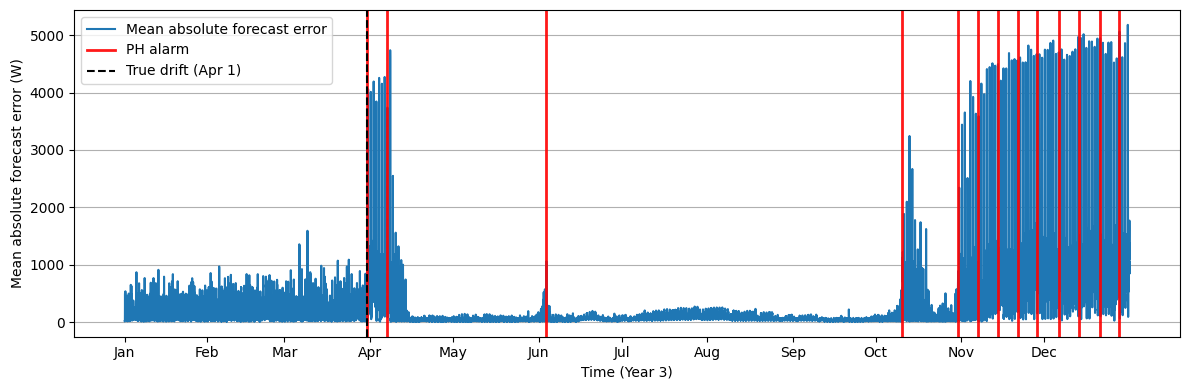

Total drifts: 13 | False positives (pre–Apr-1): 0
First drift after Apr-1 at index 8438 → detection delay ≈ 0.8 h


In [85]:
print("Using PH best params:", ph_best_params)

# 1) Build Year-3 error stream (avg |error| per window in ORIGINAL units)
y3_df = df_drift[df_drift["year"] == 3].reset_index(drop=True)
e_bar_y3, ts_y3, mo_y3 = errors_avg_abs(y3_df)  # uses baseline_model internally per your helper

# 2) Steps/day and cooldown (≈24h = 96 steps for 15-min cadence)
if ts_y3.size >= 2 and np.isfinite(ts_y3).all():
    dt_sec = float(np.median(np.diff(ts_y3)))
    steps_per_day = max(1, int(round((24 * 3600) / dt_sec)))
else:
    dt_sec = 15 * 60.0
    steps_per_day = 96

cooldown_steps = ph_best_params["cooldown_days"] * steps_per_day
print(f"[PH] cooldown = {cooldown_steps} steps (~{ph_best_params['cooldown_days']} days)")

# 3) Run PH with BEST settings
ph_best_drifts = _ph_run_with_cooldown(
    values=e_bar_y3,
    min_instances=ph_best_params["min_instances"],
    delta=ph_best_params["delta"],
    threshold=ph_best_params["threshold"],
    alpha=ph_best_params["alpha"],
    mode=ph_best_params["mode"],
    cooldown_steps=cooldown_steps
)

# 4) Detection delay wrt. Apr-1 (Year 3)
DRIFT_TS = 70_848_000
tau_idx = int(np.searchsorted(ts_y3, DRIFT_TS, side="left"))
first_post = next((i for i in ph_best_drifts if i >= tau_idx), None)
delay_hours = (first_post - tau_idx) * (dt_sec / 3600.0) if first_post is not None else None

# 5) Plot with month ticks + FP vs post-drift coloring + save
def _month_ticks(months_arr):
    import calendar
    starts, labels, seen = [], [], set()
    for i, m in enumerate(months_arr):
        if m not in seen:
            starts.append(i)
            mm = int(m)
            labels.append(calendar.month_abbr[mm] if 1 <= mm <= 12 else str(m))
            seen.add(m)
    return np.array(starts), labels

idxs = np.arange(len(e_bar_y3))
xt, xl = _month_ticks(mo_y3)

plt.figure(figsize=(12, 4))
plt.plot(idxs, e_bar_y3, label="Mean absolute forecast error")

# False positives (pre Apr-1) -> gray, post Apr-1 alarms -> red
fp_label = "False positive alarm"
td_label = "PH alarm"
for i in ph_best_drifts:
    if int(i) < int(tau_idx):
        plt.axvline(i, color="tab:gray", linestyle="-", linewidth=2.0, alpha=0.9, label=fp_label)
        fp_label = "_nolegend_"
    else:
        plt.axvline(i, color="red", linestyle="-", linewidth=2.0, alpha=0.9, label=td_label)
        td_label = "_nolegend_"

plt.axvline(tau_idx, color="black", linestyle="--", linewidth=1.5, label="True drift (Apr 1)")
plt.xticks(xt, xl)
plt.xlabel("Time (Year 3)")
plt.ylabel("Mean absolute forecast error (W)")
plt.title("")
plt.grid(True, axis="y")
plt.legend()
plt.tight_layout()

# SAVE BEFORE SHOW (otherwise you can get an empty file) [web:742][web:942]
plt.savefig("/kaggle/working/RetrofitYear3PH.pdf", format="pdf", bbox_inches="tight")

plt.show()

# 6) Small textual summary
fp = sum(i < tau_idx for i in ph_best_drifts)
print(f"Total drifts: {len(ph_best_drifts)} | False positives (pre–Apr-1): {fp}")
if delay_hours is None:
    print("No drift detected after Apr-1 → detection delay = ∞")
else:
    print(f"First drift after Apr-1 at index {first_post} → detection delay ≈ {delay_hours:.1f} h")


Using PH best params for adaptation: {'min_instances': 30, 'delta': 0.005, 'threshold': 6000.0, 'alpha': 0.9, 'mode': 'both', 'cooldown_days': 7}
=== Year 3 — Recovery speed (rolling MAE) ===


drift_idx  recovered  t_rec_idx  recovery_hours  recovery_days
0        8438       True       9133           173.8            7.2
1        9132       True       9133             0.2            0.0
2       14659       True      14659             0.0            0.0
3       27032       True      27032             0.0            0.0
4       28963       True      28963             0.0            0.0
5       29662       True      29662             0.0            0.0
6       30348       True      30348             0.0            0.0
7       31020       True      31020             0.0            0.0
8       31693       True      31693             0.0            0.0
9       32394       True      32394             0.0            0.0
10      33066       True      33066             0.0            0.0
11      33739       True      33739             0.0            0.0
12      34476       True      34476             0.0            0.0


=== Year 3 — Per-horizon metrics (MAE, RMSE, MAPE%, sMAPE%) ===


horizon  MAE_base  MAE_adapt  RMSE_base  RMSE_adapt  MAPE%_base  \
0     t+1     223.0      102.0      783.5       258.5     6,594.3   
1     t+2     232.2      111.4      653.9       292.8     7,323.1   
2     t+3     270.8      126.9      746.1       344.6     8,559.9   
3     t+4     294.4      135.4      721.6       357.7     8,914.0   

   MAPE%_adapt  sMAPE%_base  sMAPE%_adapt  
0      4,771.3        132.9         128.2  
1      4,623.4        134.1         128.9  
2      4,526.3        135.0         130.2  
3      3,944.4        135.8         130.6


=== Year 3 — Aggregate metrics (means over windows) ===


MAE_mean  RMSE_mean  MAPE_mean%  sMAPE_mean%  WAPE%
Baseline        255.1      289.1     7,847.8        134.5   17.6
PH-Adaptive     118.9      136.2     4,466.4        129.5    8.2


=== Year 3 — Global metrics (flattened over all windows x horizons) ===


MAE_global  RMSE_global  MAPE_global%  sMAPE_global%  \
Baseline          255.1        727.8       7,847.8          134.5   
PH-Adaptive       118.9        315.9       4,466.4          129.5   

             WAPE_global%  
Baseline             17.6  
PH-Adaptive           8.2

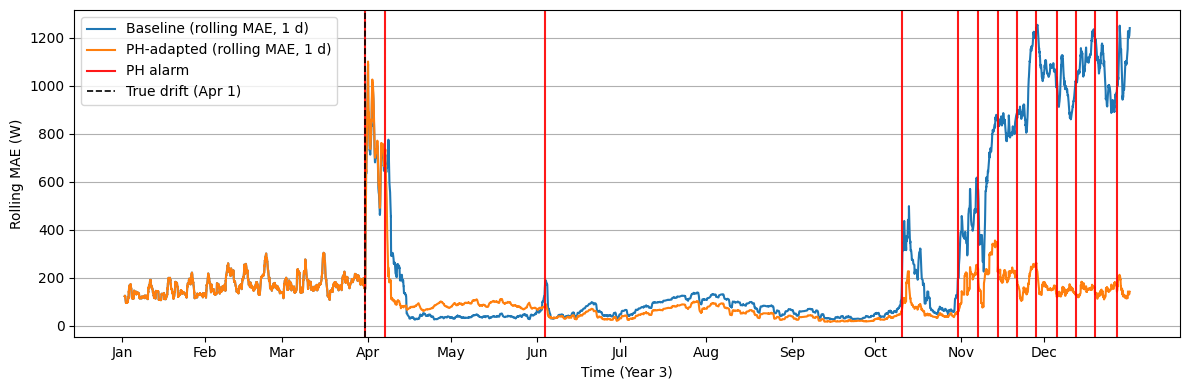

In [60]:
# ===================== Configs (MAE) =====================
PRETRAIN_LR   = 0.0007509794596043137
FT_LR         = PRETRAIN_LR / 10.0       # fine-tune LR = 1/10 pretrain LR
FT_DAYS       = 7
FT_EPOCHS     = 5
FT_BATCH      = 41
FT_PATIENCE   = 2
ROLL_DAYS     = 1
COOLDOWN_DAYS = 7
ONLY_AFTER_TS = 70_848_000               # Apr-1 Year 3
H             = HORIZON

# Best PH params you reported
PH_CFG = dict(min_instances=30, delta=0.005, threshold=6000.0, alpha=0.9, mode="both", cooldown_days=7)
print("Using PH best params for adaptation:", PH_CFG)

# ===================== Helpers =====================

def _label_rows(n_full, lookback, horizon):
    return (np.arange(lookback, n_full - horizon + 1) + (horizon - 1))

def _build_year_windows(df_year: pd.DataFrame):
    X = df_year[FEATS].to_numpy(float)
    Xs = X_scaler.transform(X)
    ys = Xs[:, idx_t].copy()
    Xw, Yw = make_windows_multi(Xs, ys, LOOKBACK, H, stride=1)
    n_full = len(df_year)
    lbl_idx = _label_rows(n_full, LOOKBACK, H)
    ts_lab  = df_year.iloc[lbl_idx]["timestamp_sec"].to_numpy()
    mo_lab  = df_year.iloc[lbl_idx]["month"].to_numpy()
    return Xw, Yw, ts_lab, mo_lab, lbl_idx

def _predict_unscaled(model, Xw, Yw):
    Y_hat_s = model.predict(Xw, verbose=0)
    Y_true  = inv_steps_from_X_scaler(Yw,      X_scaler, idx_t, H)
    Y_hat   = inv_steps_from_X_scaler(Y_hat_s, X_scaler, idx_t, H)
    return Y_true, Y_hat

def _window_mae(y_true_row, y_hat_row):
    return float(np.mean(np.abs(y_true_row - y_hat_row)))

def _window_rmse(y_true_row, y_hat_row):
    return float(np.sqrt(np.mean((y_true_row - y_hat_row) ** 2)))

def _window_smape(y_true_row, y_hat_row, eps=1e-6):
    num = np.abs(y_true_row - y_hat_row)
    den = (np.abs(y_true_row) + np.abs(y_hat_row)).clip(min=eps)
    return float(np.mean(2.0 * num / den) * 100.0)

# -------------------- FIXED: MAPE helpers (like eval_year) --------------------
# MAPE = 100 * mean( |A - F| / max(|A|, eps) ) [web:811]
MAPE_EPS = 1.0  # in target units (e.g., W)

def _window_mape(y_true_row, y_hat_row, mape_eps: float = MAPE_EPS):
    den = np.maximum(np.abs(y_true_row), float(mape_eps))
    return float(np.mean(np.abs((y_true_row - y_hat_row) / den)) * 100.0)  # [web:811]

def _per_horizon_mape(y_true_2d, y_hat_2d, mape_eps: float = MAPE_EPS):
    Hh = y_true_2d.shape[1]
    vals = []
    for h in range(Hh):
        den = np.maximum(np.abs(y_true_2d[:, h]), float(mape_eps))
        vals.append(float(np.mean(np.abs((y_true_2d[:, h] - y_hat_2d[:, h]) / den)) * 100.0))  # [web:811]
    return vals
# ---------------------------------------------------------------------------

def _rolling_mean(values, k):
    if k <= 1:
        return values.astype(float)
    out = np.full(len(values), np.nan, float)
    if len(values) >= k:
        csum = np.cumsum(values, dtype=float)
        out[k-1:] = (csum[k-1:] - np.concatenate(([0.0], csum[:-k]))) / k
    return out

def _steps_per_day_from_labels(ts_labels):
    if ts_labels.size >= 2 and np.isfinite(ts_labels).all():
        dt_sec = float(np.median(np.diff(ts_labels)))
    else:
        dt_sec = 15 * 60
    return max(1, int(round((24 * 3600) / dt_sec))), dt_sec

def _month_ticks(months_arr):
    import calendar
    starts, labels, seen = [], [], set()
    for i, m in enumerate(months_arr):
        if m not in seen:
            starts.append(i)
            mm = int(m)
            labels.append(calendar.month_abbr[mm] if 1 <= mm <= 12 else str(m))
            seen.add(m)
    return np.array(starts), labels

def _per_horizon_smape(y_true_2d, y_hat_2d, eps=1e-6):
    Hh = y_true_2d.shape[1]
    vals = []
    for h in range(Hh):
        num = np.abs(y_true_2d[:, h] - y_hat_2d[:, h])
        den = (np.abs(y_true_2d[:, h]) + np.abs(y_hat_2d[:, h])).clip(min=eps)
        vals.append(float(np.mean(2.0 * num / den) * 100.0))
    return vals

def _recovery_speed_indices(base_roll, adapt_roll, drift_indices, consec):
    recov = []
    N = len(base_roll)
    for d in drift_indices:
        r, i, count = None, max(0, d), 0
        while i < N:
            a = adapt_roll[i]; b = base_roll[i]
            if np.isfinite(a) and np.isfinite(b) and (a <= b):
                count += 1
                if count >= consec:
                    r = i - consec + 1
                    break
            else:
                count = 0
            i += 1
        recov.append(r)
    return recov

# ===================== 1) Build Year-3 windows & baseline error streams =====================
y3_df = df_drift[df_drift["year"] == 3].reset_index(drop=True)
X3_win, Y3_win, ts3_lab, mo3_lab, _ = _build_year_windows(y3_df)
steps_per_day, dt_sec = _steps_per_day_from_labels(ts3_lab)
roll_steps     = ROLL_DAYS * steps_per_day
ft_steps       = FT_DAYS * steps_per_day
cooldown_steps = COOLDOWN_DAYS * steps_per_day
tau_idx        = int(np.searchsorted(ts3_lab, ONLY_AFTER_TS, side="left"))

# Baseline predictions for Year 3 (detector input & baseline metrics)
Y3_true_base, Y3_hat_base = _predict_unscaled(baseline_model, X3_win, Y3_win)
mae3_base_win   = np.array([_window_mae  (Y3_true_base[i], Y3_hat_base[i]) for i in range(len(X3_win))])
rmse3_base_win  = np.array([_window_rmse (Y3_true_base[i], Y3_hat_base[i]) for i in range(len(X3_win))])
smape3_base_win = np.array([_window_smape(Y3_true_base[i], Y3_hat_base[i]) for i in range(len(X3_win))])
mape3_base_win  = np.array([_window_mape (Y3_true_base[i], Y3_hat_base[i], mape_eps=MAPE_EPS) for i in range(len(X3_win))])
mae3_base_roll  = _rolling_mean(mae3_base_win, roll_steps)

# ===================== 2) Init Page–Hinkley (always update from start) =====================
ph = drift.PageHinkley(
    min_instances=int(PH_CFG["min_instances"]),
    delta=float(PH_CFG["delta"]),
    threshold=float(PH_CFG["threshold"]),
    alpha=float(PH_CFG["alpha"]),
    mode=str(PH_CFG["mode"])
)

# ===================== 3) Online PH adaptation on pagehinkley_model =====================
orig_opt_cfg = tf.keras.optimizers.serialize(pagehinkley_model.optimizer)
pagehinkley_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FT_LR, clipnorm=1.0),
    loss=pagehinkley_model.loss,
    metrics=[m for m in pagehinkley_model.metrics if getattr(m, "name", "") != "loss"]
)

ph_all_drifts  = []   # counted with 7d cooldown (includes pre-Apr for FP accounting)
ph_adapt_hits  = []   # subset we fine-tune on (post-Apr + not in adaptation cooldown)
last_alarm_idx = -10**12
adapt_cooldown = 0

# Streaming collections (errors + keep per-window preds to build tables later)
mae_adapt_win   = []
rmse_adapt_win  = []
smape_adapt_win = []
mape_adapt_win  = []
Y3_true_stream  = []
Y3_hat_stream   = []

for i in range(len(X3_win)):
    # ----- Online prediction with current adapted model -----
    yhat_s   = pagehinkley_model.predict(X3_win[i:i+1], verbose=0)[0]
    y_true_r = inv_steps_from_X_scaler(Y3_win[i:i+1], X_scaler, idx_t, H)[0]
    y_hat_r  = inv_steps_from_X_scaler(yhat_s.reshape(1, -1), X_scaler, idx_t, H)[0]

    # Save for tables
    Y3_true_stream.append(y_true_r)
    Y3_hat_stream.append(y_hat_r)

    # Per-window “normal” errors for adapted model
    mae_adapt_win.append  (_window_mae  (y_true_r, y_hat_r))
    rmse_adapt_win.append (_window_rmse (y_true_r, y_hat_r))
    smape_adapt_win.append(_window_smape(y_true_r, y_hat_r))
    mape_adapt_win.append (_window_mape (y_true_r, y_hat_r, mape_eps=MAPE_EPS))

    # ----- Always update PH on the baseline error stream -----
    ph.update(float(mae3_base_win[i]))

    # Count alarms with cooldown
    if ph.drift_detected and (i - last_alarm_idx) >= cooldown_steps:
        ph_all_drifts.append(i)
        last_alarm_idx = i

        # Adapt only after Apr-1 and if not in adaptation cooldown
        if ts3_lab[i] >= ONLY_AFTER_TS and adapt_cooldown == 0:
            ph_adapt_hits.append(i)

            # Fine-tune on previous FT_DAYS windows ending at i
            s   = max(0, i - ft_steps + 1)
            Xft = X3_win[s:i+1]
            Yft = Y3_win[s:i+1]
            if len(Xft) >= 10:
                es = tf.keras.callbacks.EarlyStopping(
                    monitor="val_loss", patience=FT_PATIENCE, restore_best_weights=True
                )
                pagehinkley_model.fit(
                    Xft, Yft,
                    validation_split=0.1,
                    epochs=FT_EPOCHS,
                    batch_size=FT_BATCH,
                    shuffle=True,
                    verbose=0,
                    callbacks=[es]
                )
            adapt_cooldown = cooldown_steps

    if adapt_cooldown > 0:
        adapt_cooldown -= 1

# Restore original optimizer (optional)
pagehinkley_model.compile(
    optimizer=tf.keras.optimizers.deserialize(orig_opt_cfg),
    loss=pagehinkley_model.loss,
    metrics=[m for m in pagehinkley_model.metrics if getattr(m, "name", "") != "loss"]
)

# ===================== 4) Recovery speed (MAE rolling) =====================
mae_adapt_win  = np.asarray(mae_adapt_win, float)
mae_adapt_roll = _rolling_mean(mae_adapt_win, roll_steps)

consec = roll_steps
recovery_idx = _recovery_speed_indices(mae3_base_roll, mae_adapt_roll, ph_adapt_hits, consec)

recovery_rows = []
for d, r in zip(ph_adapt_hits, recovery_idx):
    if r is None:
        recovery_rows.append({"drift_idx": d, "recovered": False, "t_rec_idx": np.nan,
                              "recovery_hours": np.nan, "recovery_days": np.nan})
    else:
        hours = (r - d) * (dt_sec / 3600.0)
        recovery_rows.append({"drift_idx": d, "recovered": True, "t_rec_idx": r,
                              "recovery_hours": hours, "recovery_days": hours / 24.0})
recovery_table = pd.DataFrame(recovery_rows)

# ===================== 5) Tables: Year 3 metrics =====================
Y3_true_stream = np.asarray(Y3_true_stream)  # (N, H)
Y3_hat_stream  = np.asarray(Y3_hat_stream)   # (N, H)

Hh = Y3_true_stream.shape[1]
mae_base_h   = [mean_absolute_error(Y3_true_base[:, h],   Y3_hat_base[:, h])   for h in range(Hh)]
mae_adpt_h   = [mean_absolute_error(Y3_true_stream[:, h], Y3_hat_stream[:, h]) for h in range(Hh)]
rmse_base_h  = [mean_squared_error(Y3_true_base[:, h],   Y3_hat_base[:, h],   squared=False) for h in range(Hh)]
rmse_adpt_h  = [mean_squared_error(Y3_true_stream[:, h], Y3_hat_stream[:, h], squared=False) for h in range(Hh)]
smape_base_h = _per_horizon_smape(Y3_true_base,   Y3_hat_base)
smape_adpt_h = _per_horizon_smape(Y3_true_stream, Y3_hat_stream)

# MAPE fixed
mape_base_h = _per_horizon_mape(Y3_true_base,   Y3_hat_base,   mape_eps=MAPE_EPS)
mape_adpt_h = _per_horizon_mape(Y3_true_stream, Y3_hat_stream, mape_eps=MAPE_EPS)

per_horizon_tbl = pd.DataFrame({
    "horizon": [f"t+{i+1}" for i in range(Hh)],
    "MAE_base": mae_base_h, "MAE_adapt": mae_adpt_h,
    "RMSE_base": rmse_base_h, "RMSE_adapt": rmse_adpt_h,
    "MAPE%_base": mape_base_h, "MAPE%_adapt": mape_adpt_h,
    "sMAPE%_base": smape_base_h, "sMAPE%_adapt": smape_adpt_h
})

wape_base = (np.sum(np.abs(Y3_true_base - Y3_hat_base)) / max(np.sum(np.abs(Y3_true_base)), 1e-12)) * 100.0
wape_adpt = (np.sum(np.abs(Y3_true_stream - Y3_hat_stream)) / max(np.sum(np.abs(Y3_true_stream)), 1e-12)) * 100.0

aggregate_tbl = pd.DataFrame({
    "MAE_mean":    [float(np.mean(mae3_base_win)),    float(np.mean(mae_adapt_win))],
    "RMSE_mean":   [float(np.mean(rmse3_base_win)),   float(np.mean(rmse_adapt_win))],
    "MAPE_mean%":  [float(np.mean(mape3_base_win)),   float(np.mean(mape_adapt_win))],
    "sMAPE_mean%": [float(np.mean(smape3_base_win)),  float(np.mean(smape_adapt_win))],
    "WAPE%":       [float(wape_base), float(wape_adpt)]
}, index=["Baseline", "PH-Adaptive"])

print("=== Year 3 — Recovery speed (rolling MAE) ===")
display(recovery_table)

print("\n=== Year 3 — Per-horizon metrics (MAE, RMSE, MAPE%, sMAPE%) ===")
display(per_horizon_tbl)

print("\n=== Year 3 — Aggregate metrics (means over windows) ===")
display(aggregate_tbl)

# Global metrics (flatten all windows x horizons) with SAME MAPE_EPS convention
_eps_smape = 1e-6

_diff_base = (Y3_true_base - Y3_hat_base)
mae_base_global = float(np.mean(np.abs(_diff_base)))
rmse_base_global = float(np.sqrt(np.mean(_diff_base ** 2)))
_den_base = (np.abs(Y3_true_base) + np.abs(Y3_hat_base)).clip(min=_eps_smape)
smape_base_global = float(np.mean(2.0 * np.abs(_diff_base) / _den_base) * 100.0)
wape_base_global = float(wape_base)
mape_base_global = float(np.mean(np.abs(_diff_base) / np.maximum(np.abs(Y3_true_base), MAPE_EPS)) * 100.0)  # [web:811]

_diff_adpt = (Y3_true_stream - Y3_hat_stream)
mae_adpt_global = float(np.mean(np.abs(_diff_adpt)))
rmse_adpt_global = float(np.sqrt(np.mean(_diff_adpt ** 2)))
_den_adpt = (np.abs(Y3_true_stream) + np.abs(Y3_hat_stream)).clip(min=_eps_smape)
smape_adpt_global = float(np.mean(2.0 * np.abs(_diff_adpt) / _den_adpt) * 100.0)
wape_adpt_global = float(wape_adpt)
mape_adpt_global = float(np.mean(np.abs(_diff_adpt) / np.maximum(np.abs(Y3_true_stream), MAPE_EPS)) * 100.0)  # [web:811]

global_tbl = pd.DataFrame({
    "MAE_global":    [mae_base_global,  mae_adpt_global],
    "RMSE_global":   [rmse_base_global, rmse_adpt_global],
    "MAPE_global%":  [mape_base_global, mape_adpt_global],
    "sMAPE_global%": [smape_base_global, smape_adpt_global],
    "WAPE_global%":  [wape_base_global,  wape_adpt_global],
}, index=["Baseline", "PH-Adaptive"])

print("\n=== Year 3 — Global metrics (flattened over all windows x horizons) ===")
display(global_tbl)

# ===================== 6) Rolling MAE plot (only) =====================
xticks, xlabels = _month_ticks(mo3_lab)
plt.figure(figsize=(12, 4))

plt.plot(mae3_base_roll,  label=f"Baseline (rolling MAE, {ROLL_DAYS} d)")
plt.plot(mae_adapt_roll,  label=f"PH-adapted (rolling MAE, {ROLL_DAYS} d)")

fp_label = "False positive alarm"
td_label = "PH alarm"
for di in ph_all_drifts:
    if ts3_lab[di] >= ONLY_AFTER_TS:
        plt.axvline(di, color="red", linestyle="-", linewidth=1.5, alpha=0.9, label=td_label)
        td_label = "_nolegend_"
    else:
        plt.axvline(di, color="tab:gray", linestyle="-", linewidth=1.5, alpha=0.9, label=fp_label)
        fp_label = "_nolegend_"

plt.axvline(tau_idx, color="black", linestyle="--", linewidth=1.2, label="True drift (Apr 1)")

plt.xticks(xticks, xlabels)
plt.xlabel("Time (Year 3)")
plt.ylabel("Rolling MAE (W)")
plt.title("")
plt.grid(True, axis="y")
plt.legend()
plt.tight_layout()
plt.savefig("/kaggle/working/RetrofitYear3FinetuningPH.pdf", format="pdf", bbox_inches="tight")
plt.show()


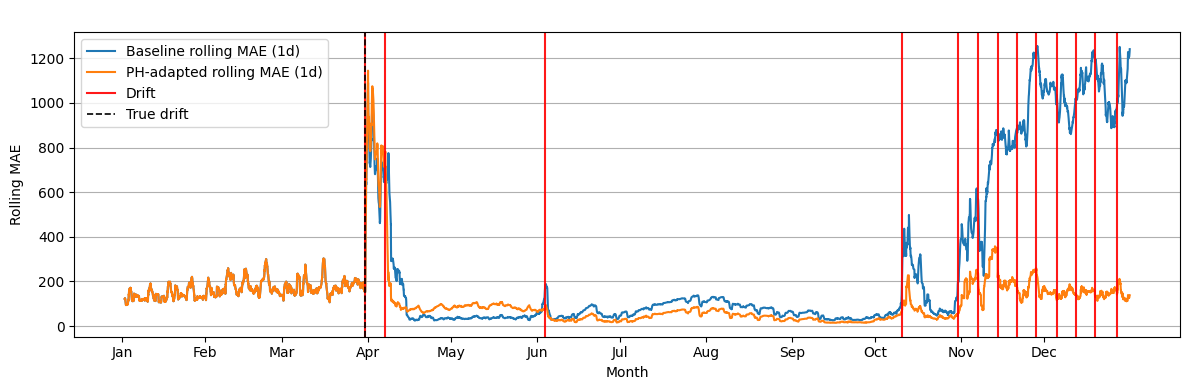

In [45]:
xticks, xlabels = _month_ticks(mo3_lab)
plt.figure(figsize=(12,4))
plt.plot(mae3_base_roll,  label=f"Baseline rolling MAE ({ROLL_DAYS}d)")
plt.plot(mae_adapt_roll,  label=f"PH-adapted rolling MAE ({ROLL_DAYS}d)")
for k, di in enumerate(ph_all_drifts):
    color = "red" if ts3_lab[di] >= ONLY_AFTER_TS else "tab:gray"
    lab = "Drift" if (k == 0 and color == "red") else None
    plt.axvline(di, color=color, linestyle="-", linewidth=1.5, alpha=0.9, label=lab)
plt.axvline(tau_idx, color="black", linestyle="--", linewidth=1.2, label="True drift")
plt.xticks(xticks, xlabels)
plt.xlabel("Month"); plt.ylabel("Rolling MAE")
plt.title(" ")
plt.grid(True, axis='y'); plt.legend(); plt.tight_layout(); plt.show()

=== Year 4 — Per-horizon metrics (MAE, RMSE, MAPE%, sMAPE%) ===


horizon  MAE_base  MAE_PH  RMSE_base  RMSE_PH  MAPE%_base  MAPE%_PH  \
0     t+1     304.3    77.7    1,033.7    199.0     8,391.6   4,637.3   
1     t+2     305.9    99.9      843.3    174.8     9,514.6   6,425.9   
2     t+3     355.3   144.6      941.9    210.9    11,361.8  10,050.7   
3     t+4     380.9   167.6      869.9    238.7    12,449.3  11,565.7   

   sMAPE%_base  sMAPE%_PH  
0        168.7      161.0  
1        171.3      163.6  
2        172.5      164.4  
3        173.7      165.2


=== Year 4 — Aggregate metrics (means over windows) ===


MAE_mean  RMSE_mean  MAPE_mean%  sMAPE_mean%  WAPE%
Baseline        336.6      384.0    10,429.3        171.6  149.4
PH-Adaptive     122.4      138.2     8,169.9        163.6   54.3


=== Year 4 — Global metrics (flattened over all windows x horizons) ===


MAE_global  RMSE_global  MAPE_global%  sMAPE_global%  \
Baseline          336.6        925.1      10,429.3          171.6   
PH-Adaptive       122.4        207.1       8,169.9          163.6   

             WAPE_global%  
Baseline            149.4  
PH-Adaptive          54.3

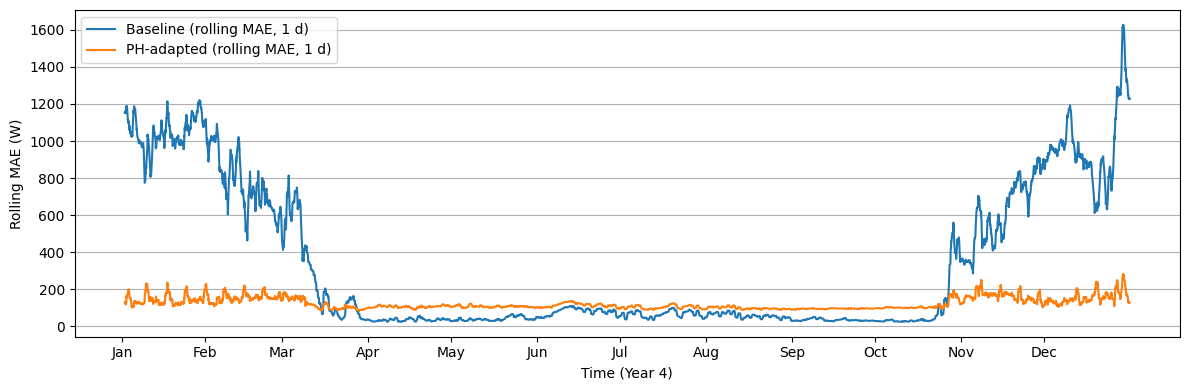

In [61]:
# ---------- Year 4: rolling MAE plot + MAE/RMSE/sMAPE/MAPE tables ----------
# (MAPE FIX: use target-unit epsilon like before: max(|y_true|, MAPE_EPS)) [web:811]

import numpy as np
import pandas as pd

# If you don't already have these two helpers in scope, keep them here:
def _window_mae(y_true_row, y_hat_row):
    return float(np.mean(np.abs(y_true_row - y_hat_row)))

def _window_rmse(y_true_row, y_hat_row):
    return float(np.sqrt(np.mean((y_true_row - y_hat_row) ** 2)))

def _window_smape(y_true_row, y_hat_row, eps=1e-6):
    num = np.abs(y_true_row - y_hat_row)
    den = (np.abs(y_true_row) + np.abs(y_hat_row)).clip(min=eps)
    return float(np.mean(2.0 * num / den) * 100.0)

# -------------------- FIXED: MAPE helpers (like eval_year) --------------------
# MAPE = 100 * mean( |A - F| / |A| ) and we stabilize by using max(|A|, eps). [web:811]
MAPE_EPS = 1.0  # in target units (e.g., W)

def _window_mape(y_true_row, y_hat_row, mape_eps: float = MAPE_EPS):
    den = np.maximum(np.abs(y_true_row), float(mape_eps))
    return float(np.mean(np.abs((y_true_row - y_hat_row) / den)) * 100.0)  # [web:811]

def _per_horizon_mape(y_true_2d, y_hat_2d, mape_eps: float = MAPE_EPS):
    Hh = y_true_2d.shape[1]
    out = []
    for h in range(Hh):
        den = np.maximum(np.abs(y_true_2d[:, h]), float(mape_eps))
        out.append(float(np.mean(np.abs((y_true_2d[:, h] - y_hat_2d[:, h]) / den)) * 100.0))  # [web:811]
    return out
# ---------------------------------------------------------------------------

def _per_horizon_smape(y_true_2d, y_hat_2d, eps=1e-6):
    Hh = y_true_2d.shape[1]
    out = []
    for h in range(Hh):
        num = np.abs(y_true_2d[:, h] - y_hat_2d[:, h])
        den = (np.abs(y_true_2d[:, h]) + np.abs(y_hat_2d[:, h])).clip(min=eps)
        out.append(float(np.mean(2.0 * num / den) * 100.0))
    return out

# 1) Build Year-4 windows
y4_df = df_drift[df_drift["year"] == 4].reset_index(drop=True)
assert len(y4_df) >= LOOKBACK + HORIZON + 1, "Year 4 has insufficient rows."

X4_win, Y4_win, ts4_lab, mo4_lab, _ = _build_year_windows(y4_df)
steps_per_day, _ = _steps_per_day_from_labels(ts4_lab)
ROLL_DAYS = 1
roll_steps = max(1, ROLL_DAYS * steps_per_day)

# 2) Predict (baseline vs Page-Hinkley–adapted)
Y4_true, Y4_hat_base = _predict_unscaled(baseline_model,     X4_win, Y4_win)
_,        Y4_hat_ph   = _predict_unscaled(pagehinkley_model, X4_win, Y4_win)

H = Y4_true.shape[1]

# 3) Per-horizon metrics (MAE, RMSE, sMAPE, MAPE)
mae_base  = [mean_absolute_error(Y4_true[:, h], Y4_hat_base[:, h]) for h in range(H)]
mae_ph    = [mean_absolute_error(Y4_true[:, h], Y4_hat_ph[:, h])   for h in range(H)]

rmse_base = [mean_squared_error(Y4_true[:, h], Y4_hat_base[:, h], squared=False) for h in range(H)]
rmse_ph   = [mean_squared_error(Y4_true[:, h], Y4_hat_ph[:, h],   squared=False) for h in range(H)]

smape_base = _per_horizon_smape(Y4_true, Y4_hat_base)
smape_ph   = _per_horizon_smape(Y4_true, Y4_hat_ph)

# FIXED per-horizon MAPE (uses MAPE_EPS = 1.0 target units)
mape_base = _per_horizon_mape(Y4_true, Y4_hat_base, mape_eps=MAPE_EPS)
mape_ph   = _per_horizon_mape(Y4_true, Y4_hat_ph,   mape_eps=MAPE_EPS)

per_horizon_tbl = pd.DataFrame({
    "horizon":     [f"t+{i+1}" for i in range(H)],
    "MAE_base":     mae_base,   "MAE_PH":     mae_ph,
    "RMSE_base":    rmse_base,  "RMSE_PH":    rmse_ph,
    "MAPE%_base":   mape_base,  "MAPE%_PH":   mape_ph,
    "sMAPE%_base":  smape_base, "sMAPE%_PH":  smape_ph
})

# 4) Per-window normal errors -> rolling MAE (only plot this)
mae4_base_win = np.array([_window_mae(Y4_true[i], Y4_hat_base[i]) for i in range(len(X4_win))], float)
mae4_ph_win   = np.array([_window_mae(Y4_true[i], Y4_hat_ph[i])   for i in range(len(X4_win))], float)

def _rolling_mean(values, k):
    if k <= 1:
        return values.astype(float)
    out = np.full(len(values), np.nan, float)
    if len(values) >= k:
        csum = np.cumsum(values, dtype=float)
        out[k-1:] = (csum[k-1:] - np.concatenate(([0.0], csum[:-k]))) / k
    return out

mae4_base_roll = _rolling_mean(mae4_base_win, roll_steps)
mae4_ph_roll   = _rolling_mean(mae4_ph_win,   roll_steps)

# 5) Aggregate (means over all Year-4 windows)
rmse4_base_win  = np.array([_window_rmse(Y4_true[i], Y4_hat_base[i]) for i in range(len(X4_win))], float)
rmse4_ph_win    = np.array([_window_rmse(Y4_true[i], Y4_hat_ph[i])   for i in range(len(X4_win))], float)
smape4_base_win = np.array([_window_smape(Y4_true[i], Y4_hat_base[i]) for i in range(len(X4_win))], float)
smape4_ph_win   = np.array([_window_smape(Y4_true[i], Y4_hat_ph[i])   for i in range(len(X4_win))], float)

# FIXED per-window MAPE (uses MAPE_EPS = 1.0 target units)
mape4_base_win = np.array([_window_mape(Y4_true[i], Y4_hat_base[i], mape_eps=MAPE_EPS) for i in range(len(X4_win))], float)
mape4_ph_win   = np.array([_window_mape(Y4_true[i], Y4_hat_ph[i],   mape_eps=MAPE_EPS) for i in range(len(X4_win))], float)

# WAPE over all windows & horizons
wape_base = (np.sum(np.abs(Y4_true - Y4_hat_base)) / max(np.sum(np.abs(Y4_true)), 1e-12)) * 100.0
wape_ph   = (np.sum(np.abs(Y4_true - Y4_hat_ph))   / max(np.sum(np.abs(Y4_true)), 1e-12)) * 100.0

aggregate_tbl = pd.DataFrame({
    "MAE_mean":    [float(np.mean(mae4_base_win)),    float(np.mean(mae4_ph_win))],
    "RMSE_mean":   [float(np.mean(rmse4_base_win)),   float(np.mean(rmse4_ph_win))],
    "MAPE_mean%":  [float(np.mean(mape4_base_win)),   float(np.mean(mape4_ph_win))],
    "sMAPE_mean%": [float(np.mean(smape4_base_win)),  float(np.mean(smape4_ph_win))],
    "WAPE%":       [float(wape_base),                 float(wape_ph)]
}, index=["Baseline", "PH-Adaptive"])

# 6) Show tables
print("=== Year 4 — Per-horizon metrics (MAE, RMSE, MAPE%, sMAPE%) ===")
display(per_horizon_tbl)

print("\n=== Year 4 — Aggregate metrics (means over windows) ===")
display(aggregate_tbl)

# ---------- Global metrics (flattened over all windows x horizons) ----------
_eps_smape = 1e-6

_diff_base = (Y4_true - Y4_hat_base)
mae_base_global  = float(np.mean(np.abs(_diff_base)))
rmse_base_global = float(np.sqrt(np.mean(_diff_base ** 2)))
_den_base = (np.abs(Y4_true) + np.abs(Y4_hat_base)).clip(min=_eps_smape)
smape_base_global = float(np.mean(2.0 * np.abs(_diff_base) / _den_base) * 100.0)
wape_base_global  = float(wape_base)

# FIXED global MAPE with SAME MAPE_EPS convention [web:811]
mape_base_global = float(np.mean(np.abs(_diff_base) / np.maximum(np.abs(Y4_true), MAPE_EPS)) * 100.0)  # [web:811]

_diff_ph = (Y4_true - Y4_hat_ph)
mae_ph_global  = float(np.mean(np.abs(_diff_ph)))
rmse_ph_global = float(np.sqrt(np.mean(_diff_ph ** 2)))
_den_ph = (np.abs(Y4_true) + np.abs(Y4_hat_ph)).clip(min=_eps_smape)
smape_ph_global = float(np.mean(2.0 * np.abs(_diff_ph) / _den_ph) * 100.0)
wape_ph_global  = float(wape_ph)

# FIXED global MAPE with SAME MAPE_EPS convention [web:811]
mape_ph_global = float(np.mean(np.abs(_diff_ph) / np.maximum(np.abs(Y4_true), MAPE_EPS)) * 100.0)  # [web:811]

global_tbl = pd.DataFrame({
    "MAE_global":    [mae_base_global,  mae_ph_global],
    "RMSE_global":   [rmse_base_global, rmse_ph_global],
    "MAPE_global%":  [mape_base_global, mape_ph_global],
    "sMAPE_global%": [smape_base_global, smape_ph_global],
    "WAPE_global%":  [wape_base_global,  wape_ph_global],
}, index=["Baseline", "PH-Adaptive"])

print("\n=== Year 4 — Global metrics (flattened over all windows x horizons) ===")
display(global_tbl)
# ----------------------------------------------------------------------

# 7) Plot rolling MAE (Year 4) — the only figure
def _month_ticks(months_arr):
    import calendar
    starts, labels, seen = [], [], set()
    for i, m in enumerate(months_arr):
        if m not in seen:
            starts.append(i)
            mm = int(m)
            labels.append(calendar.month_abbr[mm] if 1 <= mm <= 12 else str(m))
            seen.add(m)
    return np.array(starts), labels

xt, xl = _month_ticks(mo4_lab)

plt.figure(figsize=(12, 4))
plt.plot(mae4_base_roll, label=f"Baseline (rolling MAE, {ROLL_DAYS} d)")
plt.plot(mae4_ph_roll,   label=f"PH-adapted (rolling MAE, {ROLL_DAYS} d)")
plt.xticks(xt, xl)
plt.xlabel("Time (Year 4)")
plt.ylabel("Rolling MAE (W)")
plt.title("")
plt.grid(True, axis="y")
plt.legend()
plt.tight_layout()
plt.show()


=== Year 5 — Per-horizon metrics (MAE, RMSE, MAPE%, sMAPE%) ===


horizon  MAE_base  MAE_PH  RMSE_base  RMSE_PH  MAPE%_base  MAPE%_PH  \
0     t+1     342.1    84.2    1,072.5    181.9    10,265.0   5,123.6   
1     t+2     348.3   106.4      885.6    173.8    11,720.5   6,822.5   
2     t+3     403.2   153.5      993.6    222.3    13,880.6  10,484.6   
3     t+4     433.0   175.5      941.0    248.4    14,936.3  11,838.4   

   sMAPE%_base  sMAPE%_PH  
0        168.2      158.9  
1        170.3      160.9  
2        171.6      161.7  
3        172.7      162.6


=== Year 5 — Aggregate metrics (means over windows) ===


MAE_mean  RMSE_mean  MAPE_mean%  sMAPE_mean%  WAPE%
Baseline        381.6      433.4    12,700.6        170.7  162.3
PH-Adaptive     129.9      145.5     8,567.2        161.0   55.3


=== Year 5 — Global metrics (flattened over all windows x horizons) ===


MAE_global  RMSE_global  MAPE_global%  sMAPE_global%  \
Baseline          381.6        975.6      12,700.6          170.7   
PH-Adaptive       129.9        208.8       8,567.2          161.0   

             WAPE_global%  
Baseline            162.3  
PH-Adaptive          55.3

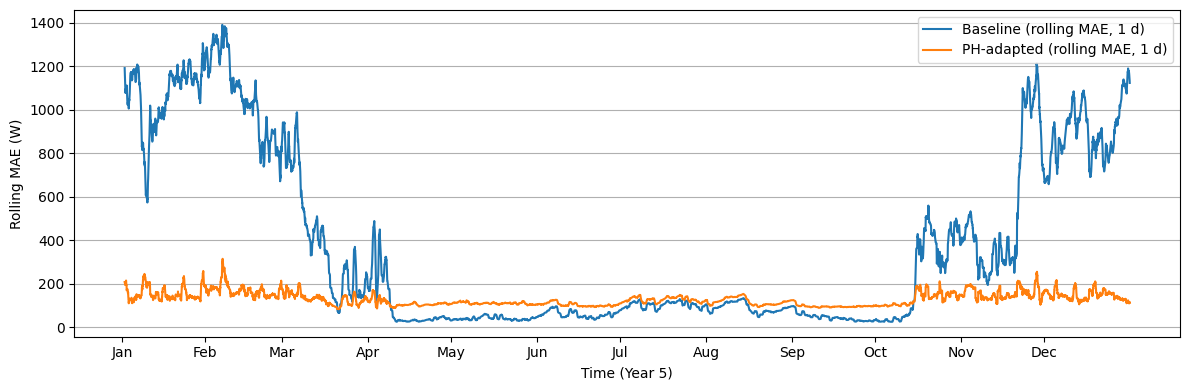

In [62]:
# ---------- Year 5: rolling MAE plot + MAE/RMSE/MAPE/sMAPE tables ----------

import numpy as np
import pandas as pd

# If you don't already have these helpers in scope, keep them here:
def _window_mae(y_true_row, y_hat_row):
    return float(np.mean(np.abs(y_true_row - y_hat_row)))

def _window_rmse(y_true_row, y_hat_row):
    return float(np.sqrt(np.mean((y_true_row - y_hat_row) ** 2)))

def _window_smape(y_true_row, y_hat_row, eps=1e-6):
    num = np.abs(y_true_row - y_hat_row)
    den = (np.abs(y_true_row) + np.abs(y_hat_row)).clip(min=eps)
    return float(np.mean(2.0 * num / den) * 100.0)

# -------------------- FIXED: MAPE helpers (target-unit epsilon) --------------------
# MAPE = 100 * mean( |A - F| / |A| ), stabilized via max(|A|, MAPE_EPS). [web:811]
MAPE_EPS = 1.0  # in target units (e.g., W)

def _window_mape(y_true_row, y_hat_row, mape_eps: float = MAPE_EPS):
    den = np.maximum(np.abs(y_true_row), float(mape_eps))
    return float(np.mean(np.abs((y_true_row - y_hat_row) / den)) * 100.0)

def _per_horizon_mape(y_true_2d, y_hat_2d, mape_eps: float = MAPE_EPS):
    Hh = y_true_2d.shape[1]
    out = []
    for h in range(Hh):
        den = np.maximum(np.abs(y_true_2d[:, h]), float(mape_eps))
        out.append(float(np.mean(np.abs((y_true_2d[:, h] - y_hat_2d[:, h]) / den)) * 100.0))
    return out
# -------------------------------------------------------------------------------

def _per_horizon_smape(y_true_2d, y_hat_2d, eps=1e-6):
    Hh = y_true_2d.shape[1]
    out = []
    for h in range(Hh):
        num = np.abs(y_true_2d[:, h] - y_hat_2d[:, h])
        den = (np.abs(y_true_2d[:, h]) + np.abs(y_hat_2d[:, h])).clip(min=eps)
        out.append(float(np.mean(2.0 * num / den) * 100.0))
    return out

def _rolling_mean(values, k):
    if k <= 1:
        return values.astype(float)
    out = np.full(len(values), np.nan, float)
    if len(values) >= k:
        csum = np.cumsum(values, dtype=float)
        out[k - 1:] = (csum[k - 1:] - np.concatenate(([0.0], csum[:-k]))) / k
    return out

def _month_ticks(months_arr):
    import calendar
    starts, labels, seen = [], [], set()
    for i, m in enumerate(months_arr):
        if m not in seen:
            starts.append(i)
            mm = int(m)
            labels.append(calendar.month_abbr[mm] if 1 <= mm <= 12 else str(m))
            seen.add(m)
    return np.array(starts), labels

# 1) Build Year-5 windows
y5_df = df_drift[df_drift["year"] == 5].reset_index(drop=True)
assert len(y5_df) >= LOOKBACK + HORIZON + 1, "Year 5 has insufficient rows."

X5_win, Y5_win, ts5_lab, mo5_lab, _ = _build_year_windows(y5_df)
steps_per_day, _ = _steps_per_day_from_labels(ts5_lab)

ROLL_DAYS = 1
roll_steps = max(1, ROLL_DAYS * steps_per_day)

# 2) Predict (baseline vs Page-Hinkley–adapted)
Y5_true, Y5_hat_base = _predict_unscaled(baseline_model,     X5_win, Y5_win)
_,        Y5_hat_ph   = _predict_unscaled(pagehinkley_model, X5_win, Y5_win)

H = Y5_true.shape[1]

# 3) Per-horizon metrics
mae_base  = [mean_absolute_error(Y5_true[:, h], Y5_hat_base[:, h]) for h in range(H)]
mae_ph    = [mean_absolute_error(Y5_true[:, h], Y5_hat_ph[:, h])   for h in range(H)]

rmse_base = [mean_squared_error(Y5_true[:, h], Y5_hat_base[:, h], squared=False) for h in range(H)]
rmse_ph   = [mean_squared_error(Y5_true[:, h], Y5_hat_ph[:, h],   squared=False) for h in range(H)]

smape_base = _per_horizon_smape(Y5_true, Y5_hat_base)
smape_ph   = _per_horizon_smape(Y5_true, Y5_hat_ph)

mape_base  = _per_horizon_mape(Y5_true, Y5_hat_base, mape_eps=MAPE_EPS)
mape_ph    = _per_horizon_mape(Y5_true, Y5_hat_ph,   mape_eps=MAPE_EPS)

per_horizon_tbl = pd.DataFrame({
    "horizon":     [f"t+{i+1}" for i in range(H)],
    "MAE_base":     mae_base,   "MAE_PH":     mae_ph,
    "RMSE_base":    rmse_base,  "RMSE_PH":    rmse_ph,
    "MAPE%_base":   mape_base,  "MAPE%_PH":   mape_ph,
    "sMAPE%_base":  smape_base, "sMAPE%_PH":  smape_ph
})

# 4) Per-window errors -> rolling MAE (plot only this)
mae5_base_win = np.array([_window_mae(Y5_true[i], Y5_hat_base[i]) for i in range(len(X5_win))], float)
mae5_ph_win   = np.array([_window_mae(Y5_true[i], Y5_hat_ph[i])   for i in range(len(X5_win))], float)

mae5_base_roll = _rolling_mean(mae5_base_win, roll_steps)
mae5_ph_roll   = _rolling_mean(mae5_ph_win,   roll_steps)

# 5) Aggregate (means over all Year-5 windows)
rmse5_base_win  = np.array([_window_rmse(Y5_true[i], Y5_hat_base[i]) for i in range(len(X5_win))], float)
rmse5_ph_win    = np.array([_window_rmse(Y5_true[i], Y5_hat_ph[i])   for i in range(len(X5_win))], float)

smape5_base_win = np.array([_window_smape(Y5_true[i], Y5_hat_base[i]) for i in range(len(X5_win))], float)
smape5_ph_win   = np.array([_window_smape(Y5_true[i], Y5_hat_ph[i])   for i in range(len(X5_win))], float)

mape5_base_win  = np.array([_window_mape(Y5_true[i], Y5_hat_base[i], mape_eps=MAPE_EPS) for i in range(len(X5_win))], float)
mape5_ph_win    = np.array([_window_mape(Y5_true[i], Y5_hat_ph[i],   mape_eps=MAPE_EPS) for i in range(len(X5_win))], float)

# WAPE over all windows & horizons
wape_base = (np.sum(np.abs(Y5_true - Y5_hat_base)) / max(np.sum(np.abs(Y5_true)), 1e-12)) * 100.0
wape_ph   = (np.sum(np.abs(Y5_true - Y5_hat_ph))   / max(np.sum(np.abs(Y5_true)), 1e-12)) * 100.0

aggregate_tbl = pd.DataFrame({
    "MAE_mean":    [float(np.mean(mae5_base_win)),    float(np.mean(mae5_ph_win))],
    "RMSE_mean":   [float(np.mean(rmse5_base_win)),   float(np.mean(rmse5_ph_win))],
    "MAPE_mean%":  [float(np.mean(mape5_base_win)),   float(np.mean(mape5_ph_win))],
    "sMAPE_mean%": [float(np.mean(smape5_base_win)),  float(np.mean(smape5_ph_win))],
    "WAPE%":       [float(wape_base),                 float(wape_ph)]
}, index=["Baseline", "PH-Adaptive"])

# 6) Show tables
print("=== Year 5 — Per-horizon metrics (MAE, RMSE, MAPE%, sMAPE%) ===")
display(per_horizon_tbl)

print("\n=== Year 5 — Aggregate metrics (means over windows) ===")
display(aggregate_tbl)

# 7) Global metrics (flatten all windows x horizons) with SAME MAPE_EPS convention
_eps_smape = 1e-6

_diff_base = (Y5_true - Y5_hat_base)
mae_base_global  = float(np.mean(np.abs(_diff_base)))
rmse_base_global = float(np.sqrt(np.mean(_diff_base ** 2)))
_den_base = (np.abs(Y5_true) + np.abs(Y5_hat_base)).clip(min=_eps_smape)
smape_base_global = float(np.mean(2.0 * np.abs(_diff_base) / _den_base) * 100.0)
wape_base_global  = float(wape_base)
mape_base_global  = float(np.mean(np.abs(_diff_base) / np.maximum(np.abs(Y5_true), MAPE_EPS)) * 100.0)

_diff_ph = (Y5_true - Y5_hat_ph)
mae_ph_global  = float(np.mean(np.abs(_diff_ph)))
rmse_ph_global = float(np.sqrt(np.mean(_diff_ph ** 2)))
_den_ph = (np.abs(Y5_true) + np.abs(Y5_hat_ph)).clip(min=_eps_smape)
smape_ph_global = float(np.mean(2.0 * np.abs(_diff_ph) / _den_ph) * 100.0)
wape_ph_global  = float(wape_ph)
mape_ph_global  = float(np.mean(np.abs(_diff_ph) / np.maximum(np.abs(Y5_true), MAPE_EPS)) * 100.0)

global_tbl = pd.DataFrame({
    "MAE_global":     [mae_base_global,  mae_ph_global],
    "RMSE_global":    [rmse_base_global, rmse_ph_global],
    "MAPE_global%":   [mape_base_global, mape_ph_global],
    "sMAPE_global%":  [smape_base_global, smape_ph_global],
    "WAPE_global%":   [wape_base_global,  wape_ph_global],
}, index=["Baseline", "PH-Adaptive"])

print("\n=== Year 5 — Global metrics (flattened over all windows x horizons) ===")
display(global_tbl)

# 8) Plot rolling MAE (Year 5) — the only figure
xt, xl = _month_ticks(mo5_lab)

plt.figure(figsize=(12, 4))
plt.plot(mae5_base_roll, label=f"Baseline (rolling MAE, {ROLL_DAYS} d)")
plt.plot(mae5_ph_roll,   label=f"PH-adapted (rolling MAE, {ROLL_DAYS} d)")
plt.xticks(xt, xl)
plt.xlabel("Time (Year 5)")
plt.ylabel("Rolling MAE (W)")
plt.title("")
plt.grid(True, axis="y")
plt.legend()
plt.tight_layout()
plt.show()


delta  false_positives  first_post_drift_idx  detection_delay_hours  \
0    0.0                1                  8479                   11.0   
1    0.0                1                  8479                   11.0   
2    0.0                1                  8479                   11.0   
3    0.0                1                  8479                   11.0   
4    0.0                1                  8479                   11.0   

   total_drifts  
0            12  
1            12  
2            12  
3            12  
4            12


[ADWIN best (normalized stream)] delta=0.001 (cooldown=672 steps ~ 7 days)

[ADWIN best (normalized stream)] delta=0.001 (cooldown=672 steps ~ 7 days)


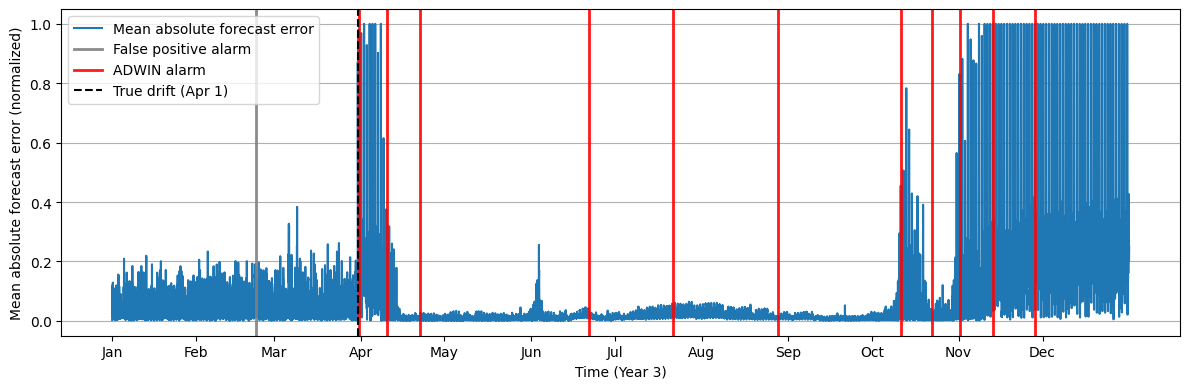

In [86]:
# ---------- 1) Build validation-based scaler for the ADWIN stream ----------
# Reuse your helper: errors_avg_abs(df) -> (e_bar, ts_labels, month_labels)
# It uses baseline_model + X_scaler internally
e_bar_val, _, _ = errors_avg_abs(val_df)                # no-drift validation
v_min = float(np.min(e_bar_val))
v_max = float(np.max(e_bar_val))
eps = 1e-9
rng = max(eps, v_max - v_min)                           # guard

def norm_from_val(e):
    """Normalize errors with validation min/max and clip to [0,1]."""
    z = (e - v_min) / rng
    return np.clip(z, 0.0, 1.0)

# ---------- 2) Year 3 (drifted) error stream, then normalize via validation stats ----------
y3_df = df_drift[df_drift['year'] == 3].reset_index(drop=True)
e_bar_y3, ts_y3, mo_y3 = errors_avg_abs(y3_df)          # ORIGINAL units
e_bar_y3_norm = norm_from_val(e_bar_y3)                 # feed this to ADWIN

# Cooldown ≈ 7 days of windows (derive from cadence)
if ts_y3.size >= 2 and np.isfinite(ts_y3).all():
    dt_sec = float(np.median(np.diff(ts_y3)))
else:
    dt_sec = 15 * 60
steps_per_day  = max(1, int(round((24 * 3600) / dt_sec)))
cooldown_steps = 7 * steps_per_day
DRIFT_TS = 70_848_000
tau_idx  = int(np.searchsorted(ts_y3, DRIFT_TS, side="left"))

# ---------- 3) ADWIN runner (delta only) with cooldown ----------
def adwin_run_with_cooldown(values_norm: np.ndarray, delta: float, cooldown_steps: int):
    """ADWIN on a normalized numeric stream (0..1) with shared cooldown."""
    adw = drift.ADWIN(delta=delta)  # clock & others = defaults
    states = np.array(["normal"] * len(values_norm), dtype=object)
    drift_idx, cooldown = [], 0
    for i, v in enumerate(values_norm):
        adw.update(float(v))
        if cooldown > 0:
            states[i] = "cooldown"; cooldown -= 1; continue
        if adw.drift_detected:
            states[i] = "drift"
            drift_idx.append(i)
            cooldown = cooldown_steps
    return {"states": states, "drift_idx": drift_idx}

# ---------- 4) Grid search over delta ONLY (normalized stream) ----------
def adwin_grid_search_delta(y3_errors_norm: np.ndarray,
                            ts_labels: np.ndarray,
                            delta_list=(0.0005, 0.001, 0.002, 0.005, 0.01),
                            cooldown_steps: int = 7*96,        # overwritten by real cadence above
                            drift_ts: int = 70_848_000,
                            dt_seconds: float = 900.0):
    tau = int(np.searchsorted(ts_labels, drift_ts, side="left"))
    rows = []
    for dlt in delta_list:
        run = adwin_run_with_cooldown(y3_errors_norm, delta=dlt, cooldown_steps=cooldown_steps)
        drifts = run["drift_idx"]

        # False positives: alarms before Apr-1
        fp = sum(ts_labels[i] < drift_ts for i in drifts)

        # Detection delay: first drift after Apr-1 (∞ if none)
        post = [i for i in drifts if ts_labels[i] >= drift_ts]
        if post:
            first = post[0]
            delay_steps = max(0, first - tau)
            delay_hours = delay_steps * (dt_seconds / 3600.0)
        else:
            first = None
            delay_hours = float("inf")

        rows.append({
            "delta": dlt,
            "false_positives": int(fp),
            "first_post_drift_idx": (first if first is not None else -1),
            "detection_delay_hours": delay_hours,
            "total_drifts": int(len(drifts))
        })

    res = pd.DataFrame(rows).sort_values(
        by=["false_positives", "detection_delay_hours", "total_drifts"]
    ).reset_index(drop=True)
    return res

# Run the search
adwin_delta_results = adwin_grid_search_delta(
    e_bar_y3_norm, ts_y3,
    delta_list=(0.001, 0.002, 0.005, 0.01, 0.0005),
    cooldown_steps=cooldown_steps,
    drift_ts=DRIFT_TS,
    dt_seconds=dt_sec
)
display(adwin_delta_results.head(10))

# ---------- 5) Plot Year 3 with BEST delta (normalized stream) ----------
best_delta = float(adwin_delta_results.iloc[0]["delta"])
print(f"\n[ADWIN best (normalized stream)] delta={best_delta} (cooldown={cooldown_steps} steps ~ 7 days)")

best_run = adwin_run_with_cooldown(e_bar_y3_norm, delta=best_delta, cooldown_steps=cooldown_steps)

idxs = np.arange(len(e_bar_y3_norm))

# ====== plotting-only change: month-name labels derived from month column ======
import calendar

xt, _ = _month_ticks(mo_y3)
xt = np.asarray(xt, dtype=int)

mo_at_ticks = np.asarray(mo_y3)[xt].astype(int)
xl = [calendar.month_abbr[m] if 1 <= m <= 12 else str(m) for m in mo_at_ticks]


# ================================================================================
# ---------- 5) Plot Year 3 with BEST delta (normalized stream) ----------
best_delta = float(adwin_delta_results.iloc[0]["delta"])
print(f"\n[ADWIN best (normalized stream)] delta={best_delta} (cooldown={cooldown_steps} steps ~ 7 days)")

best_run = adwin_run_with_cooldown(e_bar_y3_norm, delta=best_delta, cooldown_steps=cooldown_steps)

idxs = np.arange(len(e_bar_y3_norm))

# ====== month-name labels derived from month column ======
import calendar

xt, _ = _month_ticks(mo_y3)
xt = np.asarray(xt, dtype=int)
mo_at_ticks = np.asarray(mo_y3)[xt].astype(int)
xl = [calendar.month_abbr[m] if 1 <= m <= 12 else str(m) for m in mo_at_ticks]
# =========================================================

fig, ax = plt.subplots(figsize=(12, 4))

# Keep names like your screenshot
ax.plot(idxs, e_bar_y3_norm, label="Mean absolute forecast error")

# Split detected indices into true drifts (red) vs false positives (grey)
is_true = np.array([ts_y3[i] >= DRIFT_TS for i in best_run["drift_idx"]])
true_drifts = [i for i, t in zip(best_run["drift_idx"], is_true) if t]
false_pos   = [i for i, t in zip(best_run["drift_idx"], is_true) if not t]

# False positives -> grey (single legend entry)
fp_label = "False positive alarm"
for i in false_pos:
    ax.axvline(i, color="tab:gray", linestyle="-", linewidth=2.0, alpha=0.9, label=fp_label)
    fp_label = "_nolegend_"

# True drifts -> red (single legend entry)
td_label = "ADWIN alarm"
for i in true_drifts:
    ax.axvline(i, color="red", linestyle="-", linewidth=2.0, alpha=0.9, label=td_label)
    td_label = "_nolegend_"

ax.axvline(tau_idx, color="black", linestyle="--", linewidth=1.5, label="True drift (Apr 1)")

ax.set_xticks(xt)
ax.set_xticklabels(xl)
ax.set_xlabel("Time (Year 3)")
ax.set_ylabel("Mean absolute forecast error (normalized)")
ax.set_title("")
ax.grid(True, axis="y")
ax.legend()

fig.tight_layout()


out_path = "/kaggle/working/RetrofitYear3ADWIN.pdf"
fig.savefig(out_path, format="pdf", bbox_inches="tight")

plt.show()



In [67]:

def _label_rows(n_full, lookback, horizon):
    return (np.arange(lookback, n_full - horizon + 1) + (horizon - 1))

def _build_year_windows(df_year: pd.DataFrame):
    X = df_year[FEATS].to_numpy(float)
    Xs = X_scaler.transform(X)
    ys = Xs[:, idx_t].copy()
    Xw, Yw = make_windows_multi(Xs, ys, LOOKBACK, H, stride=1)
    n_full = len(df_year)
    lbl_idx = _label_rows(n_full, LOOKBACK, H)
    ts_lab  = df_year.iloc[lbl_idx]['timestamp_sec'].to_numpy()
    mo_lab  = df_year.iloc[lbl_idx]['month'].to_numpy()
    return Xw, Yw, ts_lab, mo_lab, lbl_idx

def _predict_unscaled(model, Xw, Yw):
    Y_hat_s = model.predict(Xw, verbose=0)
    Y_true  = inv_steps_from_X_scaler(Yw,     X_scaler, idx_t, H)
    Y_hat   = inv_steps_from_X_scaler(Y_hat_s, X_scaler, idx_t, H)
    return Y_true, Y_hat

def _window_mae(y_true_row, y_hat_row):
    return float(np.mean(np.abs(y_true_row - y_hat_row)))

def _window_rmse(y_true_row, y_hat_row):
    return float(np.sqrt(np.mean((y_true_row - y_hat_row)**2)))

def _window_smape(y_true_row, y_hat_row, eps=1e-6):
    num = np.abs(y_true_row - y_hat_row)
    den = (np.abs(y_true_row) + np.abs(y_hat_row)).clip(min=eps)
    return float(np.mean(2.0 * num / den) * 100.0)

def _rolling_mean(values, k):
    if k <= 1: 
        return values.astype(float)
    out = np.full(len(values), np.nan, float)
    if len(values) >= k:
        csum = np.cumsum(values, dtype=float)
        out[k-1:] = (csum[k-1:] - np.concatenate(([0.0], csum[:-k])))/k
    return out

def _steps_per_day_from_labels(ts_labels):
    if ts_labels.size >= 2 and np.isfinite(ts_labels).all():
        dt_sec = float(np.median(np.diff(ts_labels)))
    else:
        dt_sec = 15*60
    return max(1, int(round((24*3600)/dt_sec))), dt_sec

def _month_ticks(months_arr):
    starts, labels, seen = [], [], set()
    for i, m in enumerate(months_arr):
        if m not in seen:
            starts.append(i); labels.append(f"M{int(m):02d}"); seen.add(m)
    return np.array(starts), labels

def _per_horizon_smape(y_true_2d, y_hat_2d, eps=1e-6):
    Hh = y_true_2d.shape[1]
    vals = []
    for h in range(Hh):
        num = np.abs(y_true_2d[:, h] - y_hat_2d[:, h])
        den = (np.abs(y_true_2d[:, h]) + np.abs(y_hat_2d[:, h])).clip(min=eps)
        vals.append(float(np.mean(2.0 * num / den) * 100.0))
    return vals

def _recovery_speed_indices(base_roll, adapt_roll, drift_indices, consec):
    recov = []
    N = len(base_roll)
    for d in drift_indices:
        r, i, count = None, max(0, d), 0
        while i < N:
            a = adapt_roll[i]; b = base_roll[i]
            if np.isfinite(a) and np.isfinite(b) and (a <= b):
                count += 1
                if count >= consec:
                    r = i - consec + 1
                    break
            else:
                count = 0
            i += 1
        recov.append(r)
    return recov


In [39]:
# PRETRAIN_LR   = 0.0007509794596043137
# FT_LR         = PRETRAIN_LR / 10.0

[ADWIN-online] Using best delta = 0.001
Model is found! :)


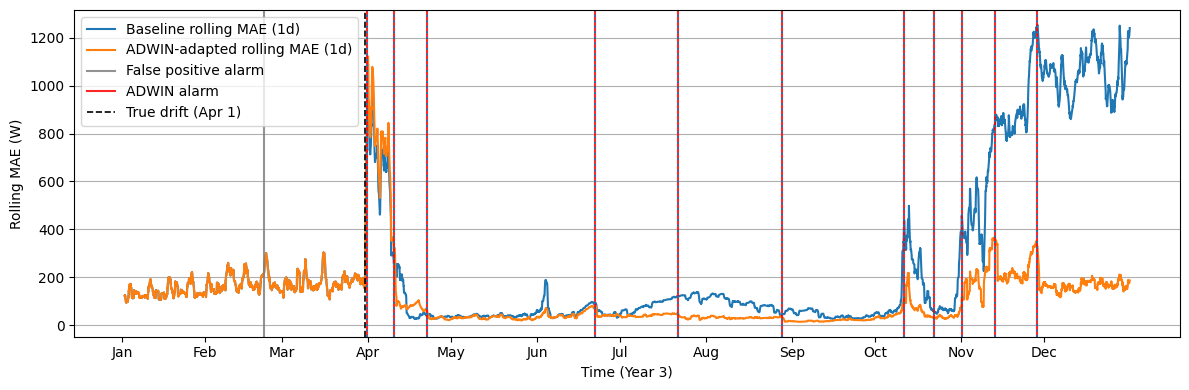

\\nADWIN Recovery summary (MAE-based, using ADAPT hits):
  Adapt@ 8479: recovery index 9475  (~249.0 h after adapt)
  Adapt@ 9439: recovery index 9475  (~9.0 h after adapt)
  Adapt@ 10559: recovery index 10608  (~12.2 h after adapt)
  Adapt@ 16383: recovery index 16383  (~0.0 h after adapt)
  Adapt@ 19263: recovery index 19263  (~0.0 h after adapt)
  Adapt@ 22879: recovery index 22879  (~0.0 h after adapt)
  Adapt@ 27103: recovery index 27103  (~0.0 h after adapt)
  Adapt@ 28159: recovery index 28159  (~0.0 h after adapt)
  Adapt@ 29119: recovery index 29119  (~0.0 h after adapt)
  Adapt@ 30271: recovery index 30271  (~0.0 h after adapt)
  Adapt@ 31711: recovery index 31711  (~0.0 h after adapt)
\\n=== ADWIN drift summary (Year 3) ===


count_all_drifts  false_positives  adapt_drift_hits  first_post_drift_idx  \
0                12                1                11                  8479   

   detection_delay_hours  
0                   11.0

\\n=== Year 3 — Aggregate metrics (means over windows) ===


MAE_mean  RMSE_mean  sMAPE_mean%  MAPE_mean%  WAPE%
Baseline         255.1      289.1        134.5     7,847.8   17.6
ADWIN-ONLINE     114.0      131.5        129.4     3,486.5    7.8

\\n=== Year 3 — Per-horizon metrics (baseline vs ADWIN) ===


horizon  MAE_base  MAE_adpt  RMSE_base  RMSE_adpt  sMAPE%_base  sMAPE%_adpt  \
0     t+1     223.0      93.0      783.5      285.6        132.9        128.4   
1     t+2     232.2     103.4      653.9      312.6        134.1        129.1   
2     t+3     270.8     121.6      746.1      367.7        135.0        130.1   
3     t+4     294.4     138.1      721.6      386.4        135.8        130.0   

   MAPE%_base  MAPE%_adpt  
0     6,594.3     3,380.1  
1     7,323.1     3,381.3  
2     8,559.9     3,544.9  
3     8,914.0     3,639.7

\\n=== Year 3 — Global metrics (flattened over all windows x horizons) ===


MAE_global  RMSE_global  sMAPE_global%  MAPE_global%  \
Baseline           255.1        727.8          134.5       7,847.8   
ADWIN-ONLINE       114.0        340.5          129.4       3,486.5   

              WAPE_global%  
Baseline              17.6  
ADWIN-ONLINE           7.8

In [69]:
# ===================== ADWIN (ONLINE rolling-MAE) — Year 3 =====================
# Key change vs your block:
#   - We create a FRESH adaptive model cloned from baseline at t=0
#   - We compute the ADAPTIVE MAE stream ONLINE (predict -> maybe drift -> fine-tune -> next step)
#   - The rolling MAE plot is built from that streamed MAE (so you see the moment fine-tuning starts)



# ===================== Configs =====================
PRETRAIN_LR   = 0.0007509794596043137
FT_LR         = PRETRAIN_LR / 10.0
FT_DAYS       = 7
FT_EPOCHS     = 5
FT_BATCH      = 41
FT_PATIENCE   = 2
ROLL_DAYS     = 1
COOLDOWN_DAYS = 7
ONLY_AFTER_TS = 70_848_000             # Apr-1 Year 3
H             = HORIZON

RESET_AFTER_FT = False

# -------------------- 0) Helpers --------------------
def _window_mae(y_true_row, y_hat_row):
    return float(np.mean(np.abs(y_true_row - y_hat_row)))

def _window_rmse(y_true_row, y_hat_row):
    return float(np.sqrt(np.mean((y_true_row - y_hat_row)**2)))

def _window_smape(y_true_row, y_hat_row, eps=1e-6):
    num = np.abs(y_true_row - y_hat_row)
    den = (np.abs(y_true_row) + np.abs(y_hat_row)).clip(min=eps)
    return float(np.mean(2.0 * num / den) * 100.0)

# ---------- FIXED: MAPE (use target-unit epsilon floor) ----------
# Use eps=1.0 (in target units, e.g., W) by default to avoid exploding MAPE near zero.
def _window_mape(y_true_row, y_hat_row, eps=1.0):
    den = np.maximum(np.abs(y_true_row), eps)
    return float(np.mean(np.abs((y_true_row - y_hat_row) / den)) * 100.0)
# ---------------------------------------------------------------

def _rolling_mean(values, k):
    if k <= 1:
        return values.astype(float)
    out = np.full(len(values), np.nan, float)
    if len(values) >= k:
        csum = np.cumsum(values, dtype=float)
        out[k-1:] = (csum[k-1:] - np.concatenate(([0.0], csum[:-k])))/k
    return out

def _steps_per_day_from_labels(ts_labels):
    if ts_labels.size >= 2 and np.isfinite(ts_labels).all():
        dt_sec = float(np.median(np.diff(ts_labels)))
    else:
        dt_sec = 15*60
    return max(1, int(round((24*3600)/dt_sec))), dt_sec

def _recovery_speed_indices(base_roll, adapt_roll, drift_indices, consec):
    recov, N = [], len(base_roll)
    for d in drift_indices:
        r, i, count = None, max(0, d), 0
        while i < N:
            a = adapt_roll[i]; b = base_roll[i]
            if np.isfinite(a) and np.isfinite(b) and (a <= b):
                count += 1
                if count >= consec:
                    r = i - consec + 1
                    break
            else:
                count = 0
            i += 1
        recov.append(r)
    return recov

def _month_ticks_named(month_arr):
    starts, labels, seen = [], [], set()
    for i, m in enumerate(np.asarray(month_arr).astype(int)):
        if m not in seen:
            starts.append(i)
            labels.append(calendar.month_abbr[m] if 1 <= m <= 12 else str(m))
            seen.add(m)
    return np.asarray(starts, int), labels


df_src = df_drift
    

# -------------------- 2) Best delta --------------------
# If you want to hard-force best delta for gradual, set best_delta=0.0005 here.
if 'adwin_delta_results' in globals() and len(adwin_delta_results):
    best_delta = float(adwin_delta_results.iloc[0]['delta'])
else:
    best_delta = 0.005
print(f"[ADWIN-online] Using best delta = {best_delta}")

# -------------------- 3) Build Year-3 windows & baseline streams --------------------
y3_df = df_src[df_src['year'] == 3].reset_index(drop=True)
X3_win, Y3_win, ts3_lab, mo3_lab, _ = _build_year_windows(y3_df)

steps_per_day, dt_sec = _steps_per_day_from_labels(ts3_lab)
roll_steps     = ROLL_DAYS * steps_per_day
ft_steps       = FT_DAYS * steps_per_day
cooldown_steps = COOLDOWN_DAYS * steps_per_day
tau_idx        = int(np.searchsorted(ts3_lab, ONLY_AFTER_TS, side="left"))

# Baseline truth & preds once (fixed reference)
Y3_true_base, Y3_hat_base = _predict_unscaled(baseline_model, X3_win, Y3_win)
mae3_base_win   = np.array([_window_mae(Y3_true_base[i], Y3_hat_base[i]) for i in range(len(X3_win))], float)
rmse3_base_win  = np.array([_window_rmse(Y3_true_base[i], Y3_hat_base[i]) for i in range(len(X3_win))], float)
smape3_base_win = np.array([_window_smape(Y3_true_base[i], Y3_hat_base[i]) for i in range(len(X3_win))], float)
# ---------- ADDED: MAPE (baseline per-window) ----------
mape3_base_win  = np.array([_window_mape(Y3_true_base[i], Y3_hat_base[i]) for i in range(len(X3_win))], float)
# ------------------------------------------------------
mae3_base_roll  = _rolling_mean(mae3_base_win, roll_steps)

# -------------------- 4) Validation-normalized ADWIN stream (fixed) --------------------
# expects e_bar_val from your validation calibration cell
assert 'e_bar_val' in globals(), "e_bar_val not found. Run your validation MAE-per-window calibration first."
v_min = float(np.min(e_bar_val))
v_max = float(np.max(e_bar_val))
v_rng = float(max(1e-12, v_max - v_min))

def _norm_from_val(e):
    return np.clip((e - v_min) / v_rng, 0.0, 1.0)

mae3_base_norm = _norm_from_val(mae3_base_win)

# -------------------- 5) Create a FRESH adaptive model (start identical to baseline at t=0) --------------------
# Use your helper if available; else clone safely.
if 'adwin_model' in globals():
    print('Model is found! :)')
else:
    print('Model did not found! :(')
    

# compile for fine-tuning
loss_to_use = baseline_model.loss if getattr(baseline_model, "loss", None) is not None else "mse"
metrics_to_use = [m for m in (baseline_model.metrics if hasattr(baseline_model, "metrics") else [])
                  if getattr(m, "name", "") != "loss"]

adwin_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FT_LR, clipnorm=1.0),
    loss=loss_to_use,
    metrics=metrics_to_use
)

# -------------------- 6) ONLINE loop: predict -> update ADWIN -> maybe fine-tune -> next step --------------------
adw = drift.ADWIN(delta=best_delta)

adw_all_drifts = []   # counted alarms w/ cooldown (pre + post Apr)
adw_adapt_hits = []   # alarms we actually fine-tune on (post Apr & not in cooldown)
last_alarm_idx = -10**12
adapt_cooldown = 0

mae_adapt_win_list   = []
rmse_adapt_win_list  = []
smape_adapt_win_list = []
# ---------- ADDED: MAPE stream ----------
mape_adapt_win_list  = []
# -------------------------------------
Y3_hat_adapt_stream  = []
Y3_true_adapt_stream = []

for i in range(len(X3_win)):
    # (A) ONLINE prediction with CURRENT model state
    yhat_s   = adwin_model.predict(X3_win[i:i+1], verbose=0)[0]
    y_true_r = inv_steps_from_X_scaler(Y3_win[i:i+1], X_scaler, idx_t, H)[0]
    y_hat_r  = inv_steps_from_X_scaler(yhat_s.reshape(1, -1), X_scaler, idx_t, H)[0]

    Y3_true_adapt_stream.append(y_true_r)
    Y3_hat_adapt_stream.append(y_hat_r)

    mae_adapt_win_list.append(_window_mae(y_true_r, y_hat_r))
    rmse_adapt_win_list.append(_window_rmse(y_true_r, y_hat_r))
    smape_adapt_win_list.append(_window_smape(y_true_r, y_hat_r))
    # ---------- ADDED: MAPE per-window ----------
    mape_adapt_win_list.append(_window_mape(y_true_r, y_hat_r))
    # -------------------------------------------

    # (B) ALWAYS update ADWIN from the beginning on the FIXED baseline stream
    adw.update(float(mae3_base_norm[i]))

    # (C) cooldown counting for alarms (same semantics as your other detectors)
    if adw.drift_detected and (i - last_alarm_idx) >= cooldown_steps:
        adw_all_drifts.append(i)
        last_alarm_idx = i

        # (D) Gate adaptation: only after Apr-1 AND not in adaptation cooldown
        if ts3_lab[i] >= ONLY_AFTER_TS and adapt_cooldown == 0:
            adw_adapt_hits.append(i)

            # Fine-tune on last FT_DAYS windows ending at i
            s = max(0, i - ft_steps + 1)
            X_ft = X3_win[s:i+1]
            Y_ft = Y3_win[s:i+1]
            if len(X_ft) >= 10:
                es = tf.keras.callbacks.EarlyStopping(
                    monitor="val_loss", patience=FT_PATIENCE, restore_best_weights=True
                )
                adwin_model.fit(
                    X_ft, Y_ft,
                    validation_split=0.1,
                    epochs=FT_EPOCHS,
                    batch_size=FT_BATCH,
                    shuffle=True,
                    verbose=0,
                    callbacks=[es]
                )

            if RESET_AFTER_FT:
                adw = drift.ADWIN(delta=best_delta)

            adapt_cooldown = cooldown_steps

    if adapt_cooldown > 0:
        adapt_cooldown -= 1

# -------------------- 7) ONLINE rolling MAE (built from streamed errors) --------------------
mae_adapt_win  = np.asarray(mae_adapt_win_list, float)
mae_adapt_roll = _rolling_mean(mae_adapt_win, roll_steps)

# -------------------- 8) Plot (online curves + drift markers) --------------------
xticks, xlabels = _month_ticks_named(mo3_lab)

plt.figure(figsize=(12, 4))
plt.plot(mae3_base_roll, label=f"Baseline rolling MAE ({ROLL_DAYS}d)")
plt.plot(mae_adapt_roll, label=f"ADWIN-adapted rolling MAE ({ROLL_DAYS}d)")

# counted drift alarms (pre-Apr gray, post-Apr red) — legend like your PH-style plots
fp_label = "False positive alarm"
td_label = "ADWIN alarm"
for di in adw_all_drifts:
    if ts3_lab[di] >= ONLY_AFTER_TS:
        plt.axvline(di, color="red", linestyle="-", linewidth=1.5, alpha=0.85, label=td_label)
        td_label = "_nolegend_"
    else:
        plt.axvline(di, color="tab:gray", linestyle="-", linewidth=1.5, alpha=0.85, label=fp_label)
        fp_label = "_nolegend_"

# keep the fine-tune start markers but do NOT add them to the legend
for di in adw_adapt_hits:
    plt.axvline(di, linestyle=":", linewidth=1.5, alpha=0.9, label="_nolegend_")

plt.axvline(tau_idx, color="black", linestyle="--", linewidth=1.2, label="True drift (Apr 1)")
plt.xticks(xticks, xlabels)
plt.xlabel("Time (Year 3)")
plt.ylabel("Rolling MAE (W)")
plt.title("")
plt.grid(True, axis="y")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------- 9) Recovery speed (MAE rolling) --------------------
consec = roll_steps
adw_recovery = _recovery_speed_indices(mae3_base_roll, mae_adapt_roll, adw_adapt_hits, consec)

if len(adw_adapt_hits):
    print("\\\\nADWIN Recovery summary (MAE-based, using ADAPT hits):")
    for d, r in zip(adw_adapt_hits, adw_recovery):
        if r is None:
            print(f"  Adapt@ {d}: no stable recovery found (≥{consec} consecutive windows).")
        else:
            hours = (r - d) * (dt_sec / 3600.0)
            print(f"  Adapt@ {d}: recovery index {r}  (~{hours:.1f} h after adapt)")
else:
    print("\\\\nNo ADWIN adaptations => no recovery events.")

# -------------------- 10) Summary + Tables (no extra plots) --------------------
fp_count   = int(np.sum(ts3_lab[np.array(adw_all_drifts, int)] < ONLY_AFTER_TS)) if len(adw_all_drifts) else 0
post_hits  = [i for i in adw_all_drifts if i >= tau_idx]
first_post = post_hits[0] if len(post_hits) else None
delay_h    = ((first_post - tau_idx) * (dt_sec / 3600.0)) if first_post is not None else np.inf

summary_table = pd.DataFrame([{
    "count_all_drifts":      len(adw_all_drifts),
    "false_positives":       fp_count,
    "adapt_drift_hits":      len(adw_adapt_hits),
    "first_post_drift_idx":  (first_post if first_post is not None else -1),
    "detection_delay_hours": (delay_h if np.isfinite(delay_h) else None)
}])
print("\\\\n=== ADWIN drift summary (Year 3) ===")
display(summary_table)

mae_adapt_win_arr   = np.asarray(mae_adapt_win_list, float)
rmse_adapt_win_arr  = np.asarray(rmse_adapt_win_list, float)
smape_adapt_win_arr = np.asarray(smape_adapt_win_list, float)
# ---------- ADDED: MAPE array ----------
mape_adapt_win_arr  = np.asarray(mape_adapt_win_list, float)
# ------------------------------------

# ---------- ADDED: WAPE (over all windows & horizons) ----------
wape_base = (np.sum(np.abs(Y3_true_base - Y3_hat_base)) / max(np.sum(np.abs(Y3_true_base)), 1e-12)) * 100.0
wape_adpt = (np.sum(np.abs(np.asarray(Y3_true_adapt_stream, float) - np.asarray(Y3_hat_adapt_stream, float)))
             / max(np.sum(np.abs(np.asarray(Y3_true_adapt_stream, float))), 1e-12)) * 100.0
# --------------------------------------------------------------

# ---------- ADDED: MAPE (means over windows) ----------
mape_base_mean = float(np.mean(mape3_base_win))
mape_adpt_mean = float(np.mean(mape_adapt_win_arr))
# -----------------------------------------------------

aggregate_tbl = pd.DataFrame({
    "MAE_mean":    [float(np.mean(mae3_base_win)),   float(np.mean(mae_adapt_win_arr))],
    "RMSE_mean":   [float(np.mean(rmse3_base_win)),  float(np.mean(rmse_adapt_win_arr))],
    "sMAPE_mean%": [float(np.mean(smape3_base_win)), float(np.mean(smape_adapt_win_arr))],
    "MAPE_mean%":  [mape_base_mean,                  mape_adpt_mean],
    "WAPE%":       [float(wape_base),                float(wape_adpt)]
}, index=["Baseline", "ADWIN-ONLINE"])
print("\\\\n=== Year 3 — Aggregate metrics (means over windows) ===")
display(aggregate_tbl)

# per-horizon table: baseline arrays vs streamed adaptive preds (aligned)
Y3_hat_adapt_stream = np.asarray(Y3_hat_adapt_stream, float)
Y3_true_adapt_stream = np.asarray(Y3_true_adapt_stream, float)
Hh = Y3_hat_adapt_stream.shape[1]

mae_base_h  = [float(np.mean(np.abs(Y3_true_base[:,h] - Y3_hat_base[:,h]))) for h in range(Hh)]
rmse_base_h = [float(np.sqrt(np.mean((Y3_true_base[:,h] - Y3_hat_base[:,h])**2))) for h in range(Hh)]
smape_base_h = []
for h in range(Hh):
    num = np.abs(Y3_true_base[:,h] - Y3_hat_base[:,h])
    den = (np.abs(Y3_true_base[:,h]) + np.abs(Y3_hat_base[:,h])).clip(min=1e-6)
    smape_base_h.append(float(np.mean(2.0 * num / den) * 100.0))

# ---------- FIXED: MAPE per-horizon (baseline) ----------
mape_base_h = []
for h in range(Hh):
    den = np.maximum(np.abs(Y3_true_base[:,h]), 1.0)
    mape_base_h.append(float(np.mean(np.abs((Y3_true_base[:,h] - Y3_hat_base[:,h]) / den)) * 100.0))
# ------------------------------------------------------

mae_adpt_h  = [float(np.mean(np.abs(Y3_true_adapt_stream[:,h] - Y3_hat_adapt_stream[:,h]))) for h in range(Hh)]
rmse_adpt_h = [float(np.sqrt(np.mean((Y3_true_adapt_stream[:,h] - Y3_hat_adapt_stream[:,h])**2))) for h in range(Hh)]
smape_adpt_h = []
for h in range(Hh):
    num = np.abs(Y3_true_adapt_stream[:,h] - Y3_hat_adapt_stream[:,h])
    den = (np.abs(Y3_true_adapt_stream[:,h]) + np.abs(Y3_hat_adapt_stream[:,h])).clip(min=1e-6)
    smape_adpt_h.append(float(np.mean(2.0 * num / den) * 100.0))

# ---------- FIXED: MAPE per-horizon (adaptive) ----------
mape_adpt_h = []
for h in range(Hh):
    den = np.maximum(np.abs(Y3_true_adapt_stream[:,h]), 1.0)
    mape_adpt_h.append(float(np.mean(np.abs((Y3_true_adapt_stream[:,h] - Y3_hat_adapt_stream[:,h]) / den)) * 100.0))
# ------------------------------------------------------

per_horizon_tbl = pd.DataFrame({
    "horizon":      [f"t+{i+1}" for i in range(Hh)],
    "MAE_base":     mae_base_h,   "MAE_adpt":      mae_adpt_h,
    "RMSE_base":    rmse_base_h,  "RMSE_adpt":     rmse_adpt_h,
    "sMAPE%_base":  smape_base_h, "sMAPE%_adpt":   smape_adpt_h,
    "MAPE%_base":   mape_base_h,  "MAPE%_adpt":    mape_adpt_h
})
print("\\\\n=== Year 3 — Per-horizon metrics (baseline vs ADWIN) ===")
display(per_horizon_tbl)

# -------------------- ADDED: Global metrics (flattened over all windows x horizons) --------------------
_eps_g = 1e-6

_diff_base = (Y3_true_base - Y3_hat_base)
mae_base_global  = float(np.mean(np.abs(_diff_base)))
rmse_base_global = float(np.sqrt(np.mean(_diff_base ** 2)))
_den_base = (np.abs(Y3_true_base) + np.abs(Y3_hat_base)).clip(min=_eps_g)
smape_base_global = float(np.mean(2.0 * np.abs(_diff_base) / _den_base) * 100.0)
# ---------- FIXED: MAPE global (baseline) ----------
_den_mape_base = np.maximum(np.abs(Y3_true_base), 1.0)
mape_base_global = float(np.mean(np.abs(_diff_base) / _den_mape_base) * 100.0)
# -----------------------------------------------
wape_base_global  = float(wape_base)

_diff_adpt = (Y3_true_adapt_stream - Y3_hat_adapt_stream)
mae_adpt_global  = float(np.mean(np.abs(_diff_adpt)))
rmse_adpt_global = float(np.sqrt(np.mean(_diff_adpt ** 2)))
_den_adpt = (np.abs(Y3_true_adapt_stream) + np.abs(Y3_hat_adapt_stream)).clip(min=_eps_g)
smape_adpt_global = float(np.mean(2.0 * np.abs(_diff_adpt) / _den_adpt) * 100.0)
# ---------- FIXED: MAPE global (adaptive) ----------
_den_mape_adpt = np.maximum(np.abs(Y3_true_adapt_stream), 1.0)
mape_adpt_global = float(np.mean(np.abs(_diff_adpt) / _den_mape_adpt) * 100.0)
# ----------------------------------------------
wape_adpt_global  = float(wape_adpt)

global_tbl = pd.DataFrame({
    "MAE_global":     [mae_base_global,   mae_adpt_global],
    "RMSE_global":    [rmse_base_global,  rmse_adpt_global],
    "sMAPE_global%":  [smape_base_global, smape_adpt_global],
    "MAPE_global%":   [mape_base_global,  mape_adpt_global],
    "WAPE_global%":   [wape_base_global,  wape_adpt_global],
}, index=["Baseline", "ADWIN-ONLINE"])

print("\\\\n=== Year 3 — Global metrics (flattened over all windows x horizons) ===")
display(global_tbl)
# -----------------------------------------------------------------------------------------------


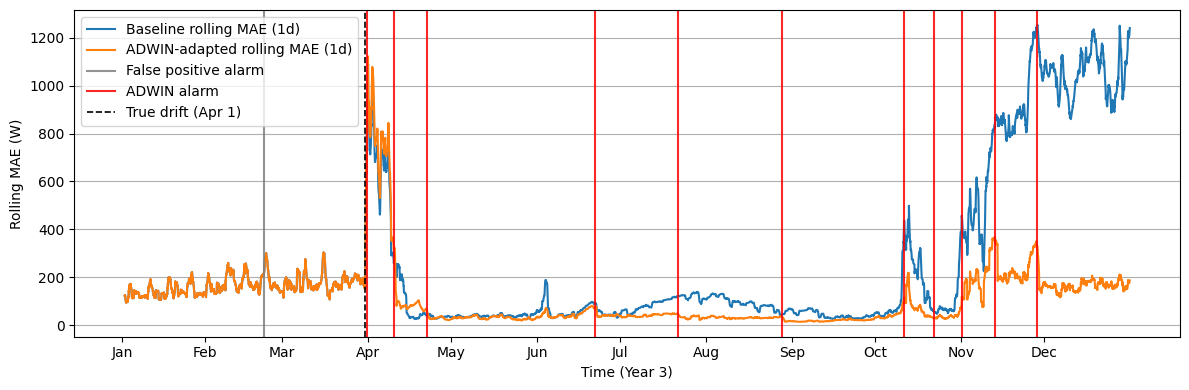

In [75]:
xticks, xlabels = _month_ticks_named(mo3_lab)

plt.figure(figsize=(12,4))
plt.plot(mae3_base_roll,  label=f"Baseline rolling MAE ({ROLL_DAYS}d)")
plt.plot(mae_adapt_roll,  label=f"ADWIN-adapted rolling MAE ({ROLL_DAYS}d)")

# counted drift alarms (pre-Apr = False positives in grey, post-Apr = Drift in red)
fp_lab = "False positive alarm"
dr_lab = "ADWIN alarm"
for di in adw_all_drifts:
    if ts3_lab[di] >= ONLY_AFTER_TS:
        plt.axvline(di, color="red", linestyle="-", linewidth=1.5, alpha=0.85, label=dr_lab)
        dr_lab = "_nolegend_"  # labels starting with "_" are excluded from auto-legend [web:18]
    else:
        plt.axvline(di, color="tab:gray", linestyle="-", linewidth=1.5, alpha=0.85, label=fp_lab)
        fp_lab = "_nolegend_"  # labels starting with "_" are excluded from auto-legend [web:18]

plt.axvline(tau_idx, color="black", linestyle="--", linewidth=1.2, label="True drift (Apr 1)")
plt.xticks(xticks, xlabels)
plt.xlabel("Time (Year 3)"); plt.ylabel("Rolling MAE (W)")
plt.title("")
plt.grid(True, axis='y'); plt.legend(); plt.tight_layout();

out_path = "/kaggle/working/RetrofitYear3FinetuningADWIN.pdf"
plt.gcf().savefig(out_path, format="pdf", bbox_inches="tight")  # <- save current 
plt.show()



=== Year 4 — Per-horizon metrics (Baseline vs ADWIN-Adapted) ===


horizon  MAE_base  MAE_adpt  RMSE_base  RMSE_adpt  sMAPE%_base  sMAPE%_adpt  \
0     t+1     304.3     118.7    1,033.7      220.2        168.7        163.5   
1     t+2     305.9     123.4      843.3      197.3        171.3        163.9   
2     t+3     355.3     128.8      941.9      201.2        172.5        165.0   
3     t+4     380.9     145.2      869.9      226.8        173.7        166.0   

   MAPE%_base  MAPE%_adpt  
0     8,391.6     8,167.9  
1     9,514.6     8,316.3  
2    11,361.8     8,098.8  
3    12,449.3     8,825.5


=== Year 4 — Aggregate metrics (means over windows) ===


MAE_mean  RMSE_mean  sMAPE_mean%  MAPE_mean%  WAPE%
Baseline           336.6      384.0        171.6    10,429.3  149.4
ADWIN-Adaptive     129.0      140.0        164.6     8,352.1   57.3


=== Year 4 — Global errors (flattened over all windows x horizons) ===


MAE_global  RMSE_global  sMAPE_global%  MAPE_global%
Baseline             336.6        925.1          171.6      10,429.3
ADWIN-Adaptive       129.0        211.7          164.6       8,352.1

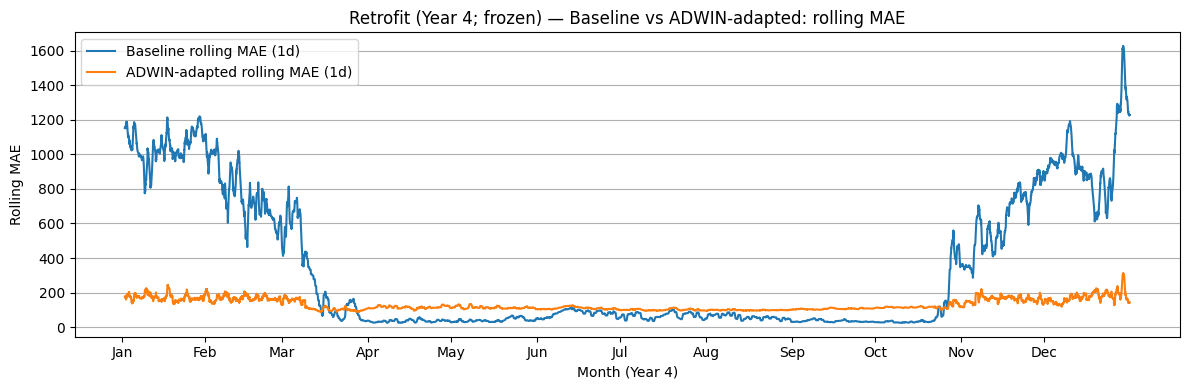

In [77]:
# ================= Year 4 — ADWIN (tables + rolling MAE only) =================

# 1) Build Year-4 windows
y4_df = df_drift[df_drift['year'] == 4].reset_index(drop=True)
assert len(y4_df) >= LOOKBACK + HORIZON + 1, "Year 4 has insufficient rows."

X4_win, Y4_win, ts4_lab, mo4_lab, _ = _build_year_windows(y4_df)

# cadence & rolling window (1 day)
steps_per_day, _ = _steps_per_day_from_labels(ts4_lab)
ROLL_DAYS  = 1
roll_steps = max(1, ROLL_DAYS * steps_per_day)

# 2) Predict (baseline vs ADWIN-adapted)
Y4_true, Y4_hat_base  = _predict_unscaled(baseline_model, X4_win, Y4_win)
_,        Y4_hat_adpt = _predict_unscaled(adwin_model,   X4_win, Y4_win)

H = Y4_true.shape[1]

# 3) Per-horizon tables (MAE, RMSE, sMAPE)
mae_base_h  = [float(np.mean(np.abs(Y4_true[:,h] - Y4_hat_base[:,h]))) for h in range(H)]
mae_adpt_h  = [float(np.mean(np.abs(Y4_true[:,h] - Y4_hat_adpt[:,h]))) for h in range(H)]

rmse_base_h = [float(np.sqrt(np.mean((Y4_true[:,h] - Y4_hat_base[:,h])**2))) for h in range(H)]
rmse_adpt_h = [float(np.sqrt(np.mean((Y4_true[:,h] - Y4_hat_adpt[:,h])**2))) for h in range(H)]

smape_base_h = []
smape_adpt_h = []
for h in range(H):
    num_b = np.abs(Y4_true[:,h] - Y4_hat_base[:,h])
    den_b = (np.abs(Y4_true[:,h]) + np.abs(Y4_hat_base[:,h])).clip(min=1e-6)
    smape_base_h.append(float(np.mean(2.0 * num_b / den_b) * 100.0))

    num_a = np.abs(Y4_true[:,h] - Y4_hat_adpt[:,h])
    den_a = (np.abs(Y4_true[:,h]) + np.abs(Y4_hat_adpt[:,h])).clip(min=1e-6)
    smape_adpt_h.append(float(np.mean(2.0 * num_a / den_a) * 100.0))

# -------------------- FIXED: MAPE per-horizon (eps floor = 1.0 in target units) --------------------
mape_base_h = []
mape_adpt_h = []
for h in range(H):
    den_b = np.maximum(np.abs(Y4_true[:,h]), 1.0)
    mape_base_h.append(float(np.mean(np.abs((Y4_true[:,h] - Y4_hat_base[:,h]) / den_b)) * 100.0))

    den_a = np.maximum(np.abs(Y4_true[:,h]), 1.0)
    mape_adpt_h.append(float(np.mean(np.abs((Y4_true[:,h] - Y4_hat_adpt[:,h]) / den_a)) * 100.0))
# ---------------------------------------------------------------------------------------------------

per_horizon_tbl = pd.DataFrame({
    "horizon":     [f"t+{i+1}" for i in range(H)],
    "MAE_base":     mae_base_h,   "MAE_adpt":     mae_adpt_h,
    "RMSE_base":    rmse_base_h,  "RMSE_adpt":    rmse_adpt_h,
    "sMAPE%_base":  smape_base_h, "sMAPE%_adpt":  smape_adpt_h,
    "MAPE%_base":   mape_base_h,  "MAPE%_adpt":   mape_adpt_h
})

print("=== Year 4 — Per-horizon metrics (Baseline vs ADWIN-Adapted) ===")
display(per_horizon_tbl)

# 4) Per-window “normal” errors (for aggregate table + rolling MAE)
mae4_base_win  = np.array([_window_mae (Y4_true[i], Y4_hat_base[i])  for i in range(len(X4_win))], float)
mae4_adpt_win  = np.array([_window_mae (Y4_true[i], Y4_hat_adpt[i]) for i in range(len(X4_win))], float)

rmse4_base_win = np.array([_window_rmse(Y4_true[i], Y4_hat_base[i])  for i in range(len(X4_win))], float)
rmse4_adpt_win = np.array([_window_rmse(Y4_true[i], Y4_hat_adpt[i]) for i in range(len(X4_win))], float)

smape4_base_win = np.array([_window_smape(Y4_true[i], Y4_hat_base[i])  for i in range(len(X4_win))], float)
smape4_adpt_win = np.array([_window_smape(Y4_true[i], Y4_hat_adpt[i]) for i in range(len(X4_win))], float)

# -------------------- FIXED: MAPE per-window arrays (eps floor = 1.0 in target units) --------------------
mape4_base_win = np.array(
    [float(np.mean(np.abs((Y4_true[i] - Y4_hat_base[i]) / np.maximum(np.abs(Y4_true[i]), 1.0))) * 100.0)
     for i in range(len(X4_win))],
    float
)
mape4_adpt_win = np.array(
    [float(np.mean(np.abs((Y4_true[i] - Y4_hat_adpt[i]) / np.maximum(np.abs(Y4_true[i]), 1.0))) * 100.0)
     for i in range(len(X4_win))],
    float
)
# ---------------------------------------------------------------------------------------------------------

# WAPE over all windows & horizons
wape_base = (np.sum(np.abs(Y4_true - Y4_hat_base)) / max(np.sum(np.abs(Y4_true)), 1e-12)) * 100.0
wape_adpt = (np.sum(np.abs(Y4_true - Y4_hat_adpt)) / max(np.sum(np.abs(Y4_true)), 1e-12)) * 100.0

aggregate_tbl = pd.DataFrame({
    "MAE_mean":    [float(np.mean(mae4_base_win)),   float(np.mean(mae4_adpt_win))],
    "RMSE_mean":   [float(np.mean(rmse4_base_win)),  float(np.mean(rmse4_adpt_win))],
    "sMAPE_mean%": [float(np.mean(smape4_base_win)), float(np.mean(smape4_adpt_win))],
    "MAPE_mean%":  [float(np.mean(mape4_base_win)),  float(np.mean(mape4_adpt_win))],
    "WAPE%":       [float(wape_base),                float(wape_adpt)]
}, index=["Baseline", "ADWIN-Adaptive"])

print("\n=== Year 4 — Aggregate metrics (means over windows) ===")
display(aggregate_tbl)

# -------------------- Global errors (flattened over all windows x horizons) --------------------
_eps_g = 1e-6

_diff_base = (Y4_true - Y4_hat_base)
mae_base_global  = float(np.mean(np.abs(_diff_base)))
rmse_base_global = float(np.sqrt(np.mean(_diff_base ** 2)))
_den_base = (np.abs(Y4_true) + np.abs(Y4_hat_base)).clip(min=_eps_g)
smape_base_global = float(np.mean(2.0 * np.abs(_diff_base) / _den_base) * 100.0)
# -------------------- FIXED: MAPE global (baseline) --------------------
_den_mape_base = np.maximum(np.abs(Y4_true), 1.0)
mape_base_global = float(np.mean(np.abs(_diff_base) / _den_mape_base) * 100.0)
# ----------------------------------------------------------------------

_diff_adpt = (Y4_true - Y4_hat_adpt)
mae_adpt_global  = float(np.mean(np.abs(_diff_adpt)))
rmse_adpt_global = float(np.sqrt(np.mean(_diff_adpt ** 2)))
_den_adpt = (np.abs(Y4_true) + np.abs(Y4_hat_adpt)).clip(min=_eps_g)
smape_adpt_global = float(np.mean(2.0 * np.abs(_diff_adpt) / _den_adpt) * 100.0)
# -------------------- FIXED: MAPE global (adaptive) --------------------
_den_mape_adpt = np.maximum(np.abs(Y4_true), 1.0)
mape_adpt_global = float(np.mean(np.abs(_diff_adpt) / _den_mape_adpt) * 100.0)
# ----------------------------------------------------------------------

global_tbl = pd.DataFrame({
    "MAE_global":    [mae_base_global,  mae_adpt_global],
    "RMSE_global":   [rmse_base_global, rmse_adpt_global],
    "sMAPE_global%": [smape_base_global, smape_adpt_global],
    "MAPE_global%":  [mape_base_global,  mape_adpt_global]
}, index=["Baseline", "ADWIN-Adaptive"])

print("\n=== Year 4 — Global errors (flattened over all windows x horizons) ===")
display(global_tbl)
# -----------------------------------------------------------------------------------------------------

# 5) Plot ONLY the rolling MAE (1 day)
mae4_base_roll = _rolling_mean(mae4_base_win, roll_steps)
mae4_adpt_roll = _rolling_mean(mae4_adpt_win, roll_steps)

# plotting-only change: month-name labels derived from month column
xt, _ = _month_ticks(mo4_lab)
xt = np.asarray(xt, dtype=int)

mo_at_ticks = np.asarray(mo4_lab)[xt].astype(int)
xl = [calendar.month_abbr[m] if 1 <= m <= 12 else str(m) for m in mo_at_ticks]  # 'Jan'..'Dec'


plt.figure(figsize=(12,4))
plt.plot(mae4_base_roll, label=f"Baseline rolling MAE ({ROLL_DAYS}d)")
plt.plot(mae4_adpt_roll, label=f"ADWIN-adapted rolling MAE ({ROLL_DAYS}d)")
plt.xticks(xt, xl)
plt.xlabel("Month (Year 4)")
plt.ylabel("Rolling MAE")
plt.title("Retrofit (Year 4; frozen) — Baseline vs ADWIN-adapted: rolling MAE")
plt.grid(True, axis="y")
plt.legend()
plt.tight_layout()
plt.show()


=== Year 5 — Per-horizon metrics (Baseline vs ADWIN-Adapted) ===


horizon  MAE_base  MAE_adpt  RMSE_base  RMSE_adpt  sMAPE%_base  sMAPE%_adpt  \
0     t+1     342.1     122.4    1,072.5      206.3        168.2        160.7   
1     t+2     348.3     126.4      885.6      189.5        170.3        161.1   
2     t+3     403.2     134.8      993.6      206.7        171.6        162.1   
3     t+4     433.0     152.2      941.0      238.1        172.7        163.4   

   MAPE%_base  MAPE%_adpt  
0    10,265.0     8,323.7  
1    11,720.5     8,448.4  
2    13,880.6     8,351.1  
3    14,936.3     8,974.4


=== Year 5 — Aggregate metrics (means over windows) ===


MAE_mean  RMSE_mean  sMAPE_mean%  MAPE_mean%  WAPE%
Baseline           381.6      433.4        170.7    12,700.6  162.3
ADWIN-Adaptive     133.9      145.0        161.8     8,524.4   57.0


=== Year 5 — Global errors (flattened over all windows x horizons) ===


MAE_global  RMSE_global  sMAPE_global%  MAPE_global%
Baseline             381.6        975.6          170.7      12,700.6
ADWIN-Adaptive       133.9        210.9          161.8       8,524.4

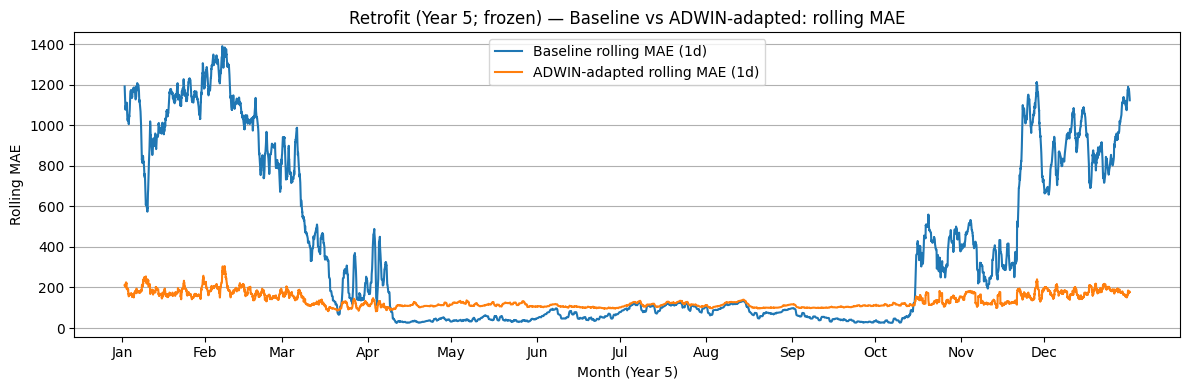

In [79]:
# ================= Year 5 — ADWIN (tables + rolling MAE only) =================

# 1) Build Year-4 windows
y4_df = df_drift[df_drift['year'] == 5].reset_index(drop=True)
assert len(y4_df) >= LOOKBACK + HORIZON + 1, "Year 5 has insufficient rows."

X4_win, Y4_win, ts4_lab, mo4_lab, _ = _build_year_windows(y4_df)

# cadence & rolling window (1 day)
steps_per_day, _ = _steps_per_day_from_labels(ts4_lab)
ROLL_DAYS  = 1
roll_steps = max(1, ROLL_DAYS * steps_per_day)

# 2) Predict (baseline vs ADWIN-adapted)
Y4_true, Y4_hat_base  = _predict_unscaled(baseline_model, X4_win, Y4_win)
_,        Y4_hat_adpt = _predict_unscaled(adwin_model,   X4_win, Y4_win)

H = Y4_true.shape[1]

# 3) Per-horizon tables (MAE, RMSE, sMAPE)
mae_base_h  = [float(np.mean(np.abs(Y4_true[:,h] - Y4_hat_base[:,h]))) for h in range(H)]
mae_adpt_h  = [float(np.mean(np.abs(Y4_true[:,h] - Y4_hat_adpt[:,h]))) for h in range(H)]

rmse_base_h = [float(np.sqrt(np.mean((Y4_true[:,h] - Y4_hat_base[:,h])**2))) for h in range(H)]
rmse_adpt_h = [float(np.sqrt(np.mean((Y4_true[:,h] - Y4_hat_adpt[:,h])**2))) for h in range(H)]

smape_base_h = []
smape_adpt_h = []
for h in range(H):
    num_b = np.abs(Y4_true[:,h] - Y4_hat_base[:,h])
    den_b = (np.abs(Y4_true[:,h]) + np.abs(Y4_hat_base[:,h])).clip(min=1e-6)
    smape_base_h.append(float(np.mean(2.0 * num_b / den_b) * 100.0))

    num_a = np.abs(Y4_true[:,h] - Y4_hat_adpt[:,h])
    den_a = (np.abs(Y4_true[:,h]) + np.abs(Y4_hat_adpt[:,h])).clip(min=1e-6)
    smape_adpt_h.append(float(np.mean(2.0 * num_a / den_a) * 100.0))

# -------------------- FIXED: MAPE per-horizon (eps floor = 1.0 in target units) --------------------
mape_base_h = []
mape_adpt_h = []
for h in range(H):
    den_b = np.maximum(np.abs(Y4_true[:,h]), 1.0)
    mape_base_h.append(float(np.mean(np.abs((Y4_true[:,h] - Y4_hat_base[:,h]) / den_b)) * 100.0))

    den_a = np.maximum(np.abs(Y4_true[:,h]), 1.0)
    mape_adpt_h.append(float(np.mean(np.abs((Y4_true[:,h] - Y4_hat_adpt[:,h]) / den_a)) * 100.0))
# ---------------------------------------------------------------------------------------------------

per_horizon_tbl = pd.DataFrame({
    "horizon":     [f"t+{i+1}" for i in range(H)],
    "MAE_base":     mae_base_h,   "MAE_adpt":     mae_adpt_h,
    "RMSE_base":    rmse_base_h,  "RMSE_adpt":    rmse_adpt_h,
    "sMAPE%_base":  smape_base_h, "sMAPE%_adpt":  smape_adpt_h,
    "MAPE%_base":   mape_base_h,  "MAPE%_adpt":   mape_adpt_h
})

print("=== Year 5 — Per-horizon metrics (Baseline vs ADWIN-Adapted) ===")
display(per_horizon_tbl)

# 4) Per-window “normal” errors (for aggregate table + rolling MAE)
mae4_base_win  = np.array([_window_mae (Y4_true[i], Y4_hat_base[i])  for i in range(len(X4_win))], float)
mae4_adpt_win  = np.array([_window_mae (Y4_true[i], Y4_hat_adpt[i]) for i in range(len(X4_win))], float)

rmse4_base_win = np.array([_window_rmse(Y4_true[i], Y4_hat_base[i])  for i in range(len(X4_win))], float)
rmse4_adpt_win = np.array([_window_rmse(Y4_true[i], Y4_hat_adpt[i]) for i in range(len(X4_win))], float)

smape4_base_win = np.array([_window_smape(Y4_true[i], Y4_hat_base[i])  for i in range(len(X4_win))], float)
smape4_adpt_win = np.array([_window_smape(Y4_true[i], Y4_hat_adpt[i]) for i in range(len(X4_win))], float)

# -------------------- FIXED: MAPE per-window arrays (eps floor = 1.0 in target units) --------------------
mape4_base_win = np.array(
    [float(np.mean(np.abs((Y4_true[i] - Y4_hat_base[i]) / np.maximum(np.abs(Y4_true[i]), 1.0))) * 100.0)
     for i in range(len(X4_win))],
    float
)
mape4_adpt_win = np.array(
    [float(np.mean(np.abs((Y4_true[i] - Y4_hat_adpt[i]) / np.maximum(np.abs(Y4_true[i]), 1.0))) * 100.0)
     for i in range(len(X4_win))],
    float
)
# ---------------------------------------------------------------------------------------------------------

# WAPE over all windows & horizons
wape_base = (np.sum(np.abs(Y4_true - Y4_hat_base)) / max(np.sum(np.abs(Y4_true)), 1e-12)) * 100.0
wape_adpt = (np.sum(np.abs(Y4_true - Y4_hat_adpt)) / max(np.sum(np.abs(Y4_true)), 1e-12)) * 100.0

aggregate_tbl = pd.DataFrame({
    "MAE_mean":    [float(np.mean(mae4_base_win)),   float(np.mean(mae4_adpt_win))],
    "RMSE_mean":   [float(np.mean(rmse4_base_win)),  float(np.mean(rmse4_adpt_win))],
    "sMAPE_mean%": [float(np.mean(smape4_base_win)), float(np.mean(smape4_adpt_win))],
    "MAPE_mean%":  [float(np.mean(mape4_base_win)),  float(np.mean(mape4_adpt_win))],
    "WAPE%":       [float(wape_base),                float(wape_adpt)]
}, index=["Baseline", "ADWIN-Adaptive"])

print("\n=== Year 5 — Aggregate metrics (means over windows) ===")
display(aggregate_tbl)

# -------------------- Global errors (flattened over all windows x horizons) --------------------
_eps_g = 1e-6

_diff_base = (Y4_true - Y4_hat_base)
mae_base_global  = float(np.mean(np.abs(_diff_base)))
rmse_base_global = float(np.sqrt(np.mean(_diff_base ** 2)))
_den_base = (np.abs(Y4_true) + np.abs(Y4_hat_base)).clip(min=_eps_g)
smape_base_global = float(np.mean(2.0 * np.abs(_diff_base) / _den_base) * 100.0)
# -------------------- FIXED: MAPE global (baseline) --------------------
_den_mape_base = np.maximum(np.abs(Y4_true), 1.0)
mape_base_global = float(np.mean(np.abs(_diff_base) / _den_mape_base) * 100.0)
# ----------------------------------------------------------------------

_diff_adpt = (Y4_true - Y4_hat_adpt)
mae_adpt_global  = float(np.mean(np.abs(_diff_adpt)))
rmse_adpt_global = float(np.sqrt(np.mean(_diff_adpt ** 2)))
_den_adpt = (np.abs(Y4_true) + np.abs(Y4_hat_adpt)).clip(min=_eps_g)
smape_adpt_global = float(np.mean(2.0 * np.abs(_diff_adpt) / _den_adpt) * 100.0)
# -------------------- FIXED: MAPE global (adaptive) --------------------
_den_mape_adpt = np.maximum(np.abs(Y4_true), 1.0)
mape_adpt_global = float(np.mean(np.abs(_diff_adpt) / _den_mape_adpt) * 100.0)
# ----------------------------------------------------------------------

global_tbl = pd.DataFrame({
    "MAE_global":    [mae_base_global,  mae_adpt_global],
    "RMSE_global":   [rmse_base_global, rmse_adpt_global],
    "sMAPE_global%": [smape_base_global, smape_adpt_global],
    "MAPE_global%":  [mape_base_global,  mape_adpt_global]
}, index=["Baseline", "ADWIN-Adaptive"])

print("\n=== Year 5 — Global errors (flattened over all windows x horizons) ===")
display(global_tbl)
# -----------------------------------------------------------------------------------------------------

# 5) Plot ONLY the rolling MAE (1 day)
mae4_base_roll = _rolling_mean(mae4_base_win, roll_steps)
mae4_adpt_roll = _rolling_mean(mae4_adpt_win, roll_steps)

# plotting-only change: month-name labels derived from month column
xt, _ = _month_ticks(mo4_lab)
xt = np.asarray(xt, dtype=int)

mo_at_ticks = np.asarray(mo4_lab)[xt].astype(int)
xl = [calendar.month_abbr[m] if 1 <= m <= 12 else str(m) for m in mo_at_ticks]  # 'Jan'..'Dec'


plt.figure(figsize=(12,4))
plt.plot(mae4_base_roll, label=f"Baseline rolling MAE ({ROLL_DAYS}d)")
plt.plot(mae4_adpt_roll, label=f"ADWIN-adapted rolling MAE ({ROLL_DAYS}d)")
plt.xticks(xt, xl)
plt.xlabel("Month (Year 5)")
plt.ylabel("Rolling MAE")
plt.title("Retrofit (Year 5; frozen) — Baseline vs ADWIN-adapted: rolling MAE")
plt.grid(True, axis="y")
plt.legend()
plt.tight_layout()
plt.show()


In [50]:
# # ===================== Probabilistic mixing (gradual drift) for Year 3 =====================
# # Assumes you already have:
# #   df_drift           : your drift dataset with a 'year' column (and 'month', 'timestamp_sec')
# #   FEATS              : list of feature columns (includes the target feature you model)
# #   ONLY_AFTER_TS      : Apr-1 Year 3 timestamp in seconds (e.g., 70_848_000)
# #   month_ticks(...)   : your helper to create month tick positions/labels from a 'month' array
# #
# # Output:
# #   df_drift_pm  : a copy of df_drift where Year 3 has been probabilistically mixed over 1 month
# #   p_sched      : np.ndarray of p(new) for Year 3 (aligned to y3 index)
# #   win_mask     : boolean mask for the blending window in Year 3 (aligned to y3 index)
# #
# # Plot:
# #   Heat-load (target) over whole Year 3 after blending + p(new) on the right axis.
# from numpy.random import default_rng

# # ---------------- Config you may tweak ----------------
# PRE_MONTH = 3       # March
# POST_MONTH = 5      # May
# BLEND_DAYS = 30     # ~1 month window
# RNG_SEED   = 12345  # reproducibility for Bernoulli draws
# # --- Manual constant for Apr-1 (Year 3) ---
# ONLY_AFTER_TS = 70_848_000  # replace with your ground-truth Apr-1 timestamp (in seconds)

# # --------------- Utilities ----------------
# def _steps_per_day_from_ts(ts):
#     if ts.size >= 2 and np.isfinite(ts).all():
#         dt = float(np.median(np.diff(ts)))
#     else:
#         dt = 15 * 60.0
#     return max(1, int(round((24*3600)/dt))), dt

# def _linear_p(ts, Ts, Te):
#     # p(t) = (t - Ts)/(Te - Ts), clipped to [0,1]
#     p = (ts.astype(float) - float(Ts)) / max(1.0, float(Te - Ts))
#     return np.clip(p, 0.0, 1.0)

# def _has_cols(df, cols):
#     return all(c in df.columns for c in cols)

# def _sample_row(pool, key_cols, key_vals, rng):
#     """Try to sample from a key-matched subpool; if empty fallback to full pool."""
#     if len(pool) == 0:
#         return None
#     if key_cols and _has_cols(pool, key_cols):
#         # Build mask for exact key match
#         m = np.ones(len(pool), dtype=bool)
#         for c, v in zip(key_cols, key_vals):
#             m &= (pool[c].to_numpy() == v)
#         sub = pool.loc[m]
#         if len(sub) > 0:
#             ridx = int(rng.integers(0, len(sub)))
#             return sub.iloc[ridx]
#     # fallback: any row from full pool
#     ridx = int(rng.integers(0, len(pool)))
#     return pool.iloc[ridx]

# # --------------- Build Year-3 view ----------------
# df_drift_pm = df_drift.copy()  # full copy; we'll only modify Year 3 rows
# y3 = df_drift_pm[df_drift_pm['year'] == 3].reset_index()  # keep original index to write back
# y3_idx_in_full = y3['index'].to_numpy()
# y3 = y3.drop(columns=['index'])

# ts_y3 = y3['timestamp_sec'].to_numpy()
# mo_y3 = y3['month'].to_numpy()

# steps_per_day, dt_sec = _steps_per_day_from_ts(ts_y3)
# Te = ONLY_AFTER_TS + int(BLEND_DAYS * 24 * 3600)

# # --------------- Probability schedule & window mask ----------------
# p_sched = _linear_p(ts_y3, ONLY_AFTER_TS, Te)
# win_mask = (ts_y3 >= ONLY_AFTER_TS) & (ts_y3 <= Te)

# # --------------- Build old/new pools from representative months ----------------
# pool_old = y3[y3['month'] == PRE_MONTH].copy()
# pool_new = y3[y3['month'] == POST_MONTH].copy()

# # keying by hour & weekday if present; you can add other keys here if you want
# key_cols = []
# if 'hour' in y3.columns: key_cols.append('hour')
# if 'weekday' in y3.columns: key_cols.append('weekday')

# rng = default_rng(RNG_SEED)

# # --------------- Bernoulli mixing over the window ----------------
# for loc_i in np.where(win_mask)[0]:
#     # key values of the current slot to preserve daily/weekly structure (if keys exist)
#     key_vals = [y3[k].iloc[loc_i] for k in key_cols] if key_cols else []

#     # draw: 1 → new concept, 0 → old concept
#     draw_new = (rng.random() < p_sched[loc_i])

#     if draw_new:
#         picked = _sample_row(pool_new, key_cols, key_vals, rng)
#     else:
#         picked = _sample_row(pool_old, key_cols, key_vals, rng)

#     if picked is None:
#         # If pools are empty, leave row unchanged
#         continue

#     # overwrite ALL FEATS for this row with the sampled row (including the target feature)
#     df_drift_pm.loc[y3_idx_in_full[loc_i], FEATS] = picked[FEATS].to_numpy()

# # --------------- Plot heat load over whole Year 3 after mixing ----------------
# # If your target feature has a specific column name, use it here; otherwise pick FEATS[idx_t].
# try:
#     target_col = FEATS[idx_t]
# except Exception:
#     # fallback: guess a column name commonly used for the target
#     target_col = 'heat' if 'heat' in df_drift_pm.columns else FEATS[0]

# y3_blended = df_drift_pm.loc[y3_idx_in_full].reset_index(drop=True)
# heat_y3 = y3_blended[target_col].to_numpy()

# xt, xl = month_ticks(mo_y3)  # your existing helper

# fig, ax1 = plt.subplots(figsize=(12, 4))
# ax1.plot(heat_y3, label="Heat (blended)")
# ax1.axvspan(np.searchsorted(ts_y3, ONLY_AFTER_TS, 'left'),
#             np.searchsorted(ts_y3, Te, 'right'),
#             alpha=0.15, label="Blend window (~1 month)")
# ax1.axvline(np.searchsorted(ts_y3, ONLY_AFTER_TS, 'left'),
#             linestyle="--", linewidth=1.2, label="Apr-1 start")
# ax1.set_xticks(xt); ax1.set_xticklabels(xl)
# ax1.set_xlabel("Month (Year 3)")
# ax1.set_ylabel("Heat load")
# ax1.set_title("Year 3 — Probabilistic mixing (1-month window) • Heat load shown")
# ax1.grid(True, axis='y')
# ax1.legend(loc="upper left")

# # optional: p(new) on secondary axis (helpful to sanity-check the schedule)
# ax2 = ax1.twinx()
# ax2.plot(p_sched, linewidth=1.0, alpha=0.9, label="p(new)")
# ax2.set_ylabel("p(new)")
# ax2.legend(loc="upper right")

# plt.tight_layout()
# plt.show()

# # ----------- What you get -----------
# # - df_drift_pm: your dataset with Year 3 gradually drifted by Bernoulli mixing across all FEATS.
# # - The plot shows the *target/heat* series for Year 3 after mixing, with the one-month window highlighted.


In [51]:
# # ===================== Probabilistic mixing (gradual drift) for Year 3 =====================


# # ---------------- Config you may tweak ----------------
# PRE_MONTH = 3       # March
# POST_MONTH = 5      # May
# BLEND_DAYS = 30     # ~1 month window
# RNG_SEED   = 12345  # reproducibility for Bernoulli draws
# ONLY_AFTER_TS = 70_848_000  # Apr-1 Year 3 timestamp (seconds)

# # --------------- Utilities ----------------
# def _steps_per_day_from_ts(ts):
#     if ts.size >= 2 and np.isfinite(ts).all():
#         dt = float(np.median(np.diff(ts)))
#     else:
#         dt = 15 * 60.0
#     return max(1, int(round((24*3600)/dt))), dt

# def _linear_p(ts, Ts, Te):
#     p = (ts.astype(float) - float(Ts)) / max(1.0, float(Te - Ts))
#     return np.clip(p, 0.0, 1.0)

# def _has_cols(df, cols):
#     return all(c in df.columns for c in cols)

# def _sample_row(pool, key_cols, key_vals, rng):
#     """Try to sample from a key-matched subpool; if empty fallback to full pool."""
#     if len(pool) == 0:
#         return None
#     if key_cols and _has_cols(pool, key_cols):
#         m = np.ones(len(pool), dtype=bool)
#         for c, v in zip(key_cols, key_vals):
#             m &= (pool[c].to_numpy() == v)
#         sub = pool.loc[m]
#         if len(sub) > 0:
#             ridx = int(rng.integers(0, len(sub)))
#             return sub.iloc[ridx]
#     ridx = int(rng.integers(0, len(pool)))
#     return pool.iloc[ridx]

# # --------------- Build Year-3 view ----------------
# df_drift_pm = df_drift.copy()
# y3 = df_drift_pm[df_drift_pm['year'] == 3].reset_index()  # keep original index to write back
# y3_idx_in_full = y3['index'].to_numpy()
# y3 = y3.drop(columns=['index'])

# ts_y3 = y3['timestamp_sec'].to_numpy()
# mo_y3 = y3['month'].to_numpy()

# steps_per_day, dt_sec = _steps_per_day_from_ts(ts_y3)
# Te = ONLY_AFTER_TS + int(BLEND_DAYS * 24 * 3600)

# # --------------- Probability schedule & window mask ----------------
# p_sched  = _linear_p(ts_y3, ONLY_AFTER_TS, Te)
# win_mask = (ts_y3 >= ONLY_AFTER_TS) & (ts_y3 <= Te)

# # --------------- Build old/new pools from representative months ----------------
# pool_old = y3[y3['month'] == PRE_MONTH].copy()
# pool_new = y3[y3['month'] == POST_MONTH].copy()

# key_cols = []
# if 'hour' in y3.columns: key_cols.append('hour')
# if 'weekday' in y3.columns: key_cols.append('weekday')

# rng = default_rng(RNG_SEED)

# # --------------- Bernoulli mixing over the window ----------------
# for loc_i in np.where(win_mask)[0]:
#     key_vals = [y3[k].iloc[loc_i] for k in key_cols] if key_cols else []
#     draw_new = (rng.random() < p_sched[loc_i])

#     picked = _sample_row(pool_new, key_cols, key_vals, rng) if draw_new else _sample_row(pool_old, key_cols, key_vals, rng)
#     if picked is None:
#         continue

#     df_drift_pm.loc[y3_idx_in_full[loc_i], FEATS] = picked[FEATS].to_numpy()

# # --------------- Plot heat load over whole Year 3 after mixing ----------------
# try:
#     target_col = FEATS[idx_t]
# except Exception:
#     target_col = 'heat' if 'heat' in df_drift_pm.columns else FEATS[0]

# y3_blended = df_drift_pm.loc[y3_idx_in_full].reset_index(drop=True)
# heat_y3 = y3_blended[target_col].to_numpy()

# xt, _ = month_ticks(mo_y3)  # your existing helper

# # --------- UPDATED: month NAME labels instead of numbers ---------
# xt = np.asarray(xt, dtype=int)
# mo_at_ticks = np.asarray(mo_y3)[xt].astype(int)
# xl = [calendar.month_name[m] if 1 <= m <= 12 else str(m) for m in mo_at_ticks]
# # ---------------------------------------------------------------

# fig, ax1 = plt.subplots(figsize=(12, 4))
# ax1.plot(heat_y3, label="Heat (blended)")
# ax1.axvspan(np.searchsorted(ts_y3, ONLY_AFTER_TS, 'left'),
#             np.searchsorted(ts_y3, Te, 'right'),
#             alpha=0.15, label="Blend window (~1 month)")
# ax1.axvline(np.searchsorted(ts_y3, ONLY_AFTER_TS, 'left'),
#             linestyle="--", linewidth=1.2, label="Apr-1 start")

# ax1.set_xticks(xt)
# ax1.set_xticklabels(xl, rotation=45, ha="right")
# ax1.set_xlabel("Month (Year 3)")
# ax1.set_ylabel("Heat load")
# ax1.set_title("Year 3 — Probabilistic mixing (1-month window) • Heat load shown")
# ax1.grid(True, axis='y')
# ax1.legend(loc="upper left")

# ax2 = ax1.twinx()
# ax2.plot(p_sched, linewidth=1.0, alpha=0.9, label="p(new)")
# ax2.set_ylabel("p(new)")
# ax2.legend(loc="upper right")

# plt.tight_layout()
# plt.show()


In [52]:
# # ---- Config for the blending window ----
# BLEND_DAYS   = 30            # ~1 month
# RNG_SEED     = 7             # change to get another realization
# HEAT_COL     = FEATS[idx_t]  # your heat load column name

# # ---- 1) Pull Year 3 and figure out cadence + indices ----
# y3_df = df_drift[df_drift['year'] == 3].reset_index(drop=True).copy()
# ts    = y3_df['timestamp_sec'].to_numpy()

# # steps/day (fallback 96 for 15-min cadence)
# if len(ts) >= 2 and np.isfinite(ts).all():
#     dt_sec = float(np.median(np.diff(ts)))
#     steps_per_day = max(1, int(round((24 * 3600) / dt_sec)))
# else:
#     dt_sec = 15 * 60.0
#     steps_per_day = 96

# tau = int(np.searchsorted(ts, ONLY_AFTER_TS, side="left"))   # Apr-1 index
# L   = BLEND_DAYS * steps_per_day                             # window length in steps
# t0, t1 = tau, min(len(y3_df), tau + L)                       # [t0, t1)

# # Safety guards: need enough context on both sides
# pre_len  = min(L, t0)                   # up to 1 month before Apr-1
# post_len = min(L, len(y3_df) - t0)      # up to 1 month after Apr-1
# if pre_len == 0 or post_len == 0:
#     raise ValueError("Insufficient data to build a 1-month blend window around Apr-1 in Year 3.")

# # ---- 2) Build pre and post buffers used during the blend window ----
# pre_buf  = y3_df.iloc[t0 - pre_len : t0].reset_index(drop=True)
# post_buf = y3_df.iloc[t0 : t0 + post_len].reset_index(drop=True)

# # ---- 3) Probability schedule p(new) on the whole year (linear ramp in [t0, t1)) ----
# p_new = np.zeros(len(y3_df), dtype=float)
# if t1 > t0:
#     ramp = (np.arange(t0, t1) - t0) / max(1, (t1 - t0 - 1))  # 0 -> 1 across the window
#     p_new[t0:t1] = np.clip(ramp, 0.0, 1.0)
#     p_new[t1:]   = 1.0

# # ---- 4) Create blended DataFrame (copy original, then blend rows in [t0, t1)) ----
# blended_df = y3_df.copy()
# rng = np.random.default_rng(RNG_SEED)

# # Blend ALL features named in FEATS using Bernoulli(p_new[i])
# for i in range(t0, t1):
#     # indices within buffers
#     k_pre  = (i - t0) % pre_len   # circular over pre buffer
#     k_post = (i - t0)             # aligned into post buffer (0..post_len-1)

#     if rng.random() < p_new[i]:
#         # pick NEW concept (post)
#         src_row = post_buf.iloc[k_post]
#     else:
#         # pick OLD concept (pre)
#         src_row = pre_buf.iloc[k_pre]

#     # overwrite ALL feature columns for this time step
#     blended_df.loc[i, FEATS] = src_row[FEATS].values

# # ---- 5) Month ticks helper ----
# def _month_ticks(months_arr):
#     starts, labels, seen = [], [], set()
#     for i, m in enumerate(months_arr):
#         if m not in seen:
#             starts.append(i); labels.append(f"M{int(m):02d}"); seen.add(m)
#     return np.array(starts), labels

# months = y3_df['month'].to_numpy()
# xt, xl = _month_ticks(months)
# idxs = np.arange(len(y3_df))

# # ===================== Separate Plots =====================

# # (A) ORIGINAL heat (Year 3)
# plt.figure(figsize=(12,4))
# plt.plot(idxs, y3_df[HEAT_COL].to_numpy(), label="Heat (original)")
# plt.axvspan(t0, t1-1, alpha=0.12, label="Blend window (~1 month)")
# plt.axvline(tau, linestyle="--", linewidth=1.25, label="Apr-1 start")
# plt.xticks(xt, xl)
# plt.xlabel("Month (Year 3)")
# plt.ylabel("Heat load")
# plt.title("Year 3 — Heat (original)")
# plt.grid(True, axis='y')
# plt.legend()
# plt.tight_layout()
# plt.show()

# # (B) BLENDED heat (Year 3)
# plt.figure(figsize=(12,4))
# plt.plot(idxs, blended_df[HEAT_COL].to_numpy(), label="Heat (blended)")
# plt.axvspan(t0, t1-1, alpha=0.12, label="Blend window (~1 month)")
# plt.axvline(tau, linestyle="--", linewidth=1.25, label="Apr-1 start")
# plt.xticks(xt, xl)
# plt.xlabel("Month (Year 3)")
# plt.ylabel("Heat load")
# plt.title("Year 3 — Heat (blended with probabilistic mixing)")
# plt.grid(True, axis='y')
# plt.legend()
# plt.tight_layout()
# plt.show()

# # (C) p(new) schedule (Year 3)
# plt.figure(figsize=(12,3.5))
# plt.plot(idxs, p_new, label="p(new)")
# plt.axvspan(t0, t1-1, alpha=0.12, label="Blend window (~1 month)")
# plt.axvline(tau, linestyle="--", linewidth=1.25, label="Apr-1 start")
# plt.xticks(xt, xl)
# plt.xlabel("Month (Year 3)")
# plt.ylabel("p(new)")
# plt.title("Year 3 — Probability of NEW concept during transition")
# plt.grid(True, axis='y')
# plt.legend()
# plt.tight_layout()
# plt.show()


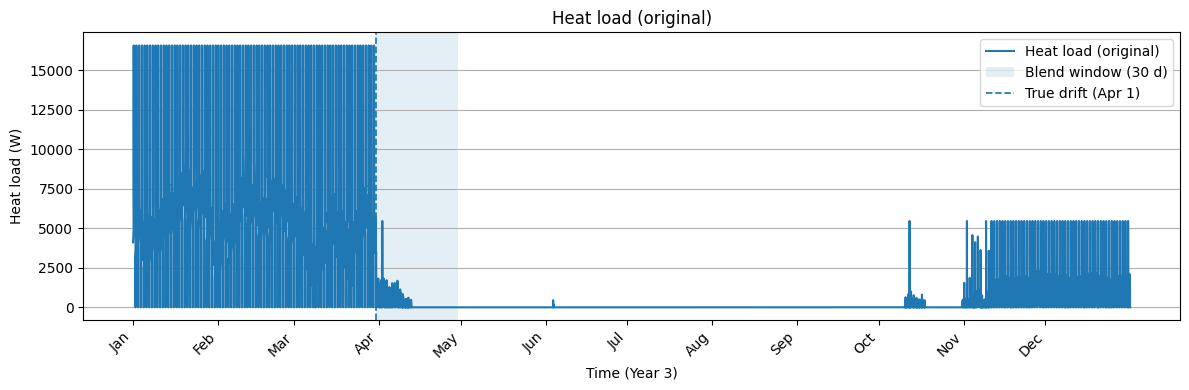

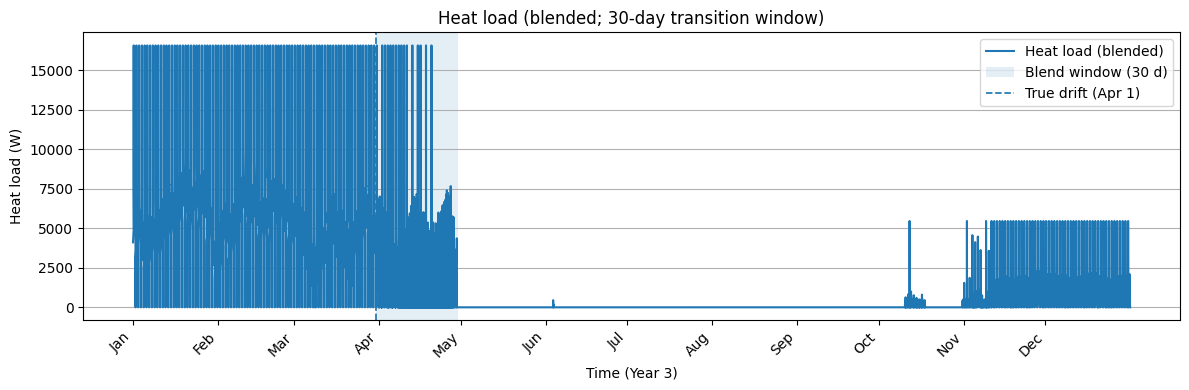

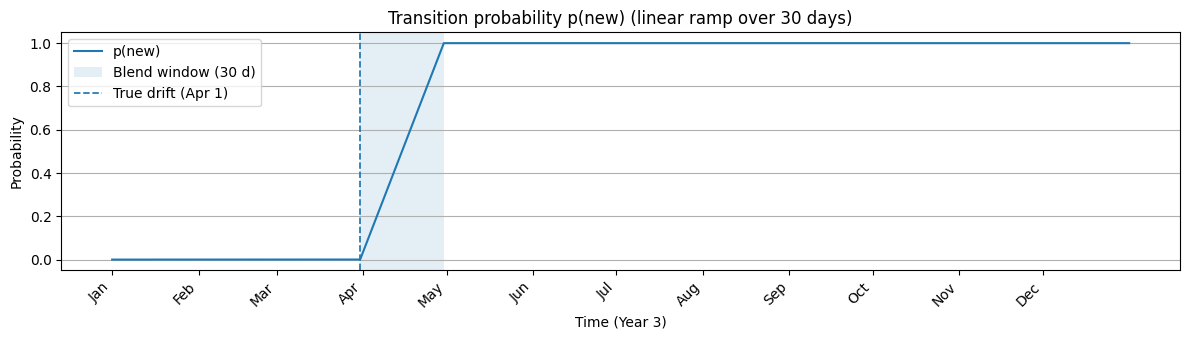

In [81]:
# ---- Config for the blending window ----
BLEND_DAYS   = 30            # ~1 month
RNG_SEED     = 7             # change to get another realization
HEAT_COL     = FEATS[idx_t]  # your heat load column name
ONLY_AFTER_TS = 70_848_000



# ---- 1) Pull Year 3 and figure out cadence + indices ----
y3_df = df_drift[df_drift['year'] == 3].reset_index(drop=True).copy()
ts    = y3_df['timestamp_sec'].to_numpy()

# steps/day (fallback 96 for 15-min cadence)
if len(ts) >= 2 and np.isfinite(ts).all():
    dt_sec = float(np.median(np.diff(ts)))
    steps_per_day = max(1, int(round((24 * 3600) / dt_sec)))
else:
    dt_sec = 15 * 60.0
    steps_per_day = 96

tau = int(np.searchsorted(ts, ONLY_AFTER_TS, side="left"))   # Apr-1 index
L   = BLEND_DAYS * steps_per_day                             # window length in steps
t0, t1 = tau, min(len(y3_df), tau + L)                       # [t0, t1)

# Safety guards: need enough context on both sides
pre_len  = min(L, t0)                   # up to 1 month before Apr-1
post_len = min(L, len(y3_df) - t0)      # up to 1 month after Apr-1
if pre_len == 0 or post_len == 0:
    raise ValueError("Insufficient data to build a 1-month blend window around Apr-1 in Year 3.")

# ---- 2) Build pre and post buffers used during the blend window ----
pre_buf  = y3_df.iloc[t0 - pre_len : t0].reset_index(drop=True)
post_buf = y3_df.iloc[t0 : t0 + post_len].reset_index(drop=True)

# ---- 3) Probability schedule p(new) on the whole year (linear ramp in [t0, t1)) ----
p_new = np.zeros(len(y3_df), dtype=float)
if t1 > t0:
    ramp = (np.arange(t0, t1) - t0) / max(1, (t1 - t0 - 1))  # 0 -> 1 across the window
    p_new[t0:t1] = np.clip(ramp, 0.0, 1.0)
    p_new[t1:]   = 1.0

# ---- 4) Create blended DataFrame (copy original, then blend rows in [t0, t1)) ----
blended_df = y3_df.copy()
rng = np.random.default_rng(RNG_SEED)

# Blend ALL features named in FEATS using Bernoulli(p_new[i])
for i in range(t0, t1):
    k_pre  = (i - t0) % pre_len   # circular over pre buffer
    k_post = (i - t0)             # aligned into post buffer (0..post_len-1)

    src_row = post_buf.iloc[k_post] if (rng.random() < p_new[i]) else pre_buf.iloc[k_pre]
    blended_df.loc[i, FEATS] = src_row[FEATS].values

# ---- 5) Month ticks helper (UPDATED: month NAMES, not numbers) ----
def _month_ticks(months_arr):
    starts, labels, seen = [], [], set()
    for i, m in enumerate(months_arr):
        if m not in seen:
            starts.append(i)
            mm = int(m)
            labels.append(calendar.month_abbr[mm] if 1 <= mm <= 12 else str(m))  # <-- month name
            seen.add(m)
    return np.array(starts), labels

months = y3_df['month'].to_numpy()
xt, xl = _month_ticks(months)
idxs = np.arange(len(y3_df))

# ===================== Separate Plots =====================

# (A) ORIGINAL heat (Year 3)
figA, axA = plt.subplots(figsize=(12, 4))
axA.plot(idxs, y3_df[HEAT_COL].to_numpy(), label="Heat load (original)")
axA.axvspan(t0, t1-1, alpha=0.12, label=f"Blend window ({BLEND_DAYS} d)")
axA.axvline(tau, linestyle="--", linewidth=1.25, label="True drift (Apr 1)")
axA.set_xticks(xt)
axA.set_xticklabels(xl, rotation=45, ha="right")
axA.set_xlabel("Time (Year 3)")
axA.set_ylabel("Heat load (W)")
axA.set_title("Heat load (original)")
axA.grid(True, axis="y")
axA.legend()
figA.tight_layout()

figA.savefig("/kaggle/working/OriginalHeat.pdf", format="pdf", bbox_inches="tight")  # save before show [web:942]
plt.show()

# (B) BLENDED heat (Year 3)
figB, axB = plt.subplots(figsize=(12, 4))
axB.plot(idxs, blended_df[HEAT_COL].to_numpy(), label="Heat load (blended)")
axB.axvspan(t0, t1-1, alpha=0.12, label=f"Blend window ({BLEND_DAYS} d)")
axB.axvline(tau, linestyle="--", linewidth=1.25, label="True drift (Apr 1)")
axB.set_xticks(xt)
axB.set_xticklabels(xl, rotation=45, ha="right")
axB.set_xlabel("Time (Year 3)")
axB.set_ylabel("Heat load (W)")
axB.set_title("Heat load (blended; 30‑day transition window)")
axB.grid(True, axis="y")
axB.legend()
figB.tight_layout()

figB.savefig("/kaggle/working/BlendedHeat.pdf", format="pdf", bbox_inches="tight")  # save before show [web:942]
plt.show()

# (C) p(new) schedule (Year 3)
figC, axC = plt.subplots(figsize=(12, 3.5))
axC.plot(idxs, p_new, label="p(new)")
axC.axvspan(t0, t1-1, alpha=0.12, label=f"Blend window ({BLEND_DAYS} d)")
axC.axvline(tau, linestyle="--", linewidth=1.25, label="True drift (Apr 1)")
axC.set_xticks(xt)
axC.set_xticklabels(xl, rotation=45, ha="right")
axC.set_xlabel("Time (Year 3)")
axC.set_ylabel("Probability")
axC.set_title("Transition probability p(new) (linear ramp over 30 days)")
axC.grid(True, axis="y")
axC.legend()
figC.tight_layout()

figC.savefig("/kaggle/working/Probability transition.pdf", format="pdf", bbox_inches="tight")  # save before show [web:942]
plt.show()


In [82]:
# ------------- 4) Clone baseline into “gradual” models (DDM/ADWIN/PH) -------------
def clone_from_baseline(baseline_model, new_name: str):
    """Exact topology clone + weights + same loss/metrics/optimizer; renamed."""
    mdl = tf.keras.models.clone_model(baseline_model)
    # Ensure built before setting weights (esp. Functional/Sequential)
    try:
        mdl.build(baseline_model.input_shape)
    except Exception:
        pass
    mdl.set_weights(baseline_model.get_weights())
    mdl._name = new_name  # rename the model object

    opt_cfg = tf.keras.optimizers.serialize(baseline_model.optimizer)
    mdl.compile(
        optimizer=tf.keras.optimizers.deserialize(opt_cfg),
        loss=baseline_model.loss,
        metrics=[m for m in baseline_model.metrics]
    )
    return mdl

# Create three clearly named models for the gradual scenario
ddm_gradual_model         = clone_from_baseline(baseline_model, "ddm_gradual_model")
adwin_gradual_model       = clone_from_baseline(baseline_model, "adwin_gradual_model")
pagehinkley_gradual_model = clone_from_baseline(baseline_model, "pagehinkley_gradual_model")

print("Cloned models:", ddm_gradual_model.name, adwin_gradual_model.name, pagehinkley_gradual_model.name)


Cloned models: sequential sequential sequential


[DDM calibration on validation] MAE_mean=137.923, Q1=41.125, Q3=173.188, k=2.0 -> Ethr=402.048

=== DDM on GRADUAL Year 3 (abrupt-best params) ===
Total drifts: 9
False positives (pre–Apr-1): 3
Detection delay (first post–Apr-1): ~41.8 hours


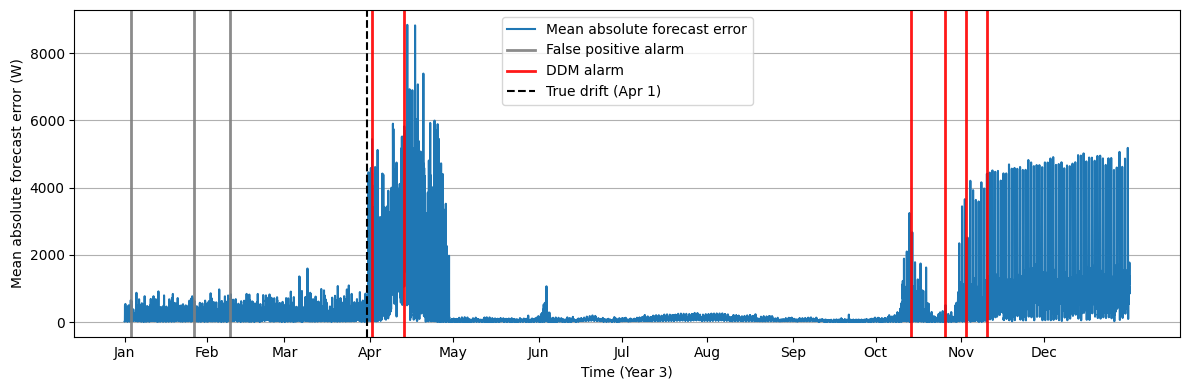

In [89]:
# ----- Constants (fixed from your abrupt grid) -----
BEST_K            = 2.0
BEST_DDM_DRIFT_TH = 3.5
COOLDOWN_DAYS     = 7
DRIFT_TS          = 70_848_000     # Apr-1 Year 3

# ----- Helpers you already have (or light fallbacks) -----
def month_ticks(months_arr):
    starts, labels, seen = [], [], set()
    for i, m in enumerate(months_arr):
        if m not in seen:
            starts.append(i); labels.append(f"M{int(m):02d}"); seen.add(m)
    return np.array(starts), labels

def _cooldown_steps_from_ts(ts_labels: np.ndarray, days: int) -> int:
    if ts_labels.size >= 2 and np.all(np.isfinite(ts_labels)):
        dt_sec = float(np.median(np.diff(ts_labels)))
        steps_per_day = max(1, int(round(24 * 3600 / dt_sec)))
    else:
        dt_sec = 15 * 60.0
        steps_per_day = 96
    return days * steps_per_day, dt_sec

def ddm_run_with_cooldown(b_stream: np.ndarray, cooldown_steps: int, drift_threshold: float):
    """DDM with shared cooldown; ALWAYS update so pre-Apr FPs are visible."""
    ddm = drift.binary.DDM(drift_threshold=drift_threshold)
    drift_idx, cooldown = [], 0
    for i, x in enumerate(b_stream):
        ddm.update(int(x))
        if cooldown > 0:
            cooldown -= 1
            continue
        if ddm.drift_detected:
            drift_idx.append(i)
            cooldown = cooldown_steps
    return drift_idx

# ----- 1) Choose the GRADUAL Year 3 stream -----
# If you created 'blended_df' via probabilistic mixing, we use it.
# Otherwise, fall back to the original drifted Year 3.
if 'blended_df' in globals() and len(blended_df):
    y3_df = blended_df.reset_index(drop=True)
else:
    y3_df = df_drift[df_drift['year'] == 3].reset_index(drop=True)

# Compute the avg |error| per window in ORIGINAL units + labels using your helper
# (Assumes errors_avg_abs(df_src) -> (e_bar, ts_labels, mo_labels) using baseline_model)
e_y3, ts_y3, mo_y3 = errors_avg_abs(y3_df)

# ----- 2) Calibrate Ethr on NO-DRIFT validation with BEST_K (MAE-based) -----
# val_df should be your no-drift validation (e.g., last 30% of Y1–Y3 no-drift)
if 'val_df' not in globals():
    nodrift_y123 = df_nodrift[df_nodrift['year'].isin([1,2,3])].reset_index(drop=True)
    split_idx = int(0.7 * len(nodrift_y123))
    val_df = nodrift_y123.iloc[split_idx:].reset_index(drop=True)

e_val, _, _ = errors_avg_abs(val_df)            # MAE per window in orig units
MAE_bar = float(e_val.mean())
Q1, Q3  = np.percentile(e_val, [25, 75])
IQR     = Q3 - Q1
Ethr    = MAE_bar + BEST_K * IQR
print(f"[DDM calibration on validation] MAE_mean={MAE_bar:.3f}, Q1={Q1:.3f}, Q3={Q3:.3f}, k={BEST_K} -> Ethr={Ethr:.3f}")

# ----- 3) Build binary exceedance stream on GRADUAL Year 3 -----
b_stream = (e_y3 > Ethr).astype(int)

# ----- 4) Run DDM with 7-day cooldown (count all drifts; pre-Apr are FPs) -----
cooldown_steps, dt_sec = _cooldown_steps_from_ts(ts_y3, COOLDOWN_DAYS)
tau_idx = int(np.searchsorted(ts_y3, DRIFT_TS, side="left"))

drift_idx = ddm_run_with_cooldown(b_stream, cooldown_steps, drift_threshold=BEST_DDM_DRIFT_TH)

# Metrics: total drifts, false positives, detection delay (first post-Apr)
total_drifts = len(drift_idx)
fps = sum(ts_y3[i] < DRIFT_TS for i in drift_idx)
post = [i for i in drift_idx if i >= tau_idx]
if post:
    delay_hours = (post[0] - tau_idx) * (dt_sec / 3600.0)
else:
    delay_hours = float('inf')

print("\n=== DDM on GRADUAL Year 3 (abrupt-best params) ===")
print(f"Total drifts: {total_drifts}")
print(f"False positives (pre–Apr-1): {fps}")
if np.isfinite(delay_hours):
    print(f"Detection delay (first post–Apr-1): ~{delay_hours:.1f} hours")
else:
    print("Detection delay: ∞ (no drift after Apr-1)")

# ----- 5) Plot ONLY the error with DDM drift lines over Year 3 -----

idxs = np.arange(len(e_y3))
xt, _ = month_ticks(mo_y3)

# month abbreviations derived from month column
xt = np.asarray(xt, dtype=int)
import calendar
mo_at_ticks = np.asarray(mo_y3)[xt].astype(int)
xl = [calendar.month_abbr[m] if 1 <= m <= 12 else str(m) for m in mo_at_ticks]  # 'Jan'..'Dec'



fig, ax = plt.subplots(figsize=(12, 4))

# curve label like previous figures
ax.plot(idxs, e_y3, label="Mean absolute forecast error")

# Grey = False positives (pre-drift), Red = Drift alarms (post-drift)
fp_lab = "False positive alarm"
dr_lab = "DDM alarm"
for i in drift_idx:
    if ts_y3[i] >= DRIFT_TS:
        ax.axvline(i, color="red", linestyle="-", linewidth=2.0, alpha=0.9, label=dr_lab)
        dr_lab = "_nolegend_"   # labels starting with "_" are excluded from auto-legend [web:1039]
    else:
        ax.axvline(i, color="tab:gray", linestyle="-", linewidth=2.0, alpha=0.9, label=fp_lab)
        fp_lab = "_nolegend_"   # labels starting with "_" are excluded from auto-legend [web:1039]

ax.axvline(tau_idx, color="black", linestyle="--", linewidth=1.5, label="True drift (Apr 1)")
ax.set_xticks(xt)
ax.set_xticklabels(xl)
ax.set_xlabel("Time (Year 3)")
ax.set_ylabel("Mean absolute forecast error (W)")
ax.set_title("")
ax.grid(True, axis="y")
ax.legend()
fig.tight_layout()

out_path = "/kaggle/working/GradualYear3DDM.pdf"
# save BEFORE show
fig.savefig(out_path, format="pdf", bbox_inches="tight")
plt.show()



In [90]:
PRETRAIN_LR   = 0.0007509794596043137
FT_LR         = PRETRAIN_LR / 10.0     # exact 1/10

In [91]:
# ================== 3) Adaptive model for GRADUAL stream ==================
# Create a separate adaptive model so you keep the abrupt run intact
if 'ddm_model_gradual' not in globals():
    ddm_model_gradual = tf.keras.models.clone_model(baseline_model)
    ddm_model_gradual.set_weights(baseline_model.get_weights())

# Pull loss/metrics from the baseline (fallbacks if not set)
_base_loss = baseline_model.loss if getattr(baseline_model, 'loss', None) else 'mse'
_base_metrics = [m for m in getattr(baseline_model, 'metrics', []) if getattr(m, 'name', '') != 'loss']

# --- COMPILE the cloned model (the clone has no optimizer yet) ---
ddm_model_gradual.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FT_LR),
    loss=_base_loss,
    metrics=_base_metrics
)

# (Optional) only try to serialize an optimizer if it exists
orig_opt_cfg = None
if getattr(ddm_model_gradual, 'optimizer', None) is not None:
    try:
        orig_opt_cfg = tf.keras.optimizers.serialize(ddm_model_gradual.optimizer)
    except Exception:
        orig_opt_cfg = None


[DDM calibration] Ethr (MAE): mean=137.923, Q1=41.125, Q3=173.187, k=2.0 -> Ethr=402.048

=== DDM drift summary (Year 3, gradual) ===


count_all_drifts  false_positives  adapt_drift_hits  first_post_drift_idx  \
0                 9                3                 6                  8602   

   detection_delay_hours  
0                   41.8


=== Year 3 aggregate error table (means over streaming windows) ===


MAE_mean  RMSE_mean  sMAPE_mean%  MAPE_mean%  WAPE%
Baseline                   358.1      416.1        130.9    11,381.7   22.0
Adaptive-DDM (gradual)     451.0      503.3        129.1    27,888.6   27.7


=== Recovery summary (hours) — consecutive window rule = 1 day ===


drift_idx  recovery_idx  recovery_hours  post_Apr
0        235          1356           280.2     False
1       2423          2716            73.2     False
2       3665          4205           135.0     False
3       8602          8818            54.0      True
4       9722          9722             0.0      True
5      27326         27378            13.0      True
6      28526         28526             0.0      True
7      29254         29254             0.0      True
8      29976         29976             0.0      True


=== Year 3 (gradual) — Per-horizon metrics (MAE, RMSE, sMAPE%, MAPE%) ===


horizon  MAE_base  MAE_adapt  RMSE_base  RMSE_adapt  sMAPE%_base  \
0     t+1     325.9      471.3    1,007.6       907.3        129.6   
1     t+2     335.7      464.4      914.4       839.2        130.6   
2     t+3     376.2      444.3      990.3       859.9        131.4   
3     t+4     394.7      424.0      957.9       816.5        132.1   

   sMAPE%_adapt  MAPE%_base  MAPE%_adapt  
0         128.5     9,936.3     30,688.0  
1         128.7    10,811.7     30,555.0  
2         129.5    12,301.5     26,615.4  
3         129.8    12,477.5     23,695.8


=== Year 3 (gradual) — Global metrics (flattened over all windows x horizons) ===


MAE_global  RMSE_global  sMAPE_global%  MAPE_global%  \
Baseline                     358.1        968.2          130.9      11,381.7   
Adaptive-DDM (gradual)       451.0        856.4          129.1      27,888.6   

                        WAPE_global%  
Baseline                        22.0  
Adaptive-DDM (gradual)          27.7

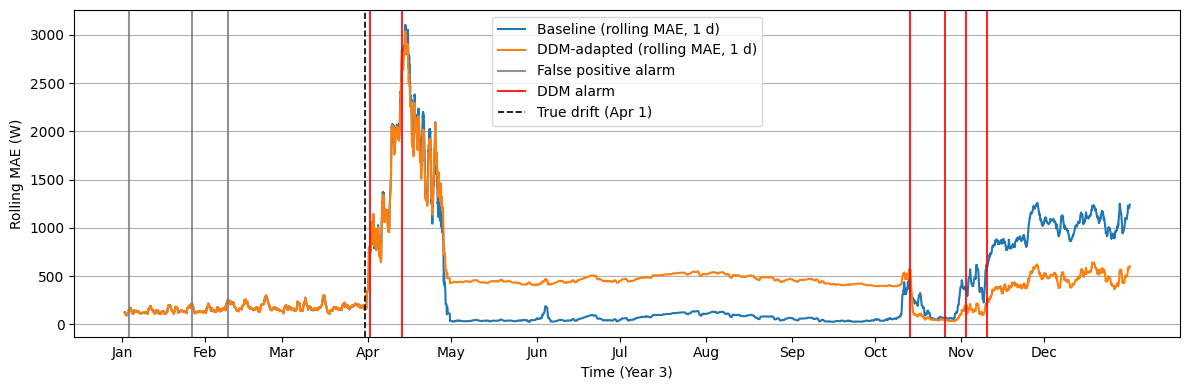

In [92]:
# ================== CONFIG ==================
PRETRAIN_LR   = 0.0007509794596043137
FT_LR         = PRETRAIN_LR / 10.0     # exact 1/10
FT_DAYS       = 7
FT_EPOCHS     = 5
FT_BATCH      = 41
FT_PATIENCE   = 2
ROLL_DAYS     = 1
COOLDOWN_DAYS = 7
ONLY_AFTER_TS = 70_848_000              # Apr-1 Year 3 (seconds)
H             = HORIZON

BEST_K            = 2.0                 # from your DDM grid search (abrupt)
BEST_DDM_DRIFT_TH = 3.5                 # drift_threshold from your DDM grid search (abrupt)

# ============ Small helpers ============


def _label_rows(n_full, lookback, horizon):
    return (np.arange(lookback, n_full - horizon + 1) + (horizon - 1))

def _build_year_windows(df_year: pd.DataFrame):
    X = df_year[FEATS].to_numpy(float)
    Xs = X_scaler.transform(X)
    ys = Xs[:, idx_t].copy()
    Xw, Yw = make_windows_multi(Xs, ys, LOOKBACK, H, stride=1)
    n_full = len(df_year)
    lbl_idx = _label_rows(n_full, LOOKBACK, H)
    ts_lab  = df_year.iloc[lbl_idx]['timestamp_sec'].to_numpy()
    mo_lab  = df_year.iloc[lbl_idx]['month'].to_numpy()
    return Xw, Yw, ts_lab, mo_lab, lbl_idx

def _predict_unscaled(model, Xw, Yw):
    Y_hat_s = model.predict(Xw, verbose=0)
    Y_true  = inv_steps_from_X_scaler(Yw,     X_scaler, idx_t, H)
    Y_hat   = inv_steps_from_X_scaler(Y_hat_s, X_scaler, idx_t, H)
    return Y_true, Y_hat

def _window_mae(y_true_row, y_hat_row):
    return float(np.mean(np.abs(y_true_row - y_hat_row)))

def _window_rmse(y_true_row, y_hat_row):
    return float(np.sqrt(np.mean((y_true_row - y_hat_row)**2)))

def _window_smape(y_true_row, y_hat_row, eps=1e-6):
    num = np.abs(y_true_row - y_hat_row)
    den = (np.abs(y_true_row) + np.abs(y_hat_row)).clip(min=eps)
    return float(np.mean(2.0 * num / den) * 100.0)  # sMAPE in %

# ------------------ FIXED: MAPE helper (eps floor = 1.0 in target units) ------------------
def _window_mape(y_true_row, y_hat_row, eps=1.0):
    den = np.maximum(np.abs(y_true_row), eps)
    return float(np.mean(np.abs((y_true_row - y_hat_row) / den)) * 100.0)
# ------------------------------------------------------------------------------------------

def _rolling_mean(values, k):
    if k <= 1:
        return values.astype(float)
    out = np.full(len(values), np.nan, float)
    if len(values) >= k:
        csum = np.cumsum(values, dtype=float)
        out[k-1:] = (csum[k-1:] - np.concatenate(([0.0], csum[:-k])))/k
    return out

def _steps_per_day_from_labels(ts_labels):
    if ts_labels.size >= 2 and np.isfinite(ts_labels).all():
        dt_sec = float(np.median(np.diff(ts_labels)))
    else:
        dt_sec = 15*60
    return max(1, int(round((24*3600)/dt_sec))), dt_sec

def _month_ticks(months_arr):
    starts, labels, seen = [], [], set()
    for i, m in enumerate(months_arr):
        if m not in seen:
            starts.append(i); labels.append(f"M{int(m):02d}"); seen.add(m)
    return np.array(starts), labels

def _compute_recovery_indices(base_roll, adapt_roll, consec, drift_indices):
    """Earliest r>=d for each drift d s.t. adapted<=baseline for 'consec' consecutive windows."""
    N = len(base_roll)
    rec = []
    for d in drift_indices:
        r = None; cnt = 0
        i = max(0, d)
        while i < N:
            a, b = adapt_roll[i], base_roll[i]
            if np.isfinite(a) and np.isfinite(b) and (a <= b):
                cnt += 1
                if cnt >= consec:
                    r = i - consec + 1
                    break
            else:
                cnt = 0
            i += 1
        rec.append((d, r))
    return rec

def _per_horizon_smape(y_true_2d, y_hat_2d, eps=1e-6):
    Hh = y_true_2d.shape[1]
    vals = []
    for h in range(Hh):
        num = np.abs(y_true_2d[:, h] - y_hat_2d[:, h])
        den = (np.abs(y_true_2d[:, h]) + np.abs(y_hat_2d[:, h])).clip(min=eps)
        vals.append(float(np.mean(2.0 * num / den) * 100.0))
    return vals

# ------------------ FIXED: per-horizon MAPE (eps floor = 1.0 in target units) ------------------
def _per_horizon_mape(y_true_2d, y_hat_2d, eps=1.0):
    Hh = y_true_2d.shape[1]
    vals = []
    for h in range(Hh):
        den = np.maximum(np.abs(y_true_2d[:, h]), eps)
        vals.append(float(np.mean(np.abs((y_true_2d[:, h] - y_hat_2d[:, h]) / den)) * 100.0))
    return vals
# -----------------------------------------------------------------------------------------------

# ================== Dataset choice: GRADUAL Year 3 ==================
# Prefer your gradual-blended Year 3 if present; else fall back to original drifted Y3
if 'blended_df' in globals() and len(blended_df):
    y3_df = blended_df.reset_index(drop=True)
elif 'y3_gradual_df' in globals() and len(y3_gradual_df):
    y3_df = y3_gradual_df.reset_index(drop=True)
else:
    y3_df = df_drift[df_drift['year'] == 3].reset_index(drop=True)

# ================== 1) Calibrate Ethr on NO-DRIFT VALIDATION ==================
X_val = X_scaler.transform(val_df[FEATS].to_numpy(float))
y_val = X_val[:, idx_t].copy()
Xv_win, Yv_win = make_windows_multi(X_val, y_val, LOOKBACK, H, 1)
Yv_true, Yv_hat = _predict_unscaled(baseline_model, Xv_win, Yv_win)
e_bar_val = np.mean(np.abs(Yv_true - Yv_hat), axis=1)  # window MAE on validation

MAE_bar = float(e_bar_val.mean())
Q1, Q3  = np.percentile(e_bar_val, [25, 75])
IQR     = (Q3 - Q1)
Ethr    = MAE_bar + BEST_K * IQR
print(f"[DDM calibration] Ethr (MAE): mean={MAE_bar:.3f}, Q1={Q1:.3f}, Q3={Q3:.3f}, k={BEST_K} -> Ethr={Ethr:.3f}")

# ================== 2) Build Year 3 stream (gradual) ==================
X3_win, Y3_win, ts3_lab, mo3_lab, _ = _build_year_windows(y3_df)
steps_per_day, dt_sec = _steps_per_day_from_labels(ts3_lab)
roll_steps    = ROLL_DAYS   * steps_per_day
ft_steps      = FT_DAYS     * steps_per_day
cooldown_steps= COOLDOWN_DAYS * steps_per_day
tau_idx       = int(np.searchsorted(ts3_lab, ONLY_AFTER_TS, side="left"))

# Baseline truth & preds once
Y3_true_base, Y3_hat_base = _predict_unscaled(baseline_model, X3_win, Y3_win)

# Per-window baseline errors (normal)
mae3_base_win   = np.array([_window_mae (Y3_true_base[i], Y3_hat_base[i]) for i in range(len(X3_win))])
rmse3_base_win  = np.array([_window_rmse(Y3_true_base[i], Y3_hat_base[i]) for i in range(len(X3_win))])
smape3_base_win = np.array([_window_smape(Y3_true_base[i], Y3_hat_base[i]) for i in range(len(X3_win))])
# ------------------ baseline per-window MAPE ------------------
mape3_base_win  = np.array([_window_mape(Y3_true_base[i], Y3_hat_base[i]) for i in range(len(X3_win))])
# ------------------------------------------------------------

# Rolling MAE for baseline (only plot)
mae3_base_roll = _rolling_mean(mae3_base_win, roll_steps)

# Binary exceedance stream for DDM (fixed; from baseline MAE windows)
b_stream = (mae3_base_win > Ethr).astype(int)

# ================== 3) Adaptive model for GRADUAL stream ==================
# Create a separate adaptive model so you keep the abrupt run intact
if 'ddm_model_gradual' not in globals():
    ddm_model_gradual = tf.keras.models.clone_model(baseline_model)
    ddm_model_gradual.set_weights(baseline_model.get_weights())

# fine-tuning optimizer (1/10 pretrain LR)
orig_opt_cfg = tf.keras.optimizers.serialize(getattr(ddm_model_gradual, "optimizer", None) or tf.keras.optimizers.Adam())
ddm_model_gradual.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FT_LR),
    loss=ddm_model_gradual.loss if ddm_model_gradual.loss is not None else 'mse',
    metrics=[m for m in getattr(ddm_model_gradual, 'metrics', []) if getattr(m, 'name','') != 'loss']
)


# DDM detector (always update; 7d cooldown for counting)
ddm = drift.binary.DDM(drift_threshold=BEST_DDM_DRIFT_TH)

# Streaming collections for ADAPTIVE “normal” errors
mae_adapt_win_list   = []
rmse_adapt_win_list  = []
smape_adapt_win_list = []
# ------------------ adaptive MAPE list ------------------
mape_adapt_win_list  = []
# -------------------------------------------------------

# ------------------ (for per-horizon metrics) ------------------
Y3_true_adpt_list = []
Y3_hat_adpt_list  = []
# ---------------------------------------------------------------

# WAPE accumulators for the adaptive model (sum|y-ŷ| and sum|y| over all windows & horizons)
wape_num_adpt = 0.0
wape_den_adpt = 0.0

# Drift bookkeeping
ddm_all_drifts   = []     # counted alarms with 7d cooldown (pre+post Apr)
adapt_drift_hits = []     # alarms we actually adapt on (post Apr & not in cooldown)
last_alarm_idx   = -10**12
adapt_cooldown   = 0

for i in range(len(X3_win)):
    # (A) Predict with current adapted model (streaming)
    yhat_s   = ddm_model_gradual.predict(X3_win[i:i+1], verbose=0)[0]
    y_true_r = inv_steps_from_X_scaler(Y3_win[i:i+1], X_scaler, idx_t, H)
    y_hat_r  = inv_steps_from_X_scaler(yhat_s.reshape(1,-1), X_scaler, idx_t, H)

    # (for per-horizon metrics)
    Y3_true_adpt_list.append(y_true_r[0].copy())
    Y3_hat_adpt_list.append(y_hat_r[0].copy())

    mae_adapt_win_list.append  (_window_mae  (y_true_r[0], y_hat_r[0]))
    rmse_adapt_win_list.append (_window_rmse (y_true_r[0], y_hat_r[0]))
    smape_adapt_win_list.append(_window_smape(y_true_r[0], y_hat_r[0]))
    # ------------------ adaptive per-window MAPE ------------------
    mape_adapt_win_list.append (_window_mape (y_true_r[0], y_hat_r[0]))
    # -------------------------------------------------------------

    # WAPE stream update
    wape_num_adpt += float(np.sum(np.abs(y_true_r[0] - y_hat_r[0])))
    wape_den_adpt += float(np.sum(np.abs(y_true_r[0])))

    # (B) Always update the detector (so pre-Apr FPs are counted)
    ddm.update(int(b_stream[i]))

    # (C) Count alarms with 7d cooldown (same semantics as in tuning)
    if ddm.drift_detected and (i - last_alarm_idx) >= cooldown_steps:
        ddm_all_drifts.append(i)
        last_alarm_idx = i

        # (D) Adapt only after Apr-1 and if not in adaptation cooldown
        if ts3_lab[i] >= ONLY_AFTER_TS and adapt_cooldown == 0:
            adapt_drift_hits.append(i)

            # Fine-tune on last FT_DAYS windows ending at i
            s   = max(0, i - ft_steps + 1)
            Xft = X3_win[s:i+1]
            Yft = Y3_win[s:i+1]
            if len(Xft) >= 10:
                es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=FT_PATIENCE, restore_best_weights=True)
                ddm_model_gradual.fit(
                    Xft, Yft,
                    validation_split=0.1,
                    epochs=FT_EPOCHS,
                    batch_size=FT_BATCH,
                    shuffle=True,
                    verbose=0,
                    callbacks=[es]
                )
            adapt_cooldown = cooldown_steps  # start adaptation cooldown

    # tick down adaptation cooldown
    if adapt_cooldown > 0:
        adapt_cooldown -= 1

# Restore original optimizer if you prefer
ddm_model_gradual.compile(
    optimizer=tf.keras.optimizers.deserialize(orig_opt_cfg),
    loss=ddm_model_gradual.loss,
    metrics=[m for m in getattr(ddm_model_gradual, 'metrics', []) if getattr(m, 'name','') != 'loss']
)

# ================== 4) Recovery speed (MAE-based, rolling) ==================
mae_adapt_win  = np.array(mae_adapt_win_list, float)
mae_adapt_roll = _rolling_mean(mae_adapt_win, roll_steps)

recovery_pairs = _compute_recovery_indices(mae3_base_roll, mae_adapt_roll, roll_steps, ddm_all_drifts)
def _hours_from_steps(steps):
    return (steps * dt_sec / 3600.0) if (steps is not None) else np.inf
recovery_df = pd.DataFrame([
    {
        "drift_idx": d,
        "recovery_idx": (-1 if r is None else r),
        "recovery_hours": (None if r is None else _hours_from_steps(r - d)),
        "post_Apr": bool(ts3_lab[d] >= ONLY_AFTER_TS)
    } for (d, r) in recovery_pairs
])

# ================== 5) Aggregate comparison table (Year 3, streaming) ==================
mae_base_mean   = float(mae3_base_win.mean())
rmse_base_mean  = float(rmse3_base_win.mean())
smape_base_mean = float(smape3_base_win.mean())
mape_base_mean  = float(mape3_base_win.mean())

mae_adpt_mean   = float(np.mean(mae_adapt_win_list))
rmse_adpt_mean  = float(np.mean(rmse_adapt_win_list))
smape_adpt_mean = float(np.mean(smape_adapt_win_list))
mape_adpt_mean  = float(np.mean(mape_adapt_win_list))

# WAPE for baseline and adaptive (over all windows & horizons)
wape_base = (float(np.sum(np.abs(Y3_true_base - Y3_hat_base))) / max(float(np.sum(np.abs(Y3_true_base))), 1e-12)) * 100.0
wape_adpt = (float(wape_num_adpt) / max(float(wape_den_adpt), 1e-12)) * 100.0

metrics_table = pd.DataFrame(
    {
        "MAE_mean":    [mae_base_mean,  mae_adpt_mean],
        "RMSE_mean":   [rmse_base_mean, rmse_adpt_mean],
        "sMAPE_mean%": [smape_base_mean, smape_adpt_mean],
        "MAPE_mean%":  [mape_base_mean,  mape_adpt_mean],
        "WAPE%":       [wape_base,      wape_adpt],
    },
    index=["Baseline", "Adaptive-DDM (gradual)"]
)

# Drift summary table
fp_count   = sum(ts3_lab[idx] < ONLY_AFTER_TS for idx in ddm_all_drifts)
post_hits  = [i for i in ddm_all_drifts if i >= tau_idx]
first_post = post_hits[0] if len(post_hits) else None
delay_h    = ((first_post - tau_idx) * (dt_sec / 3600.0)) if first_post is not None else None
summary_table = pd.DataFrame([{
    "count_all_drifts":      len(ddm_all_drifts),
    "false_positives":       fp_count,
    "adapt_drift_hits":      len(adapt_drift_hits),
    "first_post_drift_idx":  (first_post if first_post is not None else -1),
    "detection_delay_hours": delay_h
}])

print("\n=== DDM drift summary (Year 3, gradual) ==="); display(summary_table)
print("\n=== Year 3 aggregate error table (means over streaming windows) ==="); display(metrics_table)
print("\n=== Recovery summary (hours) — consecutive window rule = 1 day ==="); display(recovery_df)

# ------------------ Per-horizon metrics ------------------
Y3_true_adpt = np.vstack(Y3_true_adpt_list)  # (n_windows, H)
Y3_hat_adpt  = np.vstack(Y3_hat_adpt_list)   # (n_windows, H)

H_eval = Y3_true_base.shape[1]

mae_base_h   = [mean_absolute_error(Y3_true_base[:, h], Y3_hat_base[:, h]) for h in range(H_eval)]
mae_adpt_h   = [mean_absolute_error(Y3_true_adpt[:, h], Y3_hat_adpt[:, h]) for h in range(H_eval)]

# RMSE per-horizon: sqrt(MSE) explicitly (avoid squared=False deprecation)
rmse_base_h  = [float(np.sqrt(mean_squared_error(Y3_true_base[:, h], Y3_hat_base[:, h]))) for h in range(H_eval)]
rmse_adpt_h  = [float(np.sqrt(mean_squared_error(Y3_true_adpt[:, h], Y3_hat_adpt[:, h]))) for h in range(H_eval)]

smape_base_h = _per_horizon_smape(Y3_true_base, Y3_hat_base)
smape_adpt_h = _per_horizon_smape(Y3_true_adpt, Y3_hat_adpt)

mape_base_h  = _per_horizon_mape(Y3_true_base, Y3_hat_base)
mape_adpt_h  = _per_horizon_mape(Y3_true_adpt, Y3_hat_adpt)

per_horizon_tbl = pd.DataFrame({
    "horizon":      [f"t+{i+1}" for i in range(H_eval)],
    "MAE_base":     mae_base_h,
    "MAE_adapt":    mae_adpt_h,
    "RMSE_base":    rmse_base_h,
    "RMSE_adapt":   rmse_adpt_h,
    "sMAPE%_base":  smape_base_h,
    "sMAPE%_adapt": smape_adpt_h,
    "MAPE%_base":   mape_base_h,
    "MAPE%_adapt":  mape_adpt_h
})

print("\n=== Year 3 (gradual) — Per-horizon metrics (MAE, RMSE, sMAPE%, MAPE%) ===")
display(per_horizon_tbl)
# ---------------------------------------------------------------

# ------------------ FIXED: Global metrics (flattened over all windows x horizons) ------------------
_eps_g = 1e-6

_diff_base = (Y3_true_base - Y3_hat_base)
mae_base_global  = float(np.mean(np.abs(_diff_base)))
rmse_base_global = float(np.sqrt(np.mean(_diff_base ** 2)))
_den_base = (np.abs(Y3_true_base) + np.abs(Y3_hat_base)).clip(min=_eps_g)
smape_base_global = float(np.mean(2.0 * np.abs(_diff_base) / _den_base) * 100.0)
# ---- FIXED MAPE global (baseline): eps floor = 1.0 in target units ----
_den_mape_base = np.maximum(np.abs(Y3_true_base), 1.0)
mape_base_global = float(np.mean(np.abs(_diff_base) / _den_mape_base) * 100.0)
# ---------------------------------------------------------------------
wape_base_global  = float(wape_base)

_diff_adpt = (Y3_true_adpt - Y3_hat_adpt)
mae_adpt_global  = float(np.mean(np.abs(_diff_adpt)))
rmse_adpt_global = float(np.sqrt(np.mean(_diff_adpt ** 2)))
_den_adpt = (np.abs(Y3_true_adpt) + np.abs(Y3_hat_adpt)).clip(min=_eps_g)
smape_adpt_global = float(np.mean(2.0 * np.abs(_diff_adpt) / _den_adpt) * 100.0)
# ---- FIXED MAPE global (adaptive): eps floor = 1.0 in target units ----
_den_mape_adpt = np.maximum(np.abs(Y3_true_adpt), 1.0)
mape_adpt_global = float(np.mean(np.abs(_diff_adpt) / _den_mape_adpt) * 100.0)
# ---------------------------------------------------------------------
wape_adpt_global  = float(wape_adpt)

global_tbl = pd.DataFrame({
    "MAE_global":     [mae_base_global,   mae_adpt_global],
    "RMSE_global":    [rmse_base_global,  rmse_adpt_global],
    "sMAPE_global%":  [smape_base_global, smape_adpt_global],
    "MAPE_global%":   [mape_base_global,  mape_adpt_global],
    "WAPE_global%":   [wape_base_global,  wape_adpt_global],
}, index=["Baseline", "Adaptive-DDM (gradual)"])

print("\n=== Year 3 (gradual) — Global metrics (flattened over all windows x horizons) ===")
display(global_tbl)
# ---------------------------------------------------------------------------------------------------

# ================== 6) The ONLY plot: rolling MAE (baseline vs adaptive) ==================
xticks, _ = _month_ticks(mo3_lab)

# --- plotting-only change: month abbreviations derived from month column ---
xticks = np.asarray(xticks, dtype=int)
import calendar
mo_at_ticks = np.asarray(mo3_lab)[xticks].astype(int)
xlabels = [calendar.month_abbr[m] if 1 <= m <= 12 else str(m) for m in mo_at_ticks]  # 'Jan'..'Dec'
# --------------------------------------------------------------------------------------



fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(mae3_base_roll, label=f"Baseline (rolling MAE, {ROLL_DAYS} d)")
ax.plot(mae_adapt_roll, label=f"DDM-adapted (rolling MAE, {ROLL_DAYS} d)")

# counted drift alarms (pre-Apr = False positives grey, post-Apr = Drift alarm red)
fp_lab = "False positive alarm"
dr_lab = "DDM alarm"
for di in ddm_all_drifts:
    if ts3_lab[di] >= ONLY_AFTER_TS:
        ax.axvline(di, color="red", linestyle="-", linewidth=1.5, alpha=0.85, label=dr_lab)
        dr_lab = "_nolegend_"
    else:
        ax.axvline(di, color="tab:gray", linestyle="-", linewidth=1.5, alpha=0.85, label=fp_lab)
        fp_lab = "_nolegend_"

ax.axvline(tau_idx, color="black", linestyle="--", linewidth=1.2, label="True drift (Apr 1)")
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
ax.set_xlabel("Time (Year 3)")
ax.set_ylabel("Rolling MAE (W)")
ax.set_title("")
ax.grid(True, axis="y")
ax.legend()
fig.tight_layout()
out_path = "/kaggle/working/GradualYear3FinetuningDDM.pdf"
fig.savefig(out_path, format="pdf", bbox_inches="tight")  # save before show [web:995]
plt.show()


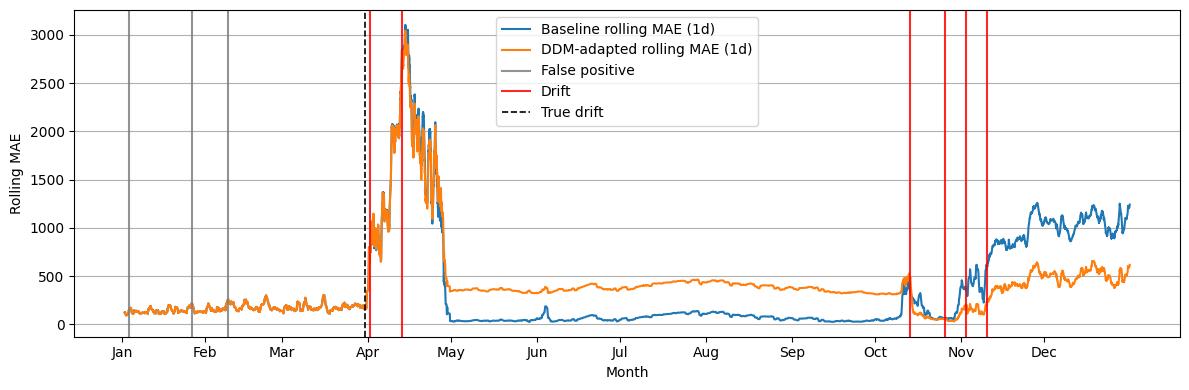

In [45]:
# xticks, _ = _month_ticks(mo3_lab)

# # --- plotting-only change: month abbreviations derived from month column ---
# xticks = np.asarray(xticks, dtype=int)
# import calendar
# mo_at_ticks = np.asarray(mo3_lab)[xticks].astype(int)
# xlabels = [calendar.month_abbr[m] if 1 <= m <= 12 else str(m) for m in mo_at_ticks]  # 'Jan'..'Dec'
# # --------------------------------------------------------------------------------------

# plt.figure(figsize=(12,4))
# plt.plot(mae3_base_roll,  label=f"Baseline rolling MAE ({ROLL_DAYS}d)")
# plt.plot(mae_adapt_roll,  label=f"DDM-adapted rolling MAE ({ROLL_DAYS}d)")

# # Add both legend entries once: gray=FPs (pre Apr-1), red=drifts (post Apr-1)
# shown_fp = False
# shown_drift = False

# for di in ddm_all_drifts:
#     is_post = (ts3_lab[di] >= ONLY_AFTER_TS)
#     color = "red" if is_post else "tab:gray"

#     if is_post and (not shown_drift):
#         lab = "Drift"
#         shown_drift = True
#     elif (not is_post) and (not shown_fp):
#         lab = "False positive"
#         shown_fp = True
#     else:
#         lab = "_nolegend_"  # labels starting with '_' are ignored by legend() [web:45]

#     plt.axvline(di, color=color, linestyle="-", linewidth=1.5, alpha=0.85, label=lab)

# plt.axvline(tau_idx, color="black", linestyle="--", linewidth=1.2, label="True drift")
# plt.xticks(xticks, xlabels)
# plt.xlabel("Month"); plt.ylabel("Rolling MAE")
# plt.title("")
# plt.grid(True, axis='y'); plt.legend(); plt.tight_layout(); plt.show()


=== Year 4 — Per-horizon metrics (MAE, RMSE, sMAPE%) ===


horizon  MAE_base  MAE_adapt  RMSE_base  RMSE_adapt  sMAPE%_base  \
0     t+1     304.3      242.1    1,033.7       739.8        168.7   
1     t+2     305.9      200.9      843.3       554.5        171.3   
2     t+3     355.3      206.1      941.9       604.8        172.5   
3     t+4     380.9      189.0      869.9       535.1        173.7   

   sMAPE%_adapt  MAPE%_base  MAPE%_adapt  
0         166.6     8,391.6     13,218.7  
1         166.9     9,514.6     11,514.6  
2         168.1    11,361.8     10,740.6  
3         168.5    12,449.3      8,875.1


=== Year 4 — Aggregate metrics (means over windows; Option B) ===


MAE_mean  RMSE_mean  sMAPE_mean%  MAPE_mean%  WAPE%
Baseline                   336.6      384.0        171.6    10,429.3  149.4
Adaptive-DDM (gradual)     209.5      252.1        167.5    11,087.3   93.0


=== Year 4 — Global metrics (flattened over all windows x horizons) ===


MAE_global  RMSE_global  sMAPE_global%  MAPE_global%  \
Baseline                     336.6        925.1          171.6      10,429.3   
Adaptive-DDM (gradual)       209.5        613.8          167.5      11,087.3   

                        WAPE_global%  
Baseline                       149.4  
Adaptive-DDM (gradual)          93.0

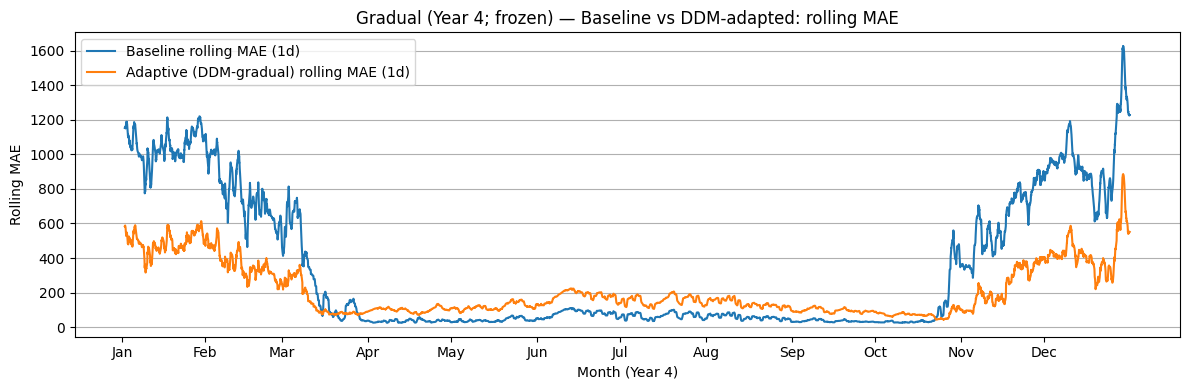

In [93]:
# ===== Year-4 evaluation for GRADUAL-DDM adaptive model (Option B aggregates) =====
# Assumes: baseline_model, ddm_model_gradual, df_drift, FEATS, X_scaler, idx_t
# Also assumes: LOOKBACK, HORIZON, make_windows_multi, inv_steps_from_X_scaler
# Metrics: mean_absolute_error, mean_squared_error imported from sklearn.metrics

from sklearn.metrics import mean_absolute_percentage_error  # MAPE returns relative value (0..inf), not 0..100 [web:1]

# ---------- Helpers ----------
def _label_rows(n_full, lookback, horizon):
    return (np.arange(lookback, n_full - horizon + 1) + (horizon - 1))

def _build_year_windows(df_year: pd.DataFrame):
    X  = df_year[FEATS].to_numpy(float)
    Xs = X_scaler.transform(X)
    ys = Xs[:, idx_t].copy()

    Xw, Yw = make_windows_multi(Xs, ys, LOOKBACK, HORIZON, stride=1)

    n_full = len(df_year)
    lbl_idx = _label_rows(n_full, LOOKBACK, HORIZON)
    ts_lab  = df_year.iloc[lbl_idx]["timestamp_sec"].to_numpy()
    mo_lab  = df_year.iloc[lbl_idx]["month"].to_numpy()
    return Xw, Yw, ts_lab, mo_lab, lbl_idx

def _predict_unscaled(model, Xw, Yw):
    Y_hat_s = model.predict(Xw, verbose=0)
    Y_true  = inv_steps_from_X_scaler(Yw,      X_scaler, idx_t, HORIZON)
    Y_hat   = inv_steps_from_X_scaler(Y_hat_s, X_scaler, idx_t, HORIZON)
    return Y_true, Y_hat

def _window_mae(y_true_row, y_hat_row):
    return float(np.mean(np.abs(y_true_row - y_hat_row)))

def _window_rmse(y_true_row, y_hat_row):
    return float(np.sqrt(np.mean((y_true_row - y_hat_row) ** 2)))

def _window_smape(y_true_row, y_hat_row, eps=1e-6):
    num = np.abs(y_true_row - y_hat_row)
    den = (np.abs(y_true_row) + np.abs(y_hat_row)).clip(min=eps)
    return float(np.mean(2.0 * num / den) * 100.0)  # %

def _rolling_mean(values, k):
    if k <= 1:
        return values.astype(float)
    out = np.full(len(values), np.nan, float)
    if len(values) >= k:
        csum = np.cumsum(values, dtype=float)
        out[k-1:] = (csum[k-1:] - np.concatenate(([0.0], csum[:-k])))/k
    return out

def _month_ticks(months_arr):
    starts, labels, seen = [], [], set()
    for i, m in enumerate(months_arr):
        if m not in seen:
            starts.append(i)
            labels.append(f"M{int(m):02d}")
            seen.add(m)
    return np.array(starts), labels

def _per_horizon_smape(y_true_2d, y_hat_2d, eps=1e-6):
    Hh = y_true_2d.shape[1]
    vals = []
    for h in range(Hh):
        num = np.abs(y_true_2d[:, h] - y_hat_2d[:, h])
        den = (np.abs(y_true_2d[:, h]) + np.abs(y_hat_2d[:, h])).clip(min=eps)
        vals.append(float(np.mean(2.0 * num / den) * 100.0))
    return vals


# ---------- 1) Build Year 4 windows ----------
y4_df = df_drift[df_drift["year"] == 4].reset_index(drop=True)
assert len(y4_df) >= LOOKBACK + HORIZON + 1, "Year 4 has insufficient rows."

X4_win, Y4_win, ts4_lab, mo4_lab, _ = _build_year_windows(y4_df)

if len(ts4_lab) > 1 and np.isfinite(ts4_lab).all():
    dt_sec = float(np.median(np.diff(ts4_lab)))
    steps_per_day = max(1, int(round((24 * 3600) / dt_sec)))
else:
    steps_per_day = 96  # fallback for 15-min cadence

ROLL_DAYS  = 1
roll_steps = max(1, ROLL_DAYS * steps_per_day)


# ---------- 2) Predict (baseline vs GRADUAL-DDM adaptive) ----------
adaptive_model = ddm_model_gradual
Y4_true, Y4_hat_base  = _predict_unscaled(baseline_model, X4_win, Y4_win)
_,       Y4_hat_adpt  = _predict_unscaled(adaptive_model, X4_win, Y4_win)

H_eval = Y4_true.shape[1]  # should equal HORIZON


# ---------- 3) Per-horizon metrics (diagnostic table) ----------
mae_base   = [mean_absolute_error(Y4_true[:, h], Y4_hat_base[:, h]) for h in range(H_eval)]
mae_adpt   = [mean_absolute_error(Y4_true[:, h], Y4_hat_adpt[:, h]) for h in range(H_eval)]

# RMSE per horizon: compute sqrt(MSE) explicitly (avoid squared=False deprecation)
rmse_base  = [float(np.sqrt(mean_squared_error(Y4_true[:, h], Y4_hat_base[:, h]))) for h in range(H_eval)]
rmse_adpt  = [float(np.sqrt(mean_squared_error(Y4_true[:, h], Y4_hat_adpt[:, h]))) for h in range(H_eval)]

smape_base = _per_horizon_smape(Y4_true, Y4_hat_base)
smape_adpt = _per_horizon_smape(Y4_true, Y4_hat_adpt)

# --- FIXED: MAPE per horizon (as percent; eps floor = 1.0 in target units) ---
mape_base  = [
    float(np.mean(np.abs((Y4_true[:, h] - Y4_hat_base[:, h]) / np.maximum(np.abs(Y4_true[:, h]), 1.0))) * 100.0)
    for h in range(H_eval)
]
mape_adpt  = [
    float(np.mean(np.abs((Y4_true[:, h] - Y4_hat_adpt[:, h]) / np.maximum(np.abs(Y4_true[:, h]), 1.0))) * 100.0)
    for h in range(H_eval)
]

per_horizon_tbl = pd.DataFrame({
    "horizon":     [f"t+{i+1}" for i in range(H_eval)],
    "MAE_base":    mae_base,   "MAE_adapt":    mae_adpt,
    "RMSE_base":   rmse_base,  "RMSE_adapt":   rmse_adpt,
    "sMAPE%_base": smape_base, "sMAPE%_adapt": smape_adpt,
    "MAPE%_base":  mape_base,  "MAPE%_adapt":  mape_adpt,
})

print("=== Year 4 — Per-horizon metrics (MAE, RMSE, sMAPE%) ===")
display(per_horizon_tbl)


# ---------- 4) Aggregate metrics (Option B: mean over windows) ----------
# Per-window errors
mae4_base_win   = np.mean(np.abs(Y4_true - Y4_hat_base), axis=1).astype(float)  # mean over horizon
mae4_adpt_win   = np.mean(np.abs(Y4_true - Y4_hat_adpt), axis=1).astype(float)

rmse4_base_win  = np.sqrt(np.mean((Y4_true - Y4_hat_base) ** 2, axis=1)).astype(float)  # RMSE over horizon
rmse4_adpt_win  = np.sqrt(np.mean((Y4_true - Y4_hat_adpt) ** 2, axis=1)).astype(float)

smape4_base_win = np.array([_window_smape(Y4_true[i], Y4_hat_base[i]) for i in range(len(X4_win))], float)
smape4_adpt_win = np.array([_window_smape(Y4_true[i], Y4_hat_adpt[i]) for i in range(len(X4_win))], float)

# --- FIXED: MAPE per window (mean over horizon), as percent; eps floor = 1.0 in target units ---
mape4_base_win  = np.mean(np.abs((Y4_true - Y4_hat_base) / np.maximum(np.abs(Y4_true), 1.0)), axis=1) * 100.0
mape4_adpt_win  = np.mean(np.abs((Y4_true - Y4_hat_adpt) / np.maximum(np.abs(Y4_true), 1.0)), axis=1) * 100.0

# Optional WAPE (global) if you want it (you used it elsewhere)
wape_base = (np.sum(np.abs(Y4_true - Y4_hat_base)) / max(np.sum(np.abs(Y4_true)), 1e-12)) * 100.0
wape_adpt = (np.sum(np.abs(Y4_true - Y4_hat_adpt)) / max(np.sum(np.abs(Y4_true)), 1e-12)) * 100.0

aggregate_tbl = pd.DataFrame({
    "MAE_mean":    [float(np.mean(mae4_base_win)),    float(np.mean(mae4_adpt_win))],
    "RMSE_mean":   [float(np.mean(rmse4_base_win)),   float(np.mean(rmse4_adpt_win))],
    "sMAPE_mean%": [float(np.mean(smape4_base_win)),  float(np.mean(smape4_adpt_win))],
    "MAPE_mean%":  [float(np.mean(mape4_base_win)),   float(np.mean(mape4_adpt_win))],
    "WAPE%":       [float(wape_base),                float(wape_adpt)],
}, index=["Baseline", "Adaptive-DDM (gradual)"])

print("\n=== Year 4 — Aggregate metrics (means over windows; Option B) ===")
display(aggregate_tbl)

# ---------- ADDED: Global metrics (flattened over all windows x horizons) ----------
_eps_g = 1e-6

_diff_base = (Y4_true - Y4_hat_base)
mae_base_global  = float(np.mean(np.abs(_diff_base)))
rmse_base_global = float(np.sqrt(np.mean(_diff_base ** 2)))
_den_base = (np.abs(Y4_true) + np.abs(Y4_hat_base)).clip(min=_eps_g)
smape_base_global = float(np.mean(2.0 * np.abs(_diff_base) / _den_base) * 100.0)
# ---------- FIXED: MAPE global (baseline; eps floor = 1.0 in target units) ----------
_den_mape_base = np.maximum(np.abs(Y4_true), 1.0)
mape_base_global = float(np.mean(np.abs(_diff_base) / _den_mape_base) * 100.0)
wape_base_global  = float(wape_base)

_diff_adpt = (Y4_true - Y4_hat_adpt)
mae_adpt_global  = float(np.mean(np.abs(_diff_adpt)))
rmse_adpt_global = float(np.sqrt(np.mean(_diff_adpt ** 2)))
_den_adpt = (np.abs(Y4_true) + np.abs(Y4_hat_adpt)).clip(min=_eps_g)
smape_adpt_global = float(np.mean(2.0 * np.abs(_diff_adpt) / _den_adpt) * 100.0)
# ---------- FIXED: MAPE global (adaptive; eps floor = 1.0 in target units) ----------
_den_mape_adpt = np.maximum(np.abs(Y4_true), 1.0)
mape_adpt_global = float(np.mean(np.abs(_diff_adpt) / _den_mape_adpt) * 100.0)
wape_adpt_global  = float(wape_adpt)

global_tbl = pd.DataFrame({
    "MAE_global":     [mae_base_global,   mae_adpt_global],
    "RMSE_global":    [rmse_base_global,  rmse_adpt_global],
    "sMAPE_global%":  [smape_base_global, smape_adpt_global],
    "MAPE_global%":   [mape_base_global,  mape_adpt_global],
    "WAPE_global%":   [wape_base_global,  wape_adpt_global],
}, index=["Baseline", "Adaptive-DDM (gradual)"])

print("\n=== Year 4 — Global metrics (flattened over all windows x horizons) ===")
display(global_tbl)
# ----------------------------------------------------------------------


# ---------- 5) Rolling MAE plot ----------
mae4_base_roll = _rolling_mean(mae4_base_win, roll_steps)
mae4_adpt_roll = _rolling_mean(mae4_adpt_win, roll_steps)

xt, _ = _month_ticks(mo4_lab)
xt = np.asarray(xt, dtype=int)

import calendar
mo_at_ticks = np.asarray(mo4_lab)[xt].astype(int)
xl = [calendar.month_abbr[m] if 1 <= m <= 12 else str(m) for m in mo_at_ticks]  # 'Jan'..'Dec'

plt.figure(figsize=(12, 4))
plt.plot(mae4_base_roll, label=f"Baseline rolling MAE ({ROLL_DAYS}d)")
plt.plot(mae4_adpt_roll, label=f"Adaptive (DDM-gradual) rolling MAE ({ROLL_DAYS}d)")
plt.xticks(xt, xl)
plt.xlabel("Month (Year 4)")
plt.ylabel("Rolling MAE")
plt.title("Gradual (Year 4; frozen) — Baseline vs DDM-adapted: rolling MAE")
plt.grid(True, axis="y")
plt.legend()
plt.tight_layout()
plt.show()


=== Year 5 — Per-horizon metrics (MAE, RMSE, sMAPE%) ===


horizon  MAE_base  MAE_adapt  RMSE_base  RMSE_adapt  sMAPE%_base  \
0     t+1     342.1      263.4    1,072.5       768.6        168.2   
1     t+2     348.3      222.3      885.6       579.9        170.3   
2     t+3     403.2      232.8      993.6       645.5        171.6   
3     t+4     433.0      218.9      941.0       601.1        172.7   

   sMAPE%_adapt  MAPE%_base  MAPE%_adapt  
0         164.3    10,265.0     14,290.9  
1         164.7    11,720.5     12,614.5  
2         166.1    13,880.6     12,131.6  
3         166.6    14,936.3     10,367.9


=== Year 5 — Aggregate metrics (means over windows; Option B) ===


MAE_mean  RMSE_mean  sMAPE_mean%  MAPE_mean%  WAPE%
Baseline                   381.6      433.4        170.7    12,700.6  162.3
Adaptive-DDM (gradual)     234.3      279.8        165.4    12,351.2   99.7


=== Year 5 — Global metrics (flattened over all windows x horizons) ===


MAE_global  RMSE_global  sMAPE_global%  MAPE_global%  \
Baseline                     381.6        975.6          170.7      12,700.6   
Adaptive-DDM (gradual)       234.3        652.9          165.4      12,351.2   

                        WAPE_global%  
Baseline                       162.3  
Adaptive-DDM (gradual)          99.7

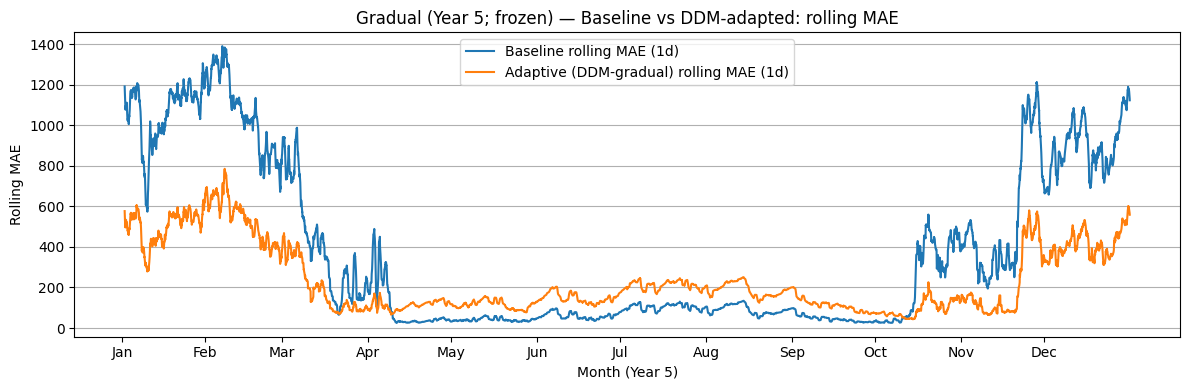

In [94]:
from sklearn.metrics import mean_absolute_percentage_error  # returns relative; *100 -> percent [web:1]


# ---------- Helpers ----------
def _label_rows(n_full, lookback, horizon):
    return (np.arange(lookback, n_full - horizon + 1) + (horizon - 1))

def _build_year_windows(df_year: pd.DataFrame):
    X  = df_year[FEATS].to_numpy(float)
    Xs = X_scaler.transform(X)
    ys = Xs[:, idx_t].copy()

    Xw, Yw = make_windows_multi(Xs, ys, LOOKBACK, HORIZON, stride=1)

    n_full = len(df_year)
    lbl_idx = _label_rows(n_full, LOOKBACK, HORIZON)
    ts_lab  = df_year.iloc[lbl_idx]["timestamp_sec"].to_numpy()
    mo_lab  = df_year.iloc[lbl_idx]["month"].to_numpy()
    return Xw, Yw, ts_lab, mo_lab, lbl_idx

def _predict_unscaled(model, Xw, Yw):
    Y_hat_s = model.predict(Xw, verbose=0)
    Y_true  = inv_steps_from_X_scaler(Yw,      X_scaler, idx_t, HORIZON)
    Y_hat   = inv_steps_from_X_scaler(Y_hat_s, X_scaler, idx_t, HORIZON)
    return Y_true, Y_hat

def _window_mae(y_true_row, y_hat_row):
    return float(np.mean(np.abs(y_true_row - y_hat_row)))

def _window_rmse(y_true_row, y_hat_row):
    return float(np.sqrt(np.mean((y_true_row - y_hat_row) ** 2)))

def _window_smape(y_true_row, y_hat_row, eps=1e-6):
    num = np.abs(y_true_row - y_hat_row)
    den = (np.abs(y_true_row) + np.abs(y_hat_row)).clip(min=eps)
    return float(np.mean(2.0 * num / den) * 100.0)  # %

def _rolling_mean(values, k):
    if k <= 1:
        return values.astype(float)
    out = np.full(len(values), np.nan, float)
    if len(values) >= k:
        csum = np.cumsum(values, dtype=float)
        out[k-1:] = (csum[k-1:] - np.concatenate(([0.0], csum[:-k])))/k
    return out

def _month_ticks(months_arr):
    starts, labels, seen = [], [], set()
    for i, m in enumerate(months_arr):
        if m not in seen:
            starts.append(i)
            labels.append(f"M{int(m):02d}")
            seen.add(m)
    return np.array(starts), labels

def _per_horizon_smape(y_true_2d, y_hat_2d, eps=1e-6):
    Hh = y_true_2d.shape[1]
    vals = []
    for h in range(Hh):
        num = np.abs(y_true_2d[:, h] - y_hat_2d[:, h])
        den = (np.abs(y_true_2d[:, h]) + np.abs(y_hat_2d[:, h])).clip(min=eps)
        vals.append(float(np.mean(2.0 * num / den) * 100.0))
    return vals


# ---------- 1) Build Year 4 windows ----------
y4_df = df_drift[df_drift["year"] == 5].reset_index(drop=True)
assert len(y4_df) >= LOOKBACK + HORIZON + 1, "Year 5 has insufficient rows."

X4_win, Y4_win, ts4_lab, mo4_lab, _ = _build_year_windows(y4_df)

if len(ts4_lab) > 1 and np.isfinite(ts4_lab).all():
    dt_sec = float(np.median(np.diff(ts4_lab)))
    steps_per_day = max(1, int(round((24 * 3600) / dt_sec)))
else:
    steps_per_day = 96  # fallback for 15-min cadence

ROLL_DAYS  = 1
roll_steps = max(1, ROLL_DAYS * steps_per_day)


# ---------- 2) Predict (baseline vs GRADUAL-DDM adaptive) ----------
adaptive_model = ddm_model_gradual
Y4_true, Y4_hat_base  = _predict_unscaled(baseline_model, X4_win, Y4_win)
_,       Y4_hat_adpt  = _predict_unscaled(adaptive_model, X4_win, Y4_win)

H_eval = Y4_true.shape[1]  # should equal HORIZON


# ---------- 3) Per-horizon metrics (diagnostic table) ----------
mae_base   = [mean_absolute_error(Y4_true[:, h], Y4_hat_base[:, h]) for h in range(H_eval)]
mae_adpt   = [mean_absolute_error(Y4_true[:, h], Y4_hat_adpt[:, h]) for h in range(H_eval)]

# RMSE per horizon: compute sqrt(MSE) explicitly (avoid squared=False deprecation)
rmse_base  = [float(np.sqrt(mean_squared_error(Y4_true[:, h], Y4_hat_base[:, h]))) for h in range(H_eval)]
rmse_adpt  = [float(np.sqrt(mean_squared_error(Y4_true[:, h], Y4_hat_adpt[:, h]))) for h in range(H_eval)]

smape_base = _per_horizon_smape(Y4_true, Y4_hat_base)
smape_adpt = _per_horizon_smape(Y4_true, Y4_hat_adpt)

# ---------- FIXED: MAPE per horizon (as %; eps floor = 1.0 in target units) ----------
mape_base  = [
    float(np.mean(np.abs((Y4_true[:, h] - Y4_hat_base[:, h]) / np.maximum(np.abs(Y4_true[:, h]), 1.0))) * 100.0)
    for h in range(H_eval)
]
mape_adpt  = [
    float(np.mean(np.abs((Y4_true[:, h] - Y4_hat_adpt[:, h]) / np.maximum(np.abs(Y4_true[:, h]), 1.0))) * 100.0)
    for h in range(H_eval)
]

per_horizon_tbl = pd.DataFrame({
    "horizon":     [f"t+{i+1}" for i in range(H_eval)],
    "MAE_base":    mae_base,   "MAE_adapt":    mae_adpt,
    "RMSE_base":   rmse_base,  "RMSE_adapt":   rmse_adpt,
    "sMAPE%_base": smape_base, "sMAPE%_adapt": smape_adpt,
    "MAPE%_base":  mape_base,  "MAPE%_adapt":  mape_adpt
})

print("=== Year 5 — Per-horizon metrics (MAE, RMSE, sMAPE%) ===")
display(per_horizon_tbl)


# ---------- 4) Aggregate metrics (Option B: mean over windows) ----------
# Per-window errors
mae4_base_win   = np.mean(np.abs(Y4_true - Y4_hat_base), axis=1).astype(float)  # mean over horizon
mae4_adpt_win   = np.mean(np.abs(Y4_true - Y4_hat_adpt), axis=1).astype(float)

rmse4_base_win  = np.sqrt(np.mean((Y4_true - Y4_hat_base) ** 2, axis=1)).astype(float)  # RMSE over horizon
rmse4_adpt_win  = np.sqrt(np.mean((Y4_true - Y4_hat_adpt) ** 2, axis=1)).astype(float)

smape4_base_win = np.array([_window_smape(Y4_true[i], Y4_hat_base[i]) for i in range(len(X4_win))], float)
smape4_adpt_win = np.array([_window_smape(Y4_true[i], Y4_hat_adpt[i]) for i in range(len(X4_win))], float)

# ---------- FIXED: MAPE per window (mean over horizon, as %; eps floor = 1.0 in target units) ----------
mape4_base_win = np.mean(np.abs((Y4_true - Y4_hat_base) / np.maximum(np.abs(Y4_true), 1.0)), axis=1).astype(float) * 100.0
mape4_adpt_win = np.mean(np.abs((Y4_true - Y4_hat_adpt) / np.maximum(np.abs(Y4_true), 1.0)), axis=1).astype(float) * 100.0

# Optional WAPE (global) if you want it (you used it elsewhere) [web:1]
wape_base = (np.sum(np.abs(Y4_true - Y4_hat_base)) / max(np.sum(np.abs(Y4_true)), 1e-12)) * 100.0
wape_adpt = (np.sum(np.abs(Y4_true - Y4_hat_adpt)) / max(np.sum(np.abs(Y4_true)), 1e-12)) * 100.0
from sklearn.metrics import mean_absolute_percentage_error  # returns relative; *100 -> percent [web:1]


# ---------- Helpers ----------
def _label_rows(n_full, lookback, horizon):
    return (np.arange(lookback, n_full - horizon + 1) + (horizon - 1))

def _build_year_windows(df_year: pd.DataFrame):
    X  = df_year[FEATS].to_numpy(float)
    Xs = X_scaler.transform(X)
    ys = Xs[:, idx_t].copy()

    Xw, Yw = make_windows_multi(Xs, ys, LOOKBACK, HORIZON, stride=1)

    n_full = len(df_year)
    lbl_idx = _label_rows(n_full, LOOKBACK, HORIZON)
    ts_lab  = df_year.iloc[lbl_idx]["timestamp_sec"].to_numpy()
    mo_lab  = df_year.iloc[lbl_idx]["month"].to_numpy()
    return Xw, Yw, ts_lab, mo_lab, lbl_idx

def _predict_unscaled(model, Xw, Yw):
    Y_hat_s = model.predict(Xw, verbose=0)
    Y_true  = inv_steps_from_X_scaler(Yw,      X_scaler, idx_t, HORIZON)
    Y_hat   = inv_steps_from_X_scaler(Y_hat_s, X_scaler, idx_t, HORIZON)
    return Y_true, Y_hat

def _window_mae(y_true_row, y_hat_row):
    return float(np.mean(np.abs(y_true_row - y_hat_row)))

def _window_rmse(y_true_row, y_hat_row):
    return float(np.sqrt(np.mean((y_true_row - y_hat_row) ** 2)))

def _window_smape(y_true_row, y_hat_row, eps=1e-6):
    num = np.abs(y_true_row - y_hat_row)
    den = (np.abs(y_true_row) + np.abs(y_hat_row)).clip(min=eps)
    return float(np.mean(2.0 * num / den) * 100.0)  # %

def _rolling_mean(values, k):
    if k <= 1:
        return values.astype(float)
    out = np.full(len(values), np.nan, float)
    if len(values) >= k:
        csum = np.cumsum(values, dtype=float)
        out[k-1:] = (csum[k-1:] - np.concatenate(([0.0], csum[:-k])))/k
    return out

def _month_ticks(months_arr):
    starts, labels, seen = [], [], set()
    for i, m in enumerate(months_arr):
        if m not in seen:
            starts.append(i)
            labels.append(f"M{int(m):02d}")
            seen.add(m)
    return np.array(starts), labels

def _per_horizon_smape(y_true_2d, y_hat_2d, eps=1e-6):
    Hh = y_true_2d.shape[1]
    vals = []
    for h in range(Hh):
        num = np.abs(y_true_2d[:, h] - y_hat_2d[:, h])
        den = (np.abs(y_true_2d[:, h]) + np.abs(y_hat_2d[:, h])).clip(min=eps)
        vals.append(float(np.mean(2.0 * num / den) * 100.0))
    return vals


# ---------- 1) Build Year 4 windows ----------
y4_df = df_drift[df_drift["year"] == 5].reset_index(drop=True)
assert len(y4_df) >= LOOKBACK + HORIZON + 1, "Year 5 has insufficient rows."

X4_win, Y4_win, ts4_lab, mo4_lab, _ = _build_year_windows(y4_df)

if len(ts4_lab) > 1 and np.isfinite(ts4_lab).all():
    dt_sec = float(np.median(np.diff(ts4_lab)))
    steps_per_day = max(1, int(round((24 * 3600) / dt_sec)))
else:
    steps_per_day = 96  # fallback for 15-min cadence

ROLL_DAYS  = 1
roll_steps = max(1, ROLL_DAYS * steps_per_day)


# ---------- 2) Predict (baseline vs GRADUAL-DDM adaptive) ----------
adaptive_model = ddm_model_gradual
Y4_true, Y4_hat_base  = _predict_unscaled(baseline_model, X4_win, Y4_win)
_,       Y4_hat_adpt  = _predict_unscaled(adaptive_model, X4_win, Y4_win)

H_eval = Y4_true.shape[1]  # should equal HORIZON


# ---------- 3) Per-horizon metrics (diagnostic table) ----------
mae_base   = [mean_absolute_error(Y4_true[:, h], Y4_hat_base[:, h]) for h in range(H_eval)]
mae_adpt   = [mean_absolute_error(Y4_true[:, h], Y4_hat_adpt[:, h]) for h in range(H_eval)]

# RMSE per horizon: compute sqrt(MSE) explicitly (avoid squared=False deprecation)
rmse_base  = [float(np.sqrt(mean_squared_error(Y4_true[:, h], Y4_hat_base[:, h]))) for h in range(H_eval)]
rmse_adpt  = [float(np.sqrt(mean_squared_error(Y4_true[:, h], Y4_hat_adpt[:, h]))) for h in range(H_eval)]

smape_base = _per_horizon_smape(Y4_true, Y4_hat_base)
smape_adpt = _per_horizon_smape(Y4_true, Y4_hat_adpt)

# ---------- FIXED: MAPE per horizon (as %; eps floor = 1.0 in target units) ----------
mape_base  = [
    float(np.mean(np.abs((Y4_true[:, h] - Y4_hat_base[:, h]) / np.maximum(np.abs(Y4_true[:, h]), 1.0))) * 100.0)
    for h in range(H_eval)
]
mape_adpt  = [
    float(np.mean(np.abs((Y4_true[:, h] - Y4_hat_adpt[:, h]) / np.maximum(np.abs(Y4_true[:, h]), 1.0))) * 100.0)
    for h in range(H_eval)
]

per_horizon_tbl = pd.DataFrame({
    "horizon":     [f"t+{i+1}" for i in range(H_eval)],
    "MAE_base":    mae_base,   "MAE_adapt":    mae_adpt,
    "RMSE_base":   rmse_base,  "RMSE_adapt":   rmse_adpt,
    "sMAPE%_base": smape_base, "sMAPE%_adapt": smape_adpt,
    "MAPE%_base":  mape_base,  "MAPE%_adapt":  mape_adpt
})

print("=== Year 5 — Per-horizon metrics (MAE, RMSE, sMAPE%) ===")
display(per_horizon_tbl)


# ---------- 4) Aggregate metrics (Option B: mean over windows) ----------
# Per-window errors
mae4_base_win   = np.mean(np.abs(Y4_true - Y4_hat_base), axis=1).astype(float)  # mean over horizon
mae4_adpt_win   = np.mean(np.abs(Y4_true - Y4_hat_adpt), axis=1).astype(float)

rmse4_base_win  = np.sqrt(np.mean((Y4_true - Y4_hat_base) ** 2, axis=1)).astype(float)  # RMSE over horizon
rmse4_adpt_win  = np.sqrt(np.mean((Y4_true - Y4_hat_adpt) ** 2, axis=1)).astype(float)

smape4_base_win = np.array([_window_smape(Y4_true[i], Y4_hat_base[i]) for i in range(len(X4_win))], float)
smape4_adpt_win = np.array([_window_smape(Y4_true[i], Y4_hat_adpt[i]) for i in range(len(X4_win))], float)

# ---------- FIXED: MAPE per window (mean over horizon, as %; eps floor = 1.0 in target units) ----------
mape4_base_win = np.mean(np.abs((Y4_true - Y4_hat_base) / np.maximum(np.abs(Y4_true), 1.0)), axis=1).astype(float) * 100.0
mape4_adpt_win = np.mean(np.abs((Y4_true - Y4_hat_adpt) / np.maximum(np.abs(Y4_true), 1.0)), axis=1).astype(float) * 100.0

# Optional WAPE (global) if you want it (you used it elsewhere) [web:1]
wape_base = (np.sum(np.abs(Y4_true - Y4_hat_base)) / max(np.sum(np.abs(Y4_true)), 1e-12)) * 100.0
wape_adpt = (np.sum(np.abs(Y4_true - Y4_hat_adpt)) / max(np.sum(np.abs(Y4_true)), 1e-12)) * 100.0

aggregate_tbl = pd.DataFrame({
    "MAE_mean":    [float(np.mean(mae4_base_win)),    float(np.mean(mae4_adpt_win))],
    "RMSE_mean":   [float(np.mean(rmse4_base_win)),   float(np.mean(rmse4_adpt_win))],
    "sMAPE_mean%": [float(np.mean(smape4_base_win)),  float(np.mean(smape4_adpt_win))],
    "MAPE_mean%":  [float(np.mean(mape4_base_win)),   float(np.mean(mape4_adpt_win))],
    "WAPE%":       [float(wape_base),                float(wape_adpt)],
}, index=["Baseline", "Adaptive-DDM (gradual)"])

print("\n=== Year 5 — Aggregate metrics (means over windows; Option B) ===")
display(aggregate_tbl)

# ---------- ADDED: Global metrics (flattened over all windows x horizons) ----------
_eps_g = 1e-6

_diff_base = (Y4_true - Y4_hat_base)
mae_base_global  = float(np.mean(np.abs(_diff_base)))
rmse_base_global = float(np.sqrt(np.mean(_diff_base ** 2)))
_den_base = (np.abs(Y4_true) + np.abs(Y4_hat_base)).clip(min=_eps_g)
smape_base_global = float(np.mean(2.0 * np.abs(_diff_base) / _den_base) * 100.0)
# ---------- FIXED: MAPE global (baseline; eps floor = 1.0 in target units) ----------
_den_mape_base = np.maximum(np.abs(Y4_true), 1.0)
mape_base_global = float(np.mean(np.abs(_diff_base) / _den_mape_base) * 100.0)
wape_base_global  = float(wape_base)

_diff_adpt = (Y4_true - Y4_hat_adpt)
mae_adpt_global  = float(np.mean(np.abs(_diff_adpt)))
rmse_adpt_global = float(np.sqrt(np.mean(_diff_adpt ** 2)))
_den_adpt = (np.abs(Y4_true) + np.abs(Y4_hat_adpt)).clip(min=_eps_g)
smape_adpt_global = float(np.mean(2.0 * np.abs(_diff_adpt) / _den_adpt) * 100.0)
# ---------- FIXED: MAPE global (adaptive; eps floor = 1.0 in target units) ----------
_den_mape_adpt = np.maximum(np.abs(Y4_true), 1.0)
mape_adpt_global = float(np.mean(np.abs(_diff_adpt) / _den_mape_adpt) * 100.0)
wape_adpt_global  = float(wape_adpt)

global_tbl = pd.DataFrame({
    "MAE_global":     [mae_base_global,   mae_adpt_global],
    "RMSE_global":    [rmse_base_global,  rmse_adpt_global],
    "sMAPE_global%":  [smape_base_global, smape_adpt_global],
    "MAPE_global%":   [mape_base_global,  mape_adpt_global],
    "WAPE_global%":   [wape_base_global,  wape_adpt_global],
}, index=["Baseline", "Adaptive-DDM (gradual)"])

print("\n=== Year 5 — Global metrics (flattened over all windows x horizons) ===")
display(global_tbl)
# ----------------------------------------------------------------------


# ---------- 5) Rolling MAE plot ----------
mae4_base_roll = _rolling_mean(mae4_base_win, roll_steps)
mae4_adpt_roll = _rolling_mean(mae4_adpt_win, roll_steps)

xt, _ = _month_ticks(mo4_lab)
xt = np.asarray(xt, dtype=int)

import calendar
mo_at_ticks = np.asarray(mo4_lab)[xt].astype(int)
xl = [calendar.month_abbr[m] if 1 <= m <= 12 else str(m) for m in mo_at_ticks]  # 'Jan'..'Dec'

plt.figure(figsize=(12, 4))
plt.plot(mae4_base_roll, label=f"Baseline rolling MAE ({ROLL_DAYS}d)")
plt.plot(mae4_adpt_roll, label=f"Adaptive (DDM-gradual) rolling MAE ({ROLL_DAYS}d)")
plt.xticks(xt, xl)
plt.xlabel("Month (Year 5)")
plt.ylabel("Rolling MAE")
plt.title("Gradual (Year 5; frozen) — Baseline vs DDM-adapted: rolling MAE")
plt.grid(True, axis="y")
plt.legend()
plt.tight_layout()
plt.show()

aggregate_tbl = pd.DataFrame({
    "MAE_mean":    [float(np.mean(mae4_base_win)),    float(np.mean(mae4_adpt_win))],
    "RMSE_mean":   [float(np.mean(rmse4_base_win)),   float(np.mean(rmse4_adpt_win))],
    "sMAPE_mean%": [float(np.mean(smape4_base_win)),  float(np.mean(smape4_adpt_win))],
    "MAPE_mean%":  [float(np.mean(mape4_base_win)),   float(np.mean(mape4_adpt_win))],
    "WAPE%":       [float(wape_base),                float(wape_adpt)],
}, index=["Baseline", "Adaptive-DDM (gradual)"])

print("\n=== Year 5 — Aggregate metrics (means over windows; Option B) ===")
display(aggregate_tbl)

# ---------- ADDED: Global metrics (flattened over all windows x horizons) ----------
_eps_g = 1e-6

_diff_base = (Y4_true - Y4_hat_base)
mae_base_global  = float(np.mean(np.abs(_diff_base)))
rmse_base_global = float(np.sqrt(np.mean(_diff_base ** 2)))
_den_base = (np.abs(Y4_true) + np.abs(Y4_hat_base)).clip(min=_eps_g)
smape_base_global = float(np.mean(2.0 * np.abs(_diff_base) / _den_base) * 100.0)
# ---------- FIXED: MAPE global (baseline; eps floor = 1.0 in target units) ----------
_den_mape_base = np.maximum(np.abs(Y4_true), 1.0)
mape_base_global = float(np.mean(np.abs(_diff_base) / _den_mape_base) * 100.0)
wape_base_global  = float(wape_base)

_diff_adpt = (Y4_true - Y4_hat_adpt)
mae_adpt_global  = float(np.mean(np.abs(_diff_adpt)))
rmse_adpt_global = float(np.sqrt(np.mean(_diff_adpt ** 2)))
_den_adpt = (np.abs(Y4_true) + np.abs(Y4_hat_adpt)).clip(min=_eps_g)
smape_adpt_global = float(np.mean(2.0 * np.abs(_diff_adpt) / _den_adpt) * 100.0)
# ---------- FIXED: MAPE global (adaptive; eps floor = 1.0 in target units) ----------
_den_mape_adpt = np.maximum(np.abs(Y4_true), 1.0)
mape_adpt_global = float(np.mean(np.abs(_diff_adpt) / _den_mape_adpt) * 100.0)
wape_adpt_global  = float(wape_adpt)

global_tbl = pd.DataFrame({
    "MAE_global":     [mae_base_global,   mae_adpt_global],
    "RMSE_global":    [rmse_base_global,  rmse_adpt_global],
    "sMAPE_global%":  [smape_base_global, smape_adpt_global],
    "MAPE_global%":   [mape_base_global,  mape_adpt_global],
    "WAPE_global%":   [wape_base_global,  wape_adpt_global],
}, index=["Baseline", "Adaptive-DDM (gradual)"])

print("\n=== Year 5 — Global metrics (flattened over all windows x horizons) ===")
display(global_tbl)
# ----------------------------------------------------------------------


# ---------- 5) Rolling MAE plot ----------
mae4_base_roll = _rolling_mean(mae4_base_win, roll_steps)
mae4_adpt_roll = _rolling_mean(mae4_adpt_win, roll_steps)

xt, _ = _month_ticks(mo4_lab)
xt = np.asarray(xt, dtype=int)

import calendar
mo_at_ticks = np.asarray(mo4_lab)[xt].astype(int)
xl = [calendar.month_abbr[m] if 1 <= m <= 12 else str(m) for m in mo_at_ticks]  # 'Jan'..'Dec'

plt.figure(figsize=(12, 4))
plt.plot(mae4_base_roll, label=f"Baseline rolling MAE ({ROLL_DAYS}d)")
plt.plot(mae4_adpt_roll, label=f"Adaptive (DDM-gradual) rolling MAE ({ROLL_DAYS}d)")
plt.xticks(xt, xl)
plt.xlabel("Month (Year 5)")
plt.ylabel("Rolling MAE")
plt.title("Gradual (Year 5; frozen) — Baseline vs DDM-adapted: rolling MAE")
plt.grid(True, axis="y")
plt.legend()
plt.tight_layout()
plt.show()


[PH] Using best params: {'min_instances': 30, 'delta': 0.005, 'threshold': 6000.0, 'alpha': 0.9, 'mode': 'both'}
[PH-gradual] Using blended_df for Year 3.

=== Page-Hinkley on GRADUAL Year 3 (best params) ===
Total drifts: 16
False positives (pre–Apr-1): 0
Detection delay (first post–Apr-1): ~10.0 hours


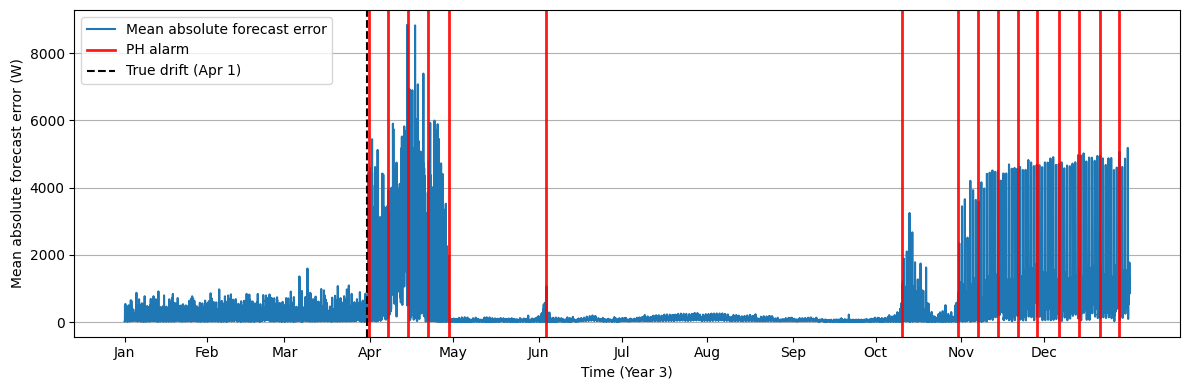

In [97]:
# ===================== Page-Hinkley on GRADUAL Year 3 (best params) =====================

# ----- Constants -----
DRIFT_TS      = 70_848_000   # Apr-1 Year 3
COOLDOWN_DAYS = 7

# ----- BEST PH params (from your tuning on abrupt) -----
PH_CFG = dict(min_instances=30, delta=0.005, threshold=6000.0, alpha=0.9, mode="both")
print("[PH] Using best params:", PH_CFG)

# ----- Helpers (reuse yours; light fallbacks) -----
import numpy as np
import matplotlib.pyplot as plt
import calendar
from river import drift

def _cooldown_steps_from_ts(ts_labels: np.ndarray, days: int):
    if ts_labels.size >= 2 and np.all(np.isfinite(ts_labels)):
        dt_sec = float(np.median(np.diff(ts_labels)))
        steps_per_day = max(1, int(round(24 * 3600 / dt_sec)))
    else:
        dt_sec = 15 * 60.0
        steps_per_day = 96
    return days * steps_per_day, dt_sec

def month_ticks(months_arr):
    starts, labels, seen = [], [], set()
    for i, m in enumerate(months_arr):
        if m not in seen:
            starts.append(i)
            mm = int(m)
            labels.append(calendar.month_abbr[mm] if 1 <= mm <= 12 else str(m))
            seen.add(m)
    return np.array(starts), labels

def ph_run_with_cooldown(e_stream: np.ndarray, cooldown_steps: int, ph_cfg: dict):
    """
    Page-Hinkley with shared cooldown; ALWAYS update so pre-Apr FPs are visible.
    We do NOT reset PH after drifts (same spirit as your earlier PH runs).
    """
    ph = drift.PageHinkley(
        min_instances=int(ph_cfg["min_instances"]),
        delta=float(ph_cfg["delta"]),
        threshold=float(ph_cfg["threshold"]),
        alpha=float(ph_cfg["alpha"]),
        mode=str(ph_cfg["mode"]),
    )
    drift_idx, cooldown = [], 0
    for i, x in enumerate(e_stream):
        ph.update(float(x))
        if cooldown > 0:
            cooldown -= 1
            continue
        if ph.drift_detected:
            drift_idx.append(i)
            cooldown = cooldown_steps
    return drift_idx

# ----- 1) Choose the GRADUAL Year 3 stream -----
if 'blended_df' in globals() and len(blended_df):
    y3_df = blended_df.reset_index(drop=True)
    print("[PH-gradual] Using blended_df for Year 3.")
else:
    y3_df = df_drift[df_drift['year'] == 3].reset_index(drop=True)
    print("[PH-gradual] Using df_drift[year==3] (no blended_df found).")

# Baseline error stream + labels (your helper)
# errors_avg_abs(df_src) -> (e_bar, ts_labels, mo_labels) using baseline_model
e_y3, ts_y3, mo_y3 = errors_avg_abs(y3_df)

# ----- 2) Run PH with 7-day cooldown (count all drifts; pre-Apr are FPs) -----
cooldown_steps, dt_sec = _cooldown_steps_from_ts(ts_y3, COOLDOWN_DAYS)
tau_idx = int(np.searchsorted(ts_y3, DRIFT_TS, side="left"))

drift_idx = ph_run_with_cooldown(e_y3, cooldown_steps, PH_CFG)

# Metrics: total drifts, false positives, detection delay (first post-Apr)
total_drifts = len(drift_idx)
fps = sum(ts_y3[i] < DRIFT_TS for i in drift_idx)
post = [i for i in drift_idx if i >= tau_idx]
delay_hours = ((post[0] - tau_idx) * (dt_sec / 3600.0)) if post else float('inf')

print("\n=== Page-Hinkley on GRADUAL Year 3 (best params) ===")
print(f"Total drifts: {total_drifts}")
print(f"False positives (pre–Apr-1): {fps}")
if np.isfinite(delay_hours):
    print(f"Detection delay (first post–Apr-1): ~{delay_hours:.1f} hours")
else:
    print("Detection delay: ∞ (no drift after Apr-1)")

# ----- 3) Plot ONLY the error with PH drift lines over Year 3 -----
# ----- 3) Plot ONLY the error with PH drift lines over Year 3 (updated naming/labels) -----
idxs = np.arange(len(e_y3))
xt, xl = month_ticks(mo_y3)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(idxs, e_y3, label="Mean absolute forecast error")

# Add both legend entries once: gray=FP alarms (pre Apr-1), red=drift alarms (post Apr-1)
shown_fp = False
shown_drift = False

for i in drift_idx:
    is_post = (ts_y3[i] >= DRIFT_TS)          # post Apr-1 => drift alarm
    color = "red" if is_post else "tab:gray"  # pre Apr-1 => false positive alarm

    if is_post and (not shown_drift):
        lab = "PH alarm"
        shown_drift = True
    elif (not is_post) and (not shown_fp):
        lab = "False positive alarm"
        shown_fp = True
    else:
        lab = "_nolegend_"  # labels starting with "_" are ignored by legend() [web:1039]

    ax.axvline(i, color=color, linestyle="-", linewidth=2.0, alpha=0.9, label=lab)

ax.axvline(tau_idx, color="black", linestyle="--", linewidth=1.5, label="True drift (Apr 1)")
ax.set_xticks(xt)
ax.set_xticklabels(xl)
ax.set_xlabel("Time (Year 3)")
ax.set_ylabel("Mean absolute forecast error (W)")
ax.set_title("")
ax.grid(True, axis="y")
ax.legend()
out_path = "/kaggle/working/GradualYear3PH.pdf"
fig.savefig(out_path, format="pdf", bbox_inches="tight")  # save before show
fig.tight_layout()
plt.show()



In [ ]:
# # ================== Dataset choice: GRADUAL Year 3 ==================
# # Prefer your gradual-blended Year 3 if present; else fall back to original drifted Y3
# if 'blended_df' in globals() and len(blended_df):
#     y3_df = blended_df.reset_index(drop=True)
#     print("[PH-gradual] Using blended_df for Year 3.")
# elif 'y3_gradual_df' in globals() and len(y3_gradual_df):
#     y3_df = y3_gradual_df.reset_index(drop=True)
#     print("[PH-gradual] Using y3_gradual_df for Year 3.")
# else:
#     y3_df = df_drift[df_drift['year'] == 3].reset_index(drop=True)
#     print("[PH-gradual] Using df_drift[year==3] (no gradual-blended source found).")

# # ===================== Configs (MAE) =====================
# PRETRAIN_LR   = 0.0007509794596043137
# FT_LR         = PRETRAIN_LR / 10.0       # fine-tune LR = 1/10 pretrain LR
# FT_DAYS       = 7
# FT_EPOCHS     = 5
# FT_BATCH      = 41
# FT_PATIENCE   = 2
# ROLL_DAYS     = 1
# COOLDOWN_DAYS = 7
# ONLY_AFTER_TS = 70_848_000               # Apr-1 Year 3 (seconds)
# H             = HORIZON

# # Best PH params (use your best values)
# PH_CFG = dict(min_instances=30, delta=0.005, threshold=6000.0, alpha=0.9, mode="both", cooldown_days=7)
# print("Using PH best params for adaptation:", PH_CFG)

# # ===================== Helpers =====================
# import numpy as np, pandas as pd, matplotlib.pyplot as plt, calendar
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# from river import drift

# def _label_rows(n_full, lookback, horizon):
#     return (np.arange(lookback, n_full - horizon + 1) + (horizon - 1))

# def _build_year_windows(df_year: pd.DataFrame):
#     X = df_year[FEATS].to_numpy(float)
#     Xs = X_scaler.transform(X)
#     ys = Xs[:, idx_t].copy()
#     Xw, Yw = make_windows_multi(Xs, ys, LOOKBACK, H, stride=1)
#     n_full = len(df_year)
#     lbl_idx = _label_rows(n_full, LOOKBACK, H)
#     ts_lab  = df_year.iloc[lbl_idx]['timestamp_sec'].to_numpy()
#     mo_lab  = df_year.iloc[lbl_idx]['month'].to_numpy()
#     return Xw, Yw, ts_lab, mo_lab, lbl_idx

# def _predict_unscaled(model, Xw, Yw):
#     Y_hat_s = model.predict(Xw, verbose=0)
#     Y_true  = inv_steps_from_X_scaler(Yw,      X_scaler, idx_t, H)
#     Y_hat   = inv_steps_from_X_scaler(Y_hat_s, X_scaler, idx_t, H)
#     return Y_true, Y_hat

# def _window_mae(y_true_row, y_hat_row):
#     return float(np.mean(np.abs(y_true_row - y_hat_row)))

# def _window_rmse(y_true_row, y_hat_row):
#     return float(np.sqrt(np.mean((y_true_row - y_hat_row)**2)))

# def _window_smape(y_true_row, y_hat_row, eps=1e-6):
#     num = np.abs(y_true_row - y_hat_row)
#     den = (np.abs(y_true_row) + np.abs(y_hat_row)).clip(min=eps)
#     return float(np.mean(2.0 * num / den) * 100.0)  # %

# def _rolling_mean(values, k):
#     if k <= 1:
#         return values.astype(float)
#     out = np.full(len(values), np.nan, float)
#     if len(values) >= k:
#         csum = np.cumsum(values, dtype=float)
#         out[k-1:] = (csum[k-1:] - np.concatenate(([0.0], csum[:-k])))/k
#     return out

# def _steps_per_day_from_labels(ts_labels):
#     if ts_labels.size >= 2 and np.isfinite(ts_labels).all():
#         dt_sec = float(np.median(np.diff(ts_labels)))
#     else:
#         dt_sec = 15*60
#     return max(1, int(round((24*3600)/dt_sec))), dt_sec

# def _month_ticks(months_arr):
#     starts, labels, seen = [], [], set()
#     for i, m in enumerate(months_arr):
#         if m not in seen:
#             starts.append(i)
#             mm = int(m)
#             labels.append(calendar.month_abbr[mm] if 1 <= mm <= 12 else str(m))
#             seen.add(m)
#     return np.array(starts), labels

# def _recovery_speed_indices(base_roll, adapt_roll, drift_indices, consec):
#     """Earliest r>=d for each drift d s.t. adapted<=baseline for 'consec' consecutive windows."""
#     recov, N = [], len(base_roll)
#     for d in drift_indices:
#         r, i, cnt = None, max(0, d), 0
#         while i < N:
#             a, b = adapt_roll[i], base_roll[i]
#             if np.isfinite(a) and np.isfinite(b) and (a <= b):
#                 cnt += 1
#                 if cnt >= consec:
#                     r = i - consec + 1
#                     break
#             else:
#                 cnt = 0
#             i += 1
#         recov.append(r)
#     return recov

# def _per_horizon_smape(y_true_2d, y_hat_2d, eps=1e-6):
#     vals = []
#     for h in range(y_true_2d.shape[1]):
#         num = np.abs(y_true_2d[:, h] - y_hat_2d[:, h])
#         den = (np.abs(y_true_2d[:, h]) + np.abs(y_hat_2d[:, h])).clip(min=eps)
#         vals.append(float(np.mean(2.0 * num / den) * 100.0))
#     return vals

# # ===================== 1) Build Year-3 windows & baseline streams =====================
# X3_win, Y3_win, ts3_lab, mo3_lab, _ = _build_year_windows(y3_df)
# steps_per_day, dt_sec = _steps_per_day_from_labels(ts3_lab)
# roll_steps     = ROLL_DAYS * steps_per_day
# ft_steps       = FT_DAYS   * steps_per_day
# cooldown_steps = COOLDOWN_DAYS * steps_per_day
# tau_idx        = int(np.searchsorted(ts3_lab, ONLY_AFTER_TS, side="left"))

# # Baseline predictions ONCE (used for detector + for "pre-adaptation identical" streaming)
# Y3_true_base, Y3_hat_base = _predict_unscaled(baseline_model, X3_win, Y3_win)
# mae3_base_win   = np.array([_window_mae (Y3_true_base[i], Y3_hat_base[i]) for i in range(len(X3_win))], float)
# rmse3_base_win  = np.array([_window_rmse(Y3_true_base[i], Y3_hat_base[i]) for i in range(len(X3_win))], float)
# smape3_base_win = np.array([_window_smape(Y3_true_base[i], Y3_hat_base[i]) for i in range(len(X3_win))], float)
# mae3_base_roll  = _rolling_mean(mae3_base_win, roll_steps)

# # ===================== 2) Init Page–Hinkley (always update from start) =====================
# ph = drift.PageHinkley(
#     min_instances=int(PH_CFG["min_instances"]),
#     delta=float(PH_CFG["delta"]),
#     threshold=float(PH_CFG["threshold"]),
#     alpha=float(PH_CFG["alpha"]),
#     mode=str(PH_CFG["mode"])
# )

# # ===================== 3) Build/RESET adaptive model for GRADUAL run =====================
# # IMPORTANT: Always reset to baseline weights so "pre-drift errors are identical"
# pagehinkley_model_gradual = tf.keras.models.clone_model(baseline_model)
# _ = pagehinkley_model_gradual.predict(X3_win[:1], verbose=0)  # build
# pagehinkley_model_gradual.set_weights(baseline_model.get_weights())

# # Compile for FT (safe loss fallback)
# loss_to_use = getattr(baseline_model, "loss", None) or getattr(pagehinkley_model_gradual, "loss", None) or "mse"
# metrics_to_use = []
# try:
#     metrics_to_use = [m for m in baseline_model.metrics if getattr(m, "name", "") != "loss"]
# except Exception:
#     metrics_to_use = []

# pagehinkley_model_gradual.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=FT_LR, clipnorm=1.0),
#     loss=loss_to_use,
#     metrics=metrics_to_use
# )

# # ===================== 4) ONLINE PH adaptation (GRADUAL) =====================
# # Key change: "ONLINE rolling MAE" AND "pre-adaptation errors identical"
# # We do this by using baseline predictions until the FIRST fine-tune happens.
# adapt_started  = False

# ph_all_drifts  = []   # counted with 7d cooldown (pre+post Apr)
# ph_adapt_hits  = []   # drifts we actually fine-tune on (post Apr & not in cooldown)
# last_alarm_idx = -10**12
# adapt_cooldown = 0

# # Streaming collections (these define the ONLINE curves/tables)
# Y3_true_stream = []
# Y3_hat_stream  = []
# mae_adapt_win  = []
# rmse_adapt_win = []
# smape_adapt_win= []

# for i in range(len(X3_win)):

#     # ---- (A) ONLINE prediction stream ----
#     # Before the first fine-tune, FORCE the "adaptive" stream to equal baseline exactly.
#     if not adapt_started:
#         y_true_r = Y3_true_base[i]
#         y_hat_r  = Y3_hat_base[i]
#     else:
#         yhat_s   = pagehinkley_model_gradual.predict(X3_win[i:i+1], verbose=0)[0]
#         y_true_r = inv_steps_from_X_scaler(Y3_win[i:i+1], X_scaler, idx_t, H)[0]
#         y_hat_r  = inv_steps_from_X_scaler(yhat_s.reshape(1, -1), X_scaler, idx_t, H)[0]

#     Y3_true_stream.append(y_true_r)
#     Y3_hat_stream.append(y_hat_r)

#     mae_adapt_win.append (_window_mae (y_true_r, y_hat_r))
#     rmse_adapt_win.append(_window_rmse(y_true_r, y_hat_r))
#     smape_adapt_win.append(_window_smape(y_true_r, y_hat_r))

#     # ---- (B) Detector update (ALWAYS; uses baseline MAE stream) ----
#     ph.update(float(mae3_base_win[i]))

#     # ---- (C) Drift counting with shared cooldown ----
#     if ph.drift_detected and (i - last_alarm_idx) >= cooldown_steps:
#         ph_all_drifts.append(i)
#         last_alarm_idx = i

#         # ---- (D) Adaptation gate ----
#         # Adapt only after Apr-1 and if not in adaptation cooldown
#         if ts3_lab[i] >= ONLY_AFTER_TS and adapt_cooldown == 0:
#             ph_adapt_hits.append(i)

#             # Fine-tune on previous FT_DAYS windows ending at i
#             s   = max(0, i - ft_steps + 1)
#             Xft = X3_win[s:i+1]
#             Yft = Y3_win[s:i+1]
#             if len(Xft) >= 10:
#                 es = tf.keras.callbacks.EarlyStopping(
#                     monitor="val_loss", patience=FT_PATIENCE, restore_best_weights=True
#                 )
#                 pagehinkley_model_gradual.fit(
#                     Xft, Yft,
#                     validation_split=0.1,
#                     epochs=FT_EPOCHS,
#                     batch_size=FT_BATCH,
#                     shuffle=True,
#                     verbose=0,
#                     callbacks=[es]
#                 )

#             adapt_started  = True
#             adapt_cooldown = cooldown_steps

#     if adapt_cooldown > 0:
#         adapt_cooldown -= 1

# # ===================== 5) ONLINE rolling MAE curves =====================
# mae_adapt_win  = np.asarray(mae_adapt_win, float)
# mae_adapt_roll = _rolling_mean(mae_adapt_win, roll_steps)

# # ===================== 6) Drift stats (counts, FP, delay + per-drift delays) =====================
# fp_count   = sum(ts3_lab[idx] < ONLY_AFTER_TS for idx in ph_all_drifts)
# post_hits  = [i for i in ph_all_drifts if i >= tau_idx]
# first_post = post_hits[0] if len(post_hits) else None
# delay_h    = ((first_post - tau_idx) * (dt_sec / 3600.0)) if first_post is not None else float('inf')

# summary_table = pd.DataFrame([{
#     "count_all_drifts":      len(ph_all_drifts),
#     "false_positives":       fp_count,
#     "adapt_drift_hits":      len(ph_adapt_hits),
#     "first_post_drift_idx":  (first_post if first_post is not None else -1),
#     "detection_delay_hours": (delay_h if np.isfinite(delay_h) else None)
# }])
# print("\n=== PH drift summary (Year 3, gradual) ===")
# display(summary_table)

# drift_events = []
# for di in ph_all_drifts:
#     drift_events.append({
#         "drift_idx": di,
#         "post_Apr1": bool(ts3_lab[di] >= ONLY_AFTER_TS),
#         "delay_hours_from_Apr1": (ts3_lab[di] - ONLY_AFTER_TS) / 3600.0
#     })
# drift_events_df = pd.DataFrame(drift_events)
# print("\n=== PH drift events (per-drift delays from Apr-1) ===")
# display(drift_events_df)

# # ===================== 7) Recovery speed (MAE rolling; checkpoints = adapt hits) =====================
# consec = roll_steps
# recovery_idx = _recovery_speed_indices(mae3_base_roll, mae_adapt_roll, ph_adapt_hits, consec)

# recovery_rows = []
# for d, r in zip(ph_adapt_hits, recovery_idx):
#     if r is None:
#         recovery_rows.append({"drift_idx": d, "recovered": False, "t_rec_idx": np.nan,
#                               "recovery_hours": np.nan, "recovery_days": np.nan})
#     else:
#         hours = (r - d) * (dt_sec / 3600.0)
#         recovery_rows.append({"drift_idx": d, "recovered": True, "t_rec_idx": r,
#                               "recovery_hours": hours, "recovery_days": hours / 24.0})
# recovery_table = pd.DataFrame(recovery_rows)
# print("\n=== Year 3 (gradual) — Recovery speed (rolling MAE) ===")
# display(recovery_table)

# # ===================== 8) Tables: Year-3 metrics (MAE, RMSE, sMAPE, WAPE) =====================
# Y3_true_stream = np.asarray(Y3_true_stream)  # (N, H)
# Y3_hat_stream  = np.asarray(Y3_hat_stream)   # (N, H)
# Hh = Y3_true_stream.shape[1]

# mae_base_h   = [mean_absolute_error(Y3_true_base[:,h], Y3_hat_base[:,h]) for h in range(Hh)]
# mae_adapt_h  = [mean_absolute_error(Y3_true_stream[:,h], Y3_hat_stream[:,h]) for h in range(Hh)]
# rmse_base_h  = [mean_squared_error(Y3_true_base[:,h], Y3_hat_base[:,h], squared=False) for h in range(Hh)]
# rmse_adapt_h = [mean_squared_error(Y3_true_stream[:,h], Y3_hat_stream[:,h], squared=False) for h in range(Hh)]
# smape_base_h = _per_horizon_smape(Y3_true_base, Y3_hat_base)
# smape_adapt_h= _per_horizon_smape(Y3_true_stream, Y3_hat_stream)

# per_horizon_tbl = pd.DataFrame({
#     "horizon": [f"t+{i+1}" for i in range(Hh)],
#     "MAE_base":  mae_base_h,   "MAE_adapt":  mae_adapt_h,
#     "RMSE_base": rmse_base_h,  "RMSE_adapt": rmse_adapt_h,
#     "sMAPE%_base": smape_base_h, "sMAPE%_adapt": smape_adapt_h
# })

# wape_base  = (np.sum(np.abs(Y3_true_base   - Y3_hat_base))   / max(np.sum(np.abs(Y3_true_base)),   1e-12)) * 100.0
# wape_adapt = (np.sum(np.abs(Y3_true_stream - Y3_hat_stream)) / max(np.sum(np.abs(Y3_true_stream)), 1e-12)) * 100.0

# aggregate_tbl = pd.DataFrame({
#     "MAE_mean":    [float(np.mean(mae3_base_win)),     float(np.mean(mae_adapt_win))],
#     "RMSE_mean":   [float(np.mean(rmse3_base_win)),    float(np.mean(rmse_adapt_win))],
#     "sMAPE_mean%": [float(np.mean(smape3_base_win)),   float(np.mean(smape_adapt_win))],
#     "WAPE%":       [float(wape_base),                  float(wape_adapt)]
# }, index=["Baseline", "PH-Adaptive (gradual, online)"])

# print("\n=== Year 3 (gradual) — Per-horizon metrics (MAE, RMSE, sMAPE%) ===")
# display(per_horizon_tbl)

# print("\n=== Year 3 (gradual) — Aggregate metrics (means over streaming windows) ===")
# display(aggregate_tbl)

# # ===================== 9) Rolling MAE plot (ONLINE; show finetune moments) =====================
# xticks, xlabels = _month_ticks(mo3_lab)

# plt.figure(figsize=(12,4))
# plt.plot(mae3_base_roll,  label=f"Baseline rolling MAE ({ROLL_DAYS}d)")
# plt.plot(mae_adapt_roll,  label=f"PH-adaptive rolling MAE ({ROLL_DAYS}d)")

# # counted drifts (pre/post Apr) in gray/red
# for k, di in enumerate(ph_all_drifts):
#     color = "red" if ts3_lab[di] >= ONLY_AFTER_TS else "tab:gray"
#     lab = "PH drift (counted)" if k == 0 else None
#     plt.axvline(di, color=color, linestyle="-", linewidth=1.2, alpha=0.75, label=lab)

# # fine-tune moments (subset) thicker line
# for k, di in enumerate(ph_adapt_hits):
#     plt.axvline(di, color="black", linestyle=":", linewidth=2.0, alpha=0.9,
#                 label="Fine-tune (applied)" if k == 0 else None)

# plt.axvline(tau_idx, color="black", linestyle="--", linewidth=1.2, label="Apr-1 (ground truth)")
# plt.xticks(xticks, xlabels)
# plt.xlabel("Month (Year 3)")
# plt.ylabel("Rolling MAE")
# plt.title("Year 3 (gradual) — Page–Hinkley ONLINE adaptation: rolling MAE (shows each fine-tune)")
# plt.grid(True, axis='y')
# plt.legend()
# plt.tight_layout()
# plt.show()


In [98]:
import calendar
from collections import deque

[PH-gradual] Using blended_df for Year 3.
Using PH best params for adaptation: {'min_instances': 30, 'delta': 0.005, 'threshold': 6000.0, 'alpha': 0.9, 'mode': 'both', 'cooldown_days': 7}
=== Year 3 (gradual) — Recovery speed (rolling MAE) ===


drift_idx  recovered  t_rec_idx  recovery_hours  recovery_days
0        8475       True       8491             4.0            0.2
1        9169       True       9169             0.0            0.0
2        9864       True       9864             0.0            0.0
3       10553       True      24316         3,440.8          143.4
4       11271       True      24316         3,261.2          135.9
5       14658       True      24316         2,414.5          100.6
6       27029       True      27029             0.0            0.0
7       28963       True      28963             0.0            0.0
8       29662       True      29662             0.0            0.0
9       30348       True      30348             0.0            0.0
10      31020       True      31020             0.0            0.0
11      31693       True      31693             0.0            0.0
12      32394       True      32394             0.0            0.0
13      33066       True      33066             0.0            0.0
14      33739       True      33739             0.0            0.0
15      34476       True      34476             0.0            0.0


=== Year 3 (gradual) — Per-horizon metrics (MAE, RMSE, sMAPE%) ===


horizon  MAE_base  MAE_adapt  RMSE_base  RMSE_adapt  sMAPE%_base  \
0     t+1     325.9      306.8    1,007.6       687.4        129.6   
1     t+2     335.7      312.2      914.4       692.9        130.6   
2     t+3     376.2      320.7      990.3       719.8        131.4   
3     t+4     394.7      321.6      957.9       709.9        132.1   

   sMAPE%_adapt  MAPE%_base  MAPE%_adapt  
0         126.9     9,936.3     18,122.9  
1         127.1    10,811.7     17,802.3  
2         127.5    12,301.5     17,032.3  
3         127.7    12,477.5     15,982.9


=== Year 3 (gradual) — Aggregate metrics (means over streaming windows) ===


MAE_mean  RMSE_mean  sMAPE_mean%  MAPE_mean%  WAPE%
Baseline                  358.1      416.1        130.9    11,381.7   22.0
PH-Adaptive (gradual)     315.3      347.1        127.3    17,235.1   19.4


=== Year 3 (gradual) — Global metrics (flattened over all windows x horizons) ===


MAE_global  RMSE_global  sMAPE_global%  MAPE_global%  \
Baseline                    358.1        968.2          130.9      11,381.7   
PH-Adaptive (gradual)       315.3        702.6          127.3      17,235.1   

                       WAPE_global%  
Baseline                       22.0  
PH-Adaptive (gradual)          19.4


=== PH drift summary (Year 3, gradual) ===


count_all_drifts  false_positives  adapt_drift_hits  first_post_drift_idx  \
0                16                0                16                  8475   

   detection_delay_hours  
0                   10.0

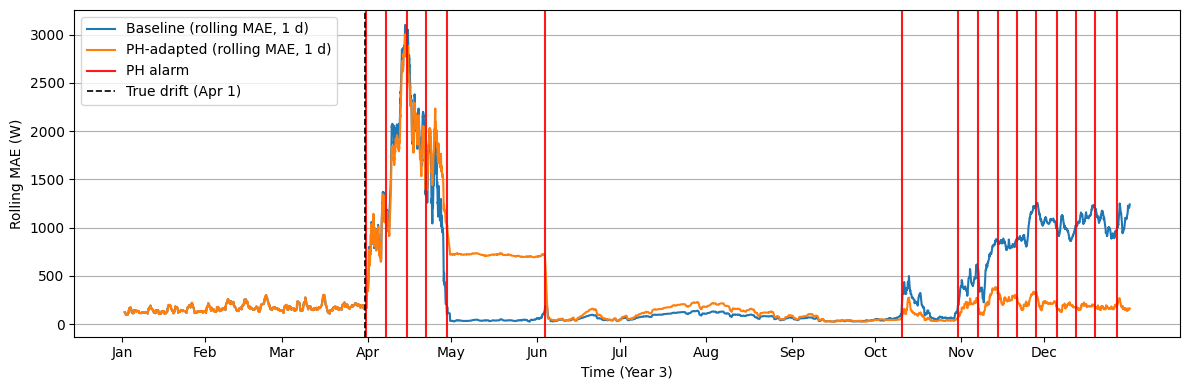

In [99]:
# ================== Dataset choice: GRADUAL Year 3 ==================
# Prefer your gradual-blended Year 3 if present; else fall back to original drifted Y3
if 'blended_df' in globals() and len(blended_df):
    y3_df = blended_df.reset_index(drop=True)
    print("[PH-gradual] Using blended_df for Year 3.")
elif 'y3_gradual_df' in globals() and len(y3_gradual_df):
    y3_df = y3_gradual_df.reset_index(drop=True)
    print("[PH-gradual] Using y3_gradual_df for Year 3.")
else:
    y3_df = df_drift[df_drift['year'] == 3].reset_index(drop=True)
    print("[PH-gradual] Using df_drift[year==3] (no gradual-blended source found).")

# ===================== Configs (MAE) =====================
PRETRAIN_LR   = 0.0007509794596043137
FT_LR         = PRETRAIN_LR / 10.0       # fine-tune LR = 1/10 pretrain LR
FT_DAYS       = 7
FT_EPOCHS     = 5
FT_BATCH      = 41
FT_PATIENCE   = 2
ROLL_DAYS     = 1
COOLDOWN_DAYS = 7
ONLY_AFTER_TS = 70_848_000               # Apr-1 Year 3 (seconds)
H             = HORIZON

# Best PH params you reported (reuse for gradual dataset)
PH_CFG = dict(min_instances=30, delta=0.005, threshold=6000.0, alpha=0.9, mode="both", cooldown_days=7)
print("Using PH best params for adaptation:", PH_CFG)

# ===================== Helpers =====================

def _label_rows(n_full, lookback, horizon):
    return (np.arange(lookback, n_full - horizon + 1) + (horizon - 1))

def _build_year_windows(df_year: pd.DataFrame):
    X = df_year[FEATS].to_numpy(float)
    Xs = X_scaler.transform(X)
    ys = Xs[:, idx_t].copy()
    Xw, Yw = make_windows_multi(Xs, ys, LOOKBACK, H, stride=1)
    n_full = len(df_year)
    lbl_idx = _label_rows(n_full, LOOKBACK, H)
    ts_lab  = df_year.iloc[lbl_idx]['timestamp_sec'].to_numpy()
    mo_lab  = df_year.iloc[lbl_idx]['month'].to_numpy()
    return Xw, Yw, ts_lab, mo_lab, lbl_idx

def _predict_unscaled(model, Xw, Yw):
    Y_hat_s = model.predict(Xw, verbose=0)
    Y_true  = inv_steps_from_X_scaler(Yw,     X_scaler, idx_t, H)
    Y_hat   = inv_steps_from_X_scaler(Y_hat_s, X_scaler, idx_t, H)
    return Y_true, Y_hat

def _window_mae(y_true_row, y_hat_row):
    return float(np.mean(np.abs(y_true_row - y_hat_row)))

def _window_rmse(y_true_row, y_hat_row):
    return float(np.sqrt(np.mean((y_true_row - y_hat_row)**2)))

def _window_smape(y_true_row, y_hat_row, eps=1e-6):
    num = np.abs(y_true_row - y_hat_row)
    den = (np.abs(y_true_row) + np.abs(y_hat_row)).clip(min=eps)
    return float(np.mean(2.0 * num / den) * 100.0)  # %

# -------------------- FIXED: MAPE helper (eps floor = 1.0 in target units) --------------------
def _window_mape(y_true_row, y_hat_row, eps=1.0):
    den = np.maximum(np.abs(y_true_row), eps)
    return float(np.mean(np.abs((y_true_row - y_hat_row) / den)) * 100.0)  # %
# ---------------------------------------------------------------------------------------------

def _rolling_mean(values, k):
    if k <= 1:
        return values.astype(float)
    out = np.full(len(values), np.nan, float)
    if len(values) >= k:
        csum = np.cumsum(values, dtype=float)
        out[k-1:] = (csum[k-1:] - np.concatenate(([0.0], csum[:-k])))/k
    return out

def _steps_per_day_from_labels(ts_labels):
    if ts_labels.size >= 2 and np.isfinite(ts_labels).all():
        dt_sec = float(np.median(np.diff(ts_labels)))
    else:
        dt_sec = 15*60
    return max(1, int(round((24*3600)/dt_sec))), dt_sec

def _month_ticks(months_arr):
    starts, labels, seen = [], [], set()
    for i, m in enumerate(months_arr):
        if m not in seen:
            starts.append(i)
            mm = int(m)
            labels.append(calendar.month_abbr[mm] if 1 <= mm <= 12 else str(m))
            seen.add(m)
    return np.array(starts), labels

def _recovery_speed_indices(base_roll, adapt_roll, drift_indices, consec):
    """Earliest r>=d for each drift d s.t. adapted<=baseline for 'consec' consecutive windows."""
    recov = []
    N = len(base_roll)
    for d in drift_indices:
        r, i, cnt = None, max(0, d), 0
        while i < N:
            a, b = adapt_roll[i], base_roll[i]
            if np.isfinite(a) and np.isfinite(b) and (a <= b):
                cnt += 1
                if cnt >= consec:
                    r = i - consec + 1
                    break
            else:
                cnt = 0
            i += 1
        recov.append(r)
    return recov

def _per_horizon_smape(y_true_2d, y_hat_2d, eps=1e-6):
    vals = []
    for h in range(y_true_2d.shape[1]):
        num = np.abs(y_true_2d[:, h] - y_hat_2d[:, h])
        den = (np.abs(y_true_2d[:, h]) + np.abs(y_hat_2d[:, h])).clip(min=eps)
        vals.append(float(np.mean(2.0 * num / den) * 100.0))
    return vals

# -------------------- FIXED: per-horizon MAPE (eps floor = 1.0 in target units) --------------------
def _per_horizon_mape(y_true_2d, y_hat_2d, eps=1.0):
    vals = []
    for h in range(y_true_2d.shape[1]):
        den = np.maximum(np.abs(y_true_2d[:, h]), eps)
        vals.append(float(np.mean(np.abs((y_true_2d[:, h] - y_hat_2d[:, h]) / den)) * 100.0))
    return vals
# ----------------------------------------------------------------------------------------------------

# ===================== 1) Build Year-3 windows & baseline streams =====================
X3_win, Y3_win, ts3_lab, mo3_lab, _ = _build_year_windows(y3_df)
steps_per_day, dt_sec = _steps_per_day_from_labels(ts3_lab)
roll_steps     = ROLL_DAYS * steps_per_day
ft_steps       = FT_DAYS * steps_per_day
cooldown_steps = COOLDOWN_DAYS * steps_per_day
tau_idx        = int(np.searchsorted(ts3_lab, ONLY_AFTER_TS, side="left"))

# Baseline predictions for Year 3 (detector input & baseline metrics)
Y3_true_base, Y3_hat_base = _predict_unscaled(baseline_model, X3_win, Y3_win)
mae3_base_win   = np.array([_window_mae (Y3_true_base[i], Y3_hat_base[i]) for i in range(len(X3_win))], float)
rmse3_base_win  = np.array([_window_rmse(Y3_true_base[i], Y3_hat_base[i]) for i in range(len(X3_win))], float)
smape3_base_win = np.array([_window_smape(Y3_true_base[i], Y3_hat_base[i]) for i in range(len(X3_win))], float)

# -------------------- baseline per-window MAPE --------------------
mape3_base_win  = np.array([_window_mape(Y3_true_base[i], Y3_hat_base[i]) for i in range(len(X3_win))], float)
# ---------------------------------------------------------------

# Baseline rolling MAE (causal rolling; fine to compute offline)
mae3_base_roll = _rolling_mean(mae3_base_win, roll_steps)

# ===================== 2) Init Page–Hinkley (always update from start) =====================
ph = drift.PageHinkley(
    min_instances=int(PH_CFG["min_instances"]),
    delta=float(PH_CFG["delta"]),
    threshold=float(PH_CFG["threshold"]),
    alpha=float(PH_CFG["alpha"]),
    mode=str(PH_CFG["mode"])
)

# ===================== 3) IMPORTANT: Always start from baseline weights (fresh run) =====================
# This guarantees pre-drift adaptive curve matches baseline until fine-tuning starts.
pagehinkley_model_gradual = tf.keras.models.clone_model(baseline_model)
_ = pagehinkley_model_gradual(baseline_model.inputs, training=False)   # build vars
pagehinkley_model_gradual.set_weights(baseline_model.get_weights())

pagehinkley_model_gradual.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FT_LR, clipnorm=1.0),
    loss=baseline_model.loss if getattr(baseline_model, "loss", None) is not None else pagehinkley_model_gradual.loss,
    metrics=[m for m in (baseline_model.metrics if hasattr(baseline_model, "metrics") else pagehinkley_model_gradual.metrics)
             if getattr(m, "name", "") != "loss"]
)

# ===================== 4) Online PH adaptation (ONLINE rolling MAE) =====================
# Drift bookkeeping
ph_all_drifts   = []   # counted with 7d cooldown (includes pre-Apr for FP accounting)
ph_adapt_hits   = []   # subset we fine-tune on (post-Apr + not in adaptation cooldown)
last_alarm_idx  = -10**12
adapt_cooldown  = 0

# Streaming collections (errors + preds for tables)
mae_adapt_win, rmse_adapt_win, smape_adapt_win = [], [], []
mape_adapt_win = []
Y3_true_stream, Y3_hat_stream = [], []

# ONLINE rolling MAE state (so the plot reflects model changes as they happen)
buf = deque(maxlen=int(roll_steps))
roll_sum = 0.0
mae_adapt_roll_online = []

for i in range(len(X3_win)):
    # ---- Online predict with current adapted model ----
    yhat_s   = pagehinkley_model_gradual.predict(X3_win[i:i+1], verbose=0)[0]
    y_true_r = inv_steps_from_X_scaler(Y3_win[i:i+1], X_scaler, idx_t, H)[0]
    y_hat_r  = inv_steps_from_X_scaler(yhat_s.reshape(1, -1), X_scaler, idx_t, H)[0]

    Y3_true_stream.append(y_true_r)
    Y3_hat_stream.append(y_hat_r)

    e_mae = _window_mae(y_true_r, y_hat_r)
    mae_adapt_win.append(e_mae)
    rmse_adapt_win.append(_window_rmse(y_true_r, y_hat_r))
    smape_adapt_win.append(_window_smape(y_true_r, y_hat_r))
    mape_adapt_win.append(_window_mape(y_true_r, y_hat_r))

    # ---- ONLINE rolling update (causal) ----
    if buf.maxlen <= 1:
        mae_adapt_roll_online.append(float(e_mae))
    else:
        if len(buf) == buf.maxlen:
            roll_sum -= buf[0]
        buf.append(e_mae)
        roll_sum += e_mae
        mae_adapt_roll_online.append((roll_sum / buf.maxlen) if len(buf) == buf.maxlen else np.nan)

    # ---- Always update PH on baseline error stream ----
    ph.update(float(mae3_base_win[i]))

    # ---- Count alarms with 7d cooldown ----
    if ph.drift_detected and (i - last_alarm_idx) >= cooldown_steps:
        ph_all_drifts.append(i)
        last_alarm_idx = i

        # ---- Adapt only after Apr-1 and if not in adaptation cooldown ----
        if ts3_lab[i] >= ONLY_AFTER_TS and adapt_cooldown == 0:
            ph_adapt_hits.append(i)

            s   = max(0, i - ft_steps + 1)
            Xft = X3_win[s:i+1]
            Yft = Y3_win[s:i+1]
            if len(Xft) >= 10:
                es = tf.keras.callbacks.EarlyStopping(
                    monitor="val_loss", patience=FT_PATIENCE, restore_best_weights=True
                )
                pagehinkley_model_gradual.fit(
                    Xft, Yft,
                    validation_split=0.1,
                    epochs=FT_EPOCHS,
                    batch_size=FT_BATCH,
                    shuffle=True,
                    verbose=0,
                    callbacks=[es]
                )
            adapt_cooldown = cooldown_steps

    if adapt_cooldown > 0:
        adapt_cooldown -= 1

# Final adaptive rolling series is the ONLINE one:
mae_adapt_roll = np.asarray(mae_adapt_roll_online, float)

# ===================== 5) Recovery speed (MAE rolling) =====================
consec = int(roll_steps)  # ~1 day
recovery_idx = _recovery_speed_indices(mae3_base_roll, mae_adapt_roll, ph_adapt_hits, consec)

recovery_rows = []
for d, r in zip(ph_adapt_hits, recovery_idx):
    if r is None:
        recovery_rows.append({"drift_idx": d, "recovered": False, "t_rec_idx": np.nan,
                              "recovery_hours": np.nan, "recovery_days": np.nan})
    else:
        hours = (r - d) * (dt_sec / 3600.0)
        recovery_rows.append({"drift_idx": d, "recovered": True, "t_rec_idx": r,
                              "recovery_hours": hours, "recovery_days": hours / 24.0})
recovery_table = pd.DataFrame(recovery_rows)

# ===================== 6) Tables: Year-3 metrics (MAE, RMSE, sMAPE, WAPE) =====================
Y3_true_stream = np.asarray(Y3_true_stream)  # (N, H)
Y3_hat_stream  = np.asarray(Y3_hat_stream)   # (N, H)
Hh = Y3_true_stream.shape[1]

mae_base_h   = [mean_absolute_error(Y3_true_base[:,h], Y3_hat_base[:,h]) for h in range(Hh)]
mae_adapt_h  = [mean_absolute_error(Y3_true_stream[:,h], Y3_hat_stream[:,h]) for h in range(Hh)]
rmse_base_h  = [mean_squared_error(Y3_true_base[:,h], Y3_hat_base[:,h], squared=False) for h in range(Hh)]
rmse_adapt_h = [mean_squared_error(Y3_true_stream[:,h], Y3_hat_stream[:,h], squared=False) for h in range(Hh)]
smape_base_h  = _per_horizon_smape(Y3_true_base,  Y3_hat_base)
smape_adapt_h = _per_horizon_smape(Y3_true_stream, Y3_hat_stream)

mape_base_h  = _per_horizon_mape(Y3_true_base,  Y3_hat_base)
mape_adapt_h = _per_horizon_mape(Y3_true_stream, Y3_hat_stream)

per_horizon_tbl = pd.DataFrame({
    "horizon":      [f"t+{i+1}" for i in range(Hh)],
    "MAE_base":      mae_base_h,   "MAE_adapt":      mae_adapt_h,
    "RMSE_base":     rmse_base_h,  "RMSE_adapt":     rmse_adapt_h,
    "sMAPE%_base":   smape_base_h, "sMAPE%_adapt":   smape_adapt_h,
    "MAPE%_base":    mape_base_h,  "MAPE%_adapt":    mape_adapt_h
})

wape_base  = (np.sum(np.abs(Y3_true_base   - Y3_hat_base))   / max(np.sum(np.abs(Y3_true_base)),   1e-12)) * 100.0
wape_adapt = (np.sum(np.abs(Y3_true_stream - Y3_hat_stream)) / max(np.sum(np.abs(Y3_true_stream)), 1e-12)) * 100.0

aggregate_tbl = pd.DataFrame({
    "MAE_mean":     [float(np.mean(mae3_base_win)),   float(np.mean(mae_adapt_win))],
    "RMSE_mean":    [float(np.mean(rmse3_base_win)),  float(np.mean(rmse_adapt_win))],
    "sMAPE_mean%":  [float(np.mean(smape3_base_win)), float(np.mean(smape_adapt_win))],
    "MAPE_mean%":   [float(np.mean(mape3_base_win)),  float(np.mean(mape_adapt_win))],
    "WAPE%":        [float(wape_base), float(wape_adapt)]
}, index=["Baseline", "PH-Adaptive (gradual)"])

print("=== Year 3 (gradual) — Recovery speed (rolling MAE) ===")
display(recovery_table)

print("\n=== Year 3 (gradual) — Per-horizon metrics (MAE, RMSE, sMAPE%) ===")
display(per_horizon_tbl)

print("\n=== Year 3 (gradual) — Aggregate metrics (means over streaming windows) ===")
display(aggregate_tbl)

# -------------------- Global metrics (flattened over all windows x horizons) --------------------
_eps_g = 1e-6

_diff_base = (Y3_true_base - Y3_hat_base)
mae_base_global  = float(np.mean(np.abs(_diff_base)))
rmse_base_global = float(np.sqrt(np.mean(_diff_base ** 2)))
_den_base = (np.abs(Y3_true_base) + np.abs(Y3_hat_base)).clip(min=_eps_g)
smape_base_global = float(np.mean(2.0 * np.abs(_diff_base) / _den_base) * 100.0)
# -------------------- FIXED: global MAPE (baseline; eps floor = 1.0) --------------------
_den_mape_base = np.maximum(np.abs(Y3_true_base), 1.0)
mape_base_global = float(np.mean(np.abs(_diff_base) / _den_mape_base) * 100.0)
# ----------------------------------------------------------------------------------------
wape_base_global  = float(wape_base)

_diff_adapt = (Y3_true_stream - Y3_hat_stream)
mae_adapt_global  = float(np.mean(np.abs(_diff_adapt)))
rmse_adapt_global = float(np.sqrt(np.mean(_diff_adapt ** 2)))
_den_adapt = (np.abs(Y3_true_stream) + np.abs(Y3_hat_stream)).clip(min=_eps_g)
smape_adapt_global = float(np.mean(2.0 * np.abs(_diff_adapt) / _den_adapt) * 100.0)
# -------------------- FIXED: global MAPE (adaptive; eps floor = 1.0) --------------------
_den_mape_adapt = np.maximum(np.abs(Y3_true_stream), 1.0)
mape_adapt_global = float(np.mean(np.abs(_diff_adapt) / _den_mape_adapt) * 100.0)
# ---------------------------------------------------------------------------------------
wape_adapt_global  = float(wape_adapt)

global_tbl = pd.DataFrame({
    "MAE_global":     [mae_base_global,   mae_adapt_global],
    "RMSE_global":    [rmse_base_global,  rmse_adapt_global],
    "sMAPE_global%":  [smape_base_global, smape_adapt_global],
    "MAPE_global%":   [mape_base_global,  mape_adapt_global],
    "WAPE_global%":   [wape_base_global,  wape_adapt_global],
}, index=["Baseline", "PH-Adaptive (gradual)"])

print("\n=== Year 3 (gradual) — Global metrics (flattened over all windows x horizons) ===")
display(global_tbl)
# -------------------------------------------------------------------------------------------------------

# Drift stats
fp_count   = sum(ts3_lab[idx] < ONLY_AFTER_TS for idx in ph_all_drifts)
post_hits  = [i for i in ph_all_drifts if i >= tau_idx]
first_post = post_hits[0] if len(post_hits) else None
delay_h    = ((first_post - tau_idx) * (dt_sec / 3600.0)) if first_post is not None else float('inf')

summary_table = pd.DataFrame([{
    "count_all_drifts":      len(ph_all_drifts),
    "false_positives":       fp_count,
    "adapt_drift_hits":      len(ph_adapt_hits),
    "first_post_drift_idx":  (first_post if first_post is not None else -1),
    "detection_delay_hours": (delay_h if np.isfinite(delay_h) else None)
}])
print("\n=== PH drift summary (Year 3, gradual) ===")
display(summary_table)

# ===================== 7) Rolling MAE plot (ONLY) — ONLINE adaptive curve =====================
xticks, xlabels = _month_ticks(mo3_lab)
xticks = np.asarray(xticks, dtype=int)

out_path = "/kaggle/working/GradualYear3FinetuningPH.pdf"

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(mae3_base_roll,  label=f"Baseline (rolling MAE, {ROLL_DAYS} d)")
ax.plot(mae_adapt_roll,  label=f"PH-adapted (rolling MAE, {ROLL_DAYS} d)")

fp_lab = "False positive alarm"
dr_lab = "PH alarm"
for di in ph_all_drifts:
    if ts3_lab[di] >= ONLY_AFTER_TS:
        ax.axvline(di, color="red", linestyle="-", linewidth=1.5, alpha=0.9, label=dr_lab)
        dr_lab = "_nolegend_"
    else:
        ax.axvline(di, color="tab:gray", linestyle="-", linewidth=1.5, alpha=0.9, label=fp_lab)
        fp_lab = "_nolegend_"

ax.axvline(tau_idx, color="black", linestyle="--", linewidth=1.2, label="True drift (Apr 1)")
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
ax.set_xlabel("Time (Year 3)")
ax.set_ylabel("Rolling MAE (W)")
ax.set_title("")
ax.grid(True, axis="y")
ax.legend()
fig.tight_layout()

fig.savefig(out_path, format="pdf", bbox_inches="tight")
plt.show()


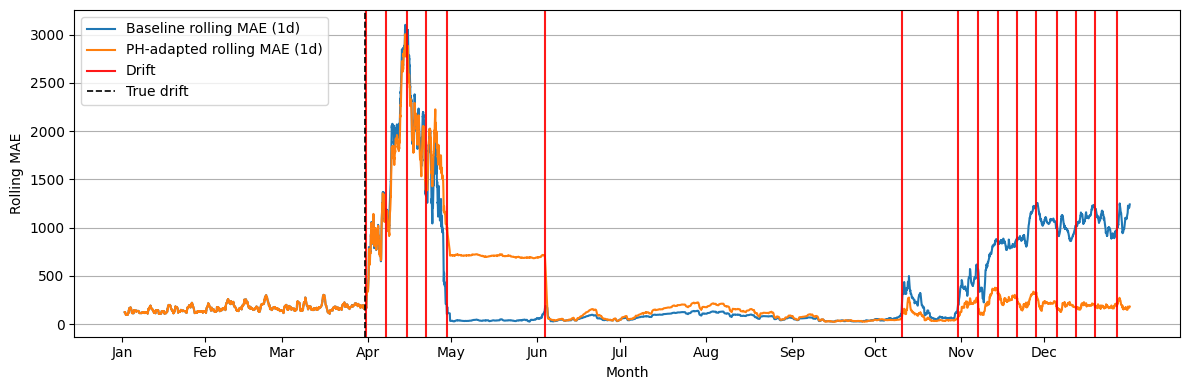

In [55]:
# xticks, xlabels = _month_ticks(mo3_lab)
# xticks = np.asarray(xticks, dtype=int)

# plt.figure(figsize=(12,4))
# plt.plot(mae3_base_roll, label=f"Baseline rolling MAE ({ROLL_DAYS}d)")
# plt.plot(mae_adapt_roll, label=f"PH-adapted rolling MAE ({ROLL_DAYS}d)")

# for k, di in enumerate(ph_all_drifts):
#     color = "red" if ts3_lab[di] >= ONLY_AFTER_TS else "tab:gray"
#     lab = "Drift" if (k == 0 and color == "red") else None
#     plt.axvline(di, color=color, linestyle="-", linewidth=1.5, alpha=0.9, label=lab)

# plt.axvline(tau_idx, color="black", linestyle="--", linewidth=1.2, label="True drift")
# plt.xticks(xticks, xlabels)
# plt.xlabel("Month")
# plt.ylabel("Rolling MAE")
# plt.title("")
# plt.grid(True, axis="y")
# plt.legend()
# plt.tight_layout()
# plt.show()


[PH-gradual-Y4] Using df_drift for Year 4.
=== Year 4 (gradual PH) — Per-horizon metrics (MAE, RMSE, sMAPE%) ===


horizon  MAE_base  MAE_PH_gradual  RMSE_base  RMSE_PH_gradual  sMAPE%_base  \
0     t+1     304.3           187.9    1,033.7            270.1        168.7   
1     t+2     305.9           183.2      843.3            240.2        171.3   
2     t+3     355.3           179.5      941.9            242.3        172.5   
3     t+4     380.9           176.6      869.9            249.6        173.7   

   sMAPE%_PH_gradual  MAPE%_base  MAPE%_PH_gradual  
0              164.7     8,391.6          14,332.3  
1              164.6     9,514.6          13,868.8  
2              165.2    11,361.8          12,916.4  
3              165.7    12,449.3          12,031.9


=== Year 4 (gradual PH) — Aggregate metrics (means over windows) ===


MAE_mean  RMSE_mean  sMAPE_mean%  MAPE_mean%  WAPE%
Baseline                  336.6      384.0        171.6    10,429.3  149.4
PH-Adaptive (gradual)     181.8      192.4        165.0    13,287.4   80.7


=== Year 4 (gradual PH) — Global metrics (flattened over all windows x horizons) ===


MAE_global  RMSE_global  sMAPE_global%  MAPE_global%  \
Baseline                    336.6        925.1          171.6      10,429.3   
PH-Adaptive (gradual)       181.8        250.8          165.0      13,287.4   

                       WAPE_global%  
Baseline                      149.4  
PH-Adaptive (gradual)          80.7

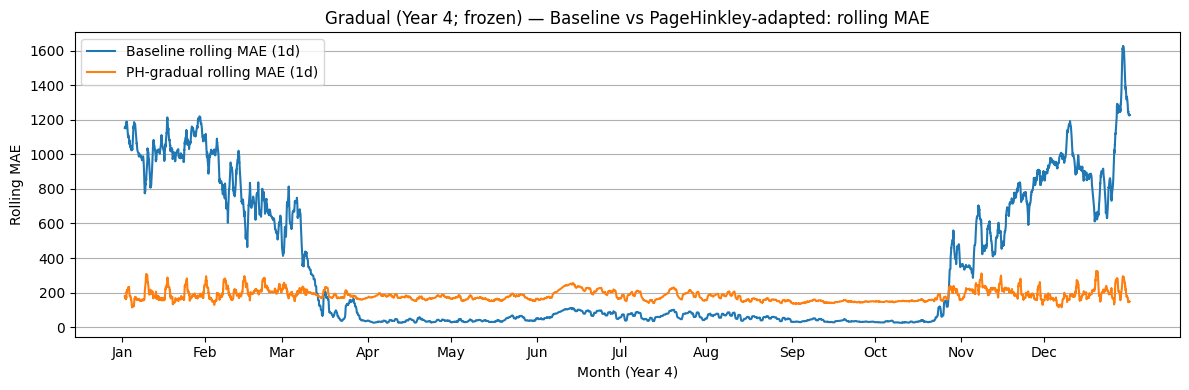

In [100]:
# ---------- Year 4: PH (gradual) — rolling MAE plot + MAE/RMSE/sMAPE tables ----------


# --- Minimal helpers (kept local for robustness) ---
def _window_mae(y_true_row, y_hat_row):
    return float(np.mean(np.abs(y_true_row - y_hat_row)))

def _window_rmse(y_true_row, y_hat_row):
    return float(np.sqrt(np.mean((y_true_row - y_hat_row) ** 2)))

def _window_smape(y_true_row, y_hat_row, eps=1e-6):
    num = np.abs(y_true_row - y_hat_row)
    den = (np.abs(y_true_row) + np.abs(y_hat_row)).clip(min=eps)
    return float(np.mean(2.0 * num / den) * 100.0)  # %

# ------------------ FIXED: MAPE helper (eps floor = 1.0 in target units) ------------------
def _window_mape(y_true_row, y_hat_row, eps=1.0):
    den = np.maximum(np.abs(y_true_row), eps)
    return float(np.mean(np.abs((y_true_row - y_hat_row) / den)) * 100.0)  # %
# ------------------------------------------------------------------------------------------

def _per_horizon_smape(y_true_2d, y_hat_2d, eps=1e-6):
    Hh = y_true_2d.shape[1]
    out = []
    for h in range(Hh):
        num = np.abs(y_true_2d[:, h] - y_hat_2d[:, h])
        den = (np.abs(y_true_2d[:, h]) + np.abs(y_hat_2d[:, h])).clip(min=eps)
        out.append(float(np.mean(2.0 * num / den) * 100.0))
    return out

# ------------------ FIXED: per-horizon MAPE (eps floor = 1.0 in target units) ------------------
def _per_horizon_mape(y_true_2d, y_hat_2d, eps=1.0):
    Hh = y_true_2d.shape[1]
    out = []
    for h in range(Hh):
        den = np.maximum(np.abs(y_true_2d[:, h]), eps)
        out.append(float(np.mean(np.abs((y_true_2d[:, h] - y_hat_2d[:, h]) / den)) * 100.0))
    return out
# -----------------------------------------------------------------------------------------------

def _rolling_mean(values, k):
    if k <= 1:
        return values.astype(float)
    out = np.full(len(values), np.nan, float)
    if len(values) >= k:
        csum = np.cumsum(values, dtype=float)
        out[k-1:] = (csum[k-1:] - np.concatenate(([0.0], csum[:-k])))/k
    return out

# ---------- Choose the Year-4 gradual dataset (no noisy warnings) ----------
if 'blended_df' in globals() and len(blended_df[blended_df.get('year', -1) == 4]):
    df_src, src_name = blended_df, 'blended_df'
elif 'df_drift_gradual' in globals() and 'year' in df_drift_gradual and np.any(df_drift_gradual['year'] == 4):
    df_src, src_name = df_drift_gradual, 'df_drift_gradual'
elif 'y4_gradual_df' in globals() and len(y4_gradual_df):
    df_src, src_name = y4_gradual_df, 'y4_gradual_df'
else:
    df_src, src_name = df_drift, 'df_drift'
print(f"[PH-gradual-Y4] Using {src_name} for Year 4.")

# ---------- 1) Build Year-4 windows ----------
y4_df = df_src[df_src['year'] == 4].reset_index(drop=True)
assert len(y4_df) >= LOOKBACK + HORIZON + 1, "Year 4 has insufficient rows."

X4_win, Y4_win, ts4_lab, mo4_lab, _ = _build_year_windows(y4_df)
if len(ts4_lab) > 1 and np.isfinite(ts4_lab).all():
    dt4_sec = float(np.median(np.diff(ts4_lab)))
    steps_per_day = max(1, int(round((24*3600)/dt4_sec)))
else:
    steps_per_day = 96  # fallback for 15-min cadence
ROLL_DAYS  = 1
roll_steps = max(1, ROLL_DAYS * steps_per_day)

# ---------- 2) Ensure the PH-gradual adaptive model exists (safe fallback) ----------
if 'pagehinkley_model_gradual' not in globals():
    # Create from baseline if Year-3 PH-gradual cell hasn't run
    pagehinkley_model_gradual = tf.keras.models.clone_model(baseline_model)
    _ = pagehinkley_model_gradual(baseline_model.inputs, training=False)
    pagehinkley_model_gradual.set_weights(baseline_model.get_weights())

# ---------- 3) Predict (baseline vs PH-adapted GRADUAL model) ----------
Y4_true, Y4_hat_base = _predict_unscaled(baseline_model,             X4_win, Y4_win)
_,        Y4_hat_ph   = _predict_unscaled(pagehinkley_model_gradual, X4_win, Y4_win)

H = Y4_true.shape[1]

# ---------- 4) Per-horizon metrics (MAE, RMSE, sMAPE) ----------
mae_base   = [mean_absolute_error(Y4_true[:,h], Y4_hat_base[:,h]) for h in range(H)]
mae_ph     = [mean_absolute_error(Y4_true[:,h], Y4_hat_ph[:,h])   for h in range(H)]
rmse_base  = [mean_squared_error(Y4_true[:,h], Y4_hat_base[:,h], squared=False) for h in range(H)]
rmse_ph    = [mean_squared_error(Y4_true[:,h], Y4_hat_ph[:,h],   squared=False) for h in range(H)]
smape_base = _per_horizon_smape(Y4_true, Y4_hat_base)
smape_ph   = _per_horizon_smape(Y4_true, Y4_hat_ph)

# ------------------ per-horizon MAPE ------------------
mape_base  = _per_horizon_mape(Y4_true, Y4_hat_base)
mape_ph    = _per_horizon_mape(Y4_true, Y4_hat_ph)
# ------------------------------------------------------

per_horizon_tbl = pd.DataFrame({
    "horizon":     [f"t+{i+1}" for i in range(H)],
    "MAE_base":     mae_base,   "MAE_PH_gradual":     mae_ph,
    "RMSE_base":    rmse_base,  "RMSE_PH_gradual":    rmse_ph,
    "sMAPE%_base":  smape_base, "sMAPE%_PH_gradual":  smape_ph,
    "MAPE%_base":   mape_base,  "MAPE%_PH_gradual":   mape_ph
})

# ---------- 5) Per-window errors -> rolling MAE (only plot this) ----------
mae4_base_win = np.array([_window_mae(Y4_true[i], Y4_hat_base[i]) for i in range(len(X4_win))], float)
mae4_ph_win   = np.array([_window_mae(Y4_true[i], Y4_hat_ph[i])   for i in range(len(X4_win))], float)

mae4_base_roll = _rolling_mean(mae4_base_win, roll_steps)
mae4_ph_roll   = _rolling_mean(mae4_ph_win,   roll_steps)

# ---------- 6) Aggregate (means over all Year-4 windows) ----------
rmse4_base_win  = np.array([_window_rmse(Y4_true[i], Y4_hat_base[i]) for i in range(len(X4_win))], float)
rmse4_ph_win    = np.array([_window_rmse(Y4_true[i], Y4_hat_ph[i])   for i in range(len(X4_win))], float)
smape4_base_win = np.array([_window_smape(Y4_true[i], Y4_hat_base[i]) for i in range(len(X4_win))], float)
smape4_ph_win   = np.array([_window_smape(Y4_true[i], Y4_hat_ph[i])   for i in range(len(X4_win))], float)

# ------------------ per-window MAPE ------------------
mape4_base_win  = np.array([_window_mape(Y4_true[i], Y4_hat_base[i]) for i in range(len(X4_win))], float)
mape4_ph_win    = np.array([_window_mape(Y4_true[i], Y4_hat_ph[i])   for i in range(len(X4_win))], float)
# ----------------------------------------------------

# WAPE over all windows & horizons: sum|y - yhat| / sum|y| * 100 [web:25]
wape_base = (np.sum(np.abs(Y4_true - Y4_hat_base)) / max(np.sum(np.abs(Y4_true)), 1e-12)) * 100.0
wape_ph   = (np.sum(np.abs(Y4_true - Y4_hat_ph))   / max(np.sum(np.abs(Y4_true)), 1e-12)) * 100.0

aggregate_tbl = pd.DataFrame({
    "MAE_mean":    [float(np.mean(mae4_base_win)),   float(np.mean(mae4_ph_win))],
    "RMSE_mean":   [float(np.mean(rmse4_base_win)),  float(np.mean(rmse4_ph_win))],
    "sMAPE_mean%": [float(np.mean(smape4_base_win)), float(np.mean(smape4_ph_win))],
    "MAPE_mean%":  [float(np.mean(mape4_base_win)),  float(np.mean(mape4_ph_win))],
    "WAPE%":       [float(wape_base),                float(wape_ph)]
}, index=["Baseline", "PH-Adaptive (gradual)"])

# ---------- 7) Show tables ----------
print("=== Year 4 (gradual PH) — Per-horizon metrics (MAE, RMSE, sMAPE%) ===")
display(per_horizon_tbl)

print("\n=== Year 4 (gradual PH) — Aggregate metrics (means over windows) ===")
display(aggregate_tbl)

# ---------- ADDED: Global metrics (flattened over all windows x horizons) ----------
_eps_g = 1e-6

_diff_base = (Y4_true - Y4_hat_base)
mae_base_global  = float(np.mean(np.abs(_diff_base)))
rmse_base_global = float(np.sqrt(np.mean(_diff_base ** 2)))
_den_base = (np.abs(Y4_true) + np.abs(Y4_hat_base)).clip(min=_eps_g)
smape_base_global = float(np.mean(2.0 * np.abs(_diff_base) / _den_base) * 100.0)
# ------------------ FIXED: global MAPE (baseline; eps floor = 1.0) ------------------
_den_mape_base = np.maximum(np.abs(Y4_true), 1.0)
mape_base_global = float(np.mean(np.abs(_diff_base) / _den_mape_base) * 100.0)
# ------------------------------------------------------------------------------------
wape_base_global  = float(wape_base)

_diff_ph = (Y4_true - Y4_hat_ph)
mae_ph_global  = float(np.mean(np.abs(_diff_ph)))
rmse_ph_global = float(np.sqrt(np.mean(_diff_ph ** 2)))
_den_ph = (np.abs(Y4_true) + np.abs(Y4_hat_ph)).clip(min=_eps_g)
smape_ph_global = float(np.mean(2.0 * np.abs(_diff_ph) / _den_ph) * 100.0)
# ------------------ FIXED: global MAPE (PH; eps floor = 1.0) -----------------------
_den_mape_ph = np.maximum(np.abs(Y4_true), 1.0)
mape_ph_global = float(np.mean(np.abs(_diff_ph) / _den_mape_ph) * 100.0)
# -----------------------------------------------------------------------------------
wape_ph_global  = float(wape_ph)

global_tbl = pd.DataFrame({
    "MAE_global":     [mae_base_global,   mae_ph_global],
    "RMSE_global":    [rmse_base_global,  rmse_ph_global],
    "sMAPE_global%":  [smape_base_global, smape_ph_global],
    "MAPE_global%":   [mape_base_global,  mape_ph_global],
    "WAPE_global%":   [wape_base_global,  wape_ph_global],
}, index=["Baseline", "PH-Adaptive (gradual)"])

print("\n=== Year 4 (gradual PH) — Global metrics (flattened over all windows x horizons) ===")
display(global_tbl)
# ----------------------------------------------------------------------


# ---------- 8) Plot rolling MAE (Year 4) — the only figure ----------
xt, _ = _month_ticks(mo4_lab)

# --- plotting-only change: month abbreviations derived from month column ---
xt = np.asarray(xt, dtype=int)
import calendar
mo_at_ticks = np.asarray(mo4_lab)[xt].astype(int)
xl = [calendar.month_abbr[m] if 1 <= m <= 12 else str(m) for m in mo_at_ticks]  # 'Jan'..'Dec' [web:4]
# ----------------------------------------------------------------------

plt.figure(figsize=(12,4))
plt.plot(mae4_base_roll, label=f"Baseline rolling MAE ({ROLL_DAYS}d)")
plt.plot(mae4_ph_roll,   label=f"PH-gradual rolling MAE ({ROLL_DAYS}d)")
plt.xticks(xt, xl)
plt.xlabel("Month (Year 4)")
plt.ylabel("Rolling MAE")
plt.title("Gradual (Year 4; frozen) — Baseline vs PageHinkley-adapted: rolling MAE")
plt.grid(True, axis='y')
plt.legend()
plt.tight_layout()
plt.show()


[PH-gradual-Y4] Using df_drift for Year 5.
=== Year 5 (gradual PH) — Per-horizon metrics (MAE, RMSE, sMAPE%) ===


horizon  MAE_base  MAE_PH_gradual  RMSE_base  RMSE_PH_gradual  sMAPE%_base  \
0     t+1     342.1           198.4    1,072.5            267.3        168.2   
1     t+2     348.3           194.6      885.6            249.9        170.3   
2     t+3     403.2           193.7      993.6            261.2        171.6   
3     t+4     433.0           191.9      941.0            267.8        172.7   

   sMAPE%_PH_gradual  MAPE%_base  MAPE%_PH_gradual  
0              162.0    10,265.0          15,076.5  
1              162.1    11,720.5          14,572.8  
2              162.7    13,880.6          13,748.0  
3              163.3    14,936.3          12,934.1


=== Year 5 (gradual PH) — Aggregate metrics (means over windows) ===


MAE_mean  RMSE_mean  sMAPE_mean%  MAPE_mean%  WAPE%
Baseline                  381.6      433.4        170.7    12,700.6  162.3
PH-Adaptive (gradual)     194.6      205.6        162.5    14,082.8   82.8


=== Year 5 (gradual PH) — Global metrics (flattened over all windows x horizons) ===


MAE_global  RMSE_global  sMAPE_global%  MAPE_global%  \
Baseline                    381.6        975.6          170.7      12,700.6   
PH-Adaptive (gradual)       194.6        261.7          162.5      14,082.8   

                       WAPE_global%  
Baseline                      162.3  
PH-Adaptive (gradual)          82.8

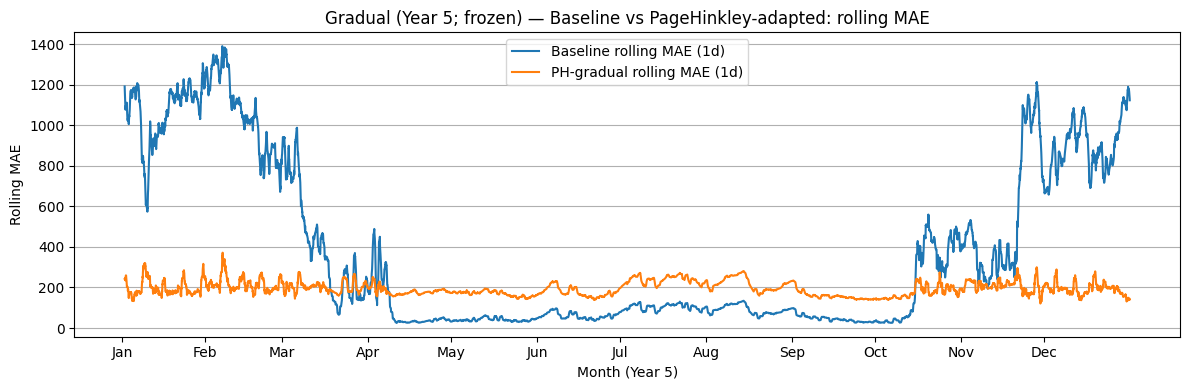

In [101]:
# ---------- Year 5: PH (gradual) — rolling MAE plot + MAE/RMSE/sMAPE tables ----------


# --- Minimal helpers (kept local for robustness) ---
def _window_mae(y_true_row, y_hat_row):
    return float(np.mean(np.abs(y_true_row - y_hat_row)))

def _window_rmse(y_true_row, y_hat_row):
    return float(np.sqrt(np.mean((y_true_row - y_hat_row) ** 2)))

def _window_smape(y_true_row, y_hat_row, eps=1e-6):
    num = np.abs(y_true_row - y_hat_row)
    den = (np.abs(y_true_row) + np.abs(y_hat_row)).clip(min=eps)
    return float(np.mean(2.0 * num / den) * 100.0)  # %

# ------------------ FIXED: MAPE helper (eps floor = 1.0 in target units) ------------------
def _window_mape(y_true_row, y_hat_row, eps=1.0):
    den = np.maximum(np.abs(y_true_row), eps)
    return float(np.mean(np.abs((y_true_row - y_hat_row) / den)) * 100.0)  # %
# -----------------------------------------------------------------------------------------

def _per_horizon_smape(y_true_2d, y_hat_2d, eps=1e-6):
    Hh = y_true_2d.shape[1]
    out = []
    for h in range(Hh):
        num = np.abs(y_true_2d[:, h] - y_hat_2d[:, h])
        den = (np.abs(y_true_2d[:, h]) + np.abs(y_hat_2d[:, h])).clip(min=eps)
        out.append(float(np.mean(2.0 * num / den) * 100.0))
    return out

# ------------------ FIXED: per-horizon MAPE (eps floor = 1.0 in target units) ------------------
def _per_horizon_mape(y_true_2d, y_hat_2d, eps=1.0):
    Hh = y_true_2d.shape[1]
    out = []
    for h in range(Hh):
        den = np.maximum(np.abs(y_true_2d[:, h]), eps)
        out.append(float(np.mean(np.abs((y_true_2d[:, h] - y_hat_2d[:, h]) / den)) * 100.0))
    return out
# -----------------------------------------------------------------------------------------------

def _rolling_mean(values, k):
    if k <= 1:
        return values.astype(float)
    out = np.full(len(values), np.nan, float)
    if len(values) >= k:
        csum = np.cumsum(values, dtype=float)
        out[k-1:] = (csum[k-1:] - np.concatenate(([0.0], csum[:-k])))/k
    return out

# ---------- Choose the Year-4 gradual dataset (no noisy warnings) ----------
if 'blended_df' in globals() and len(blended_df[blended_df.get('year', -1) == 5]):
    df_src, src_name = blended_df, 'blended_df'
elif 'df_drift_gradual' in globals() and 'year' in df_drift_gradual and np.any(df_drift_gradual['year'] == 5):
    df_src, src_name = df_drift_gradual, 'df_drift_gradual'
elif 'y5_gradual_df' in globals() and len(y5_gradual_df):
    df_src, src_name = y5_gradual_df, 'y5_gradual_df'
else:
    df_src, src_name = df_drift, 'df_drift'
print(f"[PH-gradual-Y4] Using {src_name} for Year 5.")

# ---------- 1) Build Year-4 windows ----------
y4_df = df_src[df_src['year'] == 5].reset_index(drop=True)
assert len(y4_df) >= LOOKBACK + HORIZON + 1, "Year 5 has insufficient rows."

X4_win, Y4_win, ts4_lab, mo4_lab, _ = _build_year_windows(y4_df)
if len(ts4_lab) > 1 and np.isfinite(ts4_lab).all():
    dt4_sec = float(np.median(np.diff(ts4_lab)))
    steps_per_day = max(1, int(round((24*3600)/dt4_sec)))
else:
    steps_per_day = 96  # fallback for 15-min cadence
ROLL_DAYS  = 1
roll_steps = max(1, ROLL_DAYS * steps_per_day)

# ---------- 2) Ensure the PH-gradual adaptive model exists (safe fallback) ----------
if 'pagehinkley_model_gradual' not in globals():
    # Create from baseline if Year-3 PH-gradual cell hasn't run
    pagehinkley_model_gradual = tf.keras.models.clone_model(baseline_model)
    _ = pagehinkley_model_gradual(baseline_model.inputs, training=False)
    pagehinkley_model_gradual.set_weights(baseline_model.get_weights())

# ---------- 3) Predict (baseline vs PH-adapted GRADUAL model) ----------
Y4_true, Y4_hat_base = _predict_unscaled(baseline_model,             X4_win, Y4_win)
_,        Y4_hat_ph   = _predict_unscaled(pagehinkley_model_gradual, X4_win, Y4_win)

H = Y4_true.shape[1]

# ---------- 4) Per-horizon metrics (MAE, RMSE, sMAPE) ----------
mae_base   = [mean_absolute_error(Y4_true[:,h], Y4_hat_base[:,h]) for h in range(H)]
mae_ph     = [mean_absolute_error(Y4_true[:,h], Y4_hat_ph[:,h])   for h in range(H)]
rmse_base  = [mean_squared_error(Y4_true[:,h], Y4_hat_base[:,h], squared=False) for h in range(H)]
rmse_ph    = [mean_squared_error(Y4_true[:,h], Y4_hat_ph[:,h],   squared=False) for h in range(H)]
smape_base = _per_horizon_smape(Y4_true, Y4_hat_base)
smape_ph   = _per_horizon_smape(Y4_true, Y4_hat_ph)

# ------------------ per-horizon MAPE ------------------
mape_base  = _per_horizon_mape(Y4_true, Y4_hat_base)
mape_ph    = _per_horizon_mape(Y4_true, Y4_hat_ph)
# ------------------------------------------------------------

per_horizon_tbl = pd.DataFrame({
    "horizon":     [f"t+{i+1}" for i in range(H)],
    "MAE_base":     mae_base,   "MAE_PH_gradual":     mae_ph,
    "RMSE_base":    rmse_base,  "RMSE_PH_gradual":    rmse_ph,
    "sMAPE%_base":  smape_base, "sMAPE%_PH_gradual":  smape_ph,
    "MAPE%_base":   mape_base,  "MAPE%_PH_gradual":   mape_ph
})

# ---------- 5) Per-window errors -> rolling MAE (only plot this) ----------
mae4_base_win = np.array([_window_mae(Y4_true[i], Y4_hat_base[i]) for i in range(len(X4_win))], float)
mae4_ph_win   = np.array([_window_mae(Y4_true[i], Y4_hat_ph[i])   for i in range(len(X4_win))], float)

mae4_base_roll = _rolling_mean(mae4_base_win, roll_steps)
mae4_ph_roll   = _rolling_mean(mae4_ph_win,   roll_steps)

# ---------- 6) Aggregate (means over all Year-4 windows) ----------
rmse4_base_win  = np.array([_window_rmse(Y4_true[i], Y4_hat_base[i]) for i in range(len(X4_win))], float)
rmse4_ph_win    = np.array([_window_rmse(Y4_true[i], Y4_hat_ph[i])   for i in range(len(X4_win))], float)
smape4_base_win = np.array([_window_smape(Y4_true[i], Y4_hat_base[i]) for i in range(len(X4_win))], float)
smape4_ph_win   = np.array([_window_smape(Y4_true[i], Y4_hat_ph[i])   for i in range(len(X4_win))], float)

# ------------------ per-window MAPE ------------------
mape4_base_win  = np.array([_window_mape(Y4_true[i], Y4_hat_base[i]) for i in range(len(X4_win))], float)
mape4_ph_win    = np.array([_window_mape(Y4_true[i], Y4_hat_ph[i])   for i in range(len(X4_win))], float)
# ------------------------------------------------------------

# WAPE over all windows & horizons: sum|y - yhat| / sum|y| * 100 [web:25]
wape_base = (np.sum(np.abs(Y4_true - Y4_hat_base)) / max(np.sum(np.abs(Y4_true)), 1e-12)) * 100.0
wape_ph   = (np.sum(np.abs(Y4_true - Y4_hat_ph))   / max(np.sum(np.abs(Y4_true)), 1e-12)) * 100.0

aggregate_tbl = pd.DataFrame({
    "MAE_mean":    [float(np.mean(mae4_base_win)),   float(np.mean(mae4_ph_win))],
    "RMSE_mean":   [float(np.mean(rmse4_base_win)),  float(np.mean(rmse4_ph_win))],
    "sMAPE_mean%": [float(np.mean(smape4_base_win)), float(np.mean(smape4_ph_win))],
    "MAPE_mean%":  [float(np.mean(mape4_base_win)),  float(np.mean(mape4_ph_win))],
    "WAPE%":       [float(wape_base),                float(wape_ph)]
}, index=["Baseline", "PH-Adaptive (gradual)"])

# ---------- 7) Show tables ----------
print("=== Year 5 (gradual PH) — Per-horizon metrics (MAE, RMSE, sMAPE%) ===")
display(per_horizon_tbl)

print("\n=== Year 5 (gradual PH) — Aggregate metrics (means over windows) ===")
display(aggregate_tbl)

# ---------- ADDED: Global metrics (flattened over all windows x horizons) ----------
_eps_g = 1e-6

_diff_base = (Y4_true - Y4_hat_base)
mae_base_global  = float(np.mean(np.abs(_diff_base)))
rmse_base_global = float(np.sqrt(np.mean(_diff_base ** 2)))
_den_base = (np.abs(Y4_true) + np.abs(Y4_hat_base)).clip(min=_eps_g)
smape_base_global = float(np.mean(2.0 * np.abs(_diff_base) / _den_base) * 100.0)
# ------------------ FIXED: global MAPE (baseline; eps floor = 1.0) ------------------
_den_mape_base = np.maximum(np.abs(Y4_true), 1.0)
mape_base_global = float(np.mean(np.abs(_diff_base) / _den_mape_base) * 100.0)
# ------------------------------------------------------------------------------------
wape_base_global  = float(wape_base)

_diff_ph = (Y4_true - Y4_hat_ph)
mae_ph_global  = float(np.mean(np.abs(_diff_ph)))
rmse_ph_global = float(np.sqrt(np.mean(_diff_ph ** 2)))
_den_ph = (np.abs(Y4_true) + np.abs(Y4_hat_ph)).clip(min=_eps_g)
smape_ph_global = float(np.mean(2.0 * np.abs(_diff_ph) / _den_ph) * 100.0)
# ------------------ FIXED: global MAPE (PH; eps floor = 1.0) ------------------
_den_mape_ph = np.maximum(np.abs(Y4_true), 1.0)
mape_ph_global = float(np.mean(np.abs(_diff_ph) / _den_mape_ph) * 100.0)
# --------------------------------------------------------------------------------
wape_ph_global  = float(wape_ph)

global_tbl = pd.DataFrame({
    "MAE_global":     [mae_base_global,   mae_ph_global],
    "RMSE_global":    [rmse_base_global,  rmse_ph_global],
    "sMAPE_global%":  [smape_base_global, smape_ph_global],
    "MAPE_global%":   [mape_base_global,  mape_ph_global],
    "WAPE_global%":   [wape_base_global,  wape_ph_global],
}, index=["Baseline", "PH-Adaptive (gradual)"])

print("\n=== Year 5 (gradual PH) — Global metrics (flattened over all windows x horizons) ===")
display(global_tbl)
# ----------------------------------------------------------------------


# ---------- 8) Plot rolling MAE (Year 4) — the only figure ----------
xt, _ = _month_ticks(mo4_lab)

# --- plotting-only change: month abbreviations derived from month column ---
xt = np.asarray(xt, dtype=int)
import calendar
mo_at_ticks = np.asarray(mo4_lab)[xt].astype(int)
xl = [calendar.month_abbr[m] if 1 <= m <= 12 else str(m) for m in mo_at_ticks]  # 'Jan'..'Dec' [web:4]
# ----------------------------------------------------------------------

plt.figure(figsize=(12,4))
plt.plot(mae4_base_roll, label=f"Baseline rolling MAE ({ROLL_DAYS}d)")
plt.plot(mae4_ph_roll,   label=f"PH-gradual rolling MAE ({ROLL_DAYS}d)")
plt.xticks(xt, xl)
plt.xlabel("Month (Year 5)")
plt.ylabel("Rolling MAE")
plt.title("Gradual (Year 5; frozen) — Baseline vs PageHinkley-adapted: rolling MAE")
plt.grid(True, axis='y')
plt.legend()
plt.tight_layout()
plt.show()


[ADWIN-gradual] Using blended_df for Year 3.
[ADWIN-gradual] Normalization from val: v_min=3.541016, v_rng=4135.396484

=== ADWIN (gradual Y3) drift stats ===
delta=0.001 | total_drifts=12 | false_positives(pre-Apr-1)=1
first_post_drift_idx=8575 | detection_delay_hours=35.00


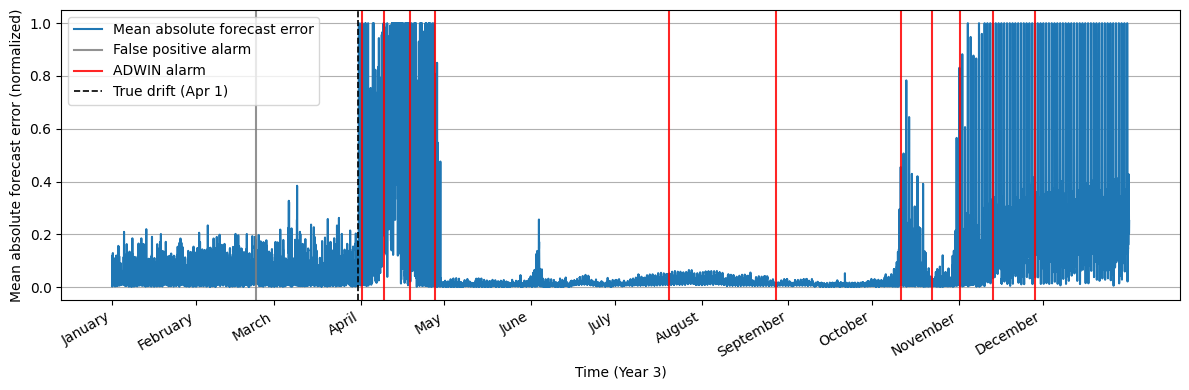

In [104]:
# -------------------- Config --------------------
BEST_DELTA     = 0.001
COOLDOWN_DAYS  = 7
ONLY_AFTER_TS  = 70_848_000  # Apr-1 Year 3 (seconds)
H              = HORIZON     # ensure HORIZON exists

# -------------------- Pick the GRADUAL Year-3 dataset --------------------
# Prefer the probabilistically-mixed dataset you created (df_drift_pm)
if 'df_drift_pm' in globals() and isinstance(df_drift_pm, pd.DataFrame) and len(df_drift_pm):
    df_src = df_drift_pm
    print("[ADWIN-gradual] Using df_drift_pm (probabilistic mixing) for Year 3.")
elif 'blended_df' in globals() and isinstance(blended_df, pd.DataFrame) and len(blended_df):
    df_src = blended_df
    print("[ADWIN-gradual] Using blended_df for Year 3.")
elif 'y3_gradual_df' in globals() and isinstance(y3_gradual_df, pd.DataFrame) and len(y3_gradual_df):
    df_src = y3_gradual_df
    print("[ADWIN-gradual] Using y3_gradual_df for Year 3.")
else:
    df_src = df_drift
    print("[ADWIN-gradual] WARNING: gradual dataset not found; falling back to df_drift for Year 3.")

# -------------------- Helpers --------------------
import numpy as np, pandas as pd, matplotlib.pyplot as plt, calendar
from river import drift

def _label_rows(n_full, lookback, horizon):
    return (np.arange(lookback, n_full - horizon + 1) + (horizon - 1))

def _build_year_windows(df_year: pd.DataFrame):
    X = df_year[FEATS].to_numpy(float)
    Xs = X_scaler.transform(X)
    ys = Xs[:, idx_t].copy()
    Xw, Yw = make_windows_multi(Xs, ys, LOOKBACK, H, stride=1)
    lbl_idx = _label_rows(len(df_year), LOOKBACK, H)
    ts_lab  = df_year.iloc[lbl_idx]["timestamp_sec"].to_numpy()
    mo_lab  = df_year.iloc[lbl_idx]["month"].to_numpy()
    return Xw, Yw, ts_lab, mo_lab

def _predict_unscaled(model, Xw, Yw):
    Y_hat_s = model.predict(Xw, verbose=0)
    Y_true  = inv_steps_from_X_scaler(Yw,      X_scaler, idx_t, H)
    Y_hat   = inv_steps_from_X_scaler(Y_hat_s, X_scaler, idx_t, H)
    return Y_true, Y_hat

def _window_mae(y_true_row, y_hat_row):
    return float(np.mean(np.abs(y_true_row - y_hat_row)))

def _steps_per_day_from_ts(ts_labels):
    if ts_labels.size >= 2 and np.isfinite(ts_labels).all():
        dt_sec = float(np.median(np.diff(ts_labels)))
    else:
        dt_sec = 15 * 60.0
    steps_per_day = max(1, int(round((24 * 3600) / dt_sec)))
    return steps_per_day, dt_sec

def _month_ticks_with_names(month_arr: np.ndarray):
    """Tick at first index of each new month; label with month *name*."""
    month_arr = np.asarray(month_arr)
    starts, labels, seen = [], [], set()
    for i, m in enumerate(month_arr.astype(int)):
        if m not in seen:
            starts.append(i)
            labels.append(calendar.month_name[m] if 1 <= m <= 12 else f"M{m}")
            seen.add(m)
    return np.asarray(starts, int), labels

# -------------------- 1) Calibrate normalization from validation (v_min, rng) --------------------
# ADWIN sees normalized baseline-MAE in [0,1], normalized with validation MAE range
X_val = X_scaler.transform(val_df[FEATS].to_numpy(float))
y_val = X_val[:, idx_t].copy()
Xv_win, Yv_win = make_windows_multi(X_val, y_val, LOOKBACK, H, stride=1)
Yv_true, Yv_hat = _predict_unscaled(baseline_model, Xv_win, Yv_win)
e_bar_val = np.mean(np.abs(Yv_true - Yv_hat), axis=1)  # MAE per window
v_min = float(np.min(e_bar_val))
v_rng = float(max(1e-9, np.max(e_bar_val) - v_min))

def _norm_from_val(e):
    z = (e - v_min) / v_rng
    return np.clip(z, 0.0, 1.0)

print(f"[ADWIN-gradual] Normalization from val: v_min={v_min:.6f}, v_rng={v_rng:.6f}")

# -------------------- 2) Build Year-3 windows + baseline MAE stream (on gradual Y3) --------------------
y3_df = df_src[df_src["year"] == 3].reset_index(drop=True)
X3_win, Y3_win, ts3_lab, mo3_lab = _build_year_windows(y3_df)

steps_per_day, dt_sec = _steps_per_day_from_ts(ts3_lab)
cooldown_steps = COOLDOWN_DAYS * steps_per_day
tau_idx = int(np.searchsorted(ts3_lab, ONLY_AFTER_TS, side="left"))

Y3_true_base, Y3_hat_base = _predict_unscaled(baseline_model, X3_win, Y3_win)
mae3_base_win  = np.array([_window_mae(Y3_true_base[i], Y3_hat_base[i]) for i in range(len(X3_win))], float)

# >>> This is the ADWIN input stream (what you want to plot)
mae3_base_norm = _norm_from_val(mae3_base_win)

# -------------------- 3) Run ADWIN (always update from start) + cooldown counting --------------------
adw = drift.ADWIN(delta=BEST_DELTA)

adw_drifts = []
cooldown = 0
for i, x in enumerate(mae3_base_norm):
    adw.update(float(x))  # ALWAYS update (includes pre-Apr “normal”)
    if cooldown > 0:
        cooldown -= 1
        continue
    if adw.drift_detected:
        adw_drifts.append(i)
        cooldown = cooldown_steps

# -------------------- 4) Drift stats (FPs + detection delay) --------------------
fp_count = int(np.sum(ts3_lab[np.array(adw_drifts, int)] < ONLY_AFTER_TS)) if len(adw_drifts) else 0

post = [i for i in adw_drifts if i >= tau_idx]
first_post = post[0] if len(post) else None
delay_h = ((first_post - tau_idx) * (dt_sec / 3600.0)) if first_post is not None else np.inf

print("\n=== ADWIN (gradual Y3) drift stats ===")
print(f"delta={BEST_DELTA} | total_drifts={len(adw_drifts)} | false_positives(pre-Apr-1)={fp_count}")
if first_post is None:
    print("first_post_drift: None  | detection_delay_hours=∞")
else:
    print(f"first_post_drift_idx={first_post} | detection_delay_hours={delay_h:.2f}")

# -------------------- 5) Plot: MIN-MAX normalized error stream + drift flags (month names) --------------------



fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(mae3_base_norm, label="Mean absolute forecast error")

shown_fp = False
shown_drift = False

for di in adw_drifts:
    is_post = (ts3_lab[di] >= ONLY_AFTER_TS)
    color = "red" if is_post else "tab:gray"

    if is_post and (not shown_drift):
        lab = "ADWIN alarm"
        shown_drift = True
    elif (not is_post) and (not shown_fp):
        lab = "False positive alarm"
        shown_fp = True
    else:
        lab = "_nolegend_"  # excluded from legend [web:1040]

    ax.axvline(di, color=color, linewidth=1.5, alpha=0.85, label=lab)

ax.axvline(tau_idx, color="black", linestyle="--", linewidth=1.2, label="True drift (Apr 1)")

ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=30, ha="right")
ax.set_xlabel("Time (Year 3)")
ax.set_ylabel("Mean absolute forecast error (normalized)")
ax.set_title("")
ax.grid(True, axis="y")
ax.legend()
fig.tight_layout()
out_path = "/kaggle/working/GradualYear3ADWIN.pdf"
fig.savefig(out_path, format="pdf", bbox_inches="tight")
plt.show()


[ADWIN-gradual-FT] Using blended_df for Year 3.
[ADWIN-gradual-FT] Normalization from val: v_min=3.541016, v_rng=4135.396484
[ADWIN-gradual-FT] Reusing existing adwin_gradual_model.

=== ADWIN drift summary (Year 3, gradual + FT) ===


delta  count_all_drifts  false_positives  adapt_drift_hits  \
0    0.0                12                1                11   

   first_post_drift_idx  detection_delay_hours  
0                  8575                   35.0

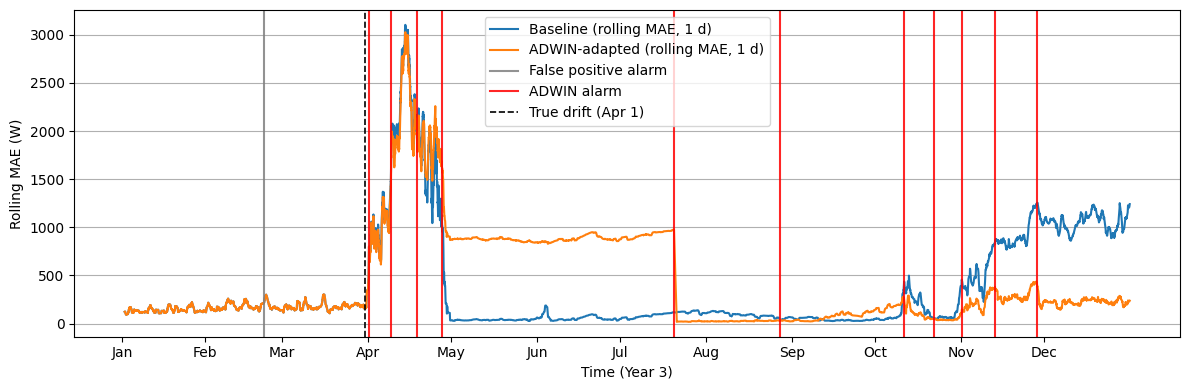


=== ADWIN recovery (using adapt hits; rule = 1 day consecutive) ===


adapt_idx  recovered  recovery_hours
0        8575       True             1.8
1        9343       True             0.0
2       10239       True             0.0
3       11103       True         2,029.8
4       19135       True            21.8
5       22815       True             0.0
6       27103       True             0.0
7       28159       True             0.0
8       29119       True             0.0
9       30271       True             0.0
10      31711       True             0.0


=== Year 3 — Aggregate metrics (means over windows) ===


MAE_mean  RMSE_mean  sMAPE_mean%  MAPE_mean%  WAPE%
Baseline          358.1      416.1        130.9    11,381.7   22.0
ADWIN-Gradual     431.0      463.6        127.4    28,273.1   26.5


=== Year 3 — Per-horizon metrics (baseline vs ADWIN-Gradual) ===


horizon  MAE_base  MAE_adapt  RMSE_base  RMSE_adapt  sMAPE%_base  \
0     t+1     325.9      421.2    1,007.6       800.1        129.6   
1     t+2     335.7      425.0      914.4       798.8        130.6   
2     t+3     376.2      434.1      990.3       810.6        131.4   
3     t+4     394.7      443.7      957.9       798.1        132.1   

   sMAPE%_adapt  MAPE%_base  MAPE%_adapt  
0         126.8     9,936.3     28,912.4  
1         127.2    10,811.7     28,475.1  
2         127.6    12,301.5     27,917.7  
3         128.1    12,477.5     27,787.4


=== Year 3 — Global metrics (flattened over all windows x horizons) ===


MAE_global  RMSE_global  sMAPE_global%  MAPE_global%  \
Baseline            358.1        968.2          130.9      11,381.7   
ADWIN-Gradual       431.0        801.9          127.4      28,273.1   

               WAPE_global%  
Baseline               22.0  
ADWIN-Gradual          26.5

In [105]:
# ===================== ADWIN (ONLINE rolling-MAE) — Year 3 (GRADUAL) =====================



# -------------------- Config --------------------
BEST_DELTA     = 0.001
PRETRAIN_LR    = 0.0007509794596043137
FT_LR          = PRETRAIN_LR / 10.0
FT_DAYS        = 7
FT_EPOCHS      = 5
FT_BATCH       = 41
FT_PATIENCE    = 2
ROLL_DAYS      = 1
COOLDOWN_DAYS  = 7
ONLY_AFTER_TS  = 70_848_000   # Apr-1 Year 3 (seconds)
H              = HORIZON
RESET_AFTER_FT = False

# -------------------- Dataset choice (GRADUAL preferred) --------------------
if 'df_drift_pm' in globals() and isinstance(df_drift_pm, pd.DataFrame) and len(df_drift_pm):
    df_src = df_drift_pm
    print("[ADWIN-gradual-FT] Using df_drift_pm (probabilistic mixing) for Year 3.")
elif 'blended_df' in globals() and isinstance(blended_df, pd.DataFrame) and len(blended_df):
    df_src = blended_df
    print("[ADWIN-gradual-FT] Using blended_df for Year 3.")
elif 'y3_gradual_df' in globals() and isinstance(y3_gradual_df, pd.DataFrame) and len(y3_gradual_df):
    df_src = y3_gradual_df
    print("[ADWIN-gradual-FT] Using y3_gradual_df for Year 3.")
else:
    df_src = df_drift
    print("[ADWIN-gradual-FT] WARNING: gradual dataset not found; falling back to df_drift for Year 3.")

# -------------------- Small helpers --------------------
def _window_mae(y_true_row, y_hat_row):
    return float(np.mean(np.abs(y_true_row - y_hat_row)))

def _window_rmse(y_true_row, y_hat_row):
    return float(np.sqrt(np.mean((y_true_row - y_hat_row) ** 2)))

def _window_smape(y_true_row, y_hat_row, eps=1e-6):
    num = np.abs(y_true_row - y_hat_row)
    den = (np.abs(y_true_row) + np.abs(y_hat_row)).clip(min=eps)
    return float(np.mean(2.0 * num / den) * 100.0)

# -------------------- FIXED: MAPE helper --------------------
def _window_mape(y_true_row, y_hat_row, eps=1.0):
    den = np.maximum(np.abs(y_true_row), eps)
    return float(np.mean(np.abs((y_true_row - y_hat_row) / den)) * 100.0)  # % [web:1]
# -----------------------------------------------------------

def _rolling_mean(values, k):
    if k <= 1:
        return values.astype(float)
    out = np.full(len(values), np.nan, float)
    if len(values) >= k:
        csum = np.cumsum(values, dtype=float)
        out[k-1:] = (csum[k-1:] - np.concatenate(([0.0], csum[:-k])))/k
    return out

def _steps_per_day_from_labels(ts_labels):
    if ts_labels.size >= 2 and np.isfinite(ts_labels).all():
        dt_sec = float(np.median(np.diff(ts_labels)))
    else:
        dt_sec = 15 * 60.0
    steps_per_day = max(1, int(round((24 * 3600) / dt_sec)))
    return steps_per_day, dt_sec

def _month_ticks_named(month_arr):
    month_arr = np.asarray(month_arr).astype(int)
    starts, labels, seen = [], [], set()
    for i, m in enumerate(month_arr):
        if m not in seen:
            starts.append(i)
            labels.append(calendar.month_abbr[m] if 1 <= m <= 12 else str(m))
            seen.add(m)
    return np.asarray(starts, int), labels

def _per_horizon_smape(y_true_2d, y_hat_2d, eps=1e-6):
    out = []
    for h in range(y_true_2d.shape[1]):
        num = np.abs(y_true_2d[:, h] - y_hat_2d[:, h])
        den = (np.abs(y_true_2d[:, h]) + np.abs(y_hat_2d[:, h])).clip(min=eps)
        out.append(float(np.mean(2.0 * num / den) * 100.0))
    return out

# -------------------- FIXED: per-horizon MAPE --------------------
def _per_horizon_mape(y_true_2d, y_hat_2d, eps=1.0):
    out = []
    for h in range(y_true_2d.shape[1]):
        den = np.maximum(np.abs(y_true_2d[:, h]), eps)
        out.append(float(np.mean(np.abs((y_true_2d[:, h] - y_hat_2d[:, h]) / den)) * 100.0))  # % [web:1]
    return out
# ---------------------------------------------------------------

def _recovery_speed_indices(base_roll, adapt_roll, drift_indices, consec):
    """Earliest r>=d where adapt<=base for 'consec' consecutive windows; None if not found."""
    recov, N = [], len(base_roll)
    for d in drift_indices:
        r, i, cnt = None, max(0, d), 0
        while i < N:
            a, b = adapt_roll[i], base_roll[i]
            if np.isfinite(a) and np.isfinite(b) and (a <= b):
                cnt += 1
                if cnt >= consec:
                    r = i - consec + 1
                    break
            else:
                cnt = 0
            i += 1
        recov.append(r)
    return recov

# -------------------- Windows helpers (compat) --------------------
def _label_rows(n_full, lookback, horizon):
    return (np.arange(lookback, n_full - horizon + 1) + (horizon - 1))

def _build_year_windows_fallback(df_year: pd.DataFrame):
    # fallback implementation if user doesn't have _build_year_windows in scope
    X = df_year[FEATS].to_numpy(float)
    Xs = X_scaler.transform(X)
    ys = Xs[:, idx_t].copy()
    Xw, Yw = make_windows_multi(Xs, ys, LOOKBACK, H, stride=1)
    lbl_idx = _label_rows(len(df_year), LOOKBACK, H)
    ts_lab  = df_year.iloc[lbl_idx]['timestamp_sec'].to_numpy()
    mo_lab  = df_year.iloc[lbl_idx]['month'].to_numpy()
    return Xw, Yw, ts_lab, mo_lab  # 4-tuple

def _build_year_windows_compat(df_year: pd.DataFrame):
    if '_build_year_windows' in globals():
        out = _build_year_windows(df_year)
    else:
        out = _build_year_windows_fallback(df_year)

    if isinstance(out, (tuple, list)) and len(out) == 5:
        return out  # (Xw, Yw, ts, mo, lbl_idx)
    if isinstance(out, (tuple, list)) and len(out) == 4:
        Xw, Yw, ts, mo = out
        return Xw, Yw, ts, mo, None
    raise ValueError(f"_build_year_windows returned {type(out)} with len={len(out) if hasattr(out,'__len__') else '??'}; expected 4 or 5.")

def _predict_unscaled(model, Xw, Yw):
    Y_hat_s = model.predict(Xw, verbose=0)
    Y_true  = inv_steps_from_X_scaler(Yw,      X_scaler, idx_t, H)
    Y_hat   = inv_steps_from_X_scaler(Y_hat_s, X_scaler, idx_t, H)
    return Y_true, Y_hat

# -------------------- 1) Validation MAE-per-window for normalization (compute if missing) --------------------
if 'val_df' not in globals():
    nodrift_y123 = df_nodrift[df_nodrift['year'].isin([1, 2, 3])].reset_index(drop=True)
    split_idx = int(0.7 * len(nodrift_y123))
    val_df = nodrift_y123.iloc[split_idx:].reset_index(drop=True)
    print("[ADWIN-gradual-FT] val_df not found -> built from last 30% of Y1–Y3 no-drift.")

# compute e_bar_val if needed
if 'e_bar_val' not in globals():
    X_val = X_scaler.transform(val_df[FEATS].to_numpy(float))
    y_val = X_val[:, idx_t].copy()
    Xv_win, Yv_win = make_windows_multi(X_val, y_val, LOOKBACK, H, stride=1)
    Yv_true, Yv_hat = _predict_unscaled(baseline_model, Xv_win, Yv_win)
    e_bar_val = np.mean(np.abs(Yv_true - Yv_hat), axis=1)  # MAE per window
    print("[ADWIN-gradual-FT] Computed e_bar_val from validation windows.")

v_min = float(np.min(e_bar_val))
v_max = float(np.max(e_bar_val))
v_rng = float(max(1e-12, v_max - v_min))

def _norm_from_val(e):
    return np.clip((e - v_min) / v_rng, 0.0, 1.0)

print(f"[ADWIN-gradual-FT] Normalization from val: v_min={v_min:.6f}, v_rng={v_rng:.6f}")

# -------------------- 2) Build Year-3 windows & baseline reference streams --------------------
y3_df = df_src[df_src['year'] == 3].reset_index(drop=True)
X3_win, Y3_win, ts3_lab, mo3_lab, _ = _build_year_windows_compat(y3_df)

steps_per_day, dt_sec = _steps_per_day_from_labels(ts3_lab)
roll_steps     = max(1, ROLL_DAYS * steps_per_day)
ft_steps       = max(1, FT_DAYS * steps_per_day)
cooldown_steps = max(1, COOLDOWN_DAYS * steps_per_day)
tau_idx        = int(np.searchsorted(ts3_lab, ONLY_AFTER_TS, side="left"))

# Baseline predictions once (fixed reference)
Y3_true_base, Y3_hat_base = _predict_unscaled(baseline_model, X3_win, Y3_win)
mae3_base_win   = np.array([_window_mae (Y3_true_base[i], Y3_hat_base[i]) for i in range(len(X3_win))], float)
rmse3_base_win  = np.array([_window_rmse(Y3_true_base[i], Y3_hat_base[i]) for i in range(len(X3_win))], float)
smape3_base_win = np.array([_window_smape(Y3_true_base[i], Y3_hat_base[i]) for i in range(len(X3_win))], float)
# -------------------- baseline per-window MAPE --------------------
mape3_base_win  = np.array([_window_mape(Y3_true_base[i], Y3_hat_base[i]) for i in range(len(X3_win))], float)
# ------------------------------------------------------------------------
mae3_base_roll  = _rolling_mean(mae3_base_win, roll_steps)

# ADWIN sees normalized baseline MAE in [0,1]
mae3_base_norm = _norm_from_val(mae3_base_win)

# -------------------- 3) Create / reuse the ADWIN gradual adaptive model --------------------
# You already ran:
#   adwin_gradual_model = clone_from_baseline(baseline_model, "adwin_gradual_model")
# We will reuse it if present, otherwise create it.
if 'adwin_gradual_model' in globals() and adwin_gradual_model is not None:
    print("[ADWIN-gradual-FT] Reusing existing adwin_gradual_model.")
else:
    if 'clone_from_baseline' in globals():
        adwin_gradual_model = clone_from_baseline(baseline_model, "adwin_gradual_model")
    else:
        adwin_gradual_model = tf.keras.models.clone_model(baseline_model)
        _ = adwin_gradual_model(X3_win[:1], training=False)
        adwin_gradual_model.set_weights(baseline_model.get_weights())
    print("[ADWIN-gradual-FT] Created adwin_gradual_model from baseline.")

# Ensure built + start identical to baseline (so pre-drift errors match)
_ = adwin_gradual_model(X3_win[:1], training=False)
adwin_gradual_model.set_weights(baseline_model.get_weights())

loss_to_use = baseline_model.loss if getattr(baseline_model, "loss", None) is not None else "mse"
metrics_to_use = [m for m in (baseline_model.metrics if hasattr(baseline_model, "metrics") else [])
                  if getattr(m, "name", "") != "loss"]

adwin_gradual_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FT_LR, clipnorm=1.0),
    loss=loss_to_use,
    metrics=metrics_to_use
)

# -------------------- 4) ONLINE loop: predict -> update ADWIN -> maybe fine-tune --------------------
adw = drift.ADWIN(delta=BEST_DELTA)

adw_all_drifts = []  # counted alarms with cooldown (pre + post Apr)
adw_adapt_hits = []  # subset we actually fine-tune on (post Apr + not in adapt cooldown)
last_alarm_idx = -10**12
adapt_cooldown = 0

mae_adapt_win_list   = []
rmse_adapt_win_list  = []
smape_adapt_win_list = []
mape_adapt_win_list  = []
Y3_hat_adapt_stream  = []
Y3_true_adapt_stream = []

for i in range(len(X3_win)):
    # (A) ONLINE prediction with CURRENT model state
    yhat_s   = adwin_gradual_model.predict(X3_win[i:i+1], verbose=0)[0]
    y_true_r = inv_steps_from_X_scaler(Y3_win[i:i+1], X_scaler, idx_t, H)[0]
    y_hat_r  = inv_steps_from_X_scaler(yhat_s.reshape(1, -1), X_scaler, idx_t, H)[0]

    Y3_true_adapt_stream.append(y_true_r)
    Y3_hat_adapt_stream.append(y_hat_r)

    mae_adapt_win_list.append(_window_mae(y_true_r, y_hat_r))
    rmse_adapt_win_list.append(_window_rmse(y_true_r, y_hat_r))
    smape_adapt_win_list.append(_window_smape(y_true_r, y_hat_r))
    mape_adapt_win_list.append(_window_mape(y_true_r, y_hat_r))

    # (B) ALWAYS update ADWIN from the beginning on FIXED normalized baseline stream
    adw.update(float(mae3_base_norm[i]))

    # (C) Count alarms with shared 7-day cooldown
    if adw.drift_detected and (i - last_alarm_idx) >= cooldown_steps:
        adw_all_drifts.append(i)
        last_alarm_idx = i

        # (D) Gate adaptation: only after Apr-1 AND not in adaptation cooldown
        if ts3_lab[i] >= ONLY_AFTER_TS and adapt_cooldown == 0:
            adw_adapt_hits.append(i)

            # Fine-tune on last FT_DAYS windows ending at i
            s = max(0, i - ft_steps + 1)
            X_ft = X3_win[s:i+1]
            Y_ft = Y3_win[s:i+1]
            if len(X_ft) >= 10:
                es = tf.keras.callbacks.EarlyStopping(
                    monitor="val_loss", patience=FT_PATIENCE, restore_best_weights=True
                )
                adwin_gradual_model.fit(
                    X_ft, Y_ft,
                    validation_split=0.1,
                    epochs=FT_EPOCHS,
                    batch_size=FT_BATCH,
                    shuffle=True,
                    verbose=0,
                    callbacks=[es]
                )

            if RESET_AFTER_FT:
                adw = drift.ADWIN(delta=BEST_DELTA)

            adapt_cooldown = cooldown_steps

    if adapt_cooldown > 0:
        adapt_cooldown -= 1

# -------------------- 5) ONLINE rolling MAE (built from streamed adaptive errors) --------------------
mae_adapt_win  = np.asarray(mae_adapt_win_list, float)
mae_adapt_roll = _rolling_mean(mae_adapt_win, roll_steps)

# -------------------- 6) Drift stats (counts, FPs, delay) --------------------
fp_count = int(np.sum(ts3_lab[np.array(adw_all_drifts, int)] < ONLY_AFTER_TS)) if len(adw_all_drifts) else 0
post_hits = [i for i in adw_all_drifts if i >= tau_idx]
first_post = post_hits[0] if len(post_hits) else None
delay_h = ((first_post - tau_idx) * (dt_sec / 3600.0)) if first_post is not None else np.inf

summary_table = pd.DataFrame([{
    "delta":                BEST_DELTA,
    "count_all_drifts":     len(adw_all_drifts),
    "false_positives":      fp_count,
    "adapt_drift_hits":     len(adw_adapt_hits),
    "first_post_drift_idx": (first_post if first_post is not None else -1),
    "detection_delay_hours": (float(delay_h) if np.isfinite(delay_h) else None)
}])
print("\n=== ADWIN drift summary (Year 3, gradual + FT) ===")
display(summary_table)

# -------------------- 7) Plot: ONLINE rolling MAE + drift markers + FT start markers --------------------
xticks, xlabels = _month_ticks_named(mo3_lab)

out_path = "/kaggle/working/GradualYear3FinetuningADWIN.pdf"

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(mae3_base_roll,  label=f"Baseline (rolling MAE, {ROLL_DAYS} d)")
ax.plot(mae_adapt_roll,  label=f"ADWIN-adapted (rolling MAE, {ROLL_DAYS} d)")

# Drift alarms: pre-Apr gray, post-Apr red
fp_lab = "False positive alarm"
dr_lab = "ADWIN alarm"
for di in adw_all_drifts:
    if ts3_lab[di] >= ONLY_AFTER_TS:
        ax.axvline(di, color="red", linestyle="-", linewidth=1.5, alpha=0.85, label=dr_lab)
        dr_lab = "_nolegend_"
    else:
        ax.axvline(di, color="tab:gray", linestyle="-", linewidth=1.5, alpha=0.85, label=fp_lab)
        fp_lab = "_nolegend_"

ax.axvline(tau_idx, color="black", linestyle="--", linewidth=1.2, label="True drift (Apr 1)")
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=0)
ax.set_xlabel("Time (Year 3)")
ax.set_ylabel("Rolling MAE (W)")
ax.set_title("")
ax.grid(True, axis="y")
ax.legend()
fig.tight_layout()

fig.savefig(out_path, format="pdf", bbox_inches="tight")
plt.show()

# -------------------- 8) Recovery speed (rolling MAE; measured at ADAPT hits) --------------------
consec = roll_steps
rec_idx = _recovery_speed_indices(mae3_base_roll, mae_adapt_roll, adw_adapt_hits, consec)

recovery_rows = []
for d, r in zip(adw_adapt_hits, rec_idx):
    if r is None:
        recovery_rows.append({"adapt_idx": d, "recovered": False, "recovery_hours": np.nan})
    else:
        recovery_rows.append({"adapt_idx": d, "recovered": True, "recovery_hours": (r - d) * (dt_sec / 3600.0)})

print("\n=== ADWIN recovery (using adapt hits; rule = 1 day consecutive) ===")
display(pd.DataFrame(recovery_rows))

# -------------------- 9) Aggregate + per-horizon tables (no extra plots) --------------------
rmse_adapt_win_arr  = np.asarray(rmse_adapt_win_list, float)
smape_adapt_win_arr = np.asarray(smape_adapt_win_list, float)
mape_adapt_win_arr  = np.asarray(mape_adapt_win_list, float)

# ---------- ADDED: WAPE (over all windows & horizons) ----------
wape_base = (np.sum(np.abs(Y3_true_base - Y3_hat_base)) / max(np.sum(np.abs(Y3_true_base)), 1e-12)) * 100.0
wape_adpt = (np.sum(np.abs(np.asarray(Y3_true_adapt_stream, float) - np.asarray(Y3_hat_adapt_stream, float)))
             / max(np.sum(np.abs(np.asarray(Y3_true_adapt_stream, float))), 1e-12)) * 100.0
# --------------------------------------------------------------

aggregate_tbl = pd.DataFrame({
    "MAE_mean":    [float(np.mean(mae3_base_win)),   float(np.mean(mae_adapt_win))],
    "RMSE_mean":   [float(np.mean(rmse3_base_win)),  float(np.mean(rmse_adapt_win_arr))],
    "sMAPE_mean%": [float(np.mean(smape3_base_win)), float(np.mean(smape_adapt_win_arr))],
    "MAPE_mean%":  [float(np.mean(mape3_base_win)),  float(np.mean(mape_adapt_win_arr))],
    "WAPE%":       [float(wape_base),                float(wape_adpt)]
}, index=["Baseline", "ADWIN-Gradual"])
print("\n=== Year 3 — Aggregate metrics (means over windows) ===")
display(aggregate_tbl)

Y3_true_adapt_stream = np.asarray(Y3_true_adapt_stream, float)  # (N, H)
Y3_hat_adapt_stream  = np.asarray(Y3_hat_adapt_stream,  float)  # (N, H)
Hh = Y3_hat_adapt_stream.shape[1]

mae_base_h   = [mean_absolute_error(Y3_true_base[:,h],        Y3_hat_base[:,h])        for h in range(Hh)]
mae_adapt_h  = [mean_absolute_error(Y3_true_adapt_stream[:,h], Y3_hat_adapt_stream[:,h]) for h in range(Hh)]
rmse_base_h  = [mean_squared_error(Y3_true_base[:,h],        Y3_hat_base[:,h],        squared=False) for h in range(Hh)]
rmse_adapt_h = [mean_squared_error(Y3_true_adapt_stream[:,h], Y3_hat_adapt_stream[:,h], squared=False) for h in range(Hh)]
smape_base_h = _per_horizon_smape(Y3_true_base,         Y3_hat_base)
smape_adpt_h = _per_horizon_smape(Y3_true_adapt_stream, Y3_hat_adapt_stream)

mape_base_h  = _per_horizon_mape(Y3_true_base,         Y3_hat_base)
mape_adpt_h  = _per_horizon_mape(Y3_true_adapt_stream, Y3_hat_adapt_stream)

per_horizon_tbl = pd.DataFrame({
    "horizon":      [f"t+{i+1}" for i in range(Hh)],
    "MAE_base":     mae_base_h,   "MAE_adapt":     mae_adapt_h,
    "RMSE_base":    rmse_base_h,  "RMSE_adapt":    rmse_adapt_h,
    "sMAPE%_base":  smape_base_h, "sMAPE%_adapt":  smape_adpt_h,
    "MAPE%_base":   mape_base_h,  "MAPE%_adapt":   mape_adpt_h
})
print("\n=== Year 3 — Per-horizon metrics (baseline vs ADWIN-Gradual) ===")
display(per_horizon_tbl)

# -------------------- Global metrics (flattened over all windows x horizons) --------------------
_eps_g = 1e-6

_diff_base = (Y3_true_base - Y3_hat_base)
mae_base_global  = float(np.mean(np.abs(_diff_base)))
rmse_base_global = float(np.sqrt(np.mean(_diff_base ** 2)))
_den_base = (np.abs(Y3_true_base) + np.abs(Y3_hat_base)).clip(min=_eps_g)
smape_base_global = float(np.mean(2.0 * np.abs(_diff_base) / _den_base) * 100.0)
# -------------------- FIXED: global MAPE (baseline) --------------------
_den_mape_base = np.maximum(np.abs(Y3_true_base), 1.0)
mape_base_global = float(np.mean(np.abs(_diff_base) / _den_mape_base) * 100.0)
# ----------------------------------------------------------------------
wape_base_global  = float(wape_base)

_diff_adpt = (Y3_true_adapt_stream - Y3_hat_adapt_stream)
mae_adpt_global  = float(np.mean(np.abs(_diff_adpt)))
rmse_adpt_global = float(np.sqrt(np.mean(_diff_adpt ** 2)))
_den_adpt = (np.abs(Y3_true_adapt_stream) + np.abs(Y3_hat_adapt_stream)).clip(min=_eps_g)
smape_adpt_global = float(np.mean(2.0 * np.abs(_diff_adpt) / _den_adpt) * 100.0)
# -------------------- FIXED: global MAPE (adaptive) --------------------
_den_mape_adpt = np.maximum(np.abs(Y3_true_adapt_stream), 1.0)
mape_adpt_global = float(np.mean(np.abs(_diff_adpt) / _den_mape_adpt) * 100.0)
# ----------------------------------------------------------------------
wape_adpt_global  = float(wape_adpt)

global_tbl = pd.DataFrame({
    "MAE_global":     [mae_base_global,   mae_adpt_global],
    "RMSE_global":    [rmse_base_global,  rmse_adpt_global],
    "sMAPE_global%":  [smape_base_global, smape_adpt_global],
    "MAPE_global%":   [mape_base_global,  mape_adpt_global],
    "WAPE_global%":   [wape_base_global,  wape_adpt_global],
}, index=["Baseline", "ADWIN-Gradual"])

print("\n=== Year 3 — Global metrics (flattened over all windows x horizons) ===")
display(global_tbl)
# -----------------------------------------------------------------------------------------------


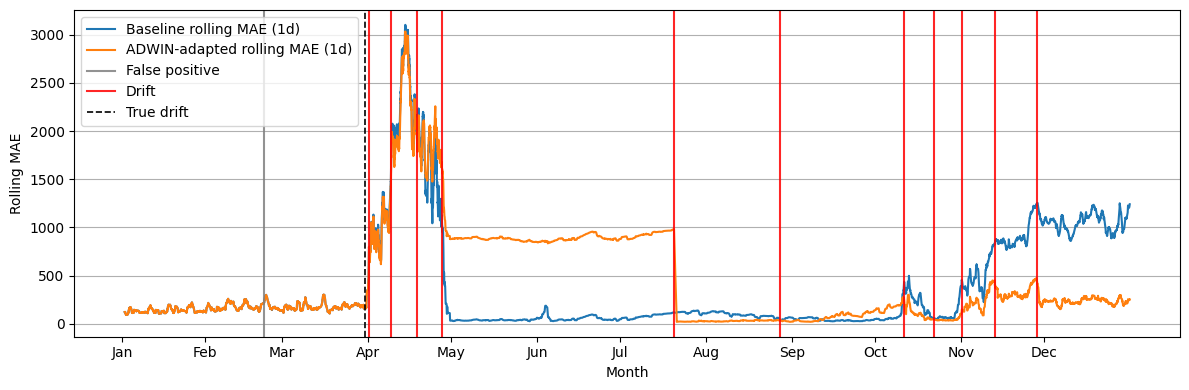

In [62]:
# xticks, xlabels = _month_ticks_named(mo3_lab)

# plt.figure(figsize=(12, 4))
# plt.plot(mae3_base_roll,  label=f"Baseline rolling MAE ({ROLL_DAYS}d)")
# plt.plot(mae_adapt_roll,  label=f"ADWIN-adapted rolling MAE ({ROLL_DAYS}d)")

# # Drift alarms: pre-Apr gray (false positives), post-Apr red (drift)
# shown_fp = False
# shown_drift = False

# for di in adw_all_drifts:
#     is_drift = (ts3_lab[di] >= ONLY_AFTER_TS)
#     color = "red" if is_drift else "tab:gray"

#     if (not is_drift) and (not shown_fp):
#         lab = "False positive"
#         shown_fp = True
#     elif is_drift and (not shown_drift):
#         lab = "Drift"
#         shown_drift = True
#     else:
#         lab = "_nolegend_"  # labels starting with '_' are ignored by legend() auto-selection [web:45]

#     plt.axvline(di, color=color, linestyle="-", linewidth=1.5, alpha=0.85, label=lab)

# plt.axvline(tau_idx, color="black", linestyle="--", linewidth=1.2, label="True drift")
# plt.xticks(xticks, xlabels, rotation=0)
# plt.xlabel("Month")
# plt.ylabel("Rolling MAE")
# plt.title("")
# plt.grid(True, axis="y")
# plt.legend()
# plt.tight_layout()
# plt.show()


[Y4-ADWIN-gradual] Using df_drift.
=== Year 4 — Per-horizon metrics (Baseline vs ADWIN-Gradual-Adapted) ===


horizon  MAE_base  MAE_adpt_gradual  RMSE_base  RMSE_adpt_gradual  \
0     t+1     304.3             114.6    1,033.7              253.7   
1     t+2     305.9             111.9      843.3              221.9   
2     t+3     355.3             112.2      941.9              233.3   
3     t+4     380.9             127.2      869.9              251.8   

   sMAPE%_base  sMAPE%_adpt_gradual  MAPE%_base  MAPE%_adpt_gradual  
0        168.7                163.8     8,391.6             6,059.9  
1        171.3                164.1     9,514.6             5,784.4  
2        172.5                164.4    11,361.8             5,071.7  
3        173.7                165.8    12,449.3             5,932.4

\n=== Year 4 — Aggregate metrics (means over windows) ===


MAE_mean  RMSE_mean  sMAPE_mean%  MAPE_mean%  WAPE%
Baseline                  336.6      384.0        171.6    10,429.3  149.4
ADWIN-Gradual-Adapted     116.5      131.5        164.5     5,712.1   51.7

\n=== Year 4 — Global metrics (flattened over all windows x horizons) ===


MAE_global  RMSE_global  sMAPE_global%  MAPE_global%  \
Baseline                    336.6        925.1          171.6      10,429.3   
ADWIN-Gradual-Adapted       116.5        240.5          164.5       5,712.1   

                       WAPE_global%  
Baseline                      149.4  
ADWIN-Gradual-Adapted          51.7

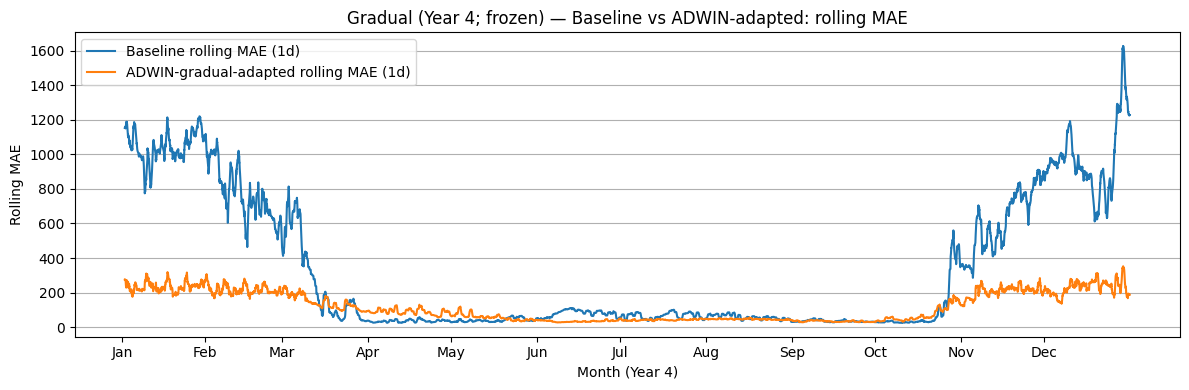

In [106]:
# ---------- Safety checks ----------
assert 'adwin_gradual_model' in globals() and adwin_gradual_model is not None, \
    "adwin_gradual_model not found. Run the gradual ADWIN online fine-tuning first."

# ---------- Prefer gradual-full dataset if present ----------
if 'df_drift_pm' in globals() and isinstance(df_drift_pm, pd.DataFrame) and len(df_drift_pm):
    df_src = df_drift_pm
    print("[Y4-ADWIN-gradual] Using df_drift_pm.")
else:
    df_src = df_drift
    print("[Y4-ADWIN-gradual] Using df_drift.")

# ---------- Minimal helpers (safe even if defined elsewhere) ----------
def _window_mae(y_true_row, y_hat_row):
    return float(np.mean(np.abs(y_true_row - y_hat_row)))

def _window_rmse(y_true_row, y_hat_row):
    return float(np.sqrt(np.mean((y_true_row - y_hat_row) ** 2)))

def _window_smape(y_true_row, y_hat_row, eps=1e-6):
    num = np.abs(y_true_row - y_hat_row)
    den = (np.abs(y_true_row) + np.abs(y_hat_row)).clip(min=eps)
    return float(np.mean(2.0 * num / den) * 100.0)

# -------------------- FIXED: MAPE helper (eps floor = 1.0 in target units) --------------------
def _window_mape(y_true_row, y_hat_row, eps=1.0):
    den = np.maximum(np.abs(y_true_row), eps)
    return float(np.mean(np.abs((y_true_row - y_hat_row) / den)) * 100.0)  # % [web:1]
# ---------------------------------------------------------------------------------------------

def _rolling_mean(values, k):
    if k <= 1:
        return values.astype(float)
    out = np.full(len(values), np.nan, float)
    if len(values) >= k:
        csum = np.cumsum(values, dtype=float)
        out[k-1:] = (csum[k-1:] - np.concatenate(([0.0], csum[:-k])))/k
    return out

def _steps_per_day_from_labels(ts_labels):
    if ts_labels.size >= 2 and np.isfinite(ts_labels).all():
        dt_sec = float(np.median(np.diff(ts_labels)))
    else:
        dt_sec = 15 * 60.0
    steps_per_day = max(1, int(round((24 * 3600) / dt_sec)))
    return steps_per_day, dt_sec

def _month_ticks(months_arr):
    starts, labels, seen = [], [], set()
    for i, m in enumerate(np.asarray(months_arr).astype(int)):
        if m not in seen:
            starts.append(i)
            labels.append(calendar.month_abbr[m] if 1 <= m <= 12 else str(m))
            seen.add(m)
    return np.asarray(starts, int), labels

def _per_horizon_smape(y_true_2d, y_hat_2d, eps=1e-6):
    out = []
    for h in range(y_true_2d.shape[1]):
        num = np.abs(y_true_2d[:, h] - y_hat_2d[:, h])
        den = (np.abs(y_true_2d[:, h]) + np.abs(y_hat_2d[:, h])).clip(min=eps)
        out.append(float(np.mean(2.0 * num / den) * 100.0))
    return out

# -------------------- FIXED: per-horizon MAPE (eps floor = 1.0 in target units) --------------------
def _per_horizon_mape(y_true_2d, y_hat_2d, eps=1.0):
    out = []
    for h in range(y_true_2d.shape[1]):
        den = np.maximum(np.abs(y_true_2d[:, h]), eps)
        out.append(float(np.mean(np.abs((y_true_2d[:, h] - y_hat_2d[:, h]) / den)) * 100.0))  # % [web:1]
    return out
# -------------------------------------------------------------------------------------------------

# ---------- Compat wrapper: _build_year_windows may return 4 or 5 values ----------
def _build_year_windows_compat(df_year):
    out = _build_year_windows(df_year)
    if isinstance(out, (tuple, list)) and len(out) == 5:
        return out  # Xw, Yw, ts, mo, lbl
    if isinstance(out, (tuple, list)) and len(out) == 4:
        Xw, Yw, ts, mo = out
        return Xw, Yw, ts, mo, None
    raise ValueError(f"_build_year_windows returned {type(out)} with len={len(out)}; expected 4 or 5.")

# ---------- 1) Build Year-4 windows ----------
y4_df = df_src[df_src['year'] == 4].reset_index(drop=True)
assert len(y4_df) >= LOOKBACK + HORIZON + 1, "Year 4 has insufficient rows."

X4_win, Y4_win, ts4_lab, mo4_lab, _ = _build_year_windows_compat(y4_df)

steps_per_day, _ = _steps_per_day_from_labels(ts4_lab)
ROLL_DAYS  = 1
roll_steps = max(1, ROLL_DAYS * steps_per_day)

# ---------- 2) Predict (baseline vs ADWIN-gradual-adapted model) ----------
Y4_true, Y4_hat_base  = _predict_unscaled(baseline_model,      X4_win, Y4_win)
_,        Y4_hat_adpt = _predict_unscaled(adwin_gradual_model, X4_win, Y4_win)

H = Y4_true.shape[1]

# ---------- 3) Per-horizon metrics (MAE, RMSE, sMAPE) ----------
mae_base_h   = [mean_absolute_error(Y4_true[:,h], Y4_hat_base[:,h]) for h in range(H)]
mae_adpt_h   = [mean_absolute_error(Y4_true[:,h], Y4_hat_adpt[:,h]) for h in range(H)]

rmse_base_h  = [mean_squared_error(Y4_true[:,h], Y4_hat_base[:,h], squared=False) for h in range(H)]
rmse_adpt_h  = [mean_squared_error(Y4_true[:,h], Y4_hat_adpt[:,h], squared=False) for h in range(H)]

smape_base_h = _per_horizon_smape(Y4_true, Y4_hat_base)
smape_adpt_h = _per_horizon_smape(Y4_true, Y4_hat_adpt)

# -------------------- per-horizon MAPE --------------------
mape_base_h = _per_horizon_mape(Y4_true, Y4_hat_base)
mape_adpt_h = _per_horizon_mape(Y4_true, Y4_hat_adpt)
# ---------------------------------------------------------

per_horizon_tbl = pd.DataFrame({
    "horizon":      [f"t+{i+1}" for i in range(H)],
    "MAE_base":     mae_base_h,   "MAE_adpt_gradual":     mae_adpt_h,
    "RMSE_base":    rmse_base_h,  "RMSE_adpt_gradual":    rmse_adpt_h,
    "sMAPE%_base":  smape_base_h, "sMAPE%_adpt_gradual":  smape_adpt_h,
    "MAPE%_base":   mape_base_h,  "MAPE%_adpt_gradual":   mape_adpt_h
})
print("=== Year 4 — Per-horizon metrics (Baseline vs ADWIN-Gradual-Adapted) ===")
display(per_horizon_tbl)

# ---------- 4) Per-window errors (aggregate + rolling MAE) ----------
mae4_base_win   = np.array([_window_mae (Y4_true[i], Y4_hat_base[i]) for i in range(len(X4_win))], float)
mae4_adpt_win   = np.array([_window_mae (Y4_true[i], Y4_hat_adpt[i]) for i in range(len(X4_win))], float)

rmse4_base_win  = np.array([_window_rmse(Y4_true[i], Y4_hat_base[i]) for i in range(len(X4_win))], float)
rmse4_adpt_win  = np.array([_window_rmse(Y4_true[i], Y4_hat_adpt[i]) for i in range(len(X4_win))], float)

smape4_base_win = np.array([_window_smape(Y4_true[i], Y4_hat_base[i]) for i in range(len(X4_win))], float)
smape4_adpt_win = np.array([_window_smape(Y4_true[i], Y4_hat_adpt[i]) for i in range(len(X4_win))], float)

# -------------------- per-window MAPE --------------------
mape4_base_win  = np.array([_window_mape(Y4_true[i], Y4_hat_base[i]) for i in range(len(X4_win))], float)
mape4_adpt_win  = np.array([_window_mape(Y4_true[i], Y4_hat_adpt[i]) for i in range(len(X4_win))], float)
# --------------------------------------------------------

# WAPE over all windows & horizons
wape_base = (np.sum(np.abs(Y4_true - Y4_hat_base)) / max(np.sum(np.abs(Y4_true)), 1e-12)) * 100.0
wape_adpt = (np.sum(np.abs(Y4_true - Y4_hat_adpt)) / max(np.sum(np.abs(Y4_true)), 1e-12)) * 100.0

aggregate_tbl = pd.DataFrame({
    "MAE_mean":    [float(np.mean(mae4_base_win)),   float(np.mean(mae4_adpt_win))],
    "RMSE_mean":   [float(np.mean(rmse4_base_win)),  float(np.mean(rmse4_adpt_win))],
    "sMAPE_mean%": [float(np.mean(smape4_base_win)), float(np.mean(smape4_adpt_win))],
    "MAPE_mean%":  [float(np.mean(mape4_base_win)),  float(np.mean(mape4_adpt_win))],
    "WAPE%":       [float(wape_base),                float(wape_adpt)]
}, index=["Baseline", "ADWIN-Gradual-Adapted"])
print("\\n=== Year 4 — Aggregate metrics (means over windows) ===")
display(aggregate_tbl)

# ---------- ADDED: Global metrics (flattened over all windows x horizons) ----------
_eps_g = 1e-6

_diff_base = (Y4_true - Y4_hat_base)
mae_base_global  = float(np.mean(np.abs(_diff_base)))
rmse_base_global = float(np.sqrt(np.mean(_diff_base ** 2)))
_den_base = (np.abs(Y4_true) + np.abs(Y4_hat_base)).clip(min=_eps_g)
smape_base_global = float(np.mean(2.0 * np.abs(_diff_base) / _den_base) * 100.0)
# -------------------- FIXED: global MAPE (baseline; eps floor = 1.0) --------------------
_den_mape_base = np.maximum(np.abs(Y4_true), 1.0)
mape_base_global = float(np.mean(np.abs(_diff_base) / _den_mape_base) * 100.0)
# ----------------------------------------------------------------------------------------
wape_base_global  = float(wape_base)

_diff_adpt = (Y4_true - Y4_hat_adpt)
mae_adpt_global  = float(np.mean(np.abs(_diff_adpt)))
rmse_adpt_global = float(np.sqrt(np.mean(_diff_adpt ** 2)))
_den_adpt = (np.abs(Y4_true) + np.abs(Y4_hat_adpt)).clip(min=_eps_g)
smape_adpt_global = float(np.mean(2.0 * np.abs(_diff_adpt) / _den_adpt) * 100.0)
# -------------------- FIXED: global MAPE (adapted; eps floor = 1.0) --------------------
_den_mape_adpt = np.maximum(np.abs(Y4_true), 1.0)
mape_adpt_global = float(np.mean(np.abs(_diff_adpt) / _den_mape_adpt) * 100.0)
# ---------------------------------------------------------------------------------------
wape_adpt_global  = float(wape_adpt)

global_tbl = pd.DataFrame({
    "MAE_global":     [mae_base_global,   mae_adpt_global],
    "RMSE_global":    [rmse_base_global,  rmse_adpt_global],
    "sMAPE_global%":  [smape_base_global, smape_adpt_global],
    "MAPE_global%":   [mape_base_global,  mape_adpt_global],
    "WAPE_global%":   [wape_base_global,  wape_adpt_global],
}, index=["Baseline", "ADWIN-Gradual-Adapted"])

print("\\n=== Year 4 — Global metrics (flattened over all windows x horizons) ===")
display(global_tbl)
# ----------------------------------------------------------------------


# ---------- 5) Plot ONLY rolling MAE (1 day) ----------
mae4_base_roll = _rolling_mean(mae4_base_win, roll_steps)
mae4_adpt_roll = _rolling_mean(mae4_adpt_win, roll_steps)

xt, xl = _month_ticks(mo4_lab)

plt.figure(figsize=(12,4))
plt.plot(mae4_base_roll, label=f"Baseline rolling MAE ({ROLL_DAYS}d)")
plt.plot(mae4_adpt_roll, label=f"ADWIN-gradual-adapted rolling MAE ({ROLL_DAYS}d)")
plt.xticks(xt, xl)
plt.xlabel("Month (Year 4)")
plt.ylabel("Rolling MAE")
plt.title("Gradual (Year 4; frozen) — Baseline vs ADWIN-adapted: rolling MAE")
plt.grid(True, axis="y")
plt.legend()
plt.tight_layout()
plt.show()


[Y5-ADWIN-gradual] Using df_drift.
=== Year 5 — Per-horizon metrics (Baseline vs ADWIN-Gradual-Adapted) ===


horizon  MAE_base  MAE_adpt_gradual  RMSE_base  RMSE_adpt_gradual  \
0     t+1     342.1             121.9    1,072.5              249.1   
1     t+2     348.3             121.3      885.6              228.4   
2     t+3     403.2             122.8      993.6              248.1   
3     t+4     433.0             137.4      941.0              264.0   

   sMAPE%_base  sMAPE%_adpt_gradual  MAPE%_base  MAPE%_adpt_gradual  
0        168.2                161.2    10,265.0             6,371.3  
1        170.3                161.8    11,720.5             6,182.4  
2        171.6                162.3    13,880.6             5,457.0  
3        172.7                163.9    14,936.3             6,259.5


=== Year 5 — Aggregate metrics (means over windows) ===


MAE_mean  RMSE_mean  sMAPE_mean%  MAPE_mean%  WAPE%
Baseline                  381.6      433.4        170.7    12,700.6  162.3
ADWIN-Gradual-Adapted     125.9      141.2        162.3     6,067.6   53.5


=== Year 5 — Global metrics (flattened over all windows x horizons) ===


MAE_global  RMSE_global  sMAPE_global%  MAPE_global%  \
Baseline                    381.6        975.6          170.7      12,700.6   
ADWIN-Gradual-Adapted       125.9        247.7          162.3       6,067.6   

                       WAPE_global%  
Baseline                      162.3  
ADWIN-Gradual-Adapted          53.5

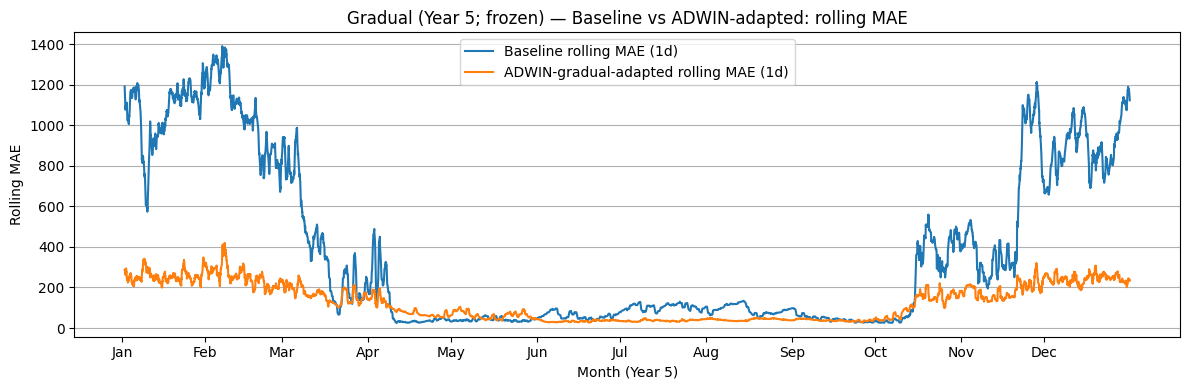

In [107]:
# ---------- Safety checks ----------
assert 'adwin_gradual_model' in globals() and adwin_gradual_model is not None, \
    "adwin_gradual_model not found. Run the gradual ADWIN online fine-tuning first."

# ---------- Prefer gradual-full dataset if present ----------
if 'df_drift_pm' in globals() and isinstance(df_drift_pm, pd.DataFrame) and len(df_drift_pm):
    df_src = df_drift_pm
    print("[Y5-ADWIN-gradual] Using df_drift_pm.")
else:
    df_src = df_drift
    print("[Y5-ADWIN-gradual] Using df_drift.")

# ---------- Minimal helpers (safe even if defined elsewhere) ----------
def _window_mae(y_true_row, y_hat_row):
    return float(np.mean(np.abs(y_true_row - y_hat_row)))

def _window_rmse(y_true_row, y_hat_row):
    return float(np.sqrt(np.mean((y_true_row - y_hat_row) ** 2)))

def _window_smape(y_true_row, y_hat_row, eps=1e-6):
    num = np.abs(y_true_row - y_hat_row)
    den = (np.abs(y_true_row) + np.abs(y_hat_row)).clip(min=eps)
    return float(np.mean(2.0 * num / den) * 100.0)

# -------------------- FIXED: MAPE helper (eps floor = 1.0 in target units) --------------------
def _window_mape(y_true_row, y_hat_row, eps=1.0):
    den = np.maximum(np.abs(y_true_row), eps)
    return float(np.mean(np.abs((y_true_row - y_hat_row) / den)) * 100.0)  # %
# ---------------------------------------------------------------------------------------------

def _rolling_mean(values, k):
    if k <= 1:
        return values.astype(float)
    out = np.full(len(values), np.nan, float)
    if len(values) >= k:
        csum = np.cumsum(values, dtype=float)
        out[k-1:] = (csum[k-1:] - np.concatenate(([0.0], csum[:-k])))/k
    return out

def _steps_per_day_from_labels(ts_labels):
    if ts_labels.size >= 2 and np.isfinite(ts_labels).all():
        dt_sec = float(np.median(np.diff(ts_labels)))
    else:
        dt_sec = 15 * 60.0
    steps_per_day = max(1, int(round((24 * 3600) / dt_sec)))
    return steps_per_day, dt_sec

def _month_ticks(months_arr):
    starts, labels, seen = [], [], set()
    for i, m in enumerate(np.asarray(months_arr).astype(int)):
        if m not in seen:
            starts.append(i)
            labels.append(calendar.month_abbr[m] if 1 <= m <= 12 else str(m))
            seen.add(m)
    return np.asarray(starts, int), labels

def _per_horizon_smape(y_true_2d, y_hat_2d, eps=1e-6):
    out = []
    for h in range(y_true_2d.shape[1]):
        num = np.abs(y_true_2d[:, h] - y_hat_2d[:, h])
        den = (np.abs(y_true_2d[:, h]) + np.abs(y_hat_2d[:, h])).clip(min=eps)
        out.append(float(np.mean(2.0 * num / den) * 100.0))
    return out

# -------------------- FIXED: per-horizon MAPE (eps floor = 1.0 in target units) --------------------
def _per_horizon_mape(y_true_2d, y_hat_2d, eps=1.0):
    out = []
    for h in range(y_true_2d.shape[1]):
        den = np.maximum(np.abs(y_true_2d[:, h]), eps)
        out.append(float(np.mean(np.abs((y_true_2d[:, h] - y_hat_2d[:, h]) / den)) * 100.0))
    return out
# -------------------------------------------------------------------------------------------------

# ---------- Compat wrapper: _build_year_windows may return 4 or 5 values ----------
def _build_year_windows_compat(df_year):
    out = _build_year_windows(df_year)
    if isinstance(out, (tuple, list)) and len(out) == 5:
        return out  # Xw, Yw, ts, mo, lbl
    if isinstance(out, (tuple, list)) and len(out) == 4:
        Xw, Yw, ts, mo = out
        return Xw, Yw, ts, mo, None
    raise ValueError(f"_build_year_windows returned {type(out)} with len={len(out)}; expected 4 or 5.")

# ---------- 1) Build Year-4 windows ----------
y4_df = df_src[df_src['year'] == 5].reset_index(drop=True)
assert len(y4_df) >= LOOKBACK + HORIZON + 1, "Year 5 has insufficient rows."

X4_win, Y4_win, ts4_lab, mo4_lab, _ = _build_year_windows_compat(y4_df)

steps_per_day, _ = _steps_per_day_from_labels(ts4_lab)
ROLL_DAYS  = 1
roll_steps = max(1, ROLL_DAYS * steps_per_day)

# ---------- 2) Predict (baseline vs ADWIN-gradual-adapted model) ----------
Y4_true, Y4_hat_base  = _predict_unscaled(baseline_model,      X4_win, Y4_win)
_,        Y4_hat_adpt = _predict_unscaled(adwin_gradual_model, X4_win, Y4_win)

H = Y4_true.shape[1]

# ---------- 3) Per-horizon metrics (MAE, RMSE, sMAPE) ----------
mae_base_h   = [mean_absolute_error(Y4_true[:,h], Y4_hat_base[:,h]) for h in range(H)]
mae_adpt_h   = [mean_absolute_error(Y4_true[:,h], Y4_hat_adpt[:,h]) for h in range(H)]

rmse_base_h  = [mean_squared_error(Y4_true[:,h], Y4_hat_base[:,h], squared=False) for h in range(H)]
rmse_adpt_h  = [mean_squared_error(Y4_true[:,h], Y4_hat_adpt[:,h], squared=False) for h in range(H)]

smape_base_h = _per_horizon_smape(Y4_true, Y4_hat_base)
smape_adpt_h = _per_horizon_smape(Y4_true, Y4_hat_adpt)

mape_base_h = _per_horizon_mape(Y4_true, Y4_hat_base)
mape_adpt_h = _per_horizon_mape(Y4_true, Y4_hat_adpt)

per_horizon_tbl = pd.DataFrame({
    "horizon":      [f"t+{i+1}" for i in range(H)],
    "MAE_base":     mae_base_h,   "MAE_adpt_gradual":     mae_adpt_h,
    "RMSE_base":    rmse_base_h,  "RMSE_adpt_gradual":    rmse_adpt_h,
    "sMAPE%_base":  smape_base_h, "sMAPE%_adpt_gradual":  smape_adpt_h,
    "MAPE%_base":   mape_base_h,  "MAPE%_adpt_gradual":   mape_adpt_h
})
print("=== Year 5 — Per-horizon metrics (Baseline vs ADWIN-Gradual-Adapted) ===")
display(per_horizon_tbl)

# ---------- 4) Per-window errors (aggregate + rolling MAE) ----------
mae4_base_win   = np.array([_window_mae (Y4_true[i], Y4_hat_base[i]) for i in range(len(X4_win))], float)
mae4_adpt_win   = np.array([_window_mae (Y4_true[i], Y4_hat_adpt[i]) for i in range(len(X4_win))], float)

rmse4_base_win  = np.array([_window_rmse(Y4_true[i], Y4_hat_base[i]) for i in range(len(X4_win))], float)
rmse4_adpt_win  = np.array([_window_rmse(Y4_true[i], Y4_hat_adpt[i]) for i in range(len(X4_win))], float)

smape4_base_win = np.array([_window_smape(Y4_true[i], Y4_hat_base[i]) for i in range(len(X4_win))], float)
smape4_adpt_win = np.array([_window_smape(Y4_true[i], Y4_hat_adpt[i]) for i in range(len(X4_win))], float)

mape4_base_win = np.array([_window_mape(Y4_true[i], Y4_hat_base[i]) for i in range(len(X4_win))], float)
mape4_adpt_win = np.array([_window_mape(Y4_true[i], Y4_hat_adpt[i]) for i in range(len(X4_win))], float)

# WAPE over all windows & horizons
wape_base = (np.sum(np.abs(Y4_true - Y4_hat_base)) / max(np.sum(np.abs(Y4_true)), 1e-12)) * 100.0
wape_adpt = (np.sum(np.abs(Y4_true - Y4_hat_adpt)) / max(np.sum(np.abs(Y4_true)), 1e-12)) * 100.0

aggregate_tbl = pd.DataFrame({
    "MAE_mean":    [float(np.mean(mae4_base_win)),   float(np.mean(mae4_adpt_win))],
    "RMSE_mean":   [float(np.mean(rmse4_base_win)),  float(np.mean(rmse4_adpt_win))],
    "sMAPE_mean%": [float(np.mean(smape4_base_win)), float(np.mean(smape4_adpt_win))],
    "MAPE_mean%":  [float(np.mean(mape4_base_win)),  float(np.mean(mape4_adpt_win))],
    "WAPE%":       [float(wape_base),                float(wape_adpt)]
}, index=["Baseline", "ADWIN-Gradual-Adapted"])
print("\n=== Year 5 — Aggregate metrics (means over windows) ===")
display(aggregate_tbl)

# ---------- ADDED: Global metrics (flattened over all windows x horizons) ----------
_eps_g = 1e-6

_diff_base = (Y4_true - Y4_hat_base)
mae_base_global  = float(np.mean(np.abs(_diff_base)))
rmse_base_global = float(np.sqrt(np.mean(_diff_base ** 2)))
_den_base = (np.abs(Y4_true) + np.abs(Y4_hat_base)).clip(min=_eps_g)
smape_base_global = float(np.mean(2.0 * np.abs(_diff_base) / _den_base) * 100.0)
# -------------------- FIXED: global MAPE (baseline; eps floor = 1.0) --------------------
_den_mape_base = np.maximum(np.abs(Y4_true), 1.0)
mape_base_global = float(np.mean(np.abs(_diff_base) / _den_mape_base) * 100.0)
# ----------------------------------------------------------------------------------------
wape_base_global  = float(wape_base)

_diff_adpt = (Y4_true - Y4_hat_adpt)
mae_adpt_global  = float(np.mean(np.abs(_diff_adpt)))
rmse_adpt_global = float(np.sqrt(np.mean(_diff_adpt ** 2)))
_den_adpt = (np.abs(Y4_true) + np.abs(Y4_hat_adpt)).clip(min=_eps_g)
smape_adpt_global = float(np.mean(2.0 * np.abs(_diff_adpt) / _den_adpt) * 100.0)
# -------------------- FIXED: global MAPE (adapted; eps floor = 1.0) --------------------
_den_mape_adpt = np.maximum(np.abs(Y4_true), 1.0)
mape_adpt_global = float(np.mean(np.abs(_diff_adpt) / _den_mape_adpt) * 100.0)
# ---------------------------------------------------------------------------------------
wape_adpt_global  = float(wape_adpt)

global_tbl = pd.DataFrame({
    "MAE_global":     [mae_base_global,   mae_adpt_global],
    "RMSE_global":    [rmse_base_global,  rmse_adpt_global],
    "sMAPE_global%":  [smape_base_global, smape_adpt_global],
    "MAPE_global%":   [mape_base_global,  mape_adpt_global],
    "WAPE_global%":   [wape_base_global,  wape_adpt_global],
}, index=["Baseline", "ADWIN-Gradual-Adapted"])

print("\n=== Year 5 — Global metrics (flattened over all windows x horizons) ===")
display(global_tbl)
# ----------------------------------------------------------------------


# ---------- 5) Plot ONLY rolling MAE (1 day) ----------
mae4_base_roll = _rolling_mean(mae4_base_win, roll_steps)
mae4_adpt_roll = _rolling_mean(mae4_adpt_win, roll_steps)

xt, xl = _month_ticks(mo4_lab)

plt.figure(figsize=(12,4))
plt.plot(mae4_base_roll, label=f"Baseline rolling MAE ({ROLL_DAYS}d)")
plt.plot(mae4_adpt_roll, label=f"ADWIN-gradual-adapted rolling MAE ({ROLL_DAYS}d)")
plt.xticks(xt, xl)
plt.xlabel("Month (Year 5)")
plt.ylabel("Rolling MAE")
plt.title("Gradual (Year 5; frozen) — Baseline vs ADWIN-adapted: rolling MAE")
plt.grid(True, axis="y")
plt.legend()
plt.tight_layout()
plt.show()
